# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
MyDrive


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # DONE Add more preprocessing
    data = re.sub(r"[\n\t\s]", " ", data)

    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    cnt = 0
    text = []
    for char in data:
        if char in voc2ind:
            pass
        else:
            voc2ind[char] = cnt
            cnt += 1
        text.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = text[:(int)(len(text) * 0.8)]
    test_text = text[(int)(len(text) * 0.8):]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [6]:
import math


class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # DONE: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        print("length of tokens:", len(self.tokens))
        if len(self.tokens) % self.batch_size > 0:
            self.tokens = self.tokens[:(len(self.tokens) // self.batch_size) * self.batch_size]

        n_tokens_in_chunk = len(self.tokens) // self.batch_size
        self.num_unique_seq = self.batch_size * math.ceil((float)(n_tokens_in_chunk - 1) / self.sequence_length)

        self.dataset = []
        for i in range(0, self.num_unique_seq // self.batch_size):
            for batch in range(self.batch_size):
                seq = []
                for char in range(self.sequence_length + 1):
                    idx = batch * n_tokens_in_chunk + i * self.sequence_length + char
                    if idx < (batch + 1) * n_tokens_in_chunk:
                        seq.append(self.tokens[idx])
                self.dataset.append(seq)



    def __len__(self):
        # DONE return the number of unique sequences you have, not the number of characters.
         return self.num_unique_seq
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # DONE
        return torch.LongTensor(self.dataset[idx][:-1]), torch.LongTensor(self.dataset[idx][1:])

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [6]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # DONE finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [7]:
import copy


TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # DONE
        max = torch.argmax(output)
        outputs.append(max)
        output, hidden = model.inference(max.to(device), hidden)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # DONE
        sample = np.random.choice(output.shape[1], 1, p=output.flatten().cpu().numpy())[0]
        outputs.append(sample)
        output, hidden = model.inference(torch.tensor(sample).to(device), hidden)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    # DONE
    for ii in range(sequence_length):
        new_beams = []
        for beam in beams:
            # print("beam[0]:", beam[0])
            if len(beam[0]) > 0:
                new_output, new_hidden = model.inference(torch.tensor(beam[0][-1]).to(device), beam[2])
            else:
                new_output = copy.deepcopy(output)
                new_hidden = copy.deepcopy(hidden)
            for n in range(beam_width):
                sample = np.random.choice(new_output.shape[1], 1, p=new_output.flatten().cpu().numpy())[0]
                # print("sample:", sample)
                seq = list(copy.deepcopy(beam[0]))
                seq.append(sample)
                prob = np.log(new_output.flatten().cpu().numpy()[sample])
                new_beams.append((seq, new_output, new_hidden, prob))
        sorted(new_beams, key=lambda x: x[3])
        beams = new_beams[:beam_width]

    return beams[0][0]


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [8]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tPerplexity: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), np.exp(np.mean(losses))))
    return np.mean(losses), np.exp(np.mean(losses))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Perplexity: {:.6f}\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length), np.exp(np.mean(test_loss))))
    return test_loss, test_accuracy, np.exp(np.mean(test_loss))

length of tokens: 5000121
length of tokens: 1250031
Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	LL0,mm^Jq0uYFEFLqVuF8JIFuE5EL-6Rp--q8'w9ueL`F88?9qf0q^^ukqtt98''99(9=5qEspCuq8t)86s`Y'ZuEEFLqF8u8qku


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	-EF9IF88I9q9t88R88oo2F8850u?--kq9t-*mER0s`CuqLRpFFREkqtpFLqF8uqc^FuEEctF99Iq8W0I-94q9"q8(6?;LsukqFLq


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	?F93qR^kq9t889quFq0wYFEF8u8V8Lppkqq88F8uQq0tYFukq9t-mI^kqAqu?

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 18.2046, Accuracy: 13027/1254400 (1%), Perplexity: 80569170.018656



  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 18.302727	Perplexity: 88873693.504247


  7%|▋         | 13/196 [00:01<00:16, 10.84it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 10.759130	Perplexity: 22735493.831609


 12%|█▏        | 23/196 [00:01<00:14, 11.98it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 5.902176	Perplexity: 253801.981951


 17%|█▋        | 33/196 [00:02<00:13, 12.30it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 3.781289	Perplexity: 20064.163450


 22%|██▏       | 43/196 [00:03<00:12, 12.30it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 3.085475	Perplexity: 4012.067426


 27%|██▋       | 53/196 [00:04<00:11, 12.20it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 3.118108	Perplexity: 1446.858847


 32%|███▏      | 63/196 [00:05<00:10, 12.32it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 2.598963	Perplexity: 687.515940


 37%|███▋      | 73/196 [00:06<00:09, 12.33it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 2.443645	Perplexity: 392.636412


 42%|████▏     | 83/196 [00:06<00:09, 12.34it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 2.697727	Perplexity: 257.149136


 47%|████▋     | 93/196 [00:07<00:08, 12.30it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 2.381338	Perplexity: 185.976902


 53%|█████▎    | 103/196 [00:08<00:07, 12.33it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 2.164026	Perplexity: 139.044299


 58%|█████▊    | 113/196 [00:09<00:06, 12.34it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 2.506706	Perplexity: 109.092064


 63%|██████▎   | 123/196 [00:10<00:05, 12.34it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 3.063296	Perplexity: 92.265918


 68%|██████▊   | 133/196 [00:10<00:05, 12.07it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 2.446613	Perplexity: 80.063020


 73%|███████▎  | 143/196 [00:11<00:04, 12.28it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 2.135884	Perplexity: 68.930761


 78%|███████▊  | 153/196 [00:12<00:03, 11.91it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 2.020803	Perplexity: 59.660816


 83%|████████▎ | 163/196 [00:13<00:02, 12.22it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 2.270853	Perplexity: 52.522017


 88%|████████▊ | 173/196 [00:14<00:01, 11.97it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.990339	Perplexity: 47.269814


 93%|█████████▎| 183/196 [00:15<00:01, 11.93it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.962056	Perplexity: 42.710353


 98%|█████████▊| 193/196 [00:15<00:00, 12.02it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.865645	Perplexity: 38.740965


100%|██████████| 196/196 [00:16<00:00, 12.14it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	r y ahs foat fh fot aascr  au ause seldemoreeaiv buaueed an somm . Ie soomg fis elf afer bh bhe bxee


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahet iev aem ono  "  weslsssl ais  aocl ng aock ard.an o ahe fascr aath a smoacse he saoeisledooo b


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe bnd Hes fael iost fhe soound a  she  wok er ais asd aeein ao foley aas  aoioey asd aededy  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry slight," said Hermione Voldemborts, dim; the give onter so me he hear, Luping. "Ton' knonew beversounce and in pchocking of cause happoing anPy. "If of docye're realue your feeling, "alled goten



  1%|          | 2/196 [00:00<00:36,  5.33it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.844772	Perplexity: 6.326657


  6%|▌         | 12/196 [00:01<00:18,  9.84it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 2.035625	Perplexity: 7.064697


 11%|█         | 22/196 [00:01<00:14, 11.65it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.929284	Perplexity: 7.107093


 16%|█▋        | 32/196 [00:02<00:13, 12.13it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.888989	Perplexity: 6.931884


 21%|██▏       | 42/196 [00:03<00:12, 12.12it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.890464	Perplexity: 6.806842


 27%|██▋       | 52/196 [00:04<00:12, 11.86it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 2.034814	Perplexity: 6.835418


 32%|███▏      | 62/196 [00:05<00:11, 11.96it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.890525	Perplexity: 6.812012


 37%|███▋      | 72/196 [00:06<00:10, 11.83it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.864150	Perplexity: 6.762791


 42%|████▏     | 82/196 [00:07<00:09, 11.96it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.758720	Perplexity: 6.655936


 47%|████▋     | 92/196 [00:07<00:08, 11.92it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.855152	Perplexity: 6.593934


 52%|█████▏    | 102/196 [00:08<00:07, 11.94it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.838466	Perplexity: 6.600205


 57%|█████▋    | 112/196 [00:09<00:07, 11.84it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.969299	Perplexity: 6.673701


 62%|██████▏   | 122/196 [00:10<00:06, 11.82it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.769655	Perplexity: 6.638567


 67%|██████▋   | 132/196 [00:11<00:05, 12.08it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.686290	Perplexity: 6.558039


 72%|███████▏  | 142/196 [00:12<00:04, 11.91it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.682380	Perplexity: 6.476301


 78%|███████▊  | 152/196 [00:12<00:03, 11.78it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.779128	Perplexity: 6.407985


 83%|████████▎ | 162/196 [00:13<00:02, 11.85it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.697624	Perplexity: 6.351008


 88%|████████▊ | 172/196 [00:14<00:02, 11.80it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.669273	Perplexity: 6.292080


 93%|█████████▎| 182/196 [00:15<00:01, 11.62it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.775093	Perplexity: 6.248067


 98%|█████████▊| 192/196 [00:16<00:00, 11.74it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.772423	Perplexity: 6.220408


100%|██████████| 196/196 [00:16<00:00, 11.78it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y han aiat hh hot aasc   au ause hold mort aav buacnid on aomh . aa hlonn iim elf afer th hhe sxge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ihan had aam hnm  "  wasissll him  arcl ng hack ard tn o the hancr aath h wioacii he haaaneled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and his hill aiat hhe saound hn hhe  hik  r him and hesan to tanri aam  aaiwiy and sirp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Colaring of angivicallur in had Les. Ever if kinch turnnne of lape of Slugh.   "And you?" "Ah," Whonks," said Ron gling and downg wain him to teachingh at amout doo."   and Harry robesob&tlingst of hi



  1%|          | 2/196 [00:00<00:36,  5.34it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.764441	Perplexity: 5.838311


  6%|▌         | 12/196 [00:01<00:18,  9.85it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.804675	Perplexity: 5.921166


 11%|█         | 22/196 [00:02<00:15, 11.51it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.733816	Perplexity: 5.775875


 16%|█▋        | 32/196 [00:02<00:13, 11.90it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.642118	Perplexity: 5.604884


 21%|██▏       | 42/196 [00:03<00:12, 11.85it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.598670	Perplexity: 5.455815


 27%|██▋       | 52/196 [00:04<00:12, 11.88it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.604344	Perplexity: 5.351756


 32%|███▏      | 62/196 [00:05<00:11, 11.92it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.595009	Perplexity: 5.275525


 37%|███▋      | 72/196 [00:06<00:10, 11.72it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.600461	Perplexity: 5.220521


 42%|████▏     | 82/196 [00:07<00:09, 11.79it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.565310	Perplexity: 5.165879


 47%|████▋     | 92/196 [00:07<00:08, 11.80it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.641149	Perplexity: 5.135866


 52%|█████▏    | 102/196 [00:08<00:08, 11.71it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.976259	Perplexity: 5.249308


 57%|█████▋    | 112/196 [00:09<00:07, 11.67it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.776059	Perplexity: 5.330462


 62%|██████▏   | 122/196 [00:10<00:06, 11.92it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.620704	Perplexity: 5.331331


 67%|██████▋   | 132/196 [00:11<00:05, 11.88it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.559711	Perplexity: 5.301819


 72%|███████▏  | 142/196 [00:12<00:04, 11.76it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.556326	Perplexity: 5.265249


 78%|███████▊  | 152/196 [00:13<00:03, 11.53it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.553838	Perplexity: 5.225684


 83%|████████▎ | 162/196 [00:13<00:02, 11.62it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.593260	Perplexity: 5.195343


 88%|████████▊ | 172/196 [00:14<00:02, 11.64it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.550580	Perplexity: 5.173648


 93%|█████████▎| 182/196 [00:15<00:01, 11.65it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.563548	Perplexity: 5.145867


 98%|█████████▊| 192/196 [00:16<00:00, 11.69it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.562513	Perplexity: 5.119060


100%|██████████| 196/196 [00:16<00:00, 11.67it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey oas aoat th tet thscr  aufause teldemort wad tuaceed on somm . Ie seong ois elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 mhet hed aem hnm  "  weslssll tim  aocling oeck ard tnto the sascr tath hnsteicsi te sthemeled oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe wnd ses weel aist ahe sround an the  woke d tim and teean to tonry aam  aoiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  "I've figh-- they almost continutely anothere wizard sitting out dding smake him. But he stood the end of his real of pointo the fingrings for the sloor of the cird upO. Nicken forciest. "Whing him S



  2%|▏         | 3/196 [00:00<00:34,  5.58it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.545224	Perplexity: 4.689022


  7%|▋         | 13/196 [00:01<00:18,  9.90it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.527579	Perplexity: 4.627440


 12%|█▏        | 23/196 [00:02<00:15, 11.29it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.567484	Perplexity: 4.627792


 17%|█▋        | 33/196 [00:02<00:14, 11.53it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.584952	Perplexity: 4.673522


 22%|██▏       | 43/196 [00:03<00:13, 11.58it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.588113	Perplexity: 4.710551


 27%|██▋       | 53/196 [00:04<00:12, 11.51it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.582885	Perplexity: 4.740241


 32%|███▏      | 63/196 [00:05<00:11, 11.46it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.562865	Perplexity: 4.758172


 37%|███▋      | 73/196 [00:06<00:10, 11.63it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.541194	Perplexity: 4.750031


 42%|████▏     | 83/196 [00:07<00:09, 11.55it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.501106	Perplexity: 4.726158


 47%|████▋     | 93/196 [00:08<00:08, 11.45it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.552232	Perplexity: 4.708658


 53%|█████▎    | 103/196 [00:09<00:08, 11.45it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.632553	Perplexity: 4.740160


 58%|█████▊    | 113/196 [00:09<00:07, 11.52it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.553408	Perplexity: 4.748989


 63%|██████▎   | 123/196 [00:10<00:06, 11.53it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.507171	Perplexity: 4.737902


 68%|██████▊   | 133/196 [00:11<00:05, 11.49it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.480719	Perplexity: 4.718661


 73%|███████▎  | 143/196 [00:12<00:04, 11.48it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.492146	Perplexity: 4.700143


 78%|███████▊  | 153/196 [00:13<00:03, 11.49it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.493787	Perplexity: 4.680668


 83%|████████▎ | 163/196 [00:14<00:02, 11.49it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.528223	Perplexity: 4.672062


 88%|████████▊ | 173/196 [00:15<00:02, 11.42it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.527704	Perplexity: 4.666799


 93%|█████████▎| 183/196 [00:16<00:01, 11.48it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.533913	Perplexity: 4.660477


 98%|█████████▊| 193/196 [00:16<00:00, 11.39it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.500047	Perplexity: 4.649020


100%|██████████| 196/196 [00:17<00:00, 11.43it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tas tiat th tet thscr  aucause teldemort wad tuaneed tn womt .  a weeng tis elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 mhat ted aim wnm  "  wemaasld tim  alcleng aeck ard tnto the cascr iath tnsteatti te htaeneled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe wnd tes waet aiat the siound tn the  wakted tim and teean to tanti aam  atiwly and ttrp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   A holding to accompant mance of first twings forgottemn.   The carnt catched matter, and Ron'saw?" "Fil?" The will you doing him that secryt's that had went do it into the heard of my face if the sn



  1%|          | 2/196 [00:00<00:36,  5.30it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.494911	Perplexity: 4.458938


  6%|▌         | 12/196 [00:01<00:19,  9.66it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.458584	Perplexity: 4.345524


 11%|█         | 22/196 [00:02<00:15, 11.24it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.497754	Perplexity: 4.321897


 16%|█▋        | 32/196 [00:02<00:14, 11.62it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.470487	Perplexity: 4.336269


 21%|██▏       | 42/196 [00:03<00:13, 11.60it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.466648	Perplexity: 4.329703


 27%|██▋       | 52/196 [00:04<00:12, 11.64it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.480595	Perplexity: 4.337242


 32%|███▏      | 62/196 [00:05<00:11, 11.49it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.499212	Perplexity: 4.349290


 37%|███▋      | 72/196 [00:06<00:10, 11.43it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.490007	Perplexity: 4.355817


 42%|████▏     | 82/196 [00:07<00:09, 11.58it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.523960	Perplexity: 4.376045


 47%|████▋     | 92/196 [00:08<00:08, 11.65it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.496501	Perplexity: 4.389125


 52%|█████▏    | 102/196 [00:08<00:08, 11.40it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.476372	Perplexity: 4.389652


 57%|█████▋    | 112/196 [00:09<00:07, 11.60it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.472496	Perplexity: 4.382592


 62%|██████▏   | 122/196 [00:10<00:06, 11.49it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.453768	Perplexity: 4.376068


 67%|██████▋   | 132/196 [00:11<00:05, 11.52it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.435410	Perplexity: 4.369252


 72%|███████▏  | 142/196 [00:12<00:04, 11.38it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.455580	Perplexity: 4.363336


 78%|███████▊  | 152/196 [00:13<00:03, 11.35it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.452328	Perplexity: 4.355735


 83%|████████▎ | 162/196 [00:14<00:02, 11.52it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.487552	Perplexity: 4.355333


 88%|████████▊ | 172/196 [00:15<00:02, 11.53it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.523458	Perplexity: 4.357551


 93%|█████████▎| 182/196 [00:15<00:01, 11.33it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.567484	Perplexity: 4.376612


 98%|█████████▊| 192/196 [00:16<00:00, 11.39it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.494909	Perplexity: 4.382785


100%|██████████| 196/196 [00:17<00:00, 11.40it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tas aiat th tit ahscr  aucause toldemort wad tuaneed tn womt .  a weung ois elf ofer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat aed oes wnm  "  wiaaased tim  aocleng aeck ard tnto the salcr aath anlteatt  te hthemeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes waet aiat ahe siound tn the  wakt d tim and tecan to tonry aam  ahiwly asd stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. coket. Ron and then Forts; Enever would clepres.  Not was a rey of it annough to tams where it, and the Peashed suffly invished his like in the screwbled det of the facters was that ontest, but he don



  1%|          | 2/196 [00:00<00:35,  5.54it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.466377	Perplexity: 4.333507


  6%|▌         | 12/196 [00:01<00:18,  9.76it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.440475	Perplexity: 4.254365


 11%|█         | 22/196 [00:02<00:15, 11.45it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.467693	Perplexity: 4.220733


 16%|█▋        | 32/196 [00:02<00:14, 11.58it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.441018	Perplexity: 4.226194


 21%|██▏       | 42/196 [00:03<00:13, 11.51it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.433360	Perplexity: 4.214127


 27%|██▋       | 52/196 [00:04<00:12, 11.67it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.436307	Perplexity: 4.215684


 32%|███▏      | 62/196 [00:05<00:11, 11.71it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.444208	Perplexity: 4.221509


 37%|███▋      | 72/196 [00:06<00:10, 11.69it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.439275	Perplexity: 4.223500


 42%|████▏     | 82/196 [00:07<00:09, 11.64it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.422336	Perplexity: 4.219549


 47%|████▋     | 92/196 [00:08<00:08, 11.76it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.431348	Perplexity: 4.214188


 52%|█████▏    | 102/196 [00:08<00:08, 11.56it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.430584	Perplexity: 4.212524


 57%|█████▋    | 112/196 [00:09<00:07, 11.42it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.441535	Perplexity: 4.209333


 62%|██████▏   | 122/196 [00:10<00:06, 11.63it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.432434	Perplexity: 4.209514


 67%|██████▋   | 132/196 [00:11<00:05, 11.60it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.448136	Perplexity: 4.214645


 72%|███████▏  | 142/196 [00:12<00:04, 11.59it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.439121	Perplexity: 4.215628


 78%|███████▊  | 152/196 [00:13<00:03, 11.54it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.441213	Perplexity: 4.213931


 83%|████████▎ | 162/196 [00:14<00:02, 11.50it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.466921	Perplexity: 4.216580


 88%|████████▊ | 172/196 [00:14<00:02, 11.52it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.419342	Perplexity: 4.215910


 93%|█████████▎| 182/196 [00:15<00:01, 11.49it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.462420	Perplexity: 4.214183


 98%|█████████▊| 192/196 [00:16<00:00, 11.43it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.479248	Perplexity: 4.216495


100%|██████████| 196/196 [00:17<00:00, 11.49it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y aas aitt th tet tiscr  aucause teldemort wad tuanned an iomt .  a weung ois elf aner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat wed bes wnm   t wemiased tis  alcling aeck ard tn o the calcr aith anltiinti te haaimbled oh t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes waet aist ahe diound an the  wokted ais and te an to tonri aas  atiwly and stdp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   Dumbled on his her cat. He was wood that the would not to give a goosnect day and Harry wand a golden in Wquin the pointed and the blace and quich Is will was right, spirible glanched and much as th



  2%|▏         | 3/196 [00:00<00:33,  5.68it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.452731	Perplexity: 4.274774


  7%|▋         | 13/196 [00:01<00:18,  9.91it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.416638	Perplexity: 4.163790


 12%|█▏        | 23/196 [00:02<00:15, 11.19it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.446025	Perplexity: 4.130757


 17%|█▋        | 33/196 [00:02<00:14, 11.56it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.416013	Perplexity: 4.133953


 22%|██▏       | 43/196 [00:03<00:13, 11.68it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.409703	Perplexity: 4.124015


 27%|██▋       | 53/196 [00:04<00:12, 11.58it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.418033	Perplexity: 4.128272


 32%|███▏      | 63/196 [00:05<00:11, 11.54it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.427812	Perplexity: 4.137095


 37%|███▋      | 73/196 [00:06<00:10, 11.63it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.428065	Perplexity: 4.141885


 42%|████▏     | 83/196 [00:07<00:09, 11.70it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.406569	Perplexity: 4.141671


 47%|████▋     | 93/196 [00:08<00:08, 11.56it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.419411	Perplexity: 4.140880


 53%|█████▎    | 103/196 [00:09<00:08, 11.38it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.423765	Perplexity: 4.144459


 58%|█████▊    | 113/196 [00:09<00:07, 11.36it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.422775	Perplexity: 4.140736


 63%|██████▎   | 123/196 [00:10<00:06, 11.50it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.411244	Perplexity: 4.137668


 68%|██████▊   | 133/196 [00:11<00:05, 11.53it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.420935	Perplexity: 4.135839


 73%|███████▎  | 143/196 [00:12<00:04, 11.56it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.429982	Perplexity: 4.140787


 78%|███████▊  | 153/196 [00:13<00:03, 11.55it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.411819	Perplexity: 4.140028


 83%|████████▎ | 163/196 [00:14<00:02, 11.48it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.437554	Perplexity: 4.138678


 88%|████████▊ | 173/196 [00:15<00:02, 11.45it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.400793	Perplexity: 4.135697


 93%|█████████▎| 183/196 [00:15<00:01, 11.51it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.426356	Perplexity: 4.132094


 98%|█████████▊| 193/196 [00:16<00:00, 11.55it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.427367	Perplexity: 4.128774


100%|██████████| 196/196 [00:17<00:00, 11.45it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey tas tott th tet thscr  autause toldemort wad tuanned tn iomt .  a woeng oem elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat wed bem wnm  "t wemeased tim  aocling aeck ard tnto the calcr aath tnltiith  te htaemeled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	the wnd tes waet aitt the dround an the  cokt d tim tnd tetan to ton y aam  atiwly atd ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   "Do much?"  "And you know why he had been buries," said Harry looking murdering the girl, criving Mrs. Madame folloped as turning McAmgainstest into the Hogwartsgue. "The!"  "He wanty to get them MO



  1%|          | 2/196 [00:00<00:37,  5.17it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.415759	Perplexity: 4.119612


  6%|▌         | 12/196 [00:01<00:19,  9.52it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.395759	Perplexity: 4.037361


 11%|█         | 22/196 [00:02<00:15, 11.11it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.427418	Perplexity: 4.025149


 16%|█▋        | 32/196 [00:02<00:14, 11.58it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.399575	Perplexity: 4.038809


 21%|██▏       | 42/196 [00:03<00:13, 11.55it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.396555	Perplexity: 4.037899


 27%|██▋       | 52/196 [00:04<00:12, 11.55it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.424843	Perplexity: 4.051288


 32%|███▏      | 62/196 [00:05<00:11, 11.48it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.411495	Perplexity: 4.059371


 37%|███▋      | 72/196 [00:06<00:10, 11.44it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.413364	Perplexity: 4.066827


 42%|████▏     | 82/196 [00:07<00:09, 11.40it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.380616	Perplexity: 4.064799


 47%|████▋     | 92/196 [00:08<00:09, 11.43it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.393127	Perplexity: 4.059689


 52%|█████▏    | 102/196 [00:09<00:08, 11.52it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.400513	Perplexity: 4.058902


 57%|█████▋    | 112/196 [00:09<00:07, 11.39it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.404560	Perplexity: 4.055708


 62%|██████▏   | 122/196 [00:10<00:06, 11.45it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.411035	Perplexity: 4.056036


 67%|██████▋   | 132/196 [00:11<00:05, 11.42it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.434195	Perplexity: 4.070228


 72%|███████▏  | 142/196 [00:12<00:04, 11.59it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.420507	Perplexity: 4.081411


 78%|███████▊  | 152/196 [00:13<00:03, 11.54it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.407834	Perplexity: 4.081145


 83%|████████▎ | 162/196 [00:14<00:02, 11.54it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.426065	Perplexity: 4.080557


 88%|████████▊ | 172/196 [00:15<00:02, 11.49it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.385658	Perplexity: 4.077978


 93%|█████████▎| 182/196 [00:16<00:01, 11.46it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.418592	Perplexity: 4.074380


 98%|█████████▊| 192/196 [00:16<00:00, 11.36it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.410037	Perplexity: 4.070721


100%|██████████| 196/196 [00:17<00:00, 11.36it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y oas tott th tet thscr  autause toldemort wad tuaneed tn iomm . ae woeng ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat Hed bam hnm  "t wemeased tim  aocling aack ard anto the calcr aath hnltiith  te htaeweled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes woet aitt the dround an the  cokt d aim ond tetan to ton y aam  ahiwly and stde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   He was fliphed that never on the soaf. "Ond and you turne to people loome." "Soth', both Muggles had start pranty Jaughter,' what three out Angy-! Charms it ... A my ppy Potter." "What I jet mad une



  1%|          | 2/196 [00:00<00:36,  5.35it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.403471	Perplexity: 4.069301


  6%|▌         | 12/196 [00:01<00:18,  9.69it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.382387	Perplexity: 3.989565


 11%|█         | 22/196 [00:02<00:15, 11.14it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.413582	Perplexity: 3.974596


 16%|█▋        | 32/196 [00:02<00:14, 11.40it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.390183	Perplexity: 3.990293


 21%|██▏       | 42/196 [00:03<00:13, 11.61it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.386057	Perplexity: 3.990609


 27%|██▋       | 52/196 [00:04<00:12, 11.46it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.386296	Perplexity: 3.997635


 32%|███▏      | 62/196 [00:05<00:11, 11.53it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.393105	Perplexity: 4.001766


 37%|███▋      | 72/196 [00:06<00:10, 11.46it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.399619	Perplexity: 4.010386


 42%|████▏     | 82/196 [00:07<00:09, 11.41it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.370548	Perplexity: 4.009209


 47%|████▋     | 92/196 [00:08<00:09, 11.52it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.384477	Perplexity: 4.005290


 52%|█████▏    | 102/196 [00:09<00:08, 11.45it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.400335	Perplexity: 4.006665


 57%|█████▋    | 112/196 [00:09<00:07, 11.60it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.393053	Perplexity: 4.005641


 62%|██████▏   | 122/196 [00:10<00:06, 11.37it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.392852	Perplexity: 4.006295


 67%|██████▋   | 132/196 [00:11<00:05, 11.40it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.409105	Perplexity: 4.012710


 72%|███████▏  | 142/196 [00:12<00:04, 11.37it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.414524	Perplexity: 4.024460


 78%|███████▊  | 152/196 [00:13<00:03, 11.53it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.394507	Perplexity: 4.026911


 83%|████████▎ | 162/196 [00:14<00:02, 11.40it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.417587	Perplexity: 4.027797


 88%|████████▊ | 172/196 [00:15<00:02, 11.42it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.379719	Perplexity: 4.026721


 93%|█████████▎| 182/196 [00:16<00:01, 11.40it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.407878	Perplexity: 4.024192


 98%|█████████▊| 192/196 [00:16<00:00, 11.27it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.401159	Perplexity: 4.021752


100%|██████████| 196/196 [00:17<00:00, 11.36it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y tas tott th tet thscr  autause toldemort wad buaneed tn iomm . te weeng oes elf ofer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bes hnm  "t weaeased tim  aocling aeck ard onto the calcr oath hnltiith  te htaeweled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes haet aitt the dround an the  wokt d aim ond setan to tor y aam  ahiwly atd stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  Arder who had not detels to chee joing hime when plany agoken great back on the end of all open of the desent in a holdaboat. What does bare sation of wantere and head so discussible voice. Who wellg



  2%|▏         | 3/196 [00:00<00:34,  5.56it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.394289	Perplexity: 4.032108


  7%|▋         | 13/196 [00:01<00:18,  9.69it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.373199	Perplexity: 3.958034


 12%|█▏        | 23/196 [00:02<00:15, 11.10it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.405532	Perplexity: 3.945913


 17%|█▋        | 33/196 [00:02<00:14, 11.57it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.380574	Perplexity: 3.960898


 22%|██▏       | 43/196 [00:03<00:13, 11.51it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.379128	Perplexity: 3.959342


 27%|██▋       | 53/196 [00:04<00:12, 11.48it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.376527	Perplexity: 3.963260


 32%|███▏      | 63/196 [00:05<00:11, 11.48it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.386147	Perplexity: 3.966752


 37%|███▋      | 73/196 [00:06<00:10, 11.73it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.386951	Perplexity: 3.974145


 42%|████▏     | 83/196 [00:07<00:09, 11.61it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.365278	Perplexity: 3.973614


 47%|████▋     | 93/196 [00:08<00:08, 11.50it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.380291	Perplexity: 3.971380


 53%|█████▎    | 103/196 [00:09<00:08, 11.49it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.391199	Perplexity: 3.972183


 58%|█████▊    | 113/196 [00:09<00:07, 11.44it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.383833	Perplexity: 3.971915


 63%|██████▎   | 123/196 [00:10<00:06, 11.42it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.387434	Perplexity: 3.972838


 68%|██████▊   | 133/196 [00:11<00:05, 11.48it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.401490	Perplexity: 3.981335


 73%|███████▎  | 143/196 [00:12<00:04, 11.38it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.397928	Perplexity: 3.992047


 78%|███████▊  | 153/196 [00:13<00:03, 11.47it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.379100	Perplexity: 3.992945


 83%|████████▎ | 163/196 [00:14<00:02, 11.50it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.402854	Perplexity: 3.993401


 88%|████████▊ | 173/196 [00:15<00:01, 11.52it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.369037	Perplexity: 3.992054


 93%|█████████▎| 183/196 [00:16<00:01, 11.50it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.397788	Perplexity: 3.989139


 98%|█████████▊| 193/196 [00:16<00:00, 11.49it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.394167	Perplexity: 3.986937


100%|██████████| 196/196 [00:17<00:00, 11.41it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas tott th tet thscr  autause holdemort wad buanted tn iomm . te weeng oem elf ofer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat hed bem hrm  "t weaeased tim  aocling aeck ard anto the calcr aath h ltiath  te wtaewbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes haet aott the dround an hhe  wokt d aim ond setan to tor y aam  aoiwly atd strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Feorge and the trees say a narrow cauting Malfoy were slimpyed.  "Dobbyout to Mab what come reache not awney, go onde? Hermione who were still gring here we never?"  Dedrick, pearermained him her brog



  1%|          | 2/196 [00:00<00:37,  5.23it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.386476	Perplexity: 4.000727


  6%|▌         | 12/196 [00:01<00:18,  9.69it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.366049	Perplexity: 3.930076


 11%|█         | 22/196 [00:02<00:15, 11.27it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.399285	Perplexity: 3.923186


 16%|█▋        | 32/196 [00:02<00:14, 11.57it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.377073	Perplexity: 3.939794


 21%|██▏       | 42/196 [00:03<00:13, 11.44it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.371558	Perplexity: 3.938346


 27%|██▋       | 52/196 [00:04<00:12, 11.52it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.372320	Perplexity: 3.938953


 32%|███▏      | 62/196 [00:05<00:11, 11.56it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.379326	Perplexity: 3.941462


 37%|███▋      | 72/196 [00:06<00:10, 11.48it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.381598	Perplexity: 3.947588


 42%|████▏     | 82/196 [00:07<00:10, 11.40it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.358222	Perplexity: 3.947269


 47%|████▋     | 92/196 [00:08<00:09, 11.45it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.371774	Perplexity: 3.945518


 52%|█████▏    | 102/196 [00:09<00:08, 11.43it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.381670	Perplexity: 3.947135


 57%|█████▋    | 112/196 [00:09<00:07, 11.48it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.376203	Perplexity: 3.947877


 62%|██████▏   | 122/196 [00:10<00:06, 11.53it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.378218	Perplexity: 3.948344


 67%|██████▋   | 132/196 [00:11<00:05, 11.27it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.386274	Perplexity: 3.954796


 72%|███████▏  | 142/196 [00:12<00:04, 11.52it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.373441	Perplexity: 3.960019


 78%|███████▊  | 152/196 [00:13<00:03, 11.53it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.366936	Perplexity: 3.958890


 83%|████████▎ | 162/196 [00:14<00:02, 11.55it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.400580	Perplexity: 3.959692


 88%|████████▊ | 172/196 [00:15<00:02, 11.41it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.362213	Perplexity: 3.958994


 93%|█████████▎| 182/196 [00:16<00:01, 11.43it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.388289	Perplexity: 3.956595


 98%|█████████▊| 192/196 [00:16<00:00, 11.43it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.389055	Perplexity: 3.955276


100%|██████████| 196/196 [00:17<00:00, 11.36it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas tott th tot thscr  autause toldemort wad buacted tn iomm . te woeng oim elf ofer th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat hed bam hrm  "t weaeased tim  aocling aack ard anto the ralcr aath h ltiath  te wtaewbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and tes haet aott the rround an hhe  wokt d aim ond setan to tor y aim  aoiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The others. Munbulurs, skyzing around, as Supin made the most of Death Potchpecking divery old clealing and Proke, crossed to the rest gold to the floor.  Harry dignotice blood more than of which plag



  2%|▏         | 3/196 [00:00<00:33,  5.68it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.382162	Perplexity: 3.983506


  7%|▋         | 13/196 [00:01<00:18,  9.80it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.361903	Perplexity: 3.923401


 12%|█▏        | 23/196 [00:02<00:15, 11.24it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.393150	Perplexity: 3.912921


 17%|█▋        | 33/196 [00:02<00:14, 11.61it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.368615	Perplexity: 3.924973


 22%|██▏       | 43/196 [00:03<00:13, 11.66it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.362412	Perplexity: 3.919643


 27%|██▋       | 53/196 [00:04<00:12, 11.64it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.364684	Perplexity: 3.917447


 32%|███▏      | 63/196 [00:05<00:11, 11.48it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.375815	Perplexity: 3.920589


 37%|███▋      | 73/196 [00:06<00:10, 11.46it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.399021	Perplexity: 3.931057


 42%|████▏     | 83/196 [00:07<00:09, 11.33it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.358211	Perplexity: 3.933637


 47%|████▋     | 93/196 [00:08<00:09, 11.41it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.360214	Perplexity: 3.930849


 53%|█████▎    | 103/196 [00:09<00:07, 11.63it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.367043	Perplexity: 3.928952


 58%|█████▊    | 113/196 [00:09<00:07, 11.47it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.372030	Perplexity: 3.927052


 63%|██████▎   | 123/196 [00:10<00:06, 11.58it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.369833	Perplexity: 3.927052


 68%|██████▊   | 133/196 [00:11<00:05, 11.54it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.378685	Perplexity: 3.929868


 73%|███████▎  | 143/196 [00:12<00:04, 11.45it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.374081	Perplexity: 3.936042


 78%|███████▊  | 153/196 [00:13<00:03, 11.39it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.359531	Perplexity: 3.935361


 83%|████████▎ | 163/196 [00:14<00:02, 11.52it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.395855	Perplexity: 3.936417


 88%|████████▊ | 173/196 [00:15<00:02, 11.32it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.356237	Perplexity: 3.935734


 93%|█████████▎| 183/196 [00:16<00:01, 11.32it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.382889	Perplexity: 3.933752


 98%|█████████▊| 193/196 [00:16<00:00, 11.46it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.384030	Perplexity: 3.932575


100%|██████████| 196/196 [00:17<00:00, 11.42it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas tott th tot thscr  autause toldemort wad buacted tn iomm . te woeng oim elf ofer th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bam hrm  "t weaeased tim  aocling aack ard tnto the caler ahth h ltiath  te haoewbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes haet aott the dround an hhe  wokt d tim tnd solan to tor y aim  aoiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Culd And they else-Deant Mrs. Trouch Gortrait and way. "I must side in the goblewor's laughzar of Stunnets, Malfoy's time owd what I is office gotteral there!, withing fort, one," she though robes in 



  2%|▏         | 3/196 [00:00<00:34,  5.60it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.378264	Perplexity: 3.968007


  7%|▋         | 13/196 [00:01<00:18,  9.83it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.355624	Perplexity: 3.895022


 12%|█▏        | 23/196 [00:02<00:15, 11.28it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.388138	Perplexity: 3.885438


 17%|█▋        | 33/196 [00:02<00:14, 11.47it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.360991	Perplexity: 3.899049


 22%|██▏       | 43/196 [00:03<00:13, 11.55it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.356729	Perplexity: 3.894195


 27%|██▋       | 53/196 [00:04<00:12, 11.55it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.358819	Perplexity: 3.892833


 32%|███▏      | 63/196 [00:05<00:11, 11.50it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.366282	Perplexity: 3.896043


 37%|███▋      | 73/196 [00:06<00:10, 11.66it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.379027	Perplexity: 3.903968


 42%|████▏     | 83/196 [00:07<00:09, 11.55it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.353994	Perplexity: 3.905655


 47%|████▋     | 93/196 [00:08<00:09, 11.39it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.368387	Perplexity: 3.906831


 53%|█████▎    | 103/196 [00:09<00:08, 11.43it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.366883	Perplexity: 3.908217


 58%|█████▊    | 113/196 [00:09<00:07, 11.40it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.371625	Perplexity: 3.908426


 63%|██████▎   | 123/196 [00:10<00:06, 11.55it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.369696	Perplexity: 3.909230


 68%|██████▊   | 133/196 [00:11<00:05, 11.59it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.354216	Perplexity: 3.910733


 73%|███████▎  | 143/196 [00:12<00:04, 11.47it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.366732	Perplexity: 3.912467


 78%|███████▊  | 153/196 [00:13<00:03, 11.48it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.355771	Perplexity: 3.911001


 83%|████████▎ | 163/196 [00:14<00:02, 11.58it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.395977	Perplexity: 3.912594


 88%|████████▊ | 173/196 [00:15<00:02, 11.45it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.352290	Perplexity: 3.913157


 93%|█████████▎| 183/196 [00:16<00:01, 11.39it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.381886	Perplexity: 3.912281


 98%|█████████▊| 193/196 [00:16<00:00, 11.38it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.381098	Perplexity: 3.911640


100%|██████████| 196/196 [00:17<00:00, 11.42it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot thscr  aucause toldemort wad buanted tn womt . te woung oim elf aner th hhe fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bam hrm  "t weaeased tim  aocling aack ard tnto the caler ahth h ltiith  te haoewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes haet aott the dround tn hhe  wokted tim tnd tolan to tor y aim  aoiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It mean throm his eyes on the suspect, do the rombeh. M0Lo6 Shristmas rook.   - he could have fined its great we would -. . Harry, she not if you sup, that's right, and be an idea, Kill come what I do



  2%|▏         | 3/196 [00:00<00:35,  5.46it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.375813	Perplexity: 3.958292


  7%|▋         | 13/196 [00:01<00:18,  9.77it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.352415	Perplexity: 3.877414


 12%|█▏        | 23/196 [00:02<00:15, 11.20it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.383627	Perplexity: 3.869377


 17%|█▋        | 33/196 [00:02<00:14, 11.43it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.355727	Perplexity: 3.883435


 22%|██▏       | 43/196 [00:03<00:13, 11.64it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.350764	Perplexity: 3.877787


 27%|██▋       | 53/196 [00:04<00:12, 11.62it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.353752	Perplexity: 3.875909


 32%|███▏      | 63/196 [00:05<00:11, 11.58it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.363683	Perplexity: 3.879256


 37%|███▋      | 73/196 [00:06<00:10, 11.48it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.383663	Perplexity: 3.888756


 42%|████▏     | 83/196 [00:07<00:09, 11.65it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.351689	Perplexity: 3.891660


 47%|████▋     | 93/196 [00:08<00:08, 11.61it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.352208	Perplexity: 3.890269


 53%|█████▎    | 103/196 [00:09<00:08, 11.58it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.361452	Perplexity: 3.889376


 58%|█████▊    | 113/196 [00:09<00:07, 11.47it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.363623	Perplexity: 3.888440


 63%|██████▎   | 123/196 [00:10<00:06, 11.54it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.363299	Perplexity: 3.889470


 68%|██████▊   | 133/196 [00:11<00:05, 11.52it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.360568	Perplexity: 3.891239


 73%|███████▎  | 143/196 [00:12<00:04, 11.37it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.368545	Perplexity: 3.895376


 78%|███████▊  | 153/196 [00:13<00:03, 11.41it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.350998	Perplexity: 3.894755


 83%|████████▎ | 163/196 [00:14<00:02, 11.50it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.380852	Perplexity: 3.895654


 88%|████████▊ | 173/196 [00:15<00:01, 11.51it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.345554	Perplexity: 3.895175


 93%|█████████▎| 183/196 [00:15<00:01, 11.61it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.377386	Perplexity: 3.893734


 98%|█████████▊| 193/196 [00:16<00:00, 11.29it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.373389	Perplexity: 3.892526


100%|██████████| 196/196 [00:17<00:00, 11.44it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tan tott th tot thscr  aucause toldemort wad buanted tn iomm . te woang oim elf afer th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hrm  "t weaeased tim  aocling aack ard anto the caler ahth h ltiith  te haoewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes haet aott the dround an hhe  wokted tim and telan to tor y aim  aoiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He have on, peffec; Gryffindors and better he would?" Harry'smed, Zooming. Sthe Mrsece MYGMa's dorn, Harry ahead. Harry saw him. There standing the nevoice was to right that Harry's fact wized countin



  1%|          | 2/196 [00:00<00:35,  5.54it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.370389	Perplexity: 3.936881


  6%|▌         | 12/196 [00:01<00:18,  9.74it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.345966	Perplexity: 3.855859


 11%|█         | 22/196 [00:02<00:15, 11.25it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.377883	Perplexity: 3.848580


 16%|█▋        | 32/196 [00:02<00:14, 11.44it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.350977	Perplexity: 3.862949


 21%|██▏       | 42/196 [00:03<00:13, 11.65it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.346267	Perplexity: 3.858219


 27%|██▋       | 52/196 [00:04<00:12, 11.58it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.348706	Perplexity: 3.856520


 32%|███▏      | 62/196 [00:05<00:11, 11.50it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.359188	Perplexity: 3.860046


 37%|███▋      | 72/196 [00:06<00:10, 11.43it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.376705	Perplexity: 3.870016


 42%|████▏     | 82/196 [00:07<00:09, 11.57it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.346465	Perplexity: 3.872404


 47%|████▋     | 92/196 [00:08<00:09, 11.55it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.349280	Perplexity: 3.871026


 52%|█████▏    | 102/196 [00:08<00:08, 11.57it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.357407	Perplexity: 3.870599


 57%|█████▋    | 112/196 [00:09<00:07, 11.50it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.358581	Perplexity: 3.869884


 62%|██████▏   | 122/196 [00:10<00:06, 11.46it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.360417	Perplexity: 3.871187


 67%|██████▋   | 132/196 [00:11<00:05, 11.48it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.351613	Perplexity: 3.872957


 72%|███████▏  | 142/196 [00:12<00:04, 11.48it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.358433	Perplexity: 3.875577


 78%|███████▊  | 152/196 [00:13<00:03, 11.50it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.346438	Perplexity: 3.874478


 83%|████████▎ | 162/196 [00:14<00:02, 11.50it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.378061	Perplexity: 3.875472


 88%|████████▊ | 172/196 [00:15<00:02, 11.46it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.342583	Perplexity: 3.875627


 93%|█████████▎| 182/196 [00:15<00:01, 11.42it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.376221	Perplexity: 3.874922


 98%|█████████▊| 192/196 [00:16<00:00, 11.45it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.369662	Perplexity: 3.874176


100%|██████████| 196/196 [00:17<00:00, 11.40it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tan tott th tot thscr  aucause toldemort wad buanted tn womt . te woang him elf afer th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hrm  "t weaeased tim  aocling aack ard anto the caler ahth h ltiath  te harewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott ahe cround an hhe  wokted aim and teaan to torey aim  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry looked a quite from back noise, to the fur C]body, and Mrs. Weasley. I Harry caught his right as his hower.  "What did you have been got him."  Mut goddended onecords to a glitteen and promogria



  2%|▏         | 3/196 [00:00<00:30,  6.30it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.367793	Perplexity: 3.926673


  7%|▋         | 13/196 [00:01<00:18, 10.14it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.342489	Perplexity: 3.843095


 12%|█▏        | 23/196 [00:02<00:15, 11.20it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.373007	Perplexity: 3.835751


 17%|█▋        | 33/196 [00:03<00:14, 11.40it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.347678	Perplexity: 3.849650


 22%|██▏       | 43/196 [00:03<00:13, 11.47it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.342819	Perplexity: 3.844724


 27%|██▋       | 53/196 [00:04<00:12, 11.40it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.346552	Perplexity: 3.843161


 32%|███▏      | 63/196 [00:05<00:11, 11.45it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.355467	Perplexity: 3.846442


 37%|███▋      | 73/196 [00:06<00:10, 11.48it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.371986	Perplexity: 3.855852


 42%|████▏     | 83/196 [00:07<00:09, 11.42it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.341899	Perplexity: 3.857640


 47%|████▋     | 93/196 [00:08<00:08, 11.60it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.345033	Perplexity: 3.856040


 53%|█████▎    | 103/196 [00:09<00:08, 11.55it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.353312	Perplexity: 3.855402


 58%|█████▊    | 113/196 [00:09<00:07, 11.51it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.354659	Perplexity: 3.854694


 63%|██████▎   | 123/196 [00:10<00:06, 11.37it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.357155	Perplexity: 3.856223


 68%|██████▊   | 133/196 [00:11<00:05, 11.55it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.350323	Perplexity: 3.858140


 73%|███████▎  | 143/196 [00:12<00:04, 11.61it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.357396	Perplexity: 3.861714


 78%|███████▊  | 153/196 [00:13<00:03, 11.50it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.344254	Perplexity: 3.860774


 83%|████████▎ | 163/196 [00:14<00:02, 11.38it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.370264	Perplexity: 3.861531


 88%|████████▊ | 173/196 [00:15<00:02, 11.41it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.341246	Perplexity: 3.861548


 93%|█████████▎| 183/196 [00:16<00:01, 11.42it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.370916	Perplexity: 3.860526


 98%|█████████▊| 193/196 [00:16<00:00, 11.40it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.364574	Perplexity: 3.859461


100%|██████████| 196/196 [00:17<00:00, 11.38it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot thscr  aucause toldemort wad buanted an womt . te woang him elf afer th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ahat hed bas hrm  "t weaeased tim  aocling aack ard anto the caler ahth h ltiath  te harewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott ahe cround an hhe  wokted aim and teaan to torey aim  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   "Ron, or expaced whooden myselfy. In you thinks where you to the fortrol to go as hered - Buill, it is sens," said Dumbledore. "Siry?" said Rin, "Harry and a short, Mack - don't come you that So  "N



  2%|▏         | 3/196 [00:00<00:36,  5.31it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.363127	Perplexity: 3.908395


  7%|▋         | 13/196 [00:01<00:18,  9.66it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.339183	Perplexity: 3.830787


 12%|█▏        | 23/196 [00:02<00:15, 11.12it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.369179	Perplexity: 3.824172


 17%|█▋        | 33/196 [00:03<00:14, 11.55it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.344857	Perplexity: 3.837277


 22%|██▏       | 43/196 [00:03<00:13, 11.53it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.340838	Perplexity: 3.832426


 27%|██▋       | 53/196 [00:04<00:12, 11.71it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.342631	Perplexity: 3.830924


 32%|███▏      | 63/196 [00:05<00:11, 11.51it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.356665	Perplexity: 3.835049


 37%|███▋      | 73/196 [00:06<00:10, 11.48it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.367657	Perplexity: 3.844577


 42%|████▏     | 83/196 [00:07<00:09, 11.39it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.337276	Perplexity: 3.845569


 47%|████▋     | 93/196 [00:08<00:08, 11.51it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.338852	Perplexity: 3.843339


 53%|█████▎    | 103/196 [00:09<00:07, 11.68it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.350285	Perplexity: 3.842317


 58%|█████▊    | 113/196 [00:09<00:07, 11.52it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.352422	Perplexity: 3.841637


 63%|██████▎   | 123/196 [00:10<00:06, 11.56it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.354518	Perplexity: 3.843398


 68%|██████▊   | 133/196 [00:11<00:05, 11.57it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.344305	Perplexity: 3.845188


 73%|███████▎  | 143/196 [00:12<00:04, 11.51it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.354864	Perplexity: 3.848150


 78%|███████▊  | 153/196 [00:13<00:03, 11.47it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.343129	Perplexity: 3.846999


 83%|████████▎ | 163/196 [00:14<00:02, 11.48it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.365618	Perplexity: 3.847709


 88%|████████▊ | 173/196 [00:15<00:02, 11.45it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.337825	Perplexity: 3.847734


 93%|█████████▎| 183/196 [00:16<00:01, 11.53it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.366019	Perplexity: 3.846719


 98%|█████████▊| 193/196 [00:16<00:00, 11.50it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.361318	Perplexity: 3.845697


100%|██████████| 196/196 [00:17<00:00, 11.43it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot thscr  aucause toldemort wad buanted an womt.. te woang him elf afer th the fnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas hrm  "t weaeased tim  aocling aack ard anto the coler ahth h ltiath  te htrewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott the fround an hhe  wokted aim and teaan to totey aim  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "f of you contained it." "I'm not the rounce?" said Harry, whisping on hurrilly and hourwolls. Fudly swekper of his or Hurrye. Not rale the door and Hargled Roldear into the up.  "Harry, they along wh



  1%|          | 2/196 [00:00<00:36,  5.33it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.360701	Perplexity: 3.898926


  6%|▌         | 12/196 [00:01<00:18,  9.75it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.334601	Perplexity: 3.820067


 11%|█         | 22/196 [00:02<00:15, 11.22it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.366459	Perplexity: 3.813352


 16%|█▋        | 32/196 [00:02<00:14, 11.44it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.343181	Perplexity: 3.826600


 21%|██▏       | 42/196 [00:03<00:13, 11.49it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.339137	Perplexity: 3.821626


 27%|██▋       | 52/196 [00:04<00:12, 11.52it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.338044	Perplexity: 3.820153


 32%|███▏      | 62/196 [00:05<00:11, 11.47it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.350673	Perplexity: 3.823466


 37%|███▋      | 72/196 [00:06<00:10, 11.52it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.361966	Perplexity: 3.831487


 42%|████▏     | 82/196 [00:07<00:09, 11.50it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.334893	Perplexity: 3.832137


 47%|████▋     | 92/196 [00:08<00:09, 11.52it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.334698	Perplexity: 3.829964


 52%|█████▏    | 102/196 [00:09<00:08, 11.57it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.346751	Perplexity: 3.828886


 57%|█████▋    | 112/196 [00:09<00:07, 11.58it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.349400	Perplexity: 3.828312


 62%|██████▏   | 122/196 [00:10<00:06, 11.54it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.350110	Perplexity: 3.830159


 67%|██████▋   | 132/196 [00:11<00:05, 11.45it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.346559	Perplexity: 3.832331


 72%|███████▏  | 142/196 [00:12<00:04, 11.55it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.356623	Perplexity: 3.836765


 78%|███████▊  | 152/196 [00:13<00:03, 11.52it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.342728	Perplexity: 3.836204


 83%|████████▎ | 162/196 [00:14<00:02, 11.50it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.362409	Perplexity: 3.836882


 88%|████████▊ | 172/196 [00:15<00:02, 11.49it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.337352	Perplexity: 3.837204


 93%|█████████▎| 182/196 [00:15<00:01, 11.45it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.362280	Perplexity: 3.836210


 98%|█████████▊| 192/196 [00:16<00:00, 11.41it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.358219	Perplexity: 3.834763


100%|██████████| 196/196 [00:17<00:00, 11.38it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot thscr  aucause toldemort wad buanted tn womt.. ta woang him elf afer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas hrm  "t waaiased tim  aocling aack ard anto the caler ahth h ltiath  te htaewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott the fround an hhe  wokted aim and teaan to totey aim  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Dumbledore confived on the Dudgle. "Hight," he said. "He did now didn't leaves?  "I don't thin, I ammstravellettelping our short of int you, Axte! On any mom?!" said Harry movedly. "Brague how whisper



  2%|▏         | 3/196 [00:00<00:34,  5.54it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.353321	Perplexity: 3.870256


  7%|▋         | 13/196 [00:01<00:18,  9.93it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.331066	Perplexity: 3.804714


 12%|█▏        | 23/196 [00:02<00:15, 11.27it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.363652	Perplexity: 3.799581


 17%|█▋        | 33/196 [00:02<00:14, 11.56it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.340531	Perplexity: 3.813768


 22%|██▏       | 43/196 [00:03<00:13, 11.64it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.337163	Perplexity: 3.809609


 27%|██▋       | 53/196 [00:04<00:12, 11.72it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.334430	Perplexity: 3.808145


 32%|███▏      | 63/196 [00:05<00:11, 11.54it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.349253	Perplexity: 3.811887


 37%|███▋      | 73/196 [00:06<00:10, 11.47it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.356478	Perplexity: 3.819460


 42%|████▏     | 83/196 [00:07<00:09, 11.46it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.331476	Perplexity: 3.819741


 47%|████▋     | 93/196 [00:08<00:08, 11.49it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.330810	Perplexity: 3.817506


 53%|█████▎    | 103/196 [00:09<00:08, 11.55it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.344105	Perplexity: 3.816514


 58%|█████▊    | 113/196 [00:09<00:07, 11.55it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.346925	Perplexity: 3.816123


 63%|██████▎   | 123/196 [00:10<00:06, 11.37it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.347092	Perplexity: 3.818021


 68%|██████▊   | 133/196 [00:11<00:05, 11.45it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.338200	Perplexity: 3.819813


 73%|███████▎  | 143/196 [00:12<00:04, 11.39it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.350098	Perplexity: 3.823453


 78%|███████▊  | 153/196 [00:13<00:03, 11.54it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.340894	Perplexity: 3.822548


 83%|████████▎ | 163/196 [00:14<00:02, 11.53it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.359014	Perplexity: 3.823330


 88%|████████▊ | 173/196 [00:15<00:02, 11.44it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.334433	Perplexity: 3.823884


 93%|█████████▎| 183/196 [00:15<00:01, 11.35it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.358749	Perplexity: 3.823073


 98%|█████████▊| 193/196 [00:16<00:00, 11.44it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.355431	Perplexity: 3.821811


100%|██████████| 196/196 [00:17<00:00, 11.45it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot thscr  aucause toldemort wad buaneed tn womt.. ta woang him elf afer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas hrm  "t waaiased tim  tocling aack ard anto the caler ahth h ltiath  te htaewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott the fround tn hhe  wokted aim and teaan to hotey aim  hhiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. BetraYs Hormature Mrs. A black of Primt scarts, Norphanges while he hould that he is alt doing now running to great ond tongue M...."The one did you ran cause you at their word arm an attacce. ... Hag



  1%|          | 2/196 [00:00<00:36,  5.25it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.351049	Perplexity: 3.861474


  6%|▌         | 12/196 [00:01<00:19,  9.58it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.328782	Perplexity: 3.797144


 11%|█         | 22/196 [00:02<00:15, 11.07it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.362291	Perplexity: 3.791888


 16%|█▋        | 32/196 [00:02<00:14, 11.50it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.338867	Perplexity: 3.805736


 21%|██▏       | 42/196 [00:03<00:13, 11.43it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.334800	Perplexity: 3.801384


 27%|██▋       | 52/196 [00:04<00:12, 11.43it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.331969	Perplexity: 3.799587


 32%|███▏      | 62/196 [00:05<00:11, 11.67it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.345391	Perplexity: 3.802635


 37%|███▋      | 72/196 [00:06<00:10, 11.49it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.353167	Perplexity: 3.809592


 42%|████▏     | 82/196 [00:07<00:10, 11.37it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.328386	Perplexity: 3.809730


 47%|████▋     | 92/196 [00:08<00:09, 11.49it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.328310	Perplexity: 3.807578


 52%|█████▏    | 102/196 [00:08<00:08, 11.67it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.341553	Perplexity: 3.806630


 57%|█████▋    | 112/196 [00:09<00:07, 11.57it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.344970	Perplexity: 3.806292


 62%|██████▏   | 122/196 [00:10<00:06, 11.41it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.344700	Perplexity: 3.808149


 67%|██████▋   | 132/196 [00:11<00:05, 11.55it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.332772	Perplexity: 3.809682


 72%|███████▏  | 142/196 [00:12<00:04, 11.54it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.346210	Perplexity: 3.812567


 78%|███████▊  | 152/196 [00:13<00:03, 11.49it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.335710	Perplexity: 3.811284


 83%|████████▎ | 162/196 [00:14<00:02, 11.40it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.356896	Perplexity: 3.812119


 88%|████████▊ | 172/196 [00:15<00:02, 11.54it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.330995	Perplexity: 3.812558


 93%|█████████▎| 182/196 [00:15<00:01, 11.38it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.357023	Perplexity: 3.811834


 98%|█████████▊| 192/196 [00:16<00:00, 11.62it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.352672	Perplexity: 3.810861


100%|██████████| 196/196 [00:17<00:00, 11.43it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y tas tott th tot thscr  aucause toldemort wad buaneed tn aomt.. ta woang him elf afer th the tnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas hrm  "t waaiased tim  tocling aack ard tnto the caler ahth h ltiath  te htaewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott the fround tn hhe  wokted ais and seaan to hotey aim  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.   it   the inction would away extining that he was pudged for the floor very discasual of partyction scan had reached Harry and Harry. "Bot turn's pather on the botta through it's intruction?" Harry h



  2%|▏         | 3/196 [00:00<00:34,  5.65it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.350587	Perplexity: 3.859690


  7%|▋         | 13/196 [00:01<00:18,  9.83it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.326147	Perplexity: 3.792300


 12%|█▏        | 23/196 [00:02<00:15, 11.26it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.362410	Perplexity: 3.786592


 17%|█▋        | 33/196 [00:02<00:14, 11.56it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.337158	Perplexity: 3.799496


 22%|██▏       | 43/196 [00:03<00:12, 11.77it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.332555	Perplexity: 3.795123


 27%|██▋       | 53/196 [00:04<00:12, 11.56it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.329540	Perplexity: 3.792576


 32%|███▏      | 63/196 [00:05<00:11, 11.60it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.340841	Perplexity: 3.794500


 37%|███▋      | 73/196 [00:06<00:10, 11.67it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.350636	Perplexity: 3.800762


 42%|████▏     | 83/196 [00:07<00:09, 11.45it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.325414	Perplexity: 3.800799


 47%|████▋     | 93/196 [00:08<00:08, 11.49it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.327006	Perplexity: 3.798811


 53%|█████▎    | 103/196 [00:09<00:08, 11.45it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.339019	Perplexity: 3.797973


 58%|█████▊    | 113/196 [00:09<00:07, 11.60it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.343314	Perplexity: 3.797641


 63%|██████▎   | 123/196 [00:10<00:06, 11.39it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.343306	Perplexity: 3.799514


 68%|██████▊   | 133/196 [00:11<00:05, 11.58it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.329620	Perplexity: 3.801105


 73%|███████▎  | 143/196 [00:12<00:04, 11.53it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.344615	Perplexity: 3.803562


 78%|███████▊  | 153/196 [00:13<00:03, 11.46it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.332542	Perplexity: 3.802186


 83%|████████▎ | 163/196 [00:14<00:02, 11.46it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.354318	Perplexity: 3.803061


 88%|████████▊ | 173/196 [00:15<00:01, 11.54it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.327826	Perplexity: 3.803373


 93%|█████████▎| 183/196 [00:15<00:01, 11.54it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.354994	Perplexity: 3.802637


 98%|█████████▊| 193/196 [00:16<00:00, 11.55it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.350508	Perplexity: 3.801769


100%|██████████| 196/196 [00:17<00:00, 11.46it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ths tott th tot thscr  aucause toldemort wad tuanted tn aomt.. ta woeng him elf afer th the tnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 that hed bas hrm  "t waaiased tim  tocling aack ard tnto the coler ahth h ltaath  te htaewbled ao h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aott the tround tn hhe  wokted ais and seaan to hotey aim  ahiwly atd strp y  tuck 


Input	 . . . Dumbledore scooped the locket 

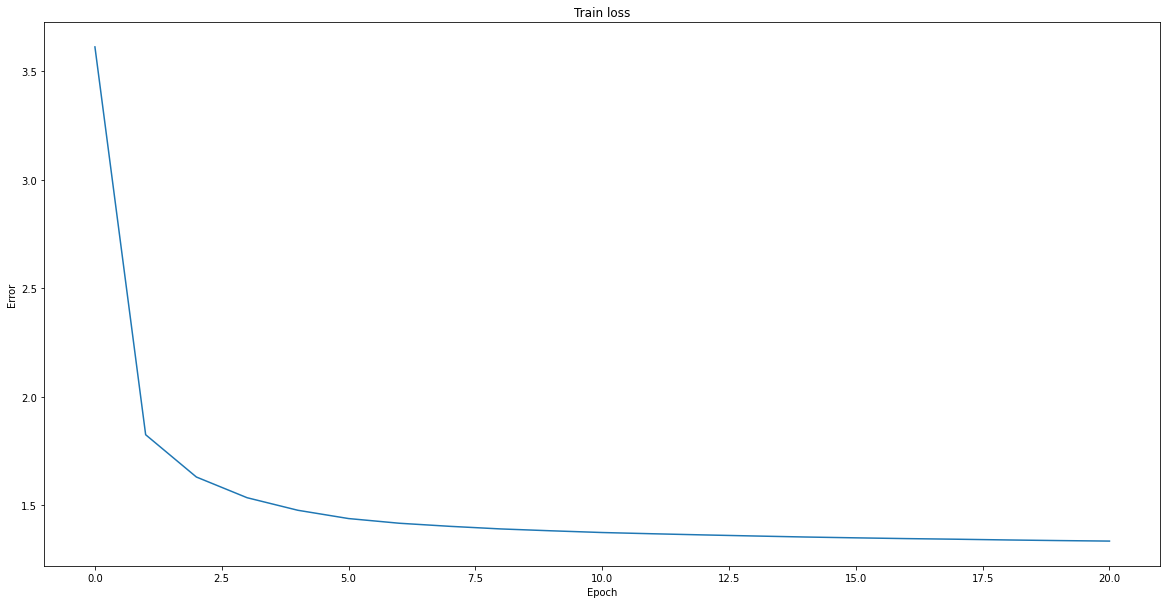

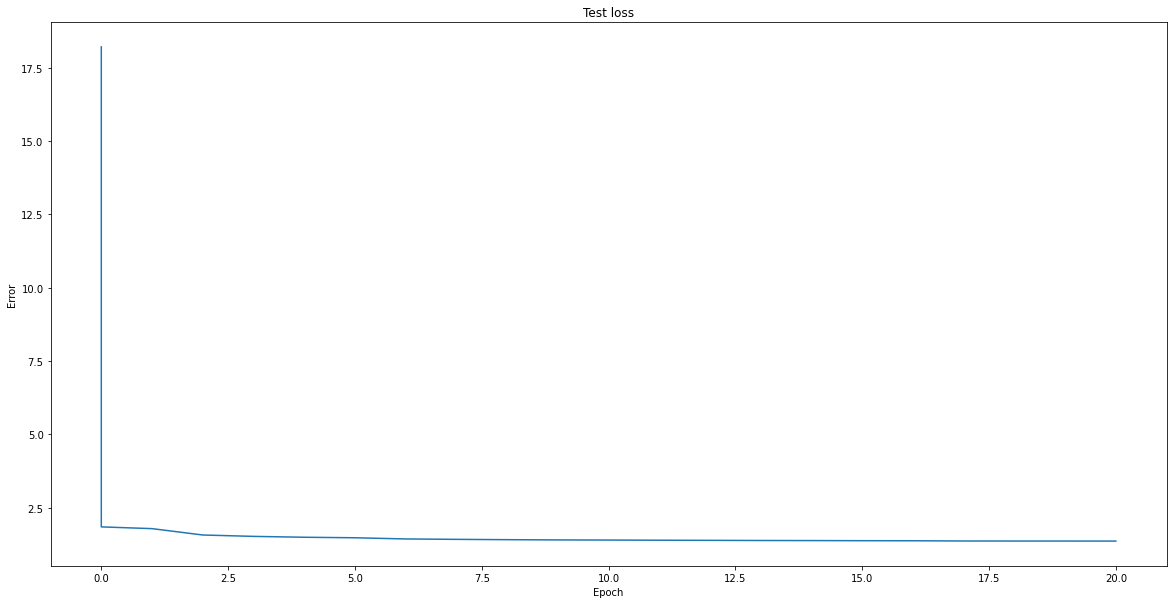

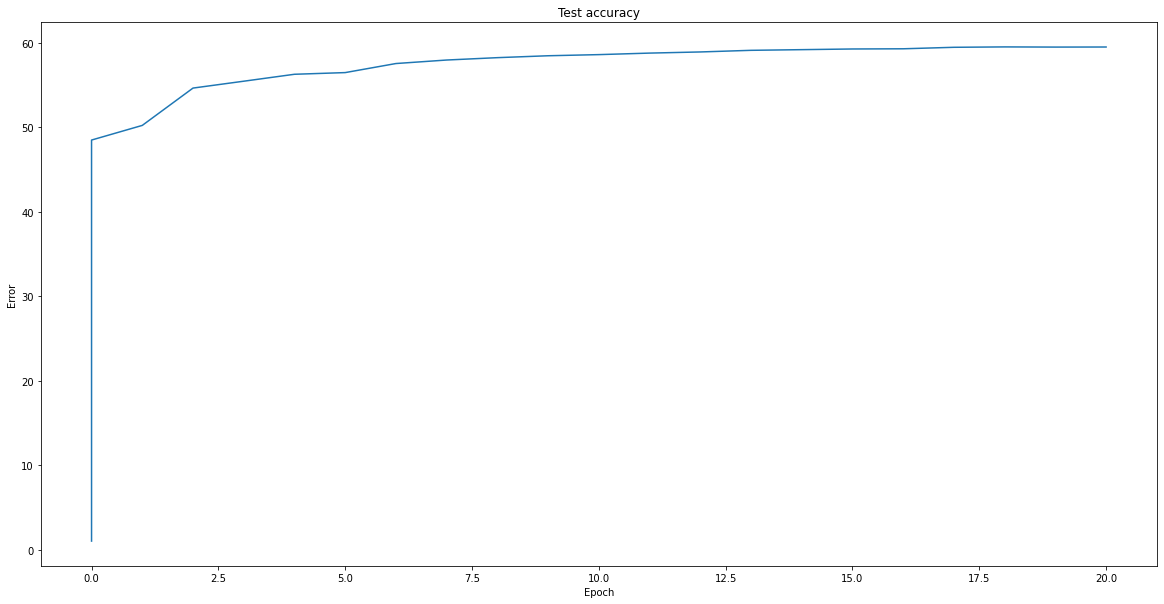

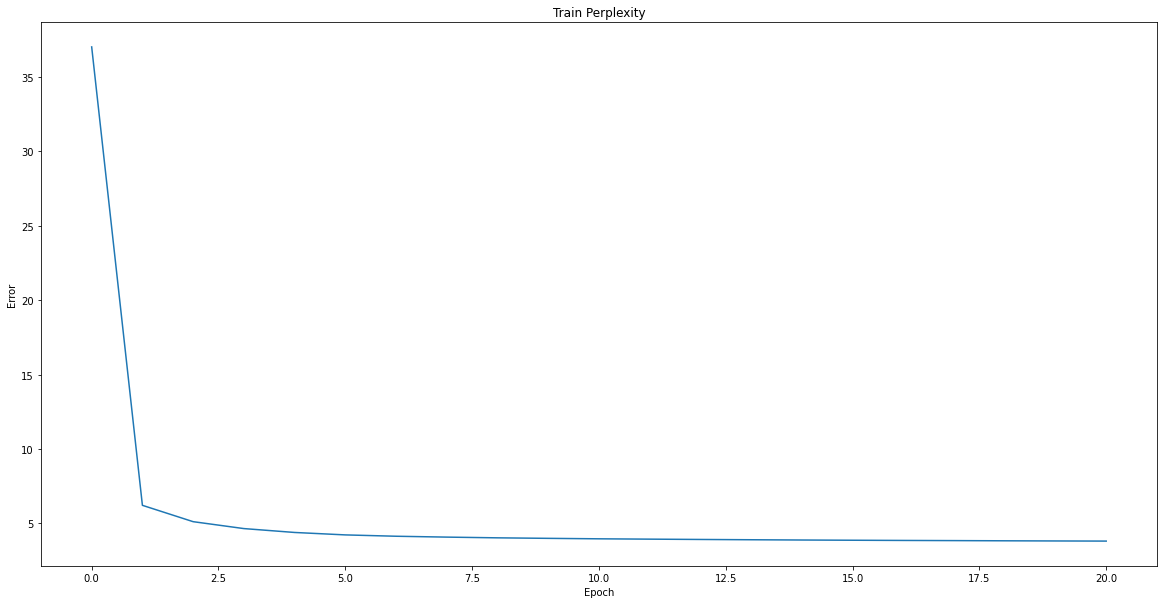

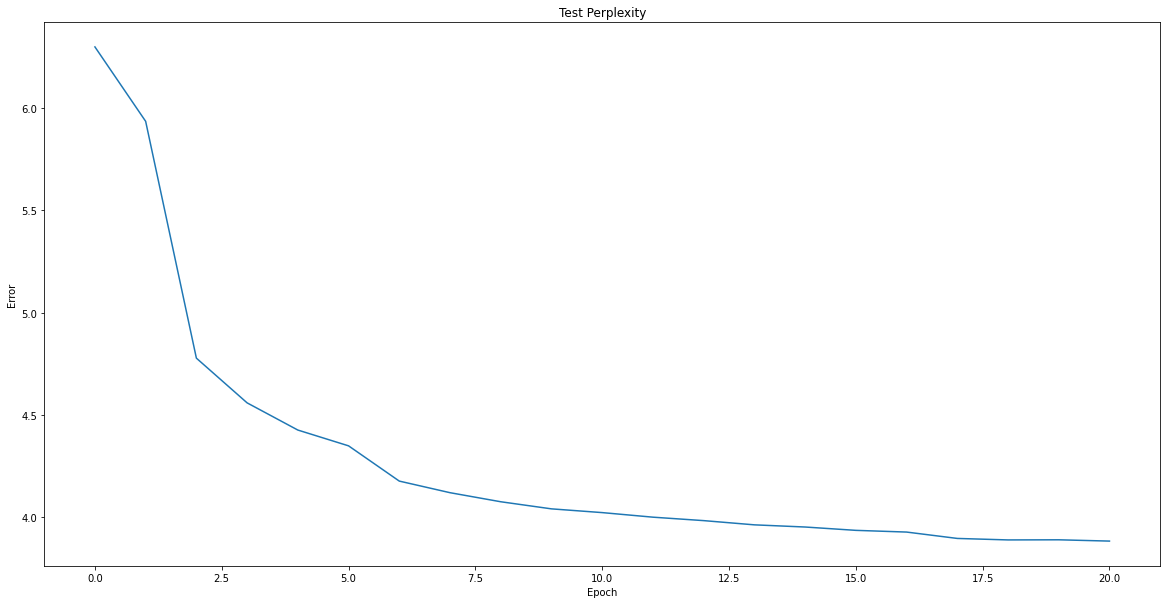

In [12]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    global device
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    # train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    train_losses, test_losses, test_accuracies = [], [], []
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []
    # test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [13]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the train to his for the stairs and the stairs and the stairs and the stairs was still standing at the top of the train and the train to his for the stairs and the stairs and the stairs was still standin
generated with sample	 Harry Potter and the thir! he stood pulling into the holding with high two door was the gol from a propped chair was than hours to say up their thrainry off him worse, a small side book a head as he said, looking up at b
generated with sample	 Harry Potter and the robes things. "Alf you can it Ron id," dare one to the Glpbying forts the shock. "I takin yom mind of some time to know you lupt in him -- sure Why had a long time if he ;ought he really go to the mo
generated with sample	 Harry Potter and the other seize Harry stated on the doorage arm.  "Fittle toot at Ron, I sucked Harry," "Nob-. his dire, bit have -- brilled'ye Dursturn cage." "Yell. I4m s'reaks to the Detenste, that that I tope it How
generated with sample	 Harr

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



## Part 8.1. Train on a different text corpus.

In [21]:
import math


class GameOfThroneDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(GameOfThroneDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # DONE: Any preprocessing on the data to get it to the right shape.
        self.tokens = dataset['tokens']
        print("length of tokens:", len(self.tokens))
        if len(self.tokens) % self.batch_size > 0:
            self.tokens = self.tokens[:(len(self.tokens) // self.batch_size) * self.batch_size]

        n_tokens_in_chunk = len(self.tokens) // self.batch_size
        self.num_unique_seq = self.batch_size * math.ceil((float)(n_tokens_in_chunk - 1) / self.sequence_length)

        self.dataset = []
        for i in range(0, self.num_unique_seq // self.batch_size):
            for batch in range(self.batch_size):
                seq = []
                for char in range(self.sequence_length + 1):
                    idx = batch * n_tokens_in_chunk + i * self.sequence_length + char
                    if idx < (batch + 1) * n_tokens_in_chunk:
                        seq.append(self.tokens[idx])
                self.dataset.append(seq)



    def __len__(self):
        # DONE return the number of unique sequences you have, not the number of characters.
         return self.num_unique_seq
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        
        # DONE
        return torch.LongTensor(self.dataset[idx][:-1]), torch.LongTensor(self.dataset[idx][1:])

    def vocab_size(self):
        return len(self.vocab)


def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # DONE Add more preprocessing
    data = re.sub(r"[\n\t\s]", " ", data)

    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    cnt = 0
    text = []
    for char in data:
        if char in voc2ind:
            pass
        else:
            voc2ind[char] = cnt
            cnt += 1
        text.append(voc2ind[char])

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = text[:(int)(len(text) * 0.8)]
    test_text = text[(int)(len(text) * 0.8):]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'gameofthrones_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'gameofthrones_chars_train_chars_test.pkl', 'wb'))
    
prepare_data(BASE_PATH + 'gameofthrones.txt')

length of tokens: 9059718
length of tokens: 2264930
Using device cuda
num workers: 2
Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	UU,pf!Gfêê,8)Z8U8p88p;{,,22,”,”,DD?DDZU}]/dU”?,sD]],,2-?!8êê}Qp,,8êêpl-?D,êê,!!U}(U!--8p8ê,—}V;{---ê


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	é”ê-?D,w}V/dmê}(u-?m,ê!!-pp2mDUU}p(U}Q;{-(u-?m,ê}Qé-22,8f,,ê}-méU———!,n,}ê{?DDDUn,,,8!!!!———Q!PéUL8ê


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	}}!UU{m!!V!{l}-‘pk/f,Q,,,]m,U,pUV//ê,,,8ê---———,3--?D,w,,//,,

  0%|          | 0/354 [00:00<?, ?it/s]


Test set: Average loss: 17.3499, Accuracy: 7875/2278400 (0%), Perplexity: 34275376.973821



  0%|          | 1/354 [00:00<00:55,  6.40it/s]

Train Epoch: 0 [0/90624 (0%)]	Loss: 17.314438	Perplexity: 33079948.332096


  4%|▎         | 13/354 [00:01<00:30, 11.28it/s]

Train Epoch: 0 [2560/90624 (3%)]	Loss: 12.689781	Perplexity: 68281733.178463


  6%|▋         | 23/354 [00:01<00:26, 12.43it/s]

Train Epoch: 0 [5120/90624 (6%)]	Loss: 5.916190	Perplexity: 598907.635215


  9%|▉         | 33/354 [00:02<00:29, 10.93it/s]

Train Epoch: 0 [7680/90624 (8%)]	Loss: 3.850788	Perplexity: 36667.788281


 12%|█▏        | 43/354 [00:03<00:25, 12.11it/s]

Train Epoch: 0 [10240/90624 (11%)]	Loss: 2.927756	Perplexity: 6290.683430


 15%|█▍        | 53/354 [00:04<00:24, 12.33it/s]

Train Epoch: 0 [12800/90624 (14%)]	Loss: 3.071011	Perplexity: 2015.776516


 18%|█▊        | 63/354 [00:05<00:23, 12.55it/s]

Train Epoch: 0 [15360/90624 (17%)]	Loss: 2.739453	Perplexity: 920.688729


 21%|██        | 73/354 [00:06<00:22, 12.61it/s]

Train Epoch: 0 [17920/90624 (20%)]	Loss: 3.138938	Perplexity: 564.349687


 23%|██▎       | 83/354 [00:06<00:21, 12.41it/s]

Train Epoch: 0 [20480/90624 (23%)]	Loss: 2.566461	Perplexity: 367.601230


 26%|██▋       | 93/354 [00:07<00:20, 12.44it/s]

Train Epoch: 0 [23040/90624 (25%)]	Loss: 2.268662	Perplexity: 249.688508


 29%|██▉       | 103/354 [00:08<00:20, 12.41it/s]

Train Epoch: 0 [25600/90624 (28%)]	Loss: 2.143890	Perplexity: 179.794132


 32%|███▏      | 113/354 [00:09<00:19, 12.35it/s]

Train Epoch: 0 [28160/90624 (31%)]	Loss: 3.045912	Perplexity: 139.723211


 35%|███▍      | 123/354 [00:10<00:18, 12.35it/s]

Train Epoch: 0 [30720/90624 (34%)]	Loss: 2.940346	Perplexity: 118.269612


 38%|███▊      | 133/354 [00:10<00:17, 12.39it/s]

Train Epoch: 0 [33280/90624 (37%)]	Loss: 2.230134	Perplexity: 98.789602


 40%|████      | 143/354 [00:11<00:16, 12.42it/s]

Train Epoch: 0 [35840/90624 (40%)]	Loss: 2.026091	Perplexity: 82.889076


 43%|████▎     | 153/354 [00:12<00:16, 12.40it/s]

Train Epoch: 0 [38400/90624 (42%)]	Loss: 1.943368	Perplexity: 70.509513


 46%|████▌     | 163/354 [00:13<00:15, 12.36it/s]

Train Epoch: 0 [40960/90624 (45%)]	Loss: 1.931092	Perplexity: 61.018745


 49%|████▉     | 173/354 [00:14<00:14, 12.32it/s]

Train Epoch: 0 [43520/90624 (48%)]	Loss: 2.072127	Perplexity: 53.693804


 52%|█████▏    | 183/354 [00:14<00:13, 12.34it/s]

Train Epoch: 0 [46080/90624 (51%)]	Loss: 2.430104	Perplexity: 48.747840


 55%|█████▍    | 193/354 [00:15<00:12, 12.39it/s]

Train Epoch: 0 [48640/90624 (54%)]	Loss: 2.239152	Perplexity: 45.028421


 57%|█████▋    | 203/354 [00:16<00:12, 12.36it/s]

Train Epoch: 0 [51200/90624 (56%)]	Loss: 2.063186	Perplexity: 41.441654


 60%|██████    | 213/354 [00:17<00:11, 12.33it/s]

Train Epoch: 0 [53760/90624 (59%)]	Loss: 2.051443	Perplexity: 38.343629


 63%|██████▎   | 223/354 [00:18<00:10, 12.26it/s]

Train Epoch: 0 [56320/90624 (62%)]	Loss: 2.004086	Perplexity: 35.636315


 66%|██████▌   | 233/354 [00:18<00:09, 12.30it/s]

Train Epoch: 0 [58880/90624 (65%)]	Loss: 1.890358	Perplexity: 33.214677


 69%|██████▊   | 243/354 [00:19<00:08, 12.37it/s]

Train Epoch: 0 [61440/90624 (68%)]	Loss: 1.829266	Perplexity: 31.004884


 71%|███████▏  | 253/354 [00:20<00:08, 12.32it/s]

Train Epoch: 0 [64000/90624 (71%)]	Loss: 1.776584	Perplexity: 29.040541


 74%|███████▍  | 263/354 [00:21<00:07, 12.28it/s]

Train Epoch: 0 [66560/90624 (73%)]	Loss: 1.778270	Perplexity: 27.315011


 77%|███████▋  | 273/354 [00:22<00:06, 12.26it/s]

Train Epoch: 0 [69120/90624 (76%)]	Loss: 1.776496	Perplexity: 25.817207


 80%|███████▉  | 283/354 [00:23<00:05, 12.43it/s]

Train Epoch: 0 [71680/90624 (79%)]	Loss: 1.790158	Perplexity: 24.498193


 83%|████████▎ | 293/354 [00:23<00:04, 12.31it/s]

Train Epoch: 0 [74240/90624 (82%)]	Loss: 1.933005	Perplexity: 23.381929


 86%|████████▌ | 303/354 [00:24<00:04, 12.27it/s]

Train Epoch: 0 [76800/90624 (85%)]	Loss: 1.817561	Perplexity: 22.421517


 88%|████████▊ | 313/354 [00:25<00:03, 12.22it/s]

Train Epoch: 0 [79360/90624 (88%)]	Loss: 2.019727	Perplexity: 21.576705


 91%|█████████ | 323/354 [00:26<00:02, 12.36it/s]

Train Epoch: 0 [81920/90624 (90%)]	Loss: 2.339453	Perplexity: 21.115285


 94%|█████████▍| 333/354 [00:27<00:01, 12.32it/s]

Train Epoch: 0 [84480/90624 (93%)]	Loss: 1.975834	Perplexity: 20.545233


 97%|█████████▋| 343/354 [00:27<00:00, 12.32it/s]

Train Epoch: 0 [87040/90624 (96%)]	Loss: 1.844577	Perplexity: 19.867658


100%|█████████▉| 353/354 [00:28<00:00, 12.34it/s]

Train Epoch: 0 [89600/90624 (99%)]	Loss: 1.791476	Perplexity: 19.210578


100%|██████████| 354/354 [00:28<00:00, 12.29it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tuaenl. Soete  tes gt tvdhng toegher  ar y ttrrddg tn tes htnn on hf the htall of tt.tas tnout th te


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g toe somlse tf the sollearer down tnn on the tarntein   Thess  he ieded the r honcaatl de tn n tnew


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od wtarlld tor lrd  “Iye e hey ,d te d ,wh teest the lallednd teodg toa oisdth dhe derer hing’om , T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey the looks vaes, years, a swed threet, the did toned mon look their heldespered of counder. He was thre lided will deidlught.  “I hisy, whey god-siderd, her voice a deady for hearmst the names, can ja



  1%|          | 2/354 [00:00<01:05,  5.40it/s]

Train Epoch: 1 [0/90624 (0%)]	Loss: 1.748107	Perplexity: 5.743722


  3%|▎         | 12/354 [00:01<00:33, 10.14it/s]

Train Epoch: 1 [2560/90624 (3%)]	Loss: 1.713976	Perplexity: 5.660635


  6%|▌         | 22/354 [00:01<00:27, 11.86it/s]

Train Epoch: 1 [5120/90624 (6%)]	Loss: 1.810371	Perplexity: 5.771522


  9%|▉         | 32/354 [00:02<00:30, 10.58it/s]

Train Epoch: 1 [7680/90624 (8%)]	Loss: 1.740150	Perplexity: 5.775186


 12%|█▏        | 42/354 [00:03<00:25, 12.01it/s]

Train Epoch: 1 [10240/90624 (11%)]	Loss: 1.735854	Perplexity: 5.850861


 15%|█▍        | 52/354 [00:04<00:24, 12.21it/s]

Train Epoch: 1 [12800/90624 (14%)]	Loss: 1.726769	Perplexity: 5.854941


 18%|█▊        | 62/354 [00:05<00:23, 12.23it/s]

Train Epoch: 1 [15360/90624 (17%)]	Loss: 1.691123	Perplexity: 5.798717


 20%|██        | 72/354 [00:06<00:22, 12.28it/s]

Train Epoch: 1 [17920/90624 (20%)]	Loss: 1.665313	Perplexity: 5.733701


 23%|██▎       | 82/354 [00:06<00:22, 12.33it/s]

Train Epoch: 1 [20480/90624 (23%)]	Loss: 1.665335	Perplexity: 5.702466


 26%|██▌       | 92/354 [00:07<00:21, 12.31it/s]

Train Epoch: 1 [23040/90624 (25%)]	Loss: 1.656991	Perplexity: 5.658414


 29%|██▉       | 102/354 [00:08<00:20, 12.40it/s]

Train Epoch: 1 [25600/90624 (28%)]	Loss: 1.668885	Perplexity: 5.636482


 32%|███▏      | 112/354 [00:09<00:19, 12.35it/s]

Train Epoch: 1 [28160/90624 (31%)]	Loss: 1.748740	Perplexity: 5.632290


 34%|███▍      | 122/354 [00:10<00:18, 12.36it/s]

Train Epoch: 1 [30720/90624 (34%)]	Loss: 1.696049	Perplexity: 5.627350


 37%|███▋      | 132/354 [00:10<00:18, 12.32it/s]

Train Epoch: 1 [33280/90624 (37%)]	Loss: 1.785174	Perplexity: 5.649000


 40%|████      | 142/354 [00:11<00:17, 12.31it/s]

Train Epoch: 1 [35840/90624 (40%)]	Loss: 1.685818	Perplexity: 5.646212


 43%|████▎     | 152/354 [00:12<00:16, 12.35it/s]

Train Epoch: 1 [38400/90624 (42%)]	Loss: 1.662009	Perplexity: 5.622950


 46%|████▌     | 162/354 [00:13<00:15, 12.33it/s]

Train Epoch: 1 [40960/90624 (45%)]	Loss: 1.632135	Perplexity: 5.590285


 49%|████▊     | 172/354 [00:14<00:14, 12.33it/s]

Train Epoch: 1 [43520/90624 (48%)]	Loss: 1.652025	Perplexity: 5.559583


 51%|█████▏    | 182/354 [00:15<00:13, 12.32it/s]

Train Epoch: 1 [46080/90624 (51%)]	Loss: 1.673387	Perplexity: 5.541558


 54%|█████▍    | 192/354 [00:15<00:13, 12.36it/s]

Train Epoch: 1 [48640/90624 (54%)]	Loss: 1.675140	Perplexity: 5.549313


 57%|█████▋    | 202/354 [00:16<00:12, 12.28it/s]

Train Epoch: 1 [51200/90624 (56%)]	Loss: 1.628233	Perplexity: 5.542283


 60%|█████▉    | 212/354 [00:17<00:11, 12.25it/s]

Train Epoch: 1 [53760/90624 (59%)]	Loss: 1.625548	Perplexity: 5.521502


 63%|██████▎   | 222/354 [00:18<00:10, 12.34it/s]

Train Epoch: 1 [56320/90624 (62%)]	Loss: 1.618916	Perplexity: 5.502178


 66%|██████▌   | 232/354 [00:19<00:09, 12.35it/s]

Train Epoch: 1 [58880/90624 (65%)]	Loss: 1.613641	Perplexity: 5.480404


 68%|██████▊   | 242/354 [00:19<00:09, 12.27it/s]

Train Epoch: 1 [61440/90624 (68%)]	Loss: 1.607814	Perplexity: 5.458171


 71%|███████   | 252/354 [00:20<00:08, 12.39it/s]

Train Epoch: 1 [64000/90624 (71%)]	Loss: 1.585138	Perplexity: 5.435214


 74%|███████▍  | 262/354 [00:21<00:07, 12.28it/s]

Train Epoch: 1 [66560/90624 (73%)]	Loss: 1.607784	Perplexity: 5.412744


 77%|███████▋  | 272/354 [00:22<00:06, 12.33it/s]

Train Epoch: 1 [69120/90624 (76%)]	Loss: 1.586051	Perplexity: 5.393116


 80%|███████▉  | 282/354 [00:23<00:05, 12.36it/s]

Train Epoch: 1 [71680/90624 (79%)]	Loss: 1.603054	Perplexity: 5.376026


 82%|████████▏ | 292/354 [00:23<00:05, 12.30it/s]

Train Epoch: 1 [74240/90624 (82%)]	Loss: 1.613036	Perplexity: 5.363898


 85%|████████▌ | 302/354 [00:24<00:04, 12.37it/s]

Train Epoch: 1 [76800/90624 (85%)]	Loss: 1.555653	Perplexity: 5.347047


 88%|████████▊ | 312/354 [00:25<00:03, 12.30it/s]

Train Epoch: 1 [79360/90624 (88%)]	Loss: 1.582643	Perplexity: 5.328975


 91%|█████████ | 322/354 [00:26<00:02, 12.30it/s]

Train Epoch: 1 [81920/90624 (90%)]	Loss: 1.576648	Perplexity: 5.313438


 94%|█████████▍| 332/354 [00:27<00:01, 12.34it/s]

Train Epoch: 1 [84480/90624 (93%)]	Loss: 1.618472	Perplexity: 5.299814


 97%|█████████▋| 342/354 [00:28<00:00, 12.32it/s]

Train Epoch: 1 [87040/90624 (96%)]	Loss: 1.859933	Perplexity: 5.300802


 99%|█████████▉| 352/354 [00:28<00:00, 12.31it/s]

Train Epoch: 1 [89600/90624 (99%)]	Loss: 1.675129	Perplexity: 5.308173


100%|██████████| 354/354 [00:29<00:00, 12.19it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	hua rde  eete  wes ’t svchog hoether  an y waardog an hes hwnnlon wt she seall sf sn.was anout oh sa


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g woe somlne of she sorl arer oown ont of the sarntains   heun  we ieded whe r solssitl be sn n tnes


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od seaased hor ard   Iyy e wey er haan ewo seias ohe sall ond seodg aoa oisdao dhe serer sing oms, I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey sworder and sonce fladied his swetch on, eith fear on had half aswyck, its and smallieding her oped by him. The had head.  She would hage it, but had strrong somelieson with had pyrion had on his sai



  1%|          | 3/354 [00:00<01:03,  5.53it/s]

Train Epoch: 2 [0/90624 (0%)]	Loss: 1.645051	Perplexity: 5.181275


  4%|▎         | 13/354 [00:01<00:33, 10.16it/s]

Train Epoch: 2 [2560/90624 (3%)]	Loss: 1.580438	Perplexity: 4.995335


  6%|▋         | 23/354 [00:02<00:27, 11.91it/s]

Train Epoch: 2 [5120/90624 (6%)]	Loss: 1.590617	Perplexity: 4.939030


  9%|▉         | 33/354 [00:02<00:28, 11.35it/s]

Train Epoch: 2 [7680/90624 (8%)]	Loss: 1.583912	Perplexity: 4.933934


 12%|█▏        | 43/354 [00:03<00:25, 12.14it/s]

Train Epoch: 2 [10240/90624 (11%)]	Loss: 1.585486	Perplexity: 4.932330


 15%|█▍        | 53/354 [00:04<00:24, 12.32it/s]

Train Epoch: 2 [12800/90624 (14%)]	Loss: 1.575938	Perplexity: 4.923555


 18%|█▊        | 63/354 [00:05<00:23, 12.32it/s]

Train Epoch: 2 [15360/90624 (17%)]	Loss: 1.574372	Perplexity: 4.899965


 21%|██        | 73/354 [00:06<00:22, 12.28it/s]

Train Epoch: 2 [17920/90624 (20%)]	Loss: 1.551763	Perplexity: 4.882854


 23%|██▎       | 83/354 [00:06<00:21, 12.36it/s]

Train Epoch: 2 [20480/90624 (23%)]	Loss: 1.556767	Perplexity: 4.870334


 26%|██▋       | 93/354 [00:07<00:21, 12.29it/s]

Train Epoch: 2 [23040/90624 (25%)]	Loss: 1.553147	Perplexity: 4.856252


 29%|██▉       | 103/354 [00:08<00:20, 12.35it/s]

Train Epoch: 2 [25600/90624 (28%)]	Loss: 1.521583	Perplexity: 4.836639


 32%|███▏      | 113/354 [00:09<00:19, 12.28it/s]

Train Epoch: 2 [28160/90624 (31%)]	Loss: 1.546156	Perplexity: 4.818807


 35%|███▍      | 123/354 [00:10<00:18, 12.28it/s]

Train Epoch: 2 [30720/90624 (34%)]	Loss: 1.567290	Perplexity: 4.812101


 38%|███▊      | 133/354 [00:11<00:17, 12.29it/s]

Train Epoch: 2 [33280/90624 (37%)]	Loss: 1.589569	Perplexity: 4.813591


 40%|████      | 143/354 [00:11<00:17, 12.36it/s]

Train Epoch: 2 [35840/90624 (40%)]	Loss: 1.564993	Perplexity: 4.815318


 43%|████▎     | 153/354 [00:12<00:16, 12.33it/s]

Train Epoch: 2 [38400/90624 (42%)]	Loss: 1.543262	Perplexity: 4.808887


 46%|████▌     | 163/354 [00:13<00:15, 12.33it/s]

Train Epoch: 2 [40960/90624 (45%)]	Loss: 1.519449	Perplexity: 4.796612


 49%|████▉     | 173/354 [00:14<00:14, 12.36it/s]

Train Epoch: 2 [43520/90624 (48%)]	Loss: 1.532246	Perplexity: 4.783145


 52%|█████▏    | 183/354 [00:15<00:13, 12.36it/s]

Train Epoch: 2 [46080/90624 (51%)]	Loss: 1.549495	Perplexity: 4.775254


 55%|█████▍    | 193/354 [00:15<00:13, 12.35it/s]

Train Epoch: 2 [48640/90624 (54%)]	Loss: 1.596124	Perplexity: 4.773277


 57%|█████▋    | 203/354 [00:16<00:12, 12.33it/s]

Train Epoch: 2 [51200/90624 (56%)]	Loss: 1.548710	Perplexity: 4.784312


 60%|██████    | 213/354 [00:17<00:11, 12.28it/s]

Train Epoch: 2 [53760/90624 (59%)]	Loss: 1.567591	Perplexity: 4.786197


 63%|██████▎   | 223/354 [00:18<00:10, 12.34it/s]

Train Epoch: 2 [56320/90624 (62%)]	Loss: 1.543642	Perplexity: 4.783312


 66%|██████▌   | 233/354 [00:19<00:09, 12.37it/s]

Train Epoch: 2 [58880/90624 (65%)]	Loss: 1.535807	Perplexity: 4.779183


 69%|██████▊   | 243/354 [00:19<00:08, 12.36it/s]

Train Epoch: 2 [61440/90624 (68%)]	Loss: 1.530781	Perplexity: 4.772953


 71%|███████▏  | 253/354 [00:20<00:08, 12.29it/s]

Train Epoch: 2 [64000/90624 (71%)]	Loss: 1.522490	Perplexity: 4.763892


 74%|███████▍  | 263/354 [00:21<00:07, 12.34it/s]

Train Epoch: 2 [66560/90624 (73%)]	Loss: 1.544859	Perplexity: 4.757237


 77%|███████▋  | 273/354 [00:22<00:06, 12.33it/s]

Train Epoch: 2 [69120/90624 (76%)]	Loss: 1.537451	Perplexity: 4.752906


 80%|███████▉  | 283/354 [00:23<00:05, 12.31it/s]

Train Epoch: 2 [71680/90624 (79%)]	Loss: 1.519897	Perplexity: 4.748866


 83%|████████▎ | 293/354 [00:24<00:04, 12.29it/s]

Train Epoch: 2 [74240/90624 (82%)]	Loss: 1.539753	Perplexity: 4.744617


 86%|████████▌ | 303/354 [00:24<00:04, 12.01it/s]

Train Epoch: 2 [76800/90624 (85%)]	Loss: 1.482032	Perplexity: 4.736119


 88%|████████▊ | 313/354 [00:25<00:03, 12.22it/s]

Train Epoch: 2 [79360/90624 (88%)]	Loss: 1.500035	Perplexity: 4.726163


 91%|█████████ | 323/354 [00:26<00:02, 12.30it/s]

Train Epoch: 2 [81920/90624 (90%)]	Loss: 1.495900	Perplexity: 4.717869


 94%|█████████▍| 333/354 [00:27<00:01, 12.29it/s]

Train Epoch: 2 [84480/90624 (93%)]	Loss: 1.505496	Perplexity: 4.710109


 97%|█████████▋| 343/354 [00:28<00:00, 12.31it/s]

Train Epoch: 2 [87040/90624 (96%)]	Loss: 1.512579	Perplexity: 4.703179


100%|█████████▉| 353/354 [00:28<00:00, 12.32it/s]

Train Epoch: 2 [89600/90624 (99%)]	Loss: 1.532600	Perplexity: 4.699855


100%|██████████| 354/354 [00:29<00:00, 12.19it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tus rl   oete  wes ’t tvc ng toither  anly toirdog o  hes honn.on wn hhe ooall of tn.wis t out th he


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the brmnte of the borl arer oown ont of the borntain   Iheun  wr iede  the r hoiiiitl be tn n tn s


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od soipsed oor ard   Iyy e woi er hy n  oh beias the lill wnd oeong tod oisdoo dhe btrer hing oms, I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey knight. This hundred lingings howman gleating him on the knight when I closeh, even some. She Town the vighter Pigers knew his whitchor, but murd like a love them, as he petesip, pay hundred by the o



  1%|          | 2/354 [00:00<01:05,  5.37it/s]

Train Epoch: 3 [0/90624 (0%)]	Loss: 1.549975	Perplexity: 4.711351


  3%|▎         | 12/354 [00:01<00:33, 10.10it/s]

Train Epoch: 3 [2560/90624 (3%)]	Loss: 1.519963	Perplexity: 4.644847


  6%|▌         | 22/354 [00:01<00:27, 11.92it/s]

Train Epoch: 3 [5120/90624 (6%)]	Loss: 1.561207	Perplexity: 4.665803


  9%|▉         | 32/354 [00:02<00:29, 11.08it/s]

Train Epoch: 3 [7680/90624 (8%)]	Loss: 1.520525	Perplexity: 4.651756


 12%|█▏        | 42/354 [00:03<00:26, 11.79it/s]

Train Epoch: 3 [10240/90624 (11%)]	Loss: 1.494762	Perplexity: 4.625581


 15%|█▍        | 52/354 [00:04<00:24, 12.18it/s]

Train Epoch: 3 [12800/90624 (14%)]	Loss: 1.496453	Perplexity: 4.596569


 18%|█▊        | 62/354 [00:05<00:23, 12.31it/s]

Train Epoch: 3 [15360/90624 (17%)]	Loss: 1.496820	Perplexity: 4.569979


 20%|██        | 72/354 [00:06<00:22, 12.33it/s]

Train Epoch: 3 [17920/90624 (20%)]	Loss: 1.481581	Perplexity: 4.552212


 23%|██▎       | 82/354 [00:06<00:22, 12.29it/s]

Train Epoch: 3 [20480/90624 (23%)]	Loss: 1.483236	Perplexity: 4.539839


 26%|██▌       | 92/354 [00:07<00:21, 12.34it/s]

Train Epoch: 3 [23040/90624 (25%)]	Loss: 1.483925	Perplexity: 4.527079


 29%|██▉       | 102/354 [00:08<00:20, 12.08it/s]

Train Epoch: 3 [25600/90624 (28%)]	Loss: 1.470610	Perplexity: 4.516669


 32%|███▏      | 112/354 [00:09<00:19, 12.23it/s]

Train Epoch: 3 [28160/90624 (31%)]	Loss: 1.517096	Perplexity: 4.511153


 34%|███▍      | 122/354 [00:10<00:19, 12.06it/s]

Train Epoch: 3 [30720/90624 (34%)]	Loss: 1.517688	Perplexity: 4.517580


 37%|███▋      | 132/354 [00:11<00:18, 12.26it/s]

Train Epoch: 3 [33280/90624 (37%)]	Loss: 1.552833	Perplexity: 4.531170


 40%|████      | 142/354 [00:11<00:17, 12.29it/s]

Train Epoch: 3 [35840/90624 (40%)]	Loss: 1.513792	Perplexity: 4.538385


 43%|████▎     | 152/354 [00:12<00:16, 12.17it/s]

Train Epoch: 3 [38400/90624 (42%)]	Loss: 1.495596	Perplexity: 4.534792


 46%|████▌     | 162/354 [00:13<00:15, 12.27it/s]

Train Epoch: 3 [40960/90624 (45%)]	Loss: 1.475791	Perplexity: 4.527115


 49%|████▊     | 172/354 [00:14<00:15, 12.12it/s]

Train Epoch: 3 [43520/90624 (48%)]	Loss: 1.501240	Perplexity: 4.517881


 51%|█████▏    | 182/354 [00:15<00:14, 12.15it/s]

Train Epoch: 3 [46080/90624 (51%)]	Loss: 1.490659	Perplexity: 4.514056


 54%|█████▍    | 192/354 [00:15<00:13, 12.27it/s]

Train Epoch: 3 [48640/90624 (54%)]	Loss: 1.496572	Perplexity: 4.509975


 57%|█████▋    | 202/354 [00:16<00:12, 12.33it/s]

Train Epoch: 3 [51200/90624 (56%)]	Loss: 1.466192	Perplexity: 4.507616


 60%|█████▉    | 212/354 [00:17<00:11, 12.34it/s]

Train Epoch: 3 [53760/90624 (59%)]	Loss: 1.481407	Perplexity: 4.503795


 63%|██████▎   | 222/354 [00:18<00:10, 12.32it/s]

Train Epoch: 3 [56320/90624 (62%)]	Loss: 1.486596	Perplexity: 4.500778


 66%|██████▌   | 232/354 [00:19<00:09, 12.36it/s]

Train Epoch: 3 [58880/90624 (65%)]	Loss: 1.494033	Perplexity: 4.498422


 68%|██████▊   | 242/354 [00:20<00:09, 12.37it/s]

Train Epoch: 3 [61440/90624 (68%)]	Loss: 1.485180	Perplexity: 4.495194


 71%|███████   | 252/354 [00:20<00:08, 12.14it/s]

Train Epoch: 3 [64000/90624 (71%)]	Loss: 1.481420	Perplexity: 4.490622


 74%|███████▍  | 262/354 [00:21<00:07, 12.00it/s]

Train Epoch: 3 [66560/90624 (73%)]	Loss: 1.483491	Perplexity: 4.486182


 77%|███████▋  | 272/354 [00:22<00:06, 11.94it/s]

Train Epoch: 3 [69120/90624 (76%)]	Loss: 1.466925	Perplexity: 4.480144


 80%|███████▉  | 282/354 [00:23<00:05, 12.21it/s]

Train Epoch: 3 [71680/90624 (79%)]	Loss: 1.462622	Perplexity: 4.475667


 82%|████████▏ | 292/354 [00:24<00:05, 12.13it/s]

Train Epoch: 3 [74240/90624 (82%)]	Loss: 1.494441	Perplexity: 4.472939


 85%|████████▌ | 302/354 [00:25<00:04, 11.97it/s]

Train Epoch: 3 [76800/90624 (85%)]	Loss: 1.444310	Perplexity: 4.468061


 88%|████████▊ | 312/354 [00:25<00:03, 12.25it/s]

Train Epoch: 3 [79360/90624 (88%)]	Loss: 1.469478	Perplexity: 4.462464


 91%|█████████ | 322/354 [00:26<00:02, 12.02it/s]

Train Epoch: 3 [81920/90624 (90%)]	Loss: 1.465303	Perplexity: 4.458606


 94%|█████████▍| 332/354 [00:27<00:01, 12.13it/s]

Train Epoch: 3 [84480/90624 (93%)]	Loss: 1.475409	Perplexity: 4.454969


 97%|█████████▋| 342/354 [00:28<00:00, 12.01it/s]

Train Epoch: 3 [87040/90624 (96%)]	Loss: 1.486172	Perplexity: 4.452152


 99%|█████████▉| 352/354 [00:29<00:00, 11.94it/s]

Train Epoch: 3 [89600/90624 (99%)]	Loss: 1.518114	Perplexity: 4.452923


100%|██████████| 354/354 [00:29<00:00, 12.05it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tus rs, Ieeti  was et tvc ng toether  arly thirtng tt tis honnlos wt hhe btall of tt.was t out th ha


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the bhultesof the borl arer,oiwn tnt of the barntain   Theun  wetieved the r holiiatl be tp n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od stapsed tor ard   Iay e toiber ha n  th meias the lall wsd teong tid oisdth dhe btren hing’oms, T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey’s didngtip. His Prace down the diress. At in thefaire, and he hundristle, he has lifteed. His honor had seen the warned brook when he thought before burn him.  The or was badg at the did the casslp c



  1%|          | 3/354 [00:00<01:02,  5.61it/s]

Train Epoch: 4 [0/90624 (0%)]	Loss: 1.497662	Perplexity: 4.471223


  4%|▎         | 13/354 [00:01<00:33, 10.27it/s]

Train Epoch: 4 [2560/90624 (3%)]	Loss: 1.469638	Perplexity: 4.397553


  6%|▋         | 23/354 [00:02<00:27, 11.95it/s]

Train Epoch: 4 [5120/90624 (6%)]	Loss: 1.477276	Perplexity: 4.382236


  9%|▉         | 33/354 [00:02<00:28, 11.37it/s]

Train Epoch: 4 [7680/90624 (8%)]	Loss: 1.467204	Perplexity: 4.365454


 12%|█▏        | 43/354 [00:03<00:25, 12.07it/s]

Train Epoch: 4 [10240/90624 (11%)]	Loss: 1.459940	Perplexity: 4.364651


 15%|█▍        | 53/354 [00:04<00:24, 12.05it/s]

Train Epoch: 4 [12800/90624 (14%)]	Loss: 1.470079	Perplexity: 4.361739


 18%|█▊        | 63/354 [00:05<00:24, 11.93it/s]

Train Epoch: 4 [15360/90624 (17%)]	Loss: 1.470346	Perplexity: 4.354610


 21%|██        | 73/354 [00:06<00:23, 12.21it/s]

Train Epoch: 4 [17920/90624 (20%)]	Loss: 1.450949	Perplexity: 4.351704


 23%|██▎       | 83/354 [00:07<00:22, 12.02it/s]

Train Epoch: 4 [20480/90624 (23%)]	Loss: 1.467754	Perplexity: 4.352322


 26%|██▋       | 93/354 [00:07<00:21, 12.22it/s]

Train Epoch: 4 [23040/90624 (25%)]	Loss: 1.464428	Perplexity: 4.348917


 29%|██▉       | 103/354 [00:08<00:20, 11.95it/s]

Train Epoch: 4 [25600/90624 (28%)]	Loss: 1.451010	Perplexity: 4.346833


 32%|███▏      | 113/354 [00:09<00:19, 12.26it/s]

Train Epoch: 4 [28160/90624 (31%)]	Loss: 1.466618	Perplexity: 4.342945


 35%|███▍      | 123/354 [00:10<00:19, 12.11it/s]

Train Epoch: 4 [30720/90624 (34%)]	Loss: 1.469871	Perplexity: 4.343984


 38%|███▊      | 133/354 [00:11<00:18, 12.00it/s]

Train Epoch: 4 [33280/90624 (37%)]	Loss: 1.464232	Perplexity: 4.344118


 40%|████      | 143/354 [00:12<00:17, 11.87it/s]

Train Epoch: 4 [35840/90624 (40%)]	Loss: 1.471366	Perplexity: 4.344377


 43%|████▎     | 153/354 [00:12<00:16, 12.08it/s]

Train Epoch: 4 [38400/90624 (42%)]	Loss: 1.466060	Perplexity: 4.344130


 46%|████▌     | 163/354 [00:13<00:15, 12.04it/s]

Train Epoch: 4 [40960/90624 (45%)]	Loss: 1.446039	Perplexity: 4.341203


 49%|████▉     | 173/354 [00:14<00:15, 11.99it/s]

Train Epoch: 4 [43520/90624 (48%)]	Loss: 1.467596	Perplexity: 4.335920


 52%|█████▏    | 183/354 [00:15<00:14, 11.86it/s]

Train Epoch: 4 [46080/90624 (51%)]	Loss: 1.472701	Perplexity: 4.336249


 55%|█████▍    | 193/354 [00:16<00:13, 12.18it/s]

Train Epoch: 4 [48640/90624 (54%)]	Loss: 1.512190	Perplexity: 4.340894


 57%|█████▋    | 203/354 [00:17<00:12, 12.20it/s]

Train Epoch: 4 [51200/90624 (56%)]	Loss: 1.437936	Perplexity: 4.342857


 60%|██████    | 213/354 [00:17<00:11, 12.03it/s]

Train Epoch: 4 [53760/90624 (59%)]	Loss: 1.452312	Perplexity: 4.341760


 63%|██████▎   | 223/354 [00:18<00:11, 11.88it/s]

Train Epoch: 4 [56320/90624 (62%)]	Loss: 1.462746	Perplexity: 4.341261


 66%|██████▌   | 233/354 [00:19<00:09, 12.15it/s]

Train Epoch: 4 [58880/90624 (65%)]	Loss: 1.461772	Perplexity: 4.340957


 69%|██████▊   | 243/354 [00:20<00:09, 12.22it/s]

Train Epoch: 4 [61440/90624 (68%)]	Loss: 1.464038	Perplexity: 4.339701


 71%|███████▏  | 253/354 [00:21<00:08, 11.95it/s]

Train Epoch: 4 [64000/90624 (71%)]	Loss: 1.452289	Perplexity: 4.337478


 74%|███████▍  | 263/354 [00:22<00:07, 11.85it/s]

Train Epoch: 4 [66560/90624 (73%)]	Loss: 1.460892	Perplexity: 4.335214


 77%|███████▋  | 273/354 [00:22<00:06, 12.03it/s]

Train Epoch: 4 [69120/90624 (76%)]	Loss: 1.441417	Perplexity: 4.331240


 80%|███████▉  | 283/354 [00:23<00:06, 11.80it/s]

Train Epoch: 4 [71680/90624 (79%)]	Loss: 1.454854	Perplexity: 4.329371


 83%|████████▎ | 293/354 [00:24<00:05, 11.89it/s]

Train Epoch: 4 [74240/90624 (82%)]	Loss: 1.459871	Perplexity: 4.328226


 86%|████████▌ | 303/354 [00:25<00:04, 11.69it/s]

Train Epoch: 4 [76800/90624 (85%)]	Loss: 1.426653	Perplexity: 4.324879


 88%|████████▊ | 313/354 [00:26<00:03, 11.84it/s]

Train Epoch: 4 [79360/90624 (88%)]	Loss: 1.445276	Perplexity: 4.320881


 91%|█████████ | 323/354 [00:27<00:02, 11.93it/s]

Train Epoch: 4 [81920/90624 (90%)]	Loss: 1.449677	Perplexity: 4.318518


 94%|█████████▍| 333/354 [00:27<00:01, 12.07it/s]

Train Epoch: 4 [84480/90624 (93%)]	Loss: 1.452418	Perplexity: 4.316544


 97%|█████████▋| 343/354 [00:28<00:00, 11.79it/s]

Train Epoch: 4 [87040/90624 (96%)]	Loss: 1.451826	Perplexity: 4.314775


100%|█████████▉| 353/354 [00:29<00:00, 11.82it/s]

Train Epoch: 4 [89600/90624 (99%)]	Loss: 1.465272	Perplexity: 4.314614


100%|██████████| 354/354 [00:29<00:00, 11.91it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tus lse Iaete  was et tvc ng tovther  anly thartng tt tis fwnnlos wf the sealleof tt.was tnout th sa


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the sauntelof the sorl ater,oiwn tnt of the sarntain   Theun  watieved the r hoicaatl be tp n tn s


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od saapsed tor ard  “Iay e toiber oa n  to seoas the mall wnd teong tad oisdoo she stren hing’oms, T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey, and he died May’s he song6bed, the corripgold caced from the oth years of the white canselse.  Ser Rendre will of hold, white massing of the old halph outside is flue’ly. Toming the turned to his Ed



  1%|          | 2/354 [00:00<01:06,  5.25it/s]

Train Epoch: 5 [0/90624 (0%)]	Loss: 1.471137	Perplexity: 4.354182


  3%|▎         | 12/354 [00:01<00:34,  9.98it/s]

Train Epoch: 5 [2560/90624 (3%)]	Loss: 1.440730	Perplexity: 4.272085


  6%|▌         | 22/354 [00:01<00:28, 11.85it/s]

Train Epoch: 5 [5120/90624 (6%)]	Loss: 1.459025	Perplexity: 4.274322


  9%|▉         | 32/354 [00:02<00:28, 11.19it/s]

Train Epoch: 5 [7680/90624 (8%)]	Loss: 1.447985	Perplexity: 4.264510


 12%|█▏        | 42/354 [00:03<00:26, 11.84it/s]

Train Epoch: 5 [10240/90624 (11%)]	Loss: 1.440885	Perplexity: 4.266505


 15%|█▍        | 52/354 [00:04<00:25, 12.05it/s]

Train Epoch: 5 [12800/90624 (14%)]	Loss: 1.451564	Perplexity: 4.266746


 18%|█▊        | 62/354 [00:05<00:24, 12.08it/s]

Train Epoch: 5 [15360/90624 (17%)]	Loss: 1.453334	Perplexity: 4.263683


 20%|██        | 72/354 [00:06<00:23, 12.23it/s]

Train Epoch: 5 [17920/90624 (20%)]	Loss: 1.441851	Perplexity: 4.264767


 23%|██▎       | 82/354 [00:07<00:22, 12.34it/s]

Train Epoch: 5 [20480/90624 (23%)]	Loss: 1.465811	Perplexity: 4.275869


 26%|██▌       | 92/354 [00:07<00:21, 12.35it/s]

Train Epoch: 5 [23040/90624 (25%)]	Loss: 1.442153	Perplexity: 4.277568


 29%|██▉       | 102/354 [00:08<00:20, 12.32it/s]

Train Epoch: 5 [25600/90624 (28%)]	Loss: 1.428658	Perplexity: 4.276230


 32%|███▏      | 112/354 [00:09<00:19, 12.18it/s]

Train Epoch: 5 [28160/90624 (31%)]	Loss: 1.452929	Perplexity: 4.271886


 34%|███▍      | 122/354 [00:10<00:19, 11.99it/s]

Train Epoch: 5 [30720/90624 (34%)]	Loss: 1.443839	Perplexity: 4.267497


 37%|███▋      | 132/354 [00:11<00:18, 12.18it/s]

Train Epoch: 5 [33280/90624 (37%)]	Loss: 1.451769	Perplexity: 4.266586


 40%|████      | 142/354 [00:11<00:17, 11.91it/s]

Train Epoch: 5 [35840/90624 (40%)]	Loss: 1.448963	Perplexity: 4.267811


 43%|████▎     | 152/354 [00:12<00:16, 12.24it/s]

Train Epoch: 5 [38400/90624 (42%)]	Loss: 1.451220	Perplexity: 4.268841


 46%|████▌     | 162/354 [00:13<00:15, 12.14it/s]

Train Epoch: 5 [40960/90624 (45%)]	Loss: 1.432368	Perplexity: 4.265835


 49%|████▊     | 172/354 [00:14<00:15, 11.93it/s]

Train Epoch: 5 [43520/90624 (48%)]	Loss: 1.452314	Perplexity: 4.261276


 51%|█████▏    | 182/354 [00:15<00:14, 11.97it/s]

Train Epoch: 5 [46080/90624 (51%)]	Loss: 1.444168	Perplexity: 4.261293


 54%|█████▍    | 192/354 [00:16<00:13, 12.11it/s]

Train Epoch: 5 [48640/90624 (54%)]	Loss: 1.445163	Perplexity: 4.259817


 57%|█████▋    | 202/354 [00:16<00:12, 11.99it/s]

Train Epoch: 5 [51200/90624 (56%)]	Loss: 1.420773	Perplexity: 4.259427


 60%|█████▉    | 212/354 [00:17<00:11, 12.17it/s]

Train Epoch: 5 [53760/90624 (59%)]	Loss: 1.447459	Perplexity: 4.258949


 63%|██████▎   | 222/354 [00:18<00:11, 11.86it/s]

Train Epoch: 5 [56320/90624 (62%)]	Loss: 1.448083	Perplexity: 4.260134


 66%|██████▌   | 232/354 [00:19<00:10, 11.92it/s]

Train Epoch: 5 [58880/90624 (65%)]	Loss: 1.451920	Perplexity: 4.260942


 68%|██████▊   | 242/354 [00:20<00:09, 12.11it/s]

Train Epoch: 5 [61440/90624 (68%)]	Loss: 1.450197	Perplexity: 4.261341


 71%|███████   | 252/354 [00:21<00:08, 11.97it/s]

Train Epoch: 5 [64000/90624 (71%)]	Loss: 1.434978	Perplexity: 4.260531


 74%|███████▍  | 262/354 [00:21<00:07, 11.94it/s]

Train Epoch: 5 [66560/90624 (73%)]	Loss: 1.445942	Perplexity: 4.258735


 77%|███████▋  | 272/354 [00:22<00:06, 11.91it/s]

Train Epoch: 5 [69120/90624 (76%)]	Loss: 1.432463	Perplexity: 4.255859


 80%|███████▉  | 282/354 [00:23<00:06, 11.94it/s]

Train Epoch: 5 [71680/90624 (79%)]	Loss: 1.431472	Perplexity: 4.254032


 82%|████████▏ | 292/354 [00:24<00:05, 11.79it/s]

Train Epoch: 5 [74240/90624 (82%)]	Loss: 1.446960	Perplexity: 4.252473


 85%|████████▌ | 302/354 [00:25<00:04, 11.95it/s]

Train Epoch: 5 [76800/90624 (85%)]	Loss: 1.408098	Perplexity: 4.249554


 88%|████████▊ | 312/354 [00:26<00:03, 11.87it/s]

Train Epoch: 5 [79360/90624 (88%)]	Loss: 1.432853	Perplexity: 4.245984


 91%|█████████ | 322/354 [00:26<00:02, 11.88it/s]

Train Epoch: 5 [81920/90624 (90%)]	Loss: 1.440512	Perplexity: 4.244455


 94%|█████████▍| 332/354 [00:27<00:01, 12.06it/s]

Train Epoch: 5 [84480/90624 (93%)]	Loss: 1.435941	Perplexity: 4.242831


 97%|█████████▋| 342/354 [00:28<00:01, 11.92it/s]

Train Epoch: 5 [87040/90624 (96%)]	Loss: 1.433970	Perplexity: 4.241164


 99%|█████████▉| 352/354 [00:29<00:00, 11.83it/s]

Train Epoch: 5 [89600/90624 (99%)]	Loss: 1.437946	Perplexity: 4.240641


100%|██████████| 354/354 [00:29<00:00, 11.93it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tus rl  Taete  was et tvc ng toether  snly ahrrtng tt tes fwnnlon wf the sealleof ttswas t out th sa


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the saurte of the sarl ater oown tnt of the sorntain   There  wetieved the r hoicwatl be tp n tn t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od saapsed trr ard  “Iay e toyber ha n  to meoas the sall wnd heong ted oisdoo she serer hing’oms, T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey through of.”  “Sam, He’d Pettle}’s curge a ragger that help as he sewer crossevel.”  Robb princed. The falmed into watch. The smothers was the writtle back one a pench of housed voicefer, each of vos



  1%|          | 2/354 [00:00<01:04,  5.48it/s]

Train Epoch: 6 [0/90624 (0%)]	Loss: 1.453307	Perplexity: 4.277237


  3%|▎         | 12/354 [00:01<00:34,  9.89it/s]

Train Epoch: 6 [2560/90624 (3%)]	Loss: 1.419743	Perplexity: 4.174390


  6%|▌         | 22/354 [00:02<00:28, 11.52it/s]

Train Epoch: 6 [5120/90624 (6%)]	Loss: 1.440519	Perplexity: 4.183094


  9%|▉         | 32/354 [00:02<00:28, 11.11it/s]

Train Epoch: 6 [7680/90624 (8%)]	Loss: 1.433736	Perplexity: 4.182763


 12%|█▏        | 42/354 [00:03<00:26, 11.78it/s]

Train Epoch: 6 [10240/90624 (11%)]	Loss: 1.423285	Perplexity: 4.190117


 15%|█▍        | 52/354 [00:04<00:25, 12.06it/s]

Train Epoch: 6 [12800/90624 (14%)]	Loss: 1.442639	Perplexity: 4.194007


 18%|█▊        | 62/354 [00:05<00:24, 11.90it/s]

Train Epoch: 6 [15360/90624 (17%)]	Loss: 1.438880	Perplexity: 4.192338


 20%|██        | 72/354 [00:06<00:23, 11.89it/s]

Train Epoch: 6 [17920/90624 (20%)]	Loss: 1.421681	Perplexity: 4.193871


 23%|██▎       | 82/354 [00:07<00:22, 11.92it/s]

Train Epoch: 6 [20480/90624 (23%)]	Loss: 1.421087	Perplexity: 4.195413


 26%|██▌       | 92/354 [00:07<00:21, 12.13it/s]

Train Epoch: 6 [23040/90624 (25%)]	Loss: 1.430950	Perplexity: 4.196605


 29%|██▉       | 102/354 [00:08<00:21, 11.86it/s]

Train Epoch: 6 [25600/90624 (28%)]	Loss: 1.414661	Perplexity: 4.198667


 32%|███▏      | 112/354 [00:09<00:20, 11.83it/s]

Train Epoch: 6 [28160/90624 (31%)]	Loss: 1.425412	Perplexity: 4.193853


 34%|███▍      | 122/354 [00:10<00:19, 11.89it/s]

Train Epoch: 6 [30720/90624 (34%)]	Loss: 1.427354	Perplexity: 4.189351


 37%|███▋      | 132/354 [00:11<00:18, 12.05it/s]

Train Epoch: 6 [33280/90624 (37%)]	Loss: 1.434973	Perplexity: 4.189280


 40%|████      | 142/354 [00:12<00:17, 12.02it/s]

Train Epoch: 6 [35840/90624 (40%)]	Loss: 1.440733	Perplexity: 4.191775


 43%|████▎     | 152/354 [00:12<00:17, 11.84it/s]

Train Epoch: 6 [38400/90624 (42%)]	Loss: 1.435605	Perplexity: 4.193348


 46%|████▌     | 162/354 [00:13<00:15, 12.05it/s]

Train Epoch: 6 [40960/90624 (45%)]	Loss: 1.413813	Perplexity: 4.190913


 49%|████▊     | 172/354 [00:14<00:15, 11.76it/s]

Train Epoch: 6 [43520/90624 (48%)]	Loss: 1.434699	Perplexity: 4.187192


 51%|█████▏    | 182/354 [00:15<00:14, 11.92it/s]

Train Epoch: 6 [46080/90624 (51%)]	Loss: 1.432552	Perplexity: 4.187732


 54%|█████▍    | 192/354 [00:16<00:13, 11.82it/s]

Train Epoch: 6 [48640/90624 (54%)]	Loss: 1.428497	Perplexity: 4.186980


 57%|█████▋    | 202/354 [00:17<00:12, 11.84it/s]

Train Epoch: 6 [51200/90624 (56%)]	Loss: 1.409372	Perplexity: 4.186847


 60%|█████▉    | 212/354 [00:17<00:11, 11.98it/s]

Train Epoch: 6 [53760/90624 (59%)]	Loss: 1.425295	Perplexity: 4.186172


 63%|██████▎   | 222/354 [00:18<00:11, 11.77it/s]

Train Epoch: 6 [56320/90624 (62%)]	Loss: 1.431349	Perplexity: 4.186259


 66%|██████▌   | 232/354 [00:19<00:10, 11.93it/s]

Train Epoch: 6 [58880/90624 (65%)]	Loss: 1.438405	Perplexity: 4.187905


 68%|██████▊   | 242/354 [00:20<00:09, 11.79it/s]

Train Epoch: 6 [61440/90624 (68%)]	Loss: 1.443734	Perplexity: 4.190210


 71%|███████   | 252/354 [00:21<00:08, 11.95it/s]

Train Epoch: 6 [64000/90624 (71%)]	Loss: 1.427388	Perplexity: 4.190357


 74%|███████▍  | 262/354 [00:22<00:07, 11.73it/s]

Train Epoch: 6 [66560/90624 (73%)]	Loss: 1.432383	Perplexity: 4.189091


 77%|███████▋  | 272/354 [00:23<00:07, 11.70it/s]

Train Epoch: 6 [69120/90624 (76%)]	Loss: 1.420401	Perplexity: 4.186797


 80%|███████▉  | 282/354 [00:23<00:06, 11.82it/s]

Train Epoch: 6 [71680/90624 (79%)]	Loss: 1.422013	Perplexity: 4.186024


 82%|████████▏ | 292/354 [00:24<00:05, 11.81it/s]

Train Epoch: 6 [74240/90624 (82%)]	Loss: 1.434102	Perplexity: 4.185228


 85%|████████▌ | 302/354 [00:25<00:04, 11.71it/s]

Train Epoch: 6 [76800/90624 (85%)]	Loss: 1.401168	Perplexity: 4.182990


 88%|████████▊ | 312/354 [00:26<00:03, 11.95it/s]

Train Epoch: 6 [79360/90624 (88%)]	Loss: 1.423394	Perplexity: 4.180199


 91%|█████████ | 322/354 [00:27<00:02, 11.80it/s]

Train Epoch: 6 [81920/90624 (90%)]	Loss: 1.427752	Perplexity: 4.179043


 94%|█████████▍| 332/354 [00:28<00:01, 11.64it/s]

Train Epoch: 6 [84480/90624 (93%)]	Loss: 1.426268	Perplexity: 4.177860


 97%|█████████▋| 342/354 [00:28<00:01, 11.87it/s]

Train Epoch: 6 [87040/90624 (96%)]	Loss: 1.424975	Perplexity: 4.176741


 99%|█████████▉| 352/354 [00:29<00:00, 11.78it/s]

Train Epoch: 6 [89600/90624 (99%)]	Loss: 1.426337	Perplexity: 4.176620


100%|██████████| 354/354 [00:30<00:00, 11.79it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tua rl  Taete  has et tvc ng toether  sney aoartng tt tes fwnnlon wf the seallewf ttswas t out th sa


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the saurtesof the sarl ater,ooen tft of the sarntain   Theue  sefieved the r soicwatl be tn n tn t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od stapsed hor ard  “Iaeye toyber ha n  to seoas the sall wnd heong ted oisdoo she serer hing’oms,”T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey known you said. Whour pass between her he’d curple to live horse,” Intif agaids had cled. “Yould hackned a warn ones hair. Maester Ser Maenerya shoulder, b]tarather, Sansa was a woman Brake of me of 



  1%|          | 3/354 [00:00<01:03,  5.55it/s]

Train Epoch: 7 [0/90624 (0%)]	Loss: 1.439134	Perplexity: 4.217041


  4%|▎         | 13/354 [00:01<00:34, 10.02it/s]

Train Epoch: 7 [2560/90624 (3%)]	Loss: 1.406818	Perplexity: 4.117798


  6%|▋         | 23/354 [00:02<00:28, 11.70it/s]

Train Epoch: 7 [5120/90624 (6%)]	Loss: 1.425970	Perplexity: 4.126277


  9%|▉         | 33/354 [00:03<00:28, 11.08it/s]

Train Epoch: 7 [7680/90624 (8%)]	Loss: 1.420976	Perplexity: 4.127066


 12%|█▏        | 43/354 [00:03<00:26, 11.59it/s]

Train Epoch: 7 [10240/90624 (11%)]	Loss: 1.416940	Perplexity: 4.137371


 15%|█▍        | 53/354 [00:04<00:24, 12.13it/s]

Train Epoch: 7 [12800/90624 (14%)]	Loss: 1.430724	Perplexity: 4.143336


 18%|█▊        | 63/354 [00:05<00:24, 11.82it/s]

Train Epoch: 7 [15360/90624 (17%)]	Loss: 1.427177	Perplexity: 4.141346


 21%|██        | 73/354 [00:06<00:23, 11.71it/s]

Train Epoch: 7 [17920/90624 (20%)]	Loss: 1.415027	Perplexity: 4.142256


 23%|██▎       | 83/354 [00:07<00:22, 12.01it/s]

Train Epoch: 7 [20480/90624 (23%)]	Loss: 1.422931	Perplexity: 4.149877


 26%|██▋       | 93/354 [00:08<00:21, 12.07it/s]

Train Epoch: 7 [23040/90624 (25%)]	Loss: 1.414977	Perplexity: 4.147346


 29%|██▉       | 103/354 [00:08<00:21, 11.86it/s]

Train Epoch: 7 [25600/90624 (28%)]	Loss: 1.403428	Perplexity: 4.145596


 32%|███▏      | 113/354 [00:09<00:20, 11.75it/s]

Train Epoch: 7 [28160/90624 (31%)]	Loss: 1.410685	Perplexity: 4.140493


 35%|███▍      | 123/354 [00:10<00:19, 11.90it/s]

Train Epoch: 7 [30720/90624 (34%)]	Loss: 1.415357	Perplexity: 4.135435


 38%|███▊      | 133/354 [00:11<00:18, 11.75it/s]

Train Epoch: 7 [33280/90624 (37%)]	Loss: 1.422476	Perplexity: 4.135743


 40%|████      | 143/354 [00:12<00:17, 11.88it/s]

Train Epoch: 7 [35840/90624 (40%)]	Loss: 1.429376	Perplexity: 4.138907


 43%|████▎     | 153/354 [00:13<00:17, 11.75it/s]

Train Epoch: 7 [38400/90624 (42%)]	Loss: 1.421944	Perplexity: 4.140604


 46%|████▌     | 163/354 [00:13<00:16, 11.81it/s]

Train Epoch: 7 [40960/90624 (45%)]	Loss: 1.401524	Perplexity: 4.138479


 49%|████▉     | 173/354 [00:14<00:15, 11.76it/s]

Train Epoch: 7 [43520/90624 (48%)]	Loss: 1.424996	Perplexity: 4.135359


 52%|█████▏    | 183/354 [00:15<00:14, 11.93it/s]

Train Epoch: 7 [46080/90624 (51%)]	Loss: 1.420232	Perplexity: 4.135950


 55%|█████▍    | 193/354 [00:16<00:13, 11.80it/s]

Train Epoch: 7 [48640/90624 (54%)]	Loss: 1.413538	Perplexity: 4.135015


 57%|█████▋    | 203/354 [00:17<00:12, 11.74it/s]

Train Epoch: 7 [51200/90624 (56%)]	Loss: 1.397425	Perplexity: 4.134896


 60%|██████    | 213/354 [00:18<00:12, 11.73it/s]

Train Epoch: 7 [53760/90624 (59%)]	Loss: 1.412889	Perplexity: 4.134444


 63%|██████▎   | 223/354 [00:19<00:11, 11.71it/s]

Train Epoch: 7 [56320/90624 (62%)]	Loss: 1.417230	Perplexity: 4.134820


 66%|██████▌   | 233/354 [00:19<00:10, 11.83it/s]

Train Epoch: 7 [58880/90624 (65%)]	Loss: 1.425007	Perplexity: 4.136751


 69%|██████▊   | 243/354 [00:20<00:09, 11.73it/s]

Train Epoch: 7 [61440/90624 (68%)]	Loss: 1.425344	Perplexity: 4.137788


 71%|███████▏  | 253/354 [00:21<00:08, 11.73it/s]

Train Epoch: 7 [64000/90624 (71%)]	Loss: 1.413474	Perplexity: 4.137705


 74%|███████▍  | 263/354 [00:22<00:07, 11.69it/s]

Train Epoch: 7 [66560/90624 (73%)]	Loss: 1.423209	Perplexity: 4.137054


 77%|███████▋  | 273/354 [00:23<00:06, 11.59it/s]

Train Epoch: 7 [69120/90624 (76%)]	Loss: 1.410880	Perplexity: 4.135340


 80%|███████▉  | 283/354 [00:24<00:06, 11.68it/s]

Train Epoch: 7 [71680/90624 (79%)]	Loss: 1.414894	Perplexity: 4.135116


 83%|████████▎ | 293/354 [00:24<00:05, 11.74it/s]

Train Epoch: 7 [74240/90624 (82%)]	Loss: 1.424271	Perplexity: 4.134825


 86%|████████▌ | 303/354 [00:25<00:04, 11.88it/s]

Train Epoch: 7 [76800/90624 (85%)]	Loss: 1.390880	Perplexity: 4.132862


 88%|████████▊ | 313/354 [00:26<00:03, 11.76it/s]

Train Epoch: 7 [79360/90624 (88%)]	Loss: 1.412957	Perplexity: 4.130504


 91%|█████████ | 323/354 [00:27<00:02, 11.74it/s]

Train Epoch: 7 [81920/90624 (90%)]	Loss: 1.415403	Perplexity: 4.129660


 94%|█████████▍| 333/354 [00:28<00:01, 11.71it/s]

Train Epoch: 7 [84480/90624 (93%)]	Loss: 1.418897	Perplexity: 4.128852


 97%|█████████▋| 343/354 [00:29<00:00, 11.87it/s]

Train Epoch: 7 [87040/90624 (96%)]	Loss: 1.415300	Perplexity: 4.128036


100%|█████████▉| 353/354 [00:30<00:00, 11.80it/s]

Train Epoch: 7 [89600/90624 (99%)]	Loss: 1.413885	Perplexity: 4.128245


100%|██████████| 354/354 [00:30<00:00, 11.72it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tuaerl  Taete  has et tvc ng toether  sney toirtng tt tes swnnlan tf the seillewf ttswas t out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the samrtesof the sarl ater,ooen tft of the serntain   Theue  setieved the r soicsatl be tn n tn t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od stopped tor ard  “Iayye toyber wa n  to seoat the sall wnd heong ted witdoo she serer hing’oms, T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey from muckle and barried(y laph, bone, but little hair and frienden could rupbring beside him’s to crick spring in his breap suarress, but the khield Baelon was Kindlessly was a voice shin to Serl’s B



  1%|          | 3/354 [00:00<01:02,  5.62it/s]

Train Epoch: 8 [0/90624 (0%)]	Loss: 1.426983	Perplexity: 4.166109


  4%|▎         | 13/354 [00:01<00:33, 10.20it/s]

Train Epoch: 8 [2560/90624 (3%)]	Loss: 1.398164	Perplexity: 4.077895


  6%|▋         | 23/354 [00:02<00:28, 11.71it/s]

Train Epoch: 8 [5120/90624 (6%)]	Loss: 1.417584	Perplexity: 4.090628


  9%|▉         | 33/354 [00:02<00:29, 11.05it/s]

Train Epoch: 8 [7680/90624 (8%)]	Loss: 1.411845	Perplexity: 4.091431


 12%|█▏        | 43/354 [00:03<00:26, 11.75it/s]

Train Epoch: 8 [10240/90624 (11%)]	Loss: 1.405795	Perplexity: 4.099494


 15%|█▍        | 53/354 [00:04<00:25, 11.76it/s]

Train Epoch: 8 [12800/90624 (14%)]	Loss: 1.422494	Perplexity: 4.106088


 18%|█▊        | 63/354 [00:05<00:24, 11.70it/s]

Train Epoch: 8 [15360/90624 (17%)]	Loss: 1.416331	Perplexity: 4.103968


 21%|██        | 73/354 [00:06<00:23, 12.00it/s]

Train Epoch: 8 [17920/90624 (20%)]	Loss: 1.402423	Perplexity: 4.103276


 23%|██▎       | 83/354 [00:07<00:22, 12.09it/s]

Train Epoch: 8 [20480/90624 (23%)]	Loss: 1.400517	Perplexity: 4.102587


 26%|██▋       | 93/354 [00:08<00:21, 11.97it/s]

Train Epoch: 8 [23040/90624 (25%)]	Loss: 1.405044	Perplexity: 4.098969


 29%|██▉       | 103/354 [00:08<00:20, 12.06it/s]

Train Epoch: 8 [25600/90624 (28%)]	Loss: 1.395920	Perplexity: 4.098658


 32%|███▏      | 113/354 [00:09<00:20, 11.76it/s]

Train Epoch: 8 [28160/90624 (31%)]	Loss: 1.402712	Perplexity: 4.094954


 35%|███▍      | 123/354 [00:10<00:19, 11.91it/s]

Train Epoch: 8 [30720/90624 (34%)]	Loss: 1.406786	Perplexity: 4.091229


 38%|███▊      | 133/354 [00:11<00:18, 11.80it/s]

Train Epoch: 8 [33280/90624 (37%)]	Loss: 1.409470	Perplexity: 4.092407


 40%|████      | 143/354 [00:12<00:17, 11.94it/s]

Train Epoch: 8 [35840/90624 (40%)]	Loss: 1.418647	Perplexity: 4.095577


 43%|████▎     | 153/354 [00:13<00:16, 11.95it/s]

Train Epoch: 8 [38400/90624 (42%)]	Loss: 1.414776	Perplexity: 4.097496


 46%|████▌     | 163/354 [00:13<00:16, 11.87it/s]

Train Epoch: 8 [40960/90624 (45%)]	Loss: 1.397084	Perplexity: 4.096057


 49%|████▉     | 173/354 [00:14<00:15, 11.84it/s]

Train Epoch: 8 [43520/90624 (48%)]	Loss: 1.416944	Perplexity: 4.093789


 52%|█████▏    | 183/354 [00:15<00:14, 11.79it/s]

Train Epoch: 8 [46080/90624 (51%)]	Loss: 1.409780	Perplexity: 4.094444


 55%|█████▍    | 193/354 [00:16<00:13, 11.99it/s]

Train Epoch: 8 [48640/90624 (54%)]	Loss: 1.403645	Perplexity: 4.093510


 57%|█████▋    | 203/354 [00:17<00:12, 11.79it/s]

Train Epoch: 8 [51200/90624 (56%)]	Loss: 1.387147	Perplexity: 4.093621


 60%|██████    | 213/354 [00:18<00:11, 11.97it/s]

Train Epoch: 8 [53760/90624 (59%)]	Loss: 1.401345	Perplexity: 4.093329


 63%|██████▎   | 223/354 [00:18<00:11, 11.76it/s]

Train Epoch: 8 [56320/90624 (62%)]	Loss: 1.406706	Perplexity: 4.093814


 66%|██████▌   | 233/354 [00:19<00:10, 11.91it/s]

Train Epoch: 8 [58880/90624 (65%)]	Loss: 1.416241	Perplexity: 4.095625


 69%|██████▊   | 243/354 [00:20<00:09, 11.82it/s]

Train Epoch: 8 [61440/90624 (68%)]	Loss: 1.418987	Perplexity: 4.096951


 71%|███████▏  | 253/354 [00:21<00:08, 11.93it/s]

Train Epoch: 8 [64000/90624 (71%)]	Loss: 1.407595	Perplexity: 4.097387


 74%|███████▍  | 263/354 [00:22<00:07, 11.85it/s]

Train Epoch: 8 [66560/90624 (73%)]	Loss: 1.415728	Perplexity: 4.097151


 77%|███████▋  | 273/354 [00:23<00:06, 11.81it/s]

Train Epoch: 8 [69120/90624 (76%)]	Loss: 1.398932	Perplexity: 4.095529


 80%|███████▉  | 283/354 [00:24<00:06, 11.71it/s]

Train Epoch: 8 [71680/90624 (79%)]	Loss: 1.405202	Perplexity: 4.095310


 83%|████████▎ | 293/354 [00:24<00:05, 11.81it/s]

Train Epoch: 8 [74240/90624 (82%)]	Loss: 1.412524	Perplexity: 4.094985


 86%|████████▌ | 303/354 [00:25<00:04, 11.92it/s]

Train Epoch: 8 [76800/90624 (85%)]	Loss: 1.383275	Perplexity: 4.093240


 88%|████████▊ | 313/354 [00:26<00:03, 11.78it/s]

Train Epoch: 8 [79360/90624 (88%)]	Loss: 1.406309	Perplexity: 4.091268


 91%|█████████ | 323/354 [00:27<00:02, 11.89it/s]

Train Epoch: 8 [81920/90624 (90%)]	Loss: 1.405465	Perplexity: 4.090619


 94%|█████████▍| 333/354 [00:28<00:01, 11.86it/s]

Train Epoch: 8 [84480/90624 (93%)]	Loss: 1.410521	Perplexity: 4.090128


 97%|█████████▋| 343/354 [00:29<00:00, 11.78it/s]

Train Epoch: 8 [87040/90624 (96%)]	Loss: 1.406983	Perplexity: 4.089669


100%|█████████▉| 353/354 [00:29<00:00, 11.76it/s]

Train Epoch: 8 [89600/90624 (99%)]	Loss: 1.408577	Perplexity: 4.090095


100%|██████████| 354/354 [00:30<00:00, 11.76it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	tuaerl  Toete  has ’t tvt ng toether  snly thirtng tt tis swnnlan hf the seillewf ttswas t out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the srmrtesof the sarl ater,ooen tnt of the serntains  Theuen hetieved the r soicsatl be tn n tn t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od stipped tor ard  “Iayye toyber we nt to seoat the sall ond heong ted witdoo she strer hing’oms,”T


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey,” decalled.  “She hungs, until’s belos back does, Joffre, and khaleen, Septo have had lived the epper abount as he wulls, guitled him breast. As Arya wriked toward bad Baester Reskcy. “ISer an Irey c



  1%|          | 3/354 [00:00<01:01,  5.73it/s]

Train Epoch: 9 [0/90624 (0%)]	Loss: 1.418385	Perplexity: 4.130445


  4%|▎         | 13/354 [00:01<00:33, 10.14it/s]

Train Epoch: 9 [2560/90624 (3%)]	Loss: 1.391055	Perplexity: 4.047495


  6%|▋         | 23/354 [00:02<00:28, 11.57it/s]

Train Epoch: 9 [5120/90624 (6%)]	Loss: 1.412897	Perplexity: 4.060471


  9%|▉         | 33/354 [00:02<00:28, 11.17it/s]

Train Epoch: 9 [7680/90624 (8%)]	Loss: 1.404183	Perplexity: 4.060954


 12%|█▏        | 43/354 [00:03<00:26, 11.86it/s]

Train Epoch: 9 [10240/90624 (11%)]	Loss: 1.400570	Perplexity: 4.069442


 15%|█▍        | 53/354 [00:04<00:25, 11.80it/s]

Train Epoch: 9 [12800/90624 (14%)]	Loss: 1.414196	Perplexity: 4.075249


 18%|█▊        | 63/354 [00:05<00:24, 11.95it/s]

Train Epoch: 9 [15360/90624 (17%)]	Loss: 1.402661	Perplexity: 4.072301


 21%|██        | 73/354 [00:06<00:23, 11.95it/s]

Train Epoch: 9 [17920/90624 (20%)]	Loss: 1.392924	Perplexity: 4.070339


 23%|██▎       | 83/354 [00:07<00:22, 12.01it/s]

Train Epoch: 9 [20480/90624 (23%)]	Loss: 1.392884	Perplexity: 4.069027


 26%|██▋       | 93/354 [00:08<00:21, 11.96it/s]

Train Epoch: 9 [23040/90624 (25%)]	Loss: 1.396951	Perplexity: 4.065676


 29%|██▉       | 103/354 [00:08<00:21, 11.79it/s]

Train Epoch: 9 [25600/90624 (28%)]	Loss: 1.389136	Perplexity: 4.065507


 32%|███▏      | 113/354 [00:09<00:20, 11.98it/s]

Train Epoch: 9 [28160/90624 (31%)]	Loss: 1.399027	Perplexity: 4.062599


 35%|███▍      | 123/354 [00:10<00:19, 11.82it/s]

Train Epoch: 9 [30720/90624 (34%)]	Loss: 1.400446	Perplexity: 4.059756


 38%|███▊      | 133/354 [00:11<00:18, 11.88it/s]

Train Epoch: 9 [33280/90624 (37%)]	Loss: 1.402748	Perplexity: 4.061410


 40%|████      | 143/354 [00:12<00:17, 11.84it/s]

Train Epoch: 9 [35840/90624 (40%)]	Loss: 1.416757	Perplexity: 4.065109


 43%|████▎     | 153/354 [00:13<00:17, 11.78it/s]

Train Epoch: 9 [38400/90624 (42%)]	Loss: 1.406074	Perplexity: 4.067149


 46%|████▌     | 163/354 [00:13<00:16, 11.86it/s]

Train Epoch: 9 [40960/90624 (45%)]	Loss: 1.390836	Perplexity: 4.065953


 49%|████▉     | 173/354 [00:14<00:15, 11.81it/s]

Train Epoch: 9 [43520/90624 (48%)]	Loss: 1.407415	Perplexity: 4.063453


 52%|█████▏    | 183/354 [00:15<00:14, 11.83it/s]

Train Epoch: 9 [46080/90624 (51%)]	Loss: 1.401998	Perplexity: 4.064088


 55%|█████▍    | 193/354 [00:16<00:13, 11.89it/s]

Train Epoch: 9 [48640/90624 (54%)]	Loss: 1.396535	Perplexity: 4.063007


 57%|█████▋    | 203/354 [00:17<00:12, 11.78it/s]

Train Epoch: 9 [51200/90624 (56%)]	Loss: 1.378780	Perplexity: 4.063161


 60%|██████    | 213/354 [00:18<00:11, 11.84it/s]

Train Epoch: 9 [53760/90624 (59%)]	Loss: 1.392799	Perplexity: 4.062738


 63%|██████▎   | 223/354 [00:19<00:11, 11.69it/s]

Train Epoch: 9 [56320/90624 (62%)]	Loss: 1.398927	Perplexity: 4.063111


 66%|██████▌   | 233/354 [00:19<00:10, 11.68it/s]

Train Epoch: 9 [58880/90624 (65%)]	Loss: 1.405399	Perplexity: 4.064576


 69%|██████▊   | 243/354 [00:20<00:09, 11.79it/s]

Train Epoch: 9 [61440/90624 (68%)]	Loss: 1.410493	Perplexity: 4.065668


 71%|███████▏  | 253/354 [00:21<00:08, 11.70it/s]

Train Epoch: 9 [64000/90624 (71%)]	Loss: 1.397048	Perplexity: 4.065853


 74%|███████▍  | 263/354 [00:22<00:07, 11.83it/s]

Train Epoch: 9 [66560/90624 (73%)]	Loss: 1.406815	Perplexity: 4.065474


 77%|███████▋  | 273/354 [00:23<00:06, 11.74it/s]

Train Epoch: 9 [69120/90624 (76%)]	Loss: 1.390993	Perplexity: 4.063845


 80%|███████▉  | 283/354 [00:24<00:06, 11.69it/s]

Train Epoch: 9 [71680/90624 (79%)]	Loss: 1.399139	Perplexity: 4.063757


 83%|████████▎ | 293/354 [00:24<00:05, 11.65it/s]

Train Epoch: 9 [74240/90624 (82%)]	Loss: 1.409228	Perplexity: 4.063688


 86%|████████▌ | 303/354 [00:25<00:04, 11.75it/s]

Train Epoch: 9 [76800/90624 (85%)]	Loss: 1.376861	Perplexity: 4.062278


 88%|████████▊ | 313/354 [00:26<00:03, 11.87it/s]

Train Epoch: 9 [79360/90624 (88%)]	Loss: 1.398439	Perplexity: 4.060518


 91%|█████████ | 323/354 [00:27<00:02, 11.91it/s]

Train Epoch: 9 [81920/90624 (90%)]	Loss: 1.398752	Perplexity: 4.059896


 94%|█████████▍| 333/354 [00:28<00:01, 11.76it/s]

Train Epoch: 9 [84480/90624 (93%)]	Loss: 1.404093	Perplexity: 4.059479


 97%|█████████▋| 343/354 [00:29<00:00, 11.84it/s]

Train Epoch: 9 [87040/90624 (96%)]	Loss: 1.401405	Perplexity: 4.059129


100%|█████████▉| 353/354 [00:30<00:00, 11.64it/s]

Train Epoch: 9 [89600/90624 (99%)]	Loss: 1.403194	Perplexity: 4.059610


100%|██████████| 354/354 [00:30<00:00, 11.72it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  has ’t tvt ng toather  bnly thirtng tt tis swnnhan hf the seillewf ttswas t out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the srmrte of the sarl ater,ooen tnt of the serntains  Theuen hetieved the r soicsatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od wtipped tor ard  “Iayye woyber we nt to seiat the sall ond heong ted witdoo she strer hing’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey ggenderled her oat more the Brangers. The barrey slidwered and wailed on homsof dropling to the battle bywings. Ser Joffere seemed to laught down and part her sellsword and man spits to hell druwing 



  1%|          | 2/354 [00:00<01:10,  5.03it/s]

Train Epoch: 10 [0/90624 (0%)]	Loss: 1.411844	Perplexity: 4.103515


  3%|▎         | 12/354 [00:01<00:35,  9.73it/s]

Train Epoch: 10 [2560/90624 (3%)]	Loss: 1.384975	Perplexity: 4.024347


  6%|▌         | 22/354 [00:02<00:29, 11.40it/s]

Train Epoch: 10 [5120/90624 (6%)]	Loss: 1.407027	Perplexity: 4.036402


  9%|▉         | 32/354 [00:03<00:30, 10.50it/s]

Train Epoch: 10 [7680/90624 (8%)]	Loss: 1.397428	Perplexity: 4.037458


 12%|█▏        | 42/354 [00:03<00:27, 11.53it/s]

Train Epoch: 10 [10240/90624 (11%)]	Loss: 1.393812	Perplexity: 4.046185


 15%|█▍        | 52/354 [00:04<00:25, 11.78it/s]

Train Epoch: 10 [12800/90624 (14%)]	Loss: 1.409110	Perplexity: 4.051542


 18%|█▊        | 62/354 [00:05<00:24, 11.85it/s]

Train Epoch: 10 [15360/90624 (17%)]	Loss: 1.397276	Perplexity: 4.048559


 20%|██        | 72/354 [00:06<00:24, 11.74it/s]

Train Epoch: 10 [17920/90624 (20%)]	Loss: 1.387692	Perplexity: 4.047082


 23%|██▎       | 82/354 [00:07<00:23, 11.75it/s]

Train Epoch: 10 [20480/90624 (23%)]	Loss: 1.388043	Perplexity: 4.045921


 26%|██▌       | 92/354 [00:08<00:22, 11.83it/s]

Train Epoch: 10 [23040/90624 (25%)]	Loss: 1.391158	Perplexity: 4.042250


 29%|██▉       | 102/354 [00:08<00:21, 11.91it/s]

Train Epoch: 10 [25600/90624 (28%)]	Loss: 1.381207	Perplexity: 4.042018


 32%|███▏      | 112/354 [00:09<00:20, 11.86it/s]

Train Epoch: 10 [28160/90624 (31%)]	Loss: 1.394789	Perplexity: 4.039536


 34%|███▍      | 122/354 [00:10<00:19, 11.66it/s]

Train Epoch: 10 [30720/90624 (34%)]	Loss: 1.397909	Perplexity: 4.037350


 37%|███▋      | 132/354 [00:11<00:18, 11.86it/s]

Train Epoch: 10 [33280/90624 (37%)]	Loss: 1.400009	Perplexity: 4.039392


 40%|████      | 142/354 [00:12<00:17, 11.79it/s]

Train Epoch: 10 [35840/90624 (40%)]	Loss: 1.411240	Perplexity: 4.043159


 43%|████▎     | 152/354 [00:13<00:17, 11.69it/s]

Train Epoch: 10 [38400/90624 (42%)]	Loss: 1.401273	Perplexity: 4.045164


 46%|████▌     | 162/354 [00:14<00:16, 11.67it/s]

Train Epoch: 10 [40960/90624 (45%)]	Loss: 1.381933	Perplexity: 4.043828


 49%|████▊     | 172/354 [00:14<00:15, 11.80it/s]

Train Epoch: 10 [43520/90624 (48%)]	Loss: 1.401539	Perplexity: 4.041188


 51%|█████▏    | 182/354 [00:15<00:14, 11.80it/s]

Train Epoch: 10 [46080/90624 (51%)]	Loss: 1.398122	Perplexity: 4.041949


 54%|█████▍    | 192/354 [00:16<00:13, 11.60it/s]

Train Epoch: 10 [48640/90624 (54%)]	Loss: 1.391583	Perplexity: 4.040899


 57%|█████▋    | 202/354 [00:17<00:13, 11.64it/s]

Train Epoch: 10 [51200/90624 (56%)]	Loss: 1.373227	Perplexity: 4.041164


 60%|█████▉    | 212/354 [00:18<00:12, 11.67it/s]

Train Epoch: 10 [53760/90624 (59%)]	Loss: 1.387741	Perplexity: 4.040815


 63%|██████▎   | 222/354 [00:19<00:11, 11.72it/s]

Train Epoch: 10 [56320/90624 (62%)]	Loss: 1.393399	Perplexity: 4.041188


 66%|██████▌   | 232/354 [00:20<00:10, 11.74it/s]

Train Epoch: 10 [58880/90624 (65%)]	Loss: 1.398443	Perplexity: 4.042441


 68%|██████▊   | 242/354 [00:20<00:09, 11.65it/s]

Train Epoch: 10 [61440/90624 (68%)]	Loss: 1.403892	Perplexity: 4.043327


 71%|███████   | 252/354 [00:21<00:08, 11.58it/s]

Train Epoch: 10 [64000/90624 (71%)]	Loss: 1.391041	Perplexity: 4.043287


 74%|███████▍  | 262/354 [00:22<00:07, 11.54it/s]

Train Epoch: 10 [66560/90624 (73%)]	Loss: 1.402092	Perplexity: 4.042979


 77%|███████▋  | 272/354 [00:23<00:07, 11.66it/s]

Train Epoch: 10 [69120/90624 (76%)]	Loss: 1.386431	Perplexity: 4.041494


 80%|███████▉  | 282/354 [00:24<00:06, 11.49it/s]

Train Epoch: 10 [71680/90624 (79%)]	Loss: 1.394556	Perplexity: 4.041511


 82%|████████▏ | 292/354 [00:25<00:05, 11.59it/s]

Train Epoch: 10 [74240/90624 (82%)]	Loss: 1.404370	Perplexity: 4.041455


 85%|████████▌ | 302/354 [00:26<00:04, 11.71it/s]

Train Epoch: 10 [76800/90624 (85%)]	Loss: 1.372121	Perplexity: 4.040103


 88%|████████▊ | 312/354 [00:26<00:03, 11.58it/s]

Train Epoch: 10 [79360/90624 (88%)]	Loss: 1.393259	Perplexity: 4.038498


 91%|█████████ | 322/354 [00:27<00:02, 11.64it/s]

Train Epoch: 10 [81920/90624 (90%)]	Loss: 1.394174	Perplexity: 4.037869


 94%|█████████▍| 332/354 [00:28<00:01, 11.75it/s]

Train Epoch: 10 [84480/90624 (93%)]	Loss: 1.399670	Perplexity: 4.037478


 97%|█████████▋| 342/354 [00:29<00:01, 11.69it/s]

Train Epoch: 10 [87040/90624 (96%)]	Loss: 1.397802	Perplexity: 4.037195


 99%|█████████▉| 352/354 [00:30<00:00, 11.56it/s]

Train Epoch: 10 [89600/90624 (99%)]	Loss: 1.397932	Perplexity: 4.037675


100%|██████████| 354/354 [00:30<00:00, 11.59it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvt ng tovther  bnly thirtng tt tim shnnhan hf the still wf ttswas t out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the srmrte of the sagl ater,ooen tnt of the serntains  Theuen hetieved the r soicwatl be an n ts a


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od wtapped hor ard  “Iayye woyber we n  to seias the sall ond heong tid witdoo she strer hing’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey might see it glori?”  “Be day, so did you want not you howe fim for hair. I knot him Hoffrey,” seei. “Why I hat!”  Sory little Helmwel.  The boy had slippered.  “Tyrion was drinking matchts at, plead



  1%|          | 2/354 [00:00<01:05,  5.39it/s]

Train Epoch: 11 [0/90624 (0%)]	Loss: 1.406675	Perplexity: 4.082359


  3%|▎         | 12/354 [00:01<00:34,  9.86it/s]

Train Epoch: 11 [2560/90624 (3%)]	Loss: 1.380723	Perplexity: 4.003452


  6%|▌         | 22/354 [00:02<00:28, 11.48it/s]

Train Epoch: 11 [5120/90624 (6%)]	Loss: 1.400196	Perplexity: 4.015545


  9%|▉         | 32/354 [00:02<00:29, 10.93it/s]

Train Epoch: 11 [7680/90624 (8%)]	Loss: 1.392090	Perplexity: 4.017458


 12%|█▏        | 42/354 [00:03<00:26, 11.61it/s]

Train Epoch: 11 [10240/90624 (11%)]	Loss: 1.388782	Perplexity: 4.027201


 15%|█▍        | 52/354 [00:04<00:25, 11.93it/s]

Train Epoch: 11 [12800/90624 (14%)]	Loss: 1.405116	Perplexity: 4.033073


 18%|█▊        | 62/354 [00:05<00:24, 11.78it/s]

Train Epoch: 11 [15360/90624 (17%)]	Loss: 1.393542	Perplexity: 4.030321


 20%|██        | 72/354 [00:06<00:23, 11.78it/s]

Train Epoch: 11 [17920/90624 (20%)]	Loss: 1.383771	Perplexity: 4.029354


 23%|██▎       | 82/354 [00:07<00:23, 11.66it/s]

Train Epoch: 11 [20480/90624 (23%)]	Loss: 1.384799	Perplexity: 4.028194


 26%|██▌       | 92/354 [00:08<00:22, 11.84it/s]

Train Epoch: 11 [23040/90624 (25%)]	Loss: 1.387625	Perplexity: 4.024554


 29%|██▉       | 102/354 [00:08<00:21, 11.82it/s]

Train Epoch: 11 [25600/90624 (28%)]	Loss: 1.376982	Perplexity: 4.024333


 32%|███▏      | 112/354 [00:09<00:20, 11.71it/s]

Train Epoch: 11 [28160/90624 (31%)]	Loss: 1.391465	Perplexity: 4.022105


 34%|███▍      | 122/354 [00:10<00:19, 11.79it/s]

Train Epoch: 11 [30720/90624 (34%)]	Loss: 1.393612	Perplexity: 4.019739


 37%|███▋      | 132/354 [00:11<00:18, 11.81it/s]

Train Epoch: 11 [33280/90624 (37%)]	Loss: 1.396369	Perplexity: 4.021555


 40%|████      | 142/354 [00:12<00:18, 11.67it/s]

Train Epoch: 11 [35840/90624 (40%)]	Loss: 1.407850	Perplexity: 4.025263


 43%|████▎     | 152/354 [00:13<00:17, 11.72it/s]

Train Epoch: 11 [38400/90624 (42%)]	Loss: 1.400989	Perplexity: 4.027574


 46%|████▌     | 162/354 [00:13<00:16, 11.79it/s]

Train Epoch: 11 [40960/90624 (45%)]	Loss: 1.377211	Perplexity: 4.026509


 49%|████▊     | 172/354 [00:14<00:15, 11.76it/s]

Train Epoch: 11 [43520/90624 (48%)]	Loss: 1.399285	Perplexity: 4.024066


 51%|█████▏    | 182/354 [00:15<00:14, 11.63it/s]

Train Epoch: 11 [46080/90624 (51%)]	Loss: 1.394067	Perplexity: 4.024840


 54%|█████▍    | 192/354 [00:16<00:13, 11.71it/s]

Train Epoch: 11 [48640/90624 (54%)]	Loss: 1.387177	Perplexity: 4.023869


 57%|█████▋    | 202/354 [00:17<00:12, 11.70it/s]

Train Epoch: 11 [51200/90624 (56%)]	Loss: 1.368517	Perplexity: 4.024175


 60%|█████▉    | 212/354 [00:18<00:12, 11.71it/s]

Train Epoch: 11 [53760/90624 (59%)]	Loss: 1.384131	Perplexity: 4.023793


 63%|██████▎   | 222/354 [00:19<00:11, 11.76it/s]

Train Epoch: 11 [56320/90624 (62%)]	Loss: 1.388968	Perplexity: 4.024127


 66%|██████▌   | 232/354 [00:19<00:10, 11.81it/s]

Train Epoch: 11 [58880/90624 (65%)]	Loss: 1.392974	Perplexity: 4.025308


 68%|██████▊   | 242/354 [00:20<00:09, 11.59it/s]

Train Epoch: 11 [61440/90624 (68%)]	Loss: 1.400048	Perplexity: 4.026247


 71%|███████   | 252/354 [00:21<00:08, 11.62it/s]

Train Epoch: 11 [64000/90624 (71%)]	Loss: 1.387973	Perplexity: 4.026221


 74%|███████▍  | 262/354 [00:22<00:07, 11.66it/s]

Train Epoch: 11 [66560/90624 (73%)]	Loss: 1.397543	Perplexity: 4.025964


 77%|███████▋  | 272/354 [00:23<00:06, 11.74it/s]

Train Epoch: 11 [69120/90624 (76%)]	Loss: 1.382747	Perplexity: 4.024509


 80%|███████▉  | 282/354 [00:24<00:06, 11.58it/s]

Train Epoch: 11 [71680/90624 (79%)]	Loss: 1.390774	Perplexity: 4.024566


 82%|████████▏ | 292/354 [00:25<00:05, 11.58it/s]

Train Epoch: 11 [74240/90624 (82%)]	Loss: 1.400098	Perplexity: 4.024531


 85%|████████▌ | 302/354 [00:25<00:04, 11.59it/s]

Train Epoch: 11 [76800/90624 (85%)]	Loss: 1.368211	Perplexity: 4.023143


 88%|████████▊ | 312/354 [00:26<00:03, 11.60it/s]

Train Epoch: 11 [79360/90624 (88%)]	Loss: 1.389264	Perplexity: 4.021617


 91%|█████████ | 322/354 [00:27<00:02, 11.68it/s]

Train Epoch: 11 [81920/90624 (90%)]	Loss: 1.390642	Perplexity: 4.020994


 94%|█████████▍| 332/354 [00:28<00:01, 11.75it/s]

Train Epoch: 11 [84480/90624 (93%)]	Loss: 1.396039	Perplexity: 4.020684


 97%|█████████▋| 342/354 [00:29<00:01, 11.77it/s]

Train Epoch: 11 [87040/90624 (96%)]	Loss: 1.393610	Perplexity: 4.020445


 99%|█████████▉| 352/354 [00:30<00:00, 11.79it/s]

Train Epoch: 11 [89600/90624 (99%)]	Loss: 1.393067	Perplexity: 4.020982


100%|██████████| 354/354 [00:30<00:00, 11.63it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvt ng tovther  bnly thintng tt tim shnnhan hf the still wf ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the srmrte of the sagl ater,ooen tnt of the serntains  Theue  hetieved the r soicaatl be an n tp a


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od whapped hor ard  “Iayye woyber we n  to seias the sall ond heong tod witdoh the strer King’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey best havail.” Harma looked back with pwoment of the grupted as his thire. Half the worse wollen merwayqant dark across the winerings. Chiliging, I congilur aqout the man up not as me, but not you dor



  1%|          | 2/354 [00:00<01:05,  5.40it/s]

Train Epoch: 12 [0/90624 (0%)]	Loss: 1.403133	Perplexity: 4.067925


  3%|▎         | 12/354 [00:01<00:33, 10.06it/s]

Train Epoch: 12 [2560/90624 (3%)]	Loss: 1.378245	Perplexity: 3.988437


  6%|▌         | 22/354 [00:01<00:28, 11.71it/s]

Train Epoch: 12 [5120/90624 (6%)]	Loss: 1.395254	Perplexity: 3.999545


  9%|▉         | 32/354 [00:02<00:29, 10.81it/s]

Train Epoch: 12 [7680/90624 (8%)]	Loss: 1.388743	Perplexity: 4.002076


 12%|█▏        | 42/354 [00:03<00:27, 11.51it/s]

Train Epoch: 12 [10240/90624 (11%)]	Loss: 1.384891	Perplexity: 4.012717


 15%|█▍        | 52/354 [00:04<00:25, 11.75it/s]

Train Epoch: 12 [12800/90624 (14%)]	Loss: 1.400928	Perplexity: 4.018499


 18%|█▊        | 62/354 [00:05<00:24, 11.99it/s]

Train Epoch: 12 [15360/90624 (17%)]	Loss: 1.389941	Perplexity: 4.015753


 20%|██        | 72/354 [00:06<00:23, 12.03it/s]

Train Epoch: 12 [17920/90624 (20%)]	Loss: 1.380952	Perplexity: 4.014980


 23%|██▎       | 82/354 [00:07<00:22, 11.96it/s]

Train Epoch: 12 [20480/90624 (23%)]	Loss: 1.381751	Perplexity: 4.013857


 26%|██▌       | 92/354 [00:07<00:22, 11.82it/s]

Train Epoch: 12 [23040/90624 (25%)]	Loss: 1.384912	Perplexity: 4.010381


 29%|██▉       | 102/354 [00:08<00:21, 11.80it/s]

Train Epoch: 12 [25600/90624 (28%)]	Loss: 1.374451	Perplexity: 4.010155


 32%|███▏      | 112/354 [00:09<00:20, 12.05it/s]

Train Epoch: 12 [28160/90624 (31%)]	Loss: 1.387633	Perplexity: 4.007973


 34%|███▍      | 122/354 [00:10<00:19, 12.09it/s]

Train Epoch: 12 [30720/90624 (34%)]	Loss: 1.390452	Perplexity: 4.005607


 37%|███▋      | 132/354 [00:11<00:18, 11.75it/s]

Train Epoch: 12 [33280/90624 (37%)]	Loss: 1.394363	Perplexity: 4.007316


 40%|████      | 142/354 [00:12<00:17, 11.87it/s]

Train Epoch: 12 [35840/90624 (40%)]	Loss: 1.403318	Perplexity: 4.011002


 43%|████▎     | 152/354 [00:13<00:16, 11.90it/s]

Train Epoch: 12 [38400/90624 (42%)]	Loss: 1.398572	Perplexity: 4.013292


 46%|████▌     | 162/354 [00:13<00:15, 12.07it/s]

Train Epoch: 12 [40960/90624 (45%)]	Loss: 1.375605	Perplexity: 4.012272


 49%|████▊     | 172/354 [00:14<00:15, 11.74it/s]

Train Epoch: 12 [43520/90624 (48%)]	Loss: 1.397804	Perplexity: 4.010136


 51%|█████▏    | 182/354 [00:15<00:14, 11.91it/s]

Train Epoch: 12 [46080/90624 (51%)]	Loss: 1.391638	Perplexity: 4.011088


 54%|█████▍    | 192/354 [00:16<00:13, 11.89it/s]

Train Epoch: 12 [48640/90624 (54%)]	Loss: 1.383888	Perplexity: 4.010259


 57%|█████▋    | 202/354 [00:17<00:12, 11.81it/s]

Train Epoch: 12 [51200/90624 (56%)]	Loss: 1.365053	Perplexity: 4.010618


 60%|█████▉    | 212/354 [00:18<00:11, 11.99it/s]

Train Epoch: 12 [53760/90624 (59%)]	Loss: 1.380930	Perplexity: 4.010290


 63%|██████▎   | 222/354 [00:18<00:11, 11.85it/s]

Train Epoch: 12 [56320/90624 (62%)]	Loss: 1.385652	Perplexity: 4.010576


 66%|██████▌   | 232/354 [00:19<00:10, 11.91it/s]

Train Epoch: 12 [58880/90624 (65%)]	Loss: 1.388557	Perplexity: 4.011719


 68%|██████▊   | 242/354 [00:20<00:09, 11.83it/s]

Train Epoch: 12 [61440/90624 (68%)]	Loss: 1.396145	Perplexity: 4.012693


 71%|███████   | 252/354 [00:21<00:08, 12.01it/s]

Train Epoch: 12 [64000/90624 (71%)]	Loss: 1.385448	Perplexity: 4.012695


 74%|███████▍  | 262/354 [00:22<00:07, 11.69it/s]

Train Epoch: 12 [66560/90624 (73%)]	Loss: 1.393198	Perplexity: 4.012349


 77%|███████▋  | 272/354 [00:23<00:06, 11.76it/s]

Train Epoch: 12 [69120/90624 (76%)]	Loss: 1.378730	Perplexity: 4.010844


 80%|███████▉  | 282/354 [00:24<00:06, 11.61it/s]

Train Epoch: 12 [71680/90624 (79%)]	Loss: 1.387246	Perplexity: 4.010930


 82%|████████▏ | 292/354 [00:24<00:05, 11.68it/s]

Train Epoch: 12 [74240/90624 (82%)]	Loss: 1.397513	Perplexity: 4.010934


 85%|████████▌ | 302/354 [00:25<00:04, 11.99it/s]

Train Epoch: 12 [76800/90624 (85%)]	Loss: 1.365692	Perplexity: 4.009648


 88%|████████▊ | 312/354 [00:26<00:03, 11.90it/s]

Train Epoch: 12 [79360/90624 (88%)]	Loss: 1.386172	Perplexity: 4.008168


 91%|█████████ | 322/354 [00:27<00:02, 11.77it/s]

Train Epoch: 12 [81920/90624 (90%)]	Loss: 1.388226	Perplexity: 4.007564


 94%|█████████▍| 332/354 [00:28<00:01, 11.61it/s]

Train Epoch: 12 [84480/90624 (93%)]	Loss: 1.392853	Perplexity: 4.007276


 97%|█████████▋| 342/354 [00:29<00:01, 11.59it/s]

Train Epoch: 12 [87040/90624 (96%)]	Loss: 1.389220	Perplexity: 4.007047


 99%|█████████▉| 352/354 [00:30<00:00, 11.64it/s]

Train Epoch: 12 [89600/90624 (99%)]	Loss: 1.390160	Perplexity: 4.007610


100%|██████████| 354/354 [00:30<00:00, 11.71it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvt ng tovther  bnly thintng tt tim shnnhon hf the still wf ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the srmrte of the sagl ater,ooen tft of the serntain   There  hegieved the r soicsatl be an n ts a


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od whapped hor ard  “Iayye woyber we n  to seiak the sall ond teong tod wisdth the stren King’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey Charwher Gree-handed Sadly Eawon had before you to most hit mother.”  “He allow so man’thing, I hall enot Lord Thorosions.”  She the chercer, could not keded him, but innee for the night of grey hair



  1%|          | 3/354 [00:00<01:02,  5.59it/s]

Train Epoch: 13 [0/90624 (0%)]	Loss: 1.400741	Perplexity: 4.058208


  4%|▎         | 13/354 [00:01<00:34,  9.96it/s]

Train Epoch: 13 [2560/90624 (3%)]	Loss: 1.376327	Perplexity: 3.976762


  6%|▋         | 23/354 [00:02<00:29, 11.36it/s]

Train Epoch: 13 [5120/90624 (6%)]	Loss: 1.391634	Perplexity: 3.986787


  9%|▉         | 33/354 [00:03<00:29, 10.86it/s]

Train Epoch: 13 [7680/90624 (8%)]	Loss: 1.385892	Perplexity: 3.989326


 12%|█▏        | 43/354 [00:03<00:26, 11.56it/s]

Train Epoch: 13 [10240/90624 (11%)]	Loss: 1.381550	Perplexity: 4.000566


 15%|█▍        | 53/354 [00:04<00:25, 11.71it/s]

Train Epoch: 13 [12800/90624 (14%)]	Loss: 1.397555	Perplexity: 4.006379


 18%|█▊        | 63/354 [00:05<00:24, 11.78it/s]

Train Epoch: 13 [15360/90624 (17%)]	Loss: 1.387130	Perplexity: 4.003506


 21%|██        | 73/354 [00:06<00:24, 11.70it/s]

Train Epoch: 13 [17920/90624 (20%)]	Loss: 1.377492	Perplexity: 4.002658


 23%|██▎       | 83/354 [00:07<00:23, 11.76it/s]

Train Epoch: 13 [20480/90624 (23%)]	Loss: 1.377981	Perplexity: 4.001396


 26%|██▋       | 93/354 [00:08<00:22, 11.70it/s]

Train Epoch: 13 [23040/90624 (25%)]	Loss: 1.382428	Perplexity: 3.998087


 29%|██▉       | 103/354 [00:09<00:21, 11.65it/s]

Train Epoch: 13 [25600/90624 (28%)]	Loss: 1.371875	Perplexity: 3.997828


 32%|███▏      | 113/354 [00:09<00:20, 11.64it/s]

Train Epoch: 13 [28160/90624 (31%)]	Loss: 1.383400	Perplexity: 3.995666


 35%|███▍      | 123/354 [00:10<00:19, 11.63it/s]

Train Epoch: 13 [30720/90624 (34%)]	Loss: 1.386740	Perplexity: 3.993277


 38%|███▊      | 133/354 [00:11<00:18, 11.67it/s]

Train Epoch: 13 [33280/90624 (37%)]	Loss: 1.391046	Perplexity: 3.994890


 40%|████      | 143/354 [00:12<00:18, 11.56it/s]

Train Epoch: 13 [35840/90624 (40%)]	Loss: 1.399332	Perplexity: 3.998453


 43%|████▎     | 153/354 [00:13<00:17, 11.67it/s]

Train Epoch: 13 [38400/90624 (42%)]	Loss: 1.395805	Perplexity: 4.000660


 46%|████▌     | 163/354 [00:14<00:16, 11.64it/s]

Train Epoch: 13 [40960/90624 (45%)]	Loss: 1.372676	Perplexity: 3.999577


 49%|████▉     | 173/354 [00:15<00:15, 11.56it/s]

Train Epoch: 13 [43520/90624 (48%)]	Loss: 1.394304	Perplexity: 3.997519


 52%|█████▏    | 183/354 [00:15<00:14, 11.62it/s]

Train Epoch: 13 [46080/90624 (51%)]	Loss: 1.388205	Perplexity: 3.998485


 55%|█████▍    | 193/354 [00:16<00:13, 11.65it/s]

Train Epoch: 13 [48640/90624 (54%)]	Loss: 1.380982	Perplexity: 3.997706


 57%|█████▋    | 203/354 [00:17<00:12, 11.63it/s]

Train Epoch: 13 [51200/90624 (56%)]	Loss: 1.362138	Perplexity: 3.998144


 60%|██████    | 213/354 [00:18<00:12, 11.61it/s]

Train Epoch: 13 [53760/90624 (59%)]	Loss: 1.378430	Perplexity: 3.997888


 63%|██████▎   | 223/354 [00:19<00:11, 11.59it/s]

Train Epoch: 13 [56320/90624 (62%)]	Loss: 1.382908	Perplexity: 3.998238


 66%|██████▌   | 233/354 [00:20<00:10, 11.62it/s]

Train Epoch: 13 [58880/90624 (65%)]	Loss: 1.385612	Perplexity: 3.999478


 69%|██████▊   | 243/354 [00:21<00:09, 11.61it/s]

Train Epoch: 13 [61440/90624 (68%)]	Loss: 1.392915	Perplexity: 4.000536


 71%|███████▏  | 253/354 [00:21<00:08, 11.58it/s]

Train Epoch: 13 [64000/90624 (71%)]	Loss: 1.382901	Perplexity: 4.000606


 74%|███████▍  | 263/354 [00:22<00:07, 11.67it/s]

Train Epoch: 13 [66560/90624 (73%)]	Loss: 1.390334	Perplexity: 4.000216


 77%|███████▋  | 273/354 [00:23<00:07, 11.51it/s]

Train Epoch: 13 [69120/90624 (76%)]	Loss: 1.375523	Perplexity: 3.998678


 80%|███████▉  | 283/354 [00:24<00:06, 11.65it/s]

Train Epoch: 13 [71680/90624 (79%)]	Loss: 1.383994	Perplexity: 3.998744


 83%|████████▎ | 293/354 [00:25<00:05, 11.61it/s]

Train Epoch: 13 [74240/90624 (82%)]	Loss: 1.393956	Perplexity: 3.998727


 86%|████████▌ | 303/354 [00:26<00:04, 11.66it/s]

Train Epoch: 13 [76800/90624 (85%)]	Loss: 1.363050	Perplexity: 3.997546


 88%|████████▊ | 313/354 [00:27<00:03, 11.67it/s]

Train Epoch: 13 [79360/90624 (88%)]	Loss: 1.383526	Perplexity: 3.996094


 91%|█████████ | 323/354 [00:27<00:02, 11.65it/s]

Train Epoch: 13 [81920/90624 (90%)]	Loss: 1.386950	Perplexity: 3.995539


 94%|█████████▍| 333/354 [00:28<00:01, 11.60it/s]

Train Epoch: 13 [84480/90624 (93%)]	Loss: 1.389652	Perplexity: 3.995312


 97%|█████████▋| 343/354 [00:29<00:00, 11.56it/s]

Train Epoch: 13 [87040/90624 (96%)]	Loss: 1.386564	Perplexity: 3.995133


100%|█████████▉| 353/354 [00:30<00:00, 11.58it/s]

Train Epoch: 13 [89600/90624 (99%)]	Loss: 1.387582	Perplexity: 3.995692


100%|██████████| 354/354 [00:30<00:00, 11.55it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvc ng tovther  bnly thintng tn tis shnnhon hf the still wf ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the srmrte of the sagl ater,ooen tft of the sorntains  These  hegieved the r soiisatl be an n ts a


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od ahapped hor ard  “Iayye woyber we n  to meiak the sall ond teong tod wisdto the stren King’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey brogegor.  The leaps stilting live bellow somewhit, she wasner. O’l own there’s like in me, the, need a girls. If leave when the Stark, ye’s more than around hersibblans? Shall he thinks on the orang



  1%|          | 2/354 [00:00<01:06,  5.29it/s]

Train Epoch: 14 [0/90624 (0%)]	Loss: 1.398456	Perplexity: 4.048944


  3%|▎         | 12/354 [00:01<00:34, 10.02it/s]

Train Epoch: 14 [2560/90624 (3%)]	Loss: 1.375251	Perplexity: 3.967731


  6%|▌         | 22/354 [00:02<00:29, 11.38it/s]

Train Epoch: 14 [5120/90624 (6%)]	Loss: 1.389292	Perplexity: 3.976617


  9%|▉         | 32/354 [00:02<00:28, 11.21it/s]

Train Epoch: 14 [7680/90624 (8%)]	Loss: 1.383905	Perplexity: 3.978854


 12%|█▏        | 42/354 [00:03<00:26, 11.73it/s]

Train Epoch: 14 [10240/90624 (11%)]	Loss: 1.378079	Perplexity: 3.990854


 15%|█▍        | 52/354 [00:04<00:25, 11.79it/s]

Train Epoch: 14 [12800/90624 (14%)]	Loss: 1.395810	Perplexity: 3.996976


 18%|█▊        | 62/354 [00:05<00:24, 11.73it/s]

Train Epoch: 14 [15360/90624 (17%)]	Loss: 1.386248	Perplexity: 3.993770


 20%|██        | 72/354 [00:06<00:23, 11.95it/s]

Train Epoch: 14 [17920/90624 (20%)]	Loss: 1.373822	Perplexity: 3.992690


 23%|██▎       | 82/354 [00:07<00:22, 11.83it/s]

Train Epoch: 14 [20480/90624 (23%)]	Loss: 1.374290	Perplexity: 3.991191


 26%|██▌       | 92/354 [00:08<00:22, 11.77it/s]

Train Epoch: 14 [23040/90624 (25%)]	Loss: 1.380271	Perplexity: 3.988056


 29%|██▉       | 102/354 [00:08<00:21, 11.79it/s]

Train Epoch: 14 [25600/90624 (28%)]	Loss: 1.368595	Perplexity: 3.987748


 32%|███▏      | 112/354 [00:09<00:20, 11.93it/s]

Train Epoch: 14 [28160/90624 (31%)]	Loss: 1.379524	Perplexity: 3.985606


 34%|███▍      | 122/354 [00:10<00:19, 11.92it/s]

Train Epoch: 14 [30720/90624 (34%)]	Loss: 1.382942	Perplexity: 3.983167


 37%|███▋      | 132/354 [00:11<00:18, 11.85it/s]

Train Epoch: 14 [33280/90624 (37%)]	Loss: 1.388026	Perplexity: 3.984605


 40%|████      | 142/354 [00:12<00:17, 11.80it/s]

Train Epoch: 14 [35840/90624 (40%)]	Loss: 1.395344	Perplexity: 3.987958


 43%|████▎     | 152/354 [00:13<00:16, 11.93it/s]

Train Epoch: 14 [38400/90624 (42%)]	Loss: 1.391938	Perplexity: 3.990102


 46%|████▌     | 162/354 [00:13<00:16, 11.93it/s]

Train Epoch: 14 [40960/90624 (45%)]	Loss: 1.369010	Perplexity: 3.988919


 49%|████▊     | 172/354 [00:14<00:15, 11.81it/s]

Train Epoch: 14 [43520/90624 (48%)]	Loss: 1.390863	Perplexity: 3.986778


 51%|█████▏    | 182/354 [00:15<00:14, 11.73it/s]

Train Epoch: 14 [46080/90624 (51%)]	Loss: 1.383865	Perplexity: 3.987688


 54%|█████▍    | 192/354 [00:16<00:13, 11.62it/s]

Train Epoch: 14 [48640/90624 (54%)]	Loss: 1.378841	Perplexity: 3.986919


 57%|█████▋    | 202/354 [00:17<00:12, 11.95it/s]

Train Epoch: 14 [51200/90624 (56%)]	Loss: 1.359512	Perplexity: 3.987406


 60%|█████▉    | 212/354 [00:18<00:11, 11.92it/s]

Train Epoch: 14 [53760/90624 (59%)]	Loss: 1.375992	Perplexity: 3.987049


 63%|██████▎   | 222/354 [00:18<00:11, 11.87it/s]

Train Epoch: 14 [56320/90624 (62%)]	Loss: 1.381970	Perplexity: 3.987484


 66%|██████▌   | 232/354 [00:19<00:10, 11.72it/s]

Train Epoch: 14 [58880/90624 (65%)]	Loss: 1.383119	Perplexity: 3.988871


 68%|██████▊   | 242/354 [00:20<00:09, 11.61it/s]

Train Epoch: 14 [61440/90624 (68%)]	Loss: 1.390742	Perplexity: 3.989938


 71%|███████   | 252/354 [00:21<00:08, 11.69it/s]

Train Epoch: 14 [64000/90624 (71%)]	Loss: 1.380688	Perplexity: 3.990039


 74%|███████▍  | 262/354 [00:22<00:07, 11.67it/s]

Train Epoch: 14 [66560/90624 (73%)]	Loss: 1.388145	Perplexity: 3.989698


 77%|███████▋  | 272/354 [00:23<00:07, 11.70it/s]

Train Epoch: 14 [69120/90624 (76%)]	Loss: 1.373595	Perplexity: 3.988118


 80%|███████▉  | 282/354 [00:24<00:06, 11.75it/s]

Train Epoch: 14 [71680/90624 (79%)]	Loss: 1.381955	Perplexity: 3.988183


 82%|████████▏ | 292/354 [00:24<00:05, 11.67it/s]

Train Epoch: 14 [74240/90624 (82%)]	Loss: 1.390627	Perplexity: 3.988224


 85%|████████▌ | 302/354 [00:25<00:04, 11.65it/s]

Train Epoch: 14 [76800/90624 (85%)]	Loss: 1.360581	Perplexity: 3.987024


 88%|████████▊ | 312/354 [00:26<00:03, 11.93it/s]

Train Epoch: 14 [79360/90624 (88%)]	Loss: 1.381586	Perplexity: 3.985613


 91%|█████████ | 322/354 [00:27<00:02, 11.65it/s]

Train Epoch: 14 [81920/90624 (90%)]	Loss: 1.385028	Perplexity: 3.985087


 94%|█████████▍| 332/354 [00:28<00:01, 11.68it/s]

Train Epoch: 14 [84480/90624 (93%)]	Loss: 1.388072	Perplexity: 3.984916


 97%|█████████▋| 342/354 [00:29<00:01, 11.66it/s]

Train Epoch: 14 [87040/90624 (96%)]	Loss: 1.386786	Perplexity: 3.984868


 99%|█████████▉| 352/354 [00:30<00:00, 11.70it/s]

Train Epoch: 14 [89600/90624 (99%)]	Loss: 1.386480	Perplexity: 3.985502


100%|██████████| 354/354 [00:30<00:00, 11.69it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvc ng toether  bnly thintng tn tis shnnhon hf the still wf ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the shmrtelof the sagl ater oien tft of the sorntains  These  hegieved the r soiiwatl be an n ts a


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od ahapped hor ard  “Iayye toyber we n  to meiak the sall ond teong tod wismto the stren King’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey, Juch interest…” “Yes,” Jon Thoxe asked something in KLwann. The owman replived the river brothers hold the sorthron acroased heros. “His is a thousant of green every, he’d come moren.” the brother o



  1%|          | 2/354 [00:00<01:04,  5.45it/s]

Train Epoch: 15 [0/90624 (0%)]	Loss: 1.397198	Perplexity: 4.043855


  4%|▎         | 13/354 [00:01<00:32, 10.45it/s]

Train Epoch: 15 [2560/90624 (3%)]	Loss: 1.374840	Perplexity: 3.961686


  6%|▋         | 23/354 [00:02<00:28, 11.52it/s]

Train Epoch: 15 [5120/90624 (6%)]	Loss: 1.387457	Perplexity: 3.969313


  9%|▉         | 33/354 [00:03<00:27, 11.65it/s]

Train Epoch: 15 [7680/90624 (8%)]	Loss: 1.382576	Perplexity: 3.971071


 12%|█▏        | 43/354 [00:03<00:26, 11.71it/s]

Train Epoch: 15 [10240/90624 (11%)]	Loss: 1.374751	Perplexity: 3.983154


 15%|█▍        | 53/354 [00:04<00:25, 11.70it/s]

Train Epoch: 15 [12800/90624 (14%)]	Loss: 1.394775	Perplexity: 3.989204


 18%|█▊        | 63/354 [00:05<00:24, 11.90it/s]

Train Epoch: 15 [15360/90624 (17%)]	Loss: 1.385220	Perplexity: 3.985641


 21%|██        | 73/354 [00:06<00:23, 11.97it/s]

Train Epoch: 15 [17920/90624 (20%)]	Loss: 1.370551	Perplexity: 3.984094


 23%|██▎       | 83/354 [00:07<00:22, 11.95it/s]

Train Epoch: 15 [20480/90624 (23%)]	Loss: 1.370926	Perplexity: 3.982341


 26%|██▋       | 93/354 [00:08<00:22, 11.83it/s]

Train Epoch: 15 [23040/90624 (25%)]	Loss: 1.378573	Perplexity: 3.979509


 29%|██▉       | 103/354 [00:08<00:21, 11.92it/s]

Train Epoch: 15 [25600/90624 (28%)]	Loss: 1.365382	Perplexity: 3.979185


 32%|███▏      | 113/354 [00:09<00:20, 11.83it/s]

Train Epoch: 15 [28160/90624 (31%)]	Loss: 1.376524	Perplexity: 3.976992


 35%|███▍      | 123/354 [00:10<00:19, 11.71it/s]

Train Epoch: 15 [30720/90624 (34%)]	Loss: 1.380420	Perplexity: 3.974808


 38%|███▊      | 133/354 [00:11<00:19, 11.49it/s]

Train Epoch: 15 [33280/90624 (37%)]	Loss: 1.385547	Perplexity: 3.976114


 40%|████      | 143/354 [00:12<00:18, 11.66it/s]

Train Epoch: 15 [35840/90624 (40%)]	Loss: 1.391942	Perplexity: 3.979229


 43%|████▎     | 153/354 [00:13<00:17, 11.75it/s]

Train Epoch: 15 [38400/90624 (42%)]	Loss: 1.388178	Perplexity: 3.981240


 46%|████▌     | 163/354 [00:14<00:16, 11.77it/s]

Train Epoch: 15 [40960/90624 (45%)]	Loss: 1.365816	Perplexity: 3.980023


 49%|████▉     | 173/354 [00:14<00:15, 11.84it/s]

Train Epoch: 15 [43520/90624 (48%)]	Loss: 1.388504	Perplexity: 3.977731


 52%|█████▏    | 183/354 [00:15<00:14, 11.88it/s]

Train Epoch: 15 [46080/90624 (51%)]	Loss: 1.380533	Perplexity: 3.978568


 55%|█████▍    | 193/354 [00:16<00:13, 11.79it/s]

Train Epoch: 15 [48640/90624 (54%)]	Loss: 1.377249	Perplexity: 3.977804


 57%|█████▋    | 203/354 [00:17<00:12, 11.76it/s]

Train Epoch: 15 [51200/90624 (56%)]	Loss: 1.357934	Perplexity: 3.978387


 60%|██████    | 213/354 [00:18<00:12, 11.70it/s]

Train Epoch: 15 [53760/90624 (59%)]	Loss: 1.373825	Perplexity: 3.978054


 63%|██████▎   | 223/354 [00:19<00:11, 11.76it/s]

Train Epoch: 15 [56320/90624 (62%)]	Loss: 1.380054	Perplexity: 3.978462


 66%|██████▌   | 233/354 [00:19<00:10, 11.77it/s]

Train Epoch: 15 [58880/90624 (65%)]	Loss: 1.381149	Perplexity: 3.979812


 69%|██████▊   | 243/354 [00:20<00:09, 11.76it/s]

Train Epoch: 15 [61440/90624 (68%)]	Loss: 1.389317	Perplexity: 3.980846


 71%|███████▏  | 253/354 [00:21<00:08, 11.61it/s]

Train Epoch: 15 [64000/90624 (71%)]	Loss: 1.378843	Perplexity: 3.980932


 74%|███████▍  | 263/354 [00:22<00:07, 11.68it/s]

Train Epoch: 15 [66560/90624 (73%)]	Loss: 1.385701	Perplexity: 3.980606


 77%|███████▋  | 273/354 [00:23<00:06, 11.63it/s]

Train Epoch: 15 [69120/90624 (76%)]	Loss: 1.372251	Perplexity: 3.979038


 80%|███████▉  | 283/354 [00:24<00:06, 11.64it/s]

Train Epoch: 15 [71680/90624 (79%)]	Loss: 1.381181	Perplexity: 3.979195


 83%|████████▎ | 293/354 [00:25<00:05, 11.71it/s]

Train Epoch: 15 [74240/90624 (82%)]	Loss: 1.388889	Perplexity: 3.979347


 86%|████████▌ | 303/354 [00:25<00:04, 11.75it/s]

Train Epoch: 15 [76800/90624 (85%)]	Loss: 1.358657	Perplexity: 3.978144


 88%|████████▊ | 313/354 [00:26<00:03, 11.68it/s]

Train Epoch: 15 [79360/90624 (88%)]	Loss: 1.379370	Perplexity: 3.976763


 91%|█████████ | 323/354 [00:27<00:02, 11.79it/s]

Train Epoch: 15 [81920/90624 (90%)]	Loss: 1.384316	Perplexity: 3.976252


 94%|█████████▍| 333/354 [00:28<00:01, 11.74it/s]

Train Epoch: 15 [84480/90624 (93%)]	Loss: 1.385576	Perplexity: 3.976129


 97%|█████████▋| 343/354 [00:29<00:00, 11.77it/s]

Train Epoch: 15 [87040/90624 (96%)]	Loss: 1.386026	Perplexity: 3.976159


100%|█████████▉| 353/354 [00:30<00:00, 11.67it/s]

Train Epoch: 15 [89600/90624 (99%)]	Loss: 1.384993	Perplexity: 3.976853


100%|██████████| 354/354 [00:30<00:00, 11.66it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvc ng toether  bnly thintng tn tis shnnhon hf the still of ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the somrtelof the sagl ater,oien tft of the sorntains  These  hegieved the r soidwatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od ahapped oor ard  “Iayye toyner we n  to meiak the sall ond teong tod aismoo the stren King’oms ”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey? and a man had seturing the Hallard of Shaeldry, Drand—”  Rastlas was a littilan backC: KeckE,” Stannis Hisel asked his eyes. “Dong’” Led Lannister. Skin when he must it is that… She told his white c



  1%|          | 3/354 [00:00<01:02,  5.65it/s]

Train Epoch: 16 [0/90624 (0%)]	Loss: 1.395269	Perplexity: 4.036058


  4%|▎         | 13/354 [00:01<00:33, 10.23it/s]

Train Epoch: 16 [2560/90624 (3%)]	Loss: 1.373925	Perplexity: 3.954695


  6%|▋         | 23/354 [00:02<00:29, 11.40it/s]

Train Epoch: 16 [5120/90624 (6%)]	Loss: 1.385956	Perplexity: 3.961898


  9%|▉         | 33/354 [00:02<00:28, 11.17it/s]

Train Epoch: 16 [7680/90624 (8%)]	Loss: 1.381298	Perplexity: 3.963690


 12%|█▏        | 43/354 [00:03<00:26, 11.91it/s]

Train Epoch: 16 [10240/90624 (11%)]	Loss: 1.373016	Perplexity: 3.976096


 15%|█▍        | 53/354 [00:04<00:25, 11.71it/s]

Train Epoch: 16 [12800/90624 (14%)]	Loss: 1.393814	Perplexity: 3.982114


 18%|█▊        | 63/354 [00:05<00:24, 11.76it/s]

Train Epoch: 16 [15360/90624 (17%)]	Loss: 1.384066	Perplexity: 3.978346


 21%|██        | 73/354 [00:06<00:23, 11.72it/s]

Train Epoch: 16 [17920/90624 (20%)]	Loss: 1.367670	Perplexity: 3.976421


 23%|██▎       | 83/354 [00:07<00:23, 11.65it/s]

Train Epoch: 16 [20480/90624 (23%)]	Loss: 1.368788	Perplexity: 3.974630


 26%|██▋       | 93/354 [00:08<00:21, 11.90it/s]

Train Epoch: 16 [23040/90624 (25%)]	Loss: 1.376632	Perplexity: 3.972091


 29%|██▉       | 103/354 [00:08<00:21, 11.75it/s]

Train Epoch: 16 [25600/90624 (28%)]	Loss: 1.362830	Perplexity: 3.971731


 32%|███▏      | 113/354 [00:09<00:20, 11.77it/s]

Train Epoch: 16 [28160/90624 (31%)]	Loss: 1.374919	Perplexity: 3.969528


 35%|███▍      | 123/354 [00:10<00:19, 11.82it/s]

Train Epoch: 16 [30720/90624 (34%)]	Loss: 1.378749	Perplexity: 3.967837


 38%|███▊      | 133/354 [00:11<00:18, 11.72it/s]

Train Epoch: 16 [33280/90624 (37%)]	Loss: 1.383488	Perplexity: 3.969257


 40%|████      | 143/354 [00:12<00:17, 11.75it/s]

Train Epoch: 16 [35840/90624 (40%)]	Loss: 1.389168	Perplexity: 3.972168


 43%|████▎     | 153/354 [00:13<00:17, 11.62it/s]

Train Epoch: 16 [38400/90624 (42%)]	Loss: 1.385424	Perplexity: 3.973977


 46%|████▌     | 163/354 [00:13<00:15, 11.99it/s]

Train Epoch: 16 [40960/90624 (45%)]	Loss: 1.361723	Perplexity: 3.972551


 49%|████▉     | 173/354 [00:14<00:15, 11.88it/s]

Train Epoch: 16 [43520/90624 (48%)]	Loss: 1.386851	Perplexity: 3.969966


 52%|█████▏    | 183/354 [00:15<00:14, 11.75it/s]

Train Epoch: 16 [46080/90624 (51%)]	Loss: 1.377327	Perplexity: 3.970624


 55%|█████▍    | 193/354 [00:16<00:13, 11.90it/s]

Train Epoch: 16 [48640/90624 (54%)]	Loss: 1.375774	Perplexity: 3.969855


 57%|█████▋    | 203/354 [00:17<00:12, 11.82it/s]

Train Epoch: 16 [51200/90624 (56%)]	Loss: 1.355830	Perplexity: 3.970583


 60%|██████    | 213/354 [00:18<00:11, 11.79it/s]

Train Epoch: 16 [53760/90624 (59%)]	Loss: 1.373253	Perplexity: 3.970361


 63%|██████▎   | 223/354 [00:19<00:11, 11.90it/s]

Train Epoch: 16 [56320/90624 (62%)]	Loss: 1.376614	Perplexity: 3.970742


 66%|██████▌   | 233/354 [00:19<00:10, 11.78it/s]

Train Epoch: 16 [58880/90624 (65%)]	Loss: 1.379792	Perplexity: 3.971972


 69%|██████▊   | 243/354 [00:20<00:09, 12.00it/s]

Train Epoch: 16 [61440/90624 (68%)]	Loss: 1.387520	Perplexity: 3.972961


 71%|███████▏  | 253/354 [00:21<00:08, 11.80it/s]

Train Epoch: 16 [64000/90624 (71%)]	Loss: 1.377566	Perplexity: 3.973087


 74%|███████▍  | 263/354 [00:22<00:07, 11.73it/s]

Train Epoch: 16 [66560/90624 (73%)]	Loss: 1.383100	Perplexity: 3.972793


 77%|███████▋  | 273/354 [00:23<00:06, 11.73it/s]

Train Epoch: 16 [69120/90624 (76%)]	Loss: 1.371649	Perplexity: 3.971281


 80%|███████▉  | 283/354 [00:24<00:06, 11.82it/s]

Train Epoch: 16 [71680/90624 (79%)]	Loss: 1.381069	Perplexity: 3.971580


 83%|████████▎ | 293/354 [00:25<00:05, 11.76it/s]

Train Epoch: 16 [74240/90624 (82%)]	Loss: 1.387234	Perplexity: 3.971802


 86%|████████▌ | 303/354 [00:25<00:04, 11.72it/s]

Train Epoch: 16 [76800/90624 (85%)]	Loss: 1.356464	Perplexity: 3.970597


 88%|████████▊ | 313/354 [00:26<00:03, 11.66it/s]

Train Epoch: 16 [79360/90624 (88%)]	Loss: 1.376211	Perplexity: 3.969157


 91%|█████████ | 323/354 [00:27<00:02, 11.78it/s]

Train Epoch: 16 [81920/90624 (90%)]	Loss: 1.382834	Perplexity: 3.968634


 94%|█████████▍| 333/354 [00:28<00:01, 11.77it/s]

Train Epoch: 16 [84480/90624 (93%)]	Loss: 1.383768	Perplexity: 3.968551


 97%|█████████▋| 343/354 [00:29<00:00, 11.78it/s]

Train Epoch: 16 [87040/90624 (96%)]	Loss: 1.385140	Perplexity: 3.968634


100%|█████████▉| 353/354 [00:30<00:00, 11.79it/s]

Train Epoch: 16 [89600/90624 (99%)]	Loss: 1.383642	Perplexity: 3.969370


100%|██████████| 354/354 [00:30<00:00, 11.70it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	turerl  Ioete  was ’t tvc ng toether  bnly tointng tn tis shnthon hf the still of ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the somrtelof the sagl ater,oien tnt of the sorntains  Thesen wegieved the r soidwatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od ahipped aor ard  “Iayye toyner we n  to meiak the sall ond teong tod aismoo the stren King’oms,”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey ken in the fleshitre. “Dayaha’s Lord Edder, if brother’s son, Said… They’ll me the king?”  “Ly an not was horest and said that he was bought. Harys when it was with a floor for make.  She was so help



  1%|          | 2/354 [00:00<01:06,  5.30it/s]

Train Epoch: 17 [0/90624 (0%)]	Loss: 1.393348	Perplexity: 4.028315


  3%|▎         | 12/354 [00:01<00:34, 10.05it/s]

Train Epoch: 17 [2560/90624 (3%)]	Loss: 1.372571	Perplexity: 3.948443


  6%|▌         | 22/354 [00:01<00:28, 11.75it/s]

Train Epoch: 17 [5120/90624 (6%)]	Loss: 1.384340	Perplexity: 3.954996


  9%|▉         | 32/354 [00:02<00:29, 10.78it/s]

Train Epoch: 17 [7680/90624 (8%)]	Loss: 1.379183	Perplexity: 3.956260


 12%|█▏        | 42/354 [00:03<00:26, 11.76it/s]

Train Epoch: 17 [10240/90624 (11%)]	Loss: 1.372660	Perplexity: 3.968483


 15%|█▍        | 52/354 [00:04<00:25, 11.71it/s]

Train Epoch: 17 [12800/90624 (14%)]	Loss: 1.392573	Perplexity: 3.974594


 18%|█▊        | 62/354 [00:05<00:24, 11.92it/s]

Train Epoch: 17 [15360/90624 (17%)]	Loss: 1.382885	Perplexity: 3.970959


 20%|██        | 72/354 [00:06<00:23, 11.95it/s]

Train Epoch: 17 [17920/90624 (20%)]	Loss: 1.365642	Perplexity: 3.968792


 23%|██▎       | 82/354 [00:07<00:22, 11.97it/s]

Train Epoch: 17 [20480/90624 (23%)]	Loss: 1.367452	Perplexity: 3.966794


 26%|██▌       | 92/354 [00:07<00:21, 11.95it/s]

Train Epoch: 17 [23040/90624 (25%)]	Loss: 1.373614	Perplexity: 3.964111


 29%|██▉       | 102/354 [00:08<00:21, 11.67it/s]

Train Epoch: 17 [25600/90624 (28%)]	Loss: 1.359859	Perplexity: 3.963670


 32%|███▏      | 112/354 [00:09<00:20, 11.72it/s]

Train Epoch: 17 [28160/90624 (31%)]	Loss: 1.372963	Perplexity: 3.961440


 34%|███▍      | 122/354 [00:10<00:19, 11.66it/s]

Train Epoch: 17 [30720/90624 (34%)]	Loss: 1.376177	Perplexity: 3.959948


 37%|███▋      | 132/354 [00:11<00:18, 11.77it/s]

Train Epoch: 17 [33280/90624 (37%)]	Loss: 1.381869	Perplexity: 3.961395


 40%|████      | 142/354 [00:12<00:17, 11.80it/s]

Train Epoch: 17 [35840/90624 (40%)]	Loss: 1.387574	Perplexity: 3.964184


 43%|████▎     | 152/354 [00:13<00:16, 11.96it/s]

Train Epoch: 17 [38400/90624 (42%)]	Loss: 1.384546	Perplexity: 3.965947


 46%|████▌     | 162/354 [00:13<00:16, 11.63it/s]

Train Epoch: 17 [40960/90624 (45%)]	Loss: 1.358410	Perplexity: 3.964413


 49%|████▊     | 172/354 [00:14<00:15, 11.70it/s]

Train Epoch: 17 [43520/90624 (48%)]	Loss: 1.386050	Perplexity: 3.961910


 51%|█████▏    | 182/354 [00:15<00:14, 11.94it/s]

Train Epoch: 17 [46080/90624 (51%)]	Loss: 1.375296	Perplexity: 3.962690


 54%|█████▍    | 192/354 [00:16<00:13, 11.76it/s]

Train Epoch: 17 [48640/90624 (54%)]	Loss: 1.374150	Perplexity: 3.961989


 57%|█████▋    | 202/354 [00:17<00:12, 11.78it/s]

Train Epoch: 17 [51200/90624 (56%)]	Loss: 1.353390	Perplexity: 3.962858


 60%|█████▉    | 212/354 [00:18<00:12, 11.73it/s]

Train Epoch: 17 [53760/90624 (59%)]	Loss: 1.372660	Perplexity: 3.962730


 63%|██████▎   | 222/354 [00:19<00:11, 11.75it/s]

Train Epoch: 17 [56320/90624 (62%)]	Loss: 1.372917	Perplexity: 3.963155


 66%|██████▌   | 232/354 [00:19<00:10, 11.73it/s]

Train Epoch: 17 [58880/90624 (65%)]	Loss: 1.379051	Perplexity: 3.964391


 68%|██████▊   | 242/354 [00:20<00:09, 11.79it/s]

Train Epoch: 17 [61440/90624 (68%)]	Loss: 1.385304	Perplexity: 3.965367


 71%|███████   | 252/354 [00:21<00:08, 11.79it/s]

Train Epoch: 17 [64000/90624 (71%)]	Loss: 1.375593	Perplexity: 3.965508


 74%|███████▍  | 262/354 [00:22<00:07, 11.67it/s]

Train Epoch: 17 [66560/90624 (73%)]	Loss: 1.380878	Perplexity: 3.965205


 77%|███████▋  | 272/354 [00:23<00:07, 11.67it/s]

Train Epoch: 17 [69120/90624 (76%)]	Loss: 1.370448	Perplexity: 3.963702


 80%|███████▉  | 282/354 [00:24<00:06, 11.85it/s]

Train Epoch: 17 [71680/90624 (79%)]	Loss: 1.380282	Perplexity: 3.964119


 82%|████████▏ | 292/354 [00:25<00:05, 11.56it/s]

Train Epoch: 17 [74240/90624 (82%)]	Loss: 1.385505	Perplexity: 3.964405


 85%|████████▌ | 302/354 [00:25<00:04, 11.71it/s]

Train Epoch: 17 [76800/90624 (85%)]	Loss: 1.354422	Perplexity: 3.963251


 88%|████████▊ | 312/354 [00:26<00:03, 11.71it/s]

Train Epoch: 17 [79360/90624 (88%)]	Loss: 1.373670	Perplexity: 3.961780


 91%|█████████ | 322/354 [00:27<00:02, 11.73it/s]

Train Epoch: 17 [81920/90624 (90%)]	Loss: 1.380544	Perplexity: 3.961223


 94%|█████████▍| 332/354 [00:28<00:01, 11.76it/s]

Train Epoch: 17 [84480/90624 (93%)]	Loss: 1.382501	Perplexity: 3.961161


 97%|█████████▋| 342/354 [00:29<00:01, 11.75it/s]

Train Epoch: 17 [87040/90624 (96%)]	Loss: 1.383765	Perplexity: 3.961233


 99%|█████████▉| 352/354 [00:30<00:00, 11.62it/s]

Train Epoch: 17 [89600/90624 (99%)]	Loss: 1.381778	Perplexity: 3.962012


100%|██████████| 354/354 [00:30<00:00, 11.67it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	torerl  Ieete  has ’t tvc ng toether  bnly tointng tt tis shnthon tf the still wf ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the somrte of the sagl ater,oien tnt of the sorntains  Theses wegieved the r soidwatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od ahipped aor ard  “Iayye toyner we nt to meiak the sall ond teong tod aismoo the stren King’oms,”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince JoffreyCor the time.”  “ Theon and certain is many. Those is your retsed goney,” she murned. She crobauched at the griven cold and deep too strong. The truther thousand grand! But aswa interedright, in proni



  1%|          | 3/354 [00:00<01:02,  5.58it/s]

Train Epoch: 18 [0/90624 (0%)]	Loss: 1.391679	Perplexity: 4.021598


  4%|▎         | 13/354 [00:01<00:34,  9.96it/s]

Train Epoch: 18 [2560/90624 (3%)]	Loss: 1.370482	Perplexity: 3.941885


  6%|▋         | 23/354 [00:02<00:29, 11.37it/s]

Train Epoch: 18 [5120/90624 (6%)]	Loss: 1.382516	Perplexity: 3.947980


  9%|▉         | 33/354 [00:03<00:28, 11.35it/s]

Train Epoch: 18 [7680/90624 (8%)]	Loss: 1.377058	Perplexity: 3.948854


 12%|█▏        | 43/354 [00:03<00:26, 11.82it/s]

Train Epoch: 18 [10240/90624 (11%)]	Loss: 1.371875	Perplexity: 3.961137


 15%|█▍        | 53/354 [00:04<00:25, 11.86it/s]

Train Epoch: 18 [12800/90624 (14%)]	Loss: 1.390780	Perplexity: 3.967319


 18%|█▊        | 63/354 [00:05<00:24, 11.83it/s]

Train Epoch: 18 [15360/90624 (17%)]	Loss: 1.381224	Perplexity: 3.964014


 21%|██        | 73/354 [00:06<00:23, 12.06it/s]

Train Epoch: 18 [17920/90624 (20%)]	Loss: 1.364151	Perplexity: 3.961782


 23%|██▎       | 83/354 [00:07<00:22, 11.85it/s]

Train Epoch: 18 [20480/90624 (23%)]	Loss: 1.366439	Perplexity: 3.959669


 26%|██▋       | 93/354 [00:08<00:21, 11.90it/s]

Train Epoch: 18 [23040/90624 (25%)]	Loss: 1.370966	Perplexity: 3.956782


 29%|██▉       | 103/354 [00:08<00:21, 11.65it/s]

Train Epoch: 18 [25600/90624 (28%)]	Loss: 1.357196	Perplexity: 3.956309


 32%|███▏      | 113/354 [00:09<00:20, 11.73it/s]

Train Epoch: 18 [28160/90624 (31%)]	Loss: 1.370944	Perplexity: 3.954135


 35%|███▍      | 123/354 [00:10<00:19, 11.89it/s]

Train Epoch: 18 [30720/90624 (34%)]	Loss: 1.373494	Perplexity: 3.952619


 38%|███▊      | 133/354 [00:11<00:18, 11.68it/s]

Train Epoch: 18 [33280/90624 (37%)]	Loss: 1.381055	Perplexity: 3.954091


 40%|████      | 143/354 [00:12<00:17, 11.73it/s]

Train Epoch: 18 [35840/90624 (40%)]	Loss: 1.385778	Perplexity: 3.956801


 43%|████▎     | 153/354 [00:13<00:16, 11.84it/s]

Train Epoch: 18 [38400/90624 (42%)]	Loss: 1.384482	Perplexity: 3.958528


 46%|████▌     | 163/354 [00:13<00:15, 11.97it/s]

Train Epoch: 18 [40960/90624 (45%)]	Loss: 1.356664	Perplexity: 3.957008


 49%|████▉     | 173/354 [00:14<00:15, 11.90it/s]

Train Epoch: 18 [43520/90624 (48%)]	Loss: 1.385290	Perplexity: 3.954711


 52%|█████▏    | 183/354 [00:15<00:14, 11.79it/s]

Train Epoch: 18 [46080/90624 (51%)]	Loss: 1.373524	Perplexity: 3.955612


 55%|█████▍    | 193/354 [00:16<00:13, 11.74it/s]

Train Epoch: 18 [48640/90624 (54%)]	Loss: 1.372317	Perplexity: 3.954916


 57%|█████▋    | 203/354 [00:17<00:12, 11.96it/s]

Train Epoch: 18 [51200/90624 (56%)]	Loss: 1.351326	Perplexity: 3.955812


 60%|██████    | 213/354 [00:18<00:11, 11.91it/s]

Train Epoch: 18 [53760/90624 (59%)]	Loss: 1.371031	Perplexity: 3.955623


 63%|██████▎   | 223/354 [00:19<00:11, 11.76it/s]

Train Epoch: 18 [56320/90624 (62%)]	Loss: 1.369981	Perplexity: 3.956008


 66%|██████▌   | 233/354 [00:19<00:10, 11.70it/s]

Train Epoch: 18 [58880/90624 (65%)]	Loss: 1.377851	Perplexity: 3.957238


 69%|██████▊   | 243/354 [00:20<00:09, 11.99it/s]

Train Epoch: 18 [61440/90624 (68%)]	Loss: 1.382564	Perplexity: 3.958149


 71%|███████▏  | 253/354 [00:21<00:08, 11.83it/s]

Train Epoch: 18 [64000/90624 (71%)]	Loss: 1.372734	Perplexity: 3.958308


 74%|███████▍  | 263/354 [00:22<00:07, 11.67it/s]

Train Epoch: 18 [66560/90624 (73%)]	Loss: 1.379090	Perplexity: 3.958005


 77%|███████▋  | 273/354 [00:23<00:06, 11.62it/s]

Train Epoch: 18 [69120/90624 (76%)]	Loss: 1.369076	Perplexity: 3.956503


 80%|███████▉  | 283/354 [00:24<00:06, 11.65it/s]

Train Epoch: 18 [71680/90624 (79%)]	Loss: 1.378809	Perplexity: 3.956984


 83%|████████▎ | 293/354 [00:25<00:05, 11.68it/s]

Train Epoch: 18 [74240/90624 (82%)]	Loss: 1.383798	Perplexity: 3.957324


 86%|████████▌ | 303/354 [00:25<00:04, 11.68it/s]

Train Epoch: 18 [76800/90624 (85%)]	Loss: 1.352511	Perplexity: 3.956228


 88%|████████▊ | 313/354 [00:26<00:03, 11.67it/s]

Train Epoch: 18 [79360/90624 (88%)]	Loss: 1.371787	Perplexity: 3.954748


 91%|█████████ | 323/354 [00:27<00:02, 11.70it/s]

Train Epoch: 18 [81920/90624 (90%)]	Loss: 1.378411	Perplexity: 3.954142


 94%|█████████▍| 333/354 [00:28<00:01, 11.73it/s]

Train Epoch: 18 [84480/90624 (93%)]	Loss: 1.381360	Perplexity: 3.954069


 97%|█████████▋| 343/354 [00:29<00:00, 11.62it/s]

Train Epoch: 18 [87040/90624 (96%)]	Loss: 1.382397	Perplexity: 3.954123


100%|█████████▉| 353/354 [00:30<00:00, 11.64it/s]

Train Epoch: 18 [89600/90624 (99%)]	Loss: 1.379579	Perplexity: 3.954947


100%|██████████| 354/354 [00:30<00:00, 11.70it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	torerl  Ieete  has ’t tvc ng toether  bnly torntng tt tis shnthon tf the still wf ttswas a out th te


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the somrte of the sagl ater,oien tnt of the serntains  Ihesns wegoeved the r soidwatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od whipped aor ard  “Iayye toyner we nt to meiak the sall ond teong tod aismoo the stren King’oms,”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey, the last, and they coret him into the Lords of the TWin quickon’s gloom. You had traided defights in her. Moothick blood waited aftle friznas and yound fat by horse and said, “for your orde too man?



  1%|          | 2/354 [00:00<01:04,  5.42it/s]

Train Epoch: 19 [0/90624 (0%)]	Loss: 1.389224	Perplexity: 4.011735


  3%|▎         | 12/354 [00:01<00:34, 10.04it/s]

Train Epoch: 19 [2560/90624 (3%)]	Loss: 1.368855	Perplexity: 3.934984


  6%|▌         | 22/354 [00:02<00:29, 11.40it/s]

Train Epoch: 19 [5120/90624 (6%)]	Loss: 1.381319	Perplexity: 3.941672


  9%|▉         | 32/354 [00:02<00:28, 11.11it/s]

Train Epoch: 19 [7680/90624 (8%)]	Loss: 1.375491	Perplexity: 3.942256


 12%|█▏        | 42/354 [00:03<00:26, 11.83it/s]

Train Epoch: 19 [10240/90624 (11%)]	Loss: 1.370926	Perplexity: 3.954920


 15%|█▍        | 52/354 [00:04<00:25, 11.76it/s]

Train Epoch: 19 [12800/90624 (14%)]	Loss: 1.389034	Perplexity: 3.960956


 18%|█▊        | 62/354 [00:05<00:24, 11.85it/s]

Train Epoch: 19 [15360/90624 (17%)]	Loss: 1.379394	Perplexity: 3.958039


 20%|██        | 72/354 [00:06<00:23, 11.82it/s]

Train Epoch: 19 [17920/90624 (20%)]	Loss: 1.362704	Perplexity: 3.955921


 23%|██▎       | 82/354 [00:07<00:23, 11.80it/s]

Train Epoch: 19 [20480/90624 (23%)]	Loss: 1.365428	Perplexity: 3.953971


 26%|██▌       | 92/354 [00:08<00:22, 11.88it/s]

Train Epoch: 19 [23040/90624 (25%)]	Loss: 1.368418	Perplexity: 3.950877


 29%|██▉       | 102/354 [00:08<00:21, 11.87it/s]

Train Epoch: 19 [25600/90624 (28%)]	Loss: 1.354933	Perplexity: 3.950281


 32%|███▏      | 112/354 [00:09<00:20, 12.04it/s]

Train Epoch: 19 [28160/90624 (31%)]	Loss: 1.369617	Perplexity: 3.948186


 34%|███▍      | 122/354 [00:10<00:19, 12.13it/s]

Train Epoch: 19 [30720/90624 (34%)]	Loss: 1.370548	Perplexity: 3.946364


 37%|███▋      | 132/354 [00:11<00:18, 11.84it/s]

Train Epoch: 19 [33280/90624 (37%)]	Loss: 1.379830	Perplexity: 3.947687


 40%|████      | 142/354 [00:12<00:17, 11.89it/s]

Train Epoch: 19 [35840/90624 (40%)]	Loss: 1.383344	Perplexity: 3.950305


 43%|████▎     | 152/354 [00:13<00:16, 11.99it/s]

Train Epoch: 19 [38400/90624 (42%)]	Loss: 1.384229	Perplexity: 3.952029


 46%|████▌     | 162/354 [00:13<00:16, 11.78it/s]

Train Epoch: 19 [40960/90624 (45%)]	Loss: 1.355232	Perplexity: 3.950600


 49%|████▊     | 172/354 [00:14<00:15, 11.74it/s]

Train Epoch: 19 [43520/90624 (48%)]	Loss: 1.384540	Perplexity: 3.948523


 51%|█████▏    | 182/354 [00:15<00:14, 11.89it/s]

Train Epoch: 19 [46080/90624 (51%)]	Loss: 1.371888	Perplexity: 3.949485


 54%|█████▍    | 192/354 [00:16<00:13, 11.58it/s]

Train Epoch: 19 [48640/90624 (54%)]	Loss: 1.370415	Perplexity: 3.948759


 57%|█████▋    | 202/354 [00:17<00:13, 11.57it/s]

Train Epoch: 19 [51200/90624 (56%)]	Loss: 1.349554	Perplexity: 3.949639


 60%|█████▉    | 212/354 [00:18<00:12, 11.73it/s]

Train Epoch: 19 [53760/90624 (59%)]	Loss: 1.369500	Perplexity: 3.949374


 63%|██████▎   | 222/354 [00:19<00:11, 11.72it/s]

Train Epoch: 19 [56320/90624 (62%)]	Loss: 1.367069	Perplexity: 3.949696


 66%|██████▌   | 232/354 [00:19<00:10, 11.79it/s]

Train Epoch: 19 [58880/90624 (65%)]	Loss: 1.375439	Perplexity: 3.950862


 68%|██████▊   | 242/354 [00:20<00:09, 11.69it/s]

Train Epoch: 19 [61440/90624 (68%)]	Loss: 1.380336	Perplexity: 3.951678


 71%|███████   | 252/354 [00:21<00:08, 11.67it/s]

Train Epoch: 19 [64000/90624 (71%)]	Loss: 1.369858	Perplexity: 3.951858


 74%|███████▍  | 262/354 [00:22<00:07, 11.67it/s]

Train Epoch: 19 [66560/90624 (73%)]	Loss: 1.377816	Perplexity: 3.951576


 77%|███████▋  | 272/354 [00:23<00:07, 11.66it/s]

Train Epoch: 19 [69120/90624 (76%)]	Loss: 1.367695	Perplexity: 3.950088


 80%|███████▉  | 282/354 [00:24<00:06, 11.66it/s]

Train Epoch: 19 [71680/90624 (79%)]	Loss: 1.377232	Perplexity: 3.950587


 82%|████████▏ | 292/354 [00:24<00:05, 11.69it/s]

Train Epoch: 19 [74240/90624 (82%)]	Loss: 1.381983	Perplexity: 3.950944


 85%|████████▌ | 302/354 [00:25<00:04, 11.68it/s]

Train Epoch: 19 [76800/90624 (85%)]	Loss: 1.351101	Perplexity: 3.949881


 88%|████████▊ | 312/354 [00:26<00:03, 11.62it/s]

Train Epoch: 19 [79360/90624 (88%)]	Loss: 1.370089	Perplexity: 3.948390


 91%|█████████ | 322/354 [00:27<00:02, 11.67it/s]

Train Epoch: 19 [81920/90624 (90%)]	Loss: 1.376991	Perplexity: 3.947764


 94%|█████████▍| 332/354 [00:28<00:01, 11.69it/s]

Train Epoch: 19 [84480/90624 (93%)]	Loss: 1.380267	Perplexity: 3.947696


 97%|█████████▋| 342/354 [00:29<00:01, 11.56it/s]

Train Epoch: 19 [87040/90624 (96%)]	Loss: 1.380991	Perplexity: 3.947701


 99%|█████████▉| 352/354 [00:30<00:00, 11.71it/s]

Train Epoch: 19 [89600/90624 (99%)]	Loss: 1.377218	Perplexity: 3.948532


100%|██████████| 354/354 [00:30<00:00, 11.68it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	torerl  Ieete  has ’t tvc ng toether  bnly torntng tt tis bhnthon tf the still wf ttswas a out th te


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the somrte of the Lagl ater,oien tnt of the serntains  Ihesns wetoeved the r soiiwatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od waapped tor ard  “Iayye toyner we nt to meiak the sall ond teong tod aisdoo the btren King’oms,”I


Input	, we’ll harry them all the way to the

  0%|          | 0/354 [00:00<?, ?it/s]

generated beam		 Prince Joffrey had clingled in the boiles of her breast-pertifuare of the Walls and eld.  “It is you by in the brinks. “Was it backeen so quihn’s only see.”  “I’ll resembe his wife. Not one crutting, and he was whi



  1%|          | 3/354 [00:00<01:02,  5.65it/s]

Train Epoch: 20 [0/90624 (0%)]	Loss: 1.386506	Perplexity: 4.000846


  4%|▎         | 13/354 [00:01<00:34, 10.02it/s]

Train Epoch: 20 [2560/90624 (3%)]	Loss: 1.367221	Perplexity: 3.927351


  6%|▋         | 23/354 [00:02<00:29, 11.41it/s]

Train Epoch: 20 [5120/90624 (6%)]	Loss: 1.380420	Perplexity: 3.935278


  9%|▉         | 33/354 [00:03<00:28, 11.13it/s]

Train Epoch: 20 [7680/90624 (8%)]	Loss: 1.374174	Perplexity: 3.935644


 12%|█▏        | 43/354 [00:03<00:26, 11.58it/s]

Train Epoch: 20 [10240/90624 (11%)]	Loss: 1.369715	Perplexity: 3.948718


 15%|█▍        | 53/354 [00:04<00:25, 11.64it/s]

Train Epoch: 20 [12800/90624 (14%)]	Loss: 1.387594	Perplexity: 3.954631


 18%|█▊        | 63/354 [00:05<00:24, 11.91it/s]

Train Epoch: 20 [15360/90624 (17%)]	Loss: 1.376444	Perplexity: 3.952106


 21%|██        | 73/354 [00:06<00:23, 11.79it/s]

Train Epoch: 20 [17920/90624 (20%)]	Loss: 1.360847	Perplexity: 3.950251


 23%|██▎       | 83/354 [00:07<00:22, 11.79it/s]

Train Epoch: 20 [20480/90624 (23%)]	Loss: 1.364252	Perplexity: 3.948718


 26%|██▋       | 93/354 [00:08<00:22, 11.77it/s]

Train Epoch: 20 [23040/90624 (25%)]	Loss: 1.366470	Perplexity: 3.945620


 29%|██▉       | 103/354 [00:08<00:21, 11.70it/s]

Train Epoch: 20 [25600/90624 (28%)]	Loss: 1.352798	Perplexity: 3.944975


 32%|███▏      | 113/354 [00:09<00:20, 11.82it/s]

Train Epoch: 20 [28160/90624 (31%)]	Loss: 1.367229	Perplexity: 3.942881


 35%|███▍      | 123/354 [00:10<00:19, 11.76it/s]

Train Epoch: 20 [30720/90624 (34%)]	Loss: 1.367977	Perplexity: 3.940781


 38%|███▊      | 133/354 [00:11<00:18, 11.80it/s]

Train Epoch: 20 [33280/90624 (37%)]	Loss: 1.378929	Perplexity: 3.941975


 40%|████      | 143/354 [00:12<00:17, 11.74it/s]

Train Epoch: 20 [35840/90624 (40%)]	Loss: 1.381581	Perplexity: 3.944632


 43%|████▎     | 153/354 [00:13<00:16, 11.84it/s]

Train Epoch: 20 [38400/90624 (42%)]	Loss: 1.384287	Perplexity: 3.946434


 46%|████▌     | 163/354 [00:14<00:16, 11.81it/s]

Train Epoch: 20 [40960/90624 (45%)]	Loss: 1.353936	Perplexity: 3.945131


 49%|████▉     | 173/354 [00:14<00:15, 11.73it/s]

Train Epoch: 20 [43520/90624 (48%)]	Loss: 1.383352	Perplexity: 3.943164


 52%|█████▏    | 183/354 [00:15<00:14, 11.65it/s]

Train Epoch: 20 [46080/90624 (51%)]	Loss: 1.370112	Perplexity: 3.944101


 55%|█████▍    | 193/354 [00:16<00:13, 11.72it/s]

Train Epoch: 20 [48640/90624 (54%)]	Loss: 1.368694	Perplexity: 3.943374


 57%|█████▋    | 203/354 [00:17<00:12, 11.65it/s]

Train Epoch: 20 [51200/90624 (56%)]	Loss: 1.347970	Perplexity: 3.944246


 60%|██████    | 213/354 [00:18<00:11, 11.95it/s]

Train Epoch: 20 [53760/90624 (59%)]	Loss: 1.367345	Perplexity: 3.943892


 63%|██████▎   | 223/354 [00:19<00:11, 11.85it/s]

Train Epoch: 20 [56320/90624 (62%)]	Loss: 1.364366	Perplexity: 3.944124


 66%|██████▌   | 233/354 [00:19<00:10, 11.86it/s]

Train Epoch: 20 [58880/90624 (65%)]	Loss: 1.373007	Perplexity: 3.945178


 69%|██████▊   | 243/354 [00:20<00:09, 11.91it/s]

Train Epoch: 20 [61440/90624 (68%)]	Loss: 1.378807	Perplexity: 3.945917


 71%|███████▏  | 253/354 [00:21<00:08, 11.72it/s]

Train Epoch: 20 [64000/90624 (71%)]	Loss: 1.368481	Perplexity: 3.946200


 74%|███████▍  | 263/354 [00:22<00:07, 11.97it/s]

Train Epoch: 20 [66560/90624 (73%)]	Loss: 1.375773	Perplexity: 3.945945


 77%|███████▋  | 273/354 [00:23<00:06, 11.88it/s]

Train Epoch: 20 [69120/90624 (76%)]	Loss: 1.366984	Perplexity: 3.944496


 80%|███████▉  | 283/354 [00:24<00:06, 11.77it/s]

Train Epoch: 20 [71680/90624 (79%)]	Loss: 1.375708	Perplexity: 3.944997


 83%|████████▎ | 293/354 [00:25<00:05, 11.79it/s]

Train Epoch: 20 [74240/90624 (82%)]	Loss: 1.380314	Perplexity: 3.945338


 86%|████████▌ | 303/354 [00:25<00:04, 11.72it/s]

Train Epoch: 20 [76800/90624 (85%)]	Loss: 1.349657	Perplexity: 3.944267


 88%|████████▊ | 313/354 [00:26<00:03, 11.73it/s]

Train Epoch: 20 [79360/90624 (88%)]	Loss: 1.368306	Perplexity: 3.942738


 91%|█████████ | 323/354 [00:27<00:02, 11.66it/s]

Train Epoch: 20 [81920/90624 (90%)]	Loss: 1.375780	Perplexity: 3.942079


 94%|█████████▍| 333/354 [00:28<00:01, 11.66it/s]

Train Epoch: 20 [84480/90624 (93%)]	Loss: 1.378959	Perplexity: 3.942021


 97%|█████████▋| 343/354 [00:29<00:00, 11.65it/s]

Train Epoch: 20 [87040/90624 (96%)]	Loss: 1.380125	Perplexity: 3.942024


100%|█████████▉| 353/354 [00:30<00:00, 11.86it/s]

Train Epoch: 20 [89600/90624 (99%)]	Loss: 1.375004	Perplexity: 3.942808


100%|██████████| 354/354 [00:30<00:00, 11.68it/s]


Input	 jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to m
GT	jewels. Maslyn wasn’t eating neither, only staring at his soup as if the smell of it was about to ma
pred	torerl  Ieete  has ’t tvc ng toether  bnly torntng tt tis bhnthon hf the seill wf ttswas a out th se


Input	ng the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us 
GT	g the course of the Milkwater down out of the mountains. Thoren believes their van will be upon us t
pred	g the womrte of the Laglwater,oien tnt of the serntains  Ihesns hetoeved the r soiiwatl be an n ts t


Input	ood stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. 
GT	od stepped forward. “Mance Rayder means to break the Wall and bring red war to the Seven Kingdoms. W
pred	od waapped tor ard  “Iayye toyner we nt to meiak the sall wnd teong tod aisdto the btren King’oms,”I


Input	, we’ll harry them all the way to the

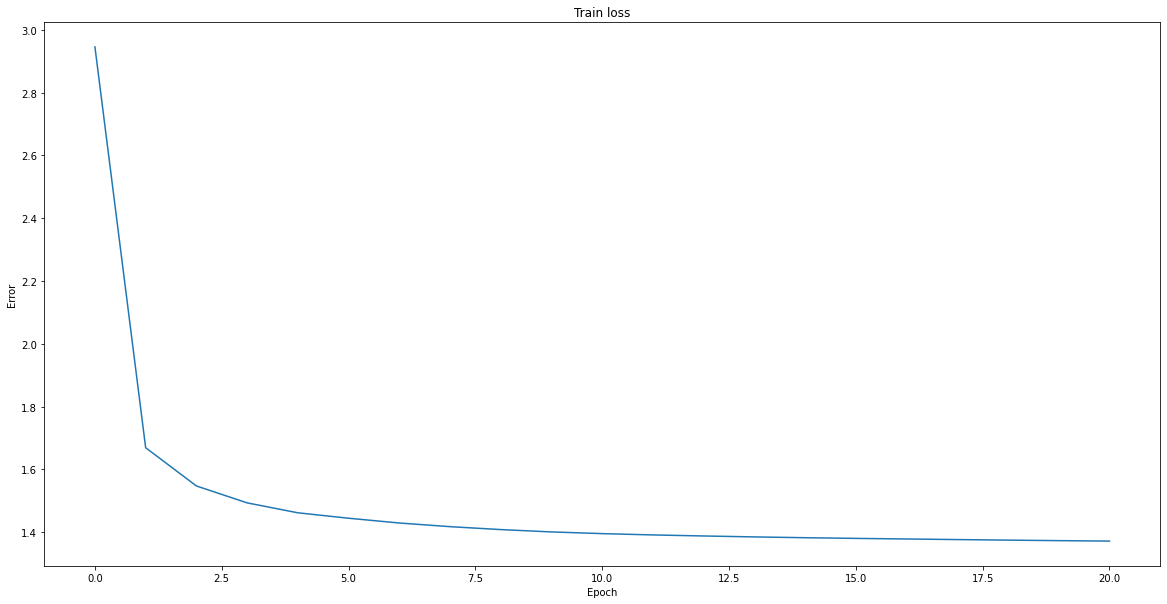

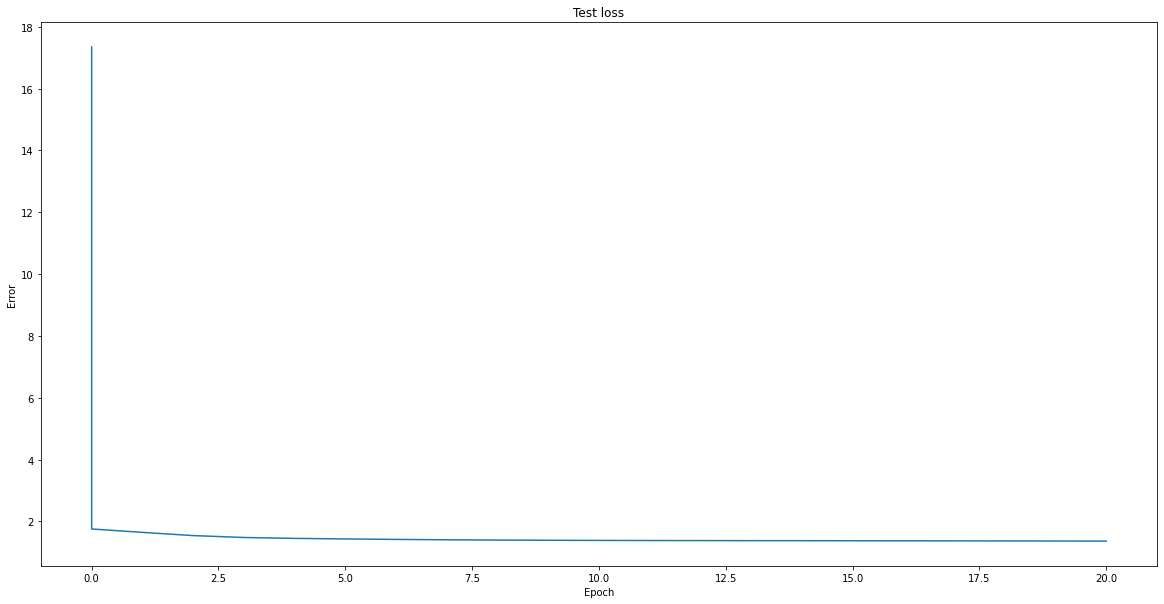

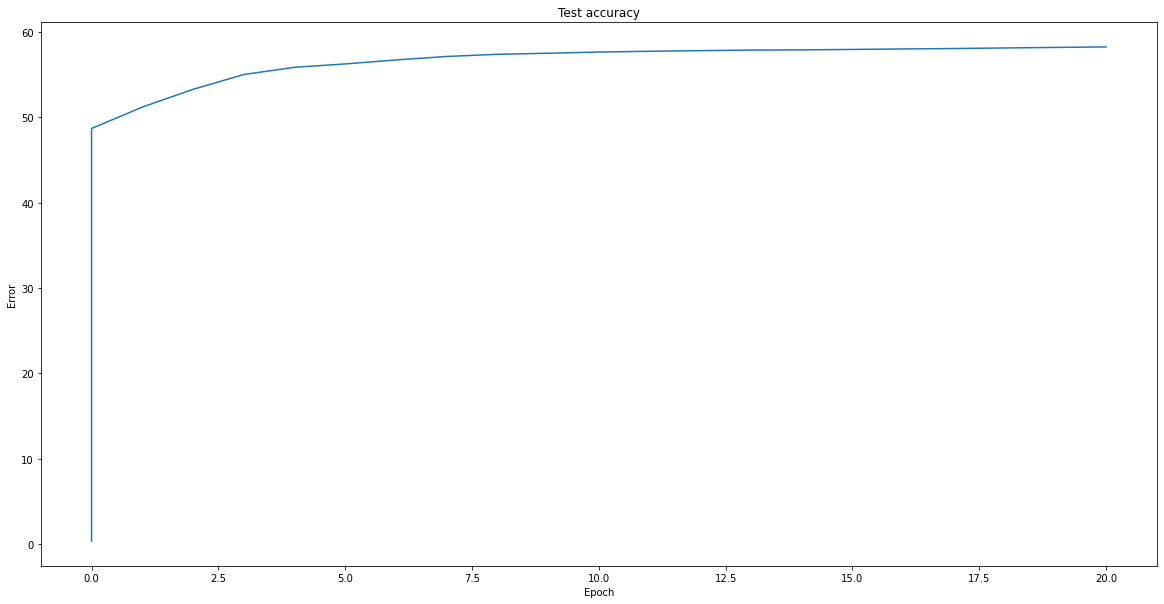

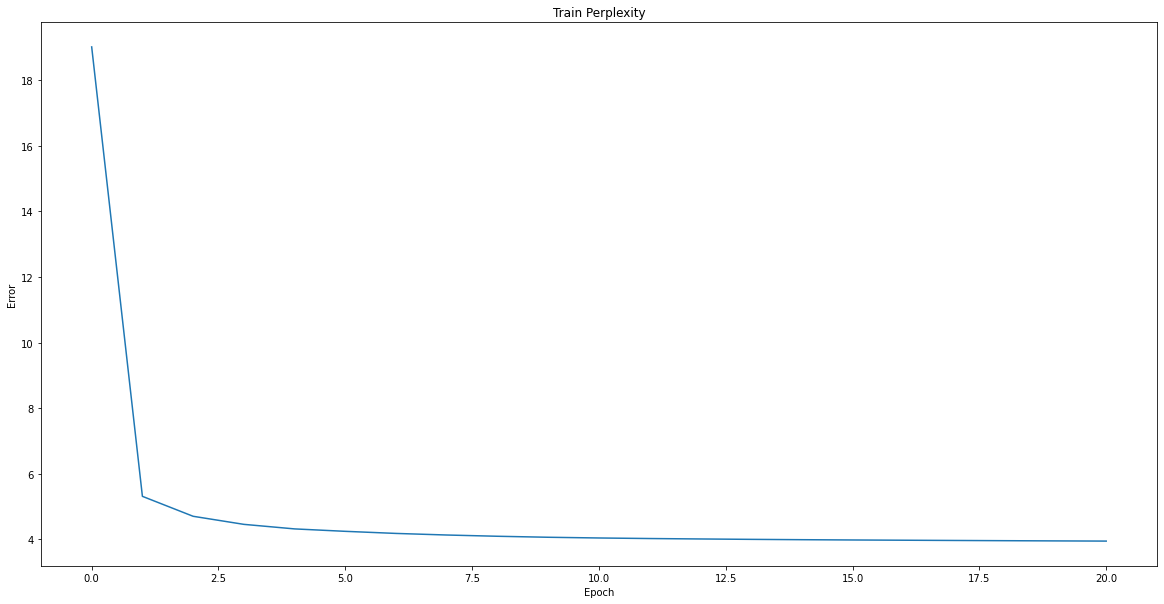

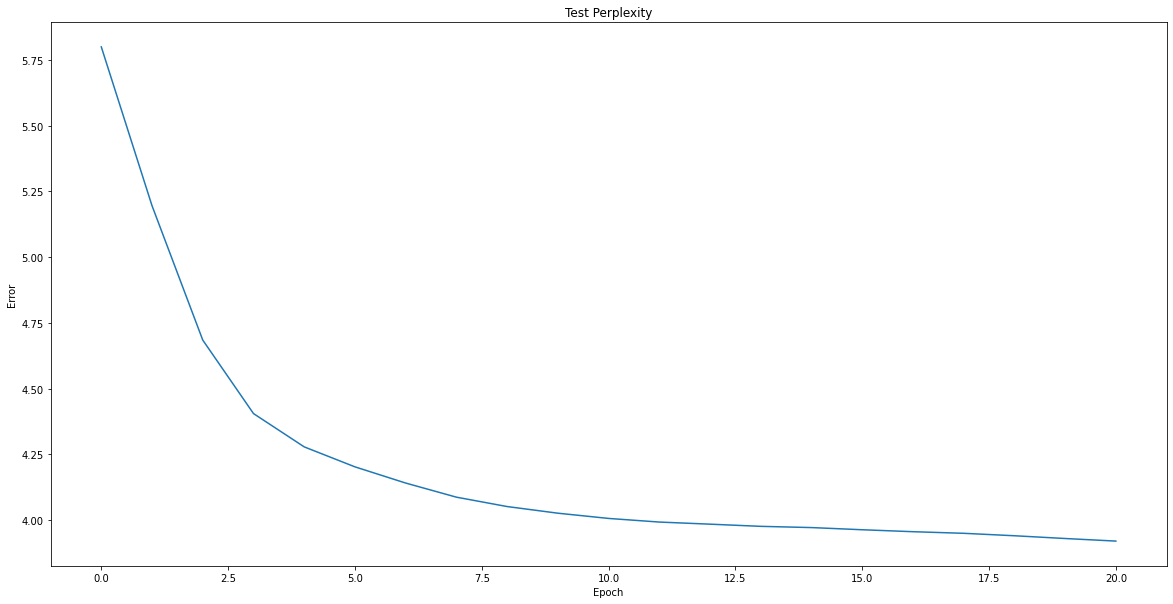

In [22]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/gameofthrones_log.pkl'


    data_train = GameOfThroneDataset(DATA_PATH + 'gameofthrones_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = GameOfThroneDataset(DATA_PATH + 'gameofthrones_chars_train_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    global device
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    # train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    train_losses, test_losses, test_accuracies = [], [], []
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []
    # test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/gameofthrones_%03d.pt' % epoch)
            seed_words = 'Prince Joffrey'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/gameofthrones_%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [17]:
def eval_final_model(model, vocab, device):
    seed_words = 'Jon Snow '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Jon Snow who was not to see him a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song so
generated with sample	 Jon Snow was abrout of the Preen, Whree-’ sword pits in /urdenly, she comes, sort that sig2,” Lannisters said his house Lord rakking his eyes. “Mamonsy?”  Yon and many and his own. Jhis possing beside his son 
generated with sample	 Jon Snow dully.  Ond wook shody their ungur smarkless whice, liping turned.  “LadY we come, bforg? qyrion maeser,”e—6 steppled cloisling. “Lomsquch me their raise whiless Sheir bried it. They would have tenste
generated with sample	 Jon Snow Cencalds would hear it sould,” it breathedingred badfards. Some into Winteer, and Shalin’s shoulder toy Bzafe. Mover beyond’s son SLomisa, Buestiveree and triats own Sansa entered. We mure. I’ll do no
generated with sample	 Jon Snow had serk down, and as well ap:e?”  “Lor

## Part 8.2. Find a better network architecture.

In [9]:
TEMPERATURE = 0.5

class BetterHarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(BetterHarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=2, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # DONE finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)

        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

length of tokens: 5000121
length of tokens: 1250031
Using device cuda
num workers: 2
Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	XddgddV4?pp7rrrr-tCrr2V--AA722RR,m,??77pRp, uV777t7p7%0,b?Orr--tdddddRoop7/0tttkk,-_777777rVtr-D7oRr


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	mC--7---77ttt!t~77qkk--77777myRR7Ohhk777780kk((~~~~88t!AAAt--Q72w`-A7Ann--7tt777-77%777o-`77(77Frrrt


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	?r7777D0ttt!tt7Crrr77rrr-7ooo\C,gt??t----opOrrrrr7Ohk4,?tt(((

  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 7.7754, Accuracy: 25335/1254400 (2%), Perplexity: 2381.204689



  1%|          | 2/196 [00:00<00:41,  4.62it/s]

Train Epoch: 0 [0/50176 (0%)]	Loss: 7.783843	Perplexity: 2401.484973


  6%|▌         | 12/196 [00:02<00:31,  5.77it/s]

Train Epoch: 0 [2560/50176 (5%)]	Loss: 11.155037	Perplexity: 133028549.962420


 11%|█         | 22/196 [00:03<00:29,  5.96it/s]

Train Epoch: 0 [5120/50176 (10%)]	Loss: 4.850756	Perplexity: 561987.214917


 16%|█▋        | 32/196 [00:05<00:27,  5.88it/s]

Train Epoch: 0 [7680/50176 (15%)]	Loss: 3.127019	Perplexity: 26443.789413


 21%|██▏       | 42/196 [00:07<00:26,  5.91it/s]

Train Epoch: 0 [10240/50176 (20%)]	Loss: 2.459255	Perplexity: 4244.006590


 27%|██▋       | 52/196 [00:08<00:24,  5.96it/s]

Train Epoch: 0 [12800/50176 (26%)]	Loss: 2.223628	Perplexity: 1297.465780


 32%|███▏      | 62/196 [00:10<00:22,  5.85it/s]

Train Epoch: 0 [15360/50176 (31%)]	Loss: 2.088223	Perplexity: 567.922237


 37%|███▋      | 72/196 [00:12<00:21,  5.89it/s]

Train Epoch: 0 [17920/50176 (36%)]	Loss: 2.022714	Perplexity: 310.255189


 42%|████▏     | 82/196 [00:13<00:19,  5.92it/s]

Train Epoch: 0 [20480/50176 (41%)]	Loss: 1.965086	Perplexity: 195.186097


 47%|████▋     | 92/196 [00:15<00:17,  5.87it/s]

Train Epoch: 0 [23040/50176 (46%)]	Loss: 1.954258	Perplexity: 135.526784


 52%|█████▏    | 102/196 [00:17<00:16,  5.86it/s]

Train Epoch: 0 [25600/50176 (51%)]	Loss: 1.898336	Perplexity: 100.879307


 57%|█████▋    | 112/196 [00:19<00:14,  5.84it/s]

Train Epoch: 0 [28160/50176 (56%)]	Loss: 1.861373	Perplexity: 78.728863


 62%|██████▏   | 122/196 [00:20<00:12,  5.85it/s]

Train Epoch: 0 [30720/50176 (61%)]	Loss: 1.814267	Perplexity: 63.854291


 67%|██████▋   | 132/196 [00:22<00:10,  5.84it/s]

Train Epoch: 0 [33280/50176 (66%)]	Loss: 1.777008	Perplexity: 53.347884


 72%|███████▏  | 142/196 [00:24<00:09,  5.77it/s]

Train Epoch: 0 [35840/50176 (71%)]	Loss: 1.765924	Perplexity: 45.663837


 78%|███████▊  | 152/196 [00:25<00:07,  5.72it/s]

Train Epoch: 0 [38400/50176 (77%)]	Loss: 1.761237	Perplexity: 39.857669


 83%|████████▎ | 162/196 [00:27<00:05,  5.72it/s]

Train Epoch: 0 [40960/50176 (82%)]	Loss: 1.809231	Perplexity: 35.414164


 88%|████████▊ | 172/196 [00:29<00:04,  5.88it/s]

Train Epoch: 0 [43520/50176 (87%)]	Loss: 1.756575	Perplexity: 31.899499


 93%|█████████▎| 182/196 [00:31<00:02,  5.86it/s]

Train Epoch: 0 [46080/50176 (92%)]	Loss: 1.753658	Perplexity: 28.991025


 98%|█████████▊| 192/196 [00:32<00:00,  5.91it/s]

Train Epoch: 0 [48640/50176 (97%)]	Loss: 1.721662	Perplexity: 26.579229


100%|██████████| 196/196 [00:33<00:00,  5.86it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney ohs doft th set uiscr  au ause holdemort wid beeceed on womm.. .e woong iim elf ofer hh she cvoe


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woet wed bes fne  "t weaidd   iis  hocl ng ieck ard sn o the cascr ohth h sheecse he whreieeed oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe wnd hes ween iiso ohe moeund fn hhe  wokter him snd seein ih sonei wam  hhioiy dnd shre y  wuck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  Chroping were fighy brestnrenight's nark... Uncidet Wel, fong infour if its caugenly make for musch wish exrents of the resed be glestoop new know foriec turn ex to SNckinst, he snave not wepring blu



  1%|          | 2/196 [00:00<00:49,  3.94it/s]

Train Epoch: 1 [0/50176 (0%)]	Loss: 1.719098	Perplexity: 5.579495


  6%|▌         | 12/196 [00:02<00:31,  5.86it/s]

Train Epoch: 1 [2560/50176 (5%)]	Loss: 1.674148	Perplexity: 5.398660


 11%|█         | 22/196 [00:03<00:30,  5.79it/s]

Train Epoch: 1 [5120/50176 (10%)]	Loss: 1.688813	Perplexity: 5.341907


 16%|█▋        | 32/196 [00:05<00:28,  5.77it/s]

Train Epoch: 1 [7680/50176 (15%)]	Loss: 1.689560	Perplexity: 5.365426


 21%|██▏       | 42/196 [00:07<00:26,  5.81it/s]

Train Epoch: 1 [10240/50176 (20%)]	Loss: 1.670454	Perplexity: 5.364535


 27%|██▋       | 52/196 [00:09<00:25,  5.69it/s]

Train Epoch: 1 [12800/50176 (26%)]	Loss: 1.699104	Perplexity: 5.368704


 32%|███▏      | 62/196 [00:10<00:23,  5.74it/s]

Train Epoch: 1 [15360/50176 (31%)]	Loss: 1.660888	Perplexity: 5.368064


 37%|███▋      | 72/196 [00:12<00:21,  5.68it/s]

Train Epoch: 1 [17920/50176 (36%)]	Loss: 1.643674	Perplexity: 5.343524


 42%|████▏     | 82/196 [00:14<00:20,  5.67it/s]

Train Epoch: 1 [20480/50176 (41%)]	Loss: 1.596394	Perplexity: 5.300922


 47%|████▋     | 92/196 [00:16<00:18,  5.57it/s]

Train Epoch: 1 [23040/50176 (46%)]	Loss: 1.584548	Perplexity: 5.256973


 52%|█████▏    | 102/196 [00:17<00:16,  5.62it/s]

Train Epoch: 1 [25600/50176 (51%)]	Loss: 1.596019	Perplexity: 5.224592


 57%|█████▋    | 112/196 [00:19<00:14,  5.63it/s]

Train Epoch: 1 [28160/50176 (56%)]	Loss: 1.648898	Perplexity: 5.203233


 62%|██████▏   | 122/196 [00:21<00:13,  5.57it/s]

Train Epoch: 1 [30720/50176 (61%)]	Loss: 1.629468	Perplexity: 5.208837


 67%|██████▋   | 132/196 [00:23<00:11,  5.51it/s]

Train Epoch: 1 [33280/50176 (66%)]	Loss: 1.656330	Perplexity: 5.215740


 72%|███████▏  | 142/196 [00:25<00:09,  5.46it/s]

Train Epoch: 1 [35840/50176 (71%)]	Loss: 1.605508	Perplexity: 5.218110


 78%|███████▊  | 152/196 [00:26<00:08,  5.49it/s]

Train Epoch: 1 [38400/50176 (77%)]	Loss: 1.573270	Perplexity: 5.197928


 83%|████████▎ | 162/196 [00:28<00:06,  5.49it/s]

Train Epoch: 1 [40960/50176 (82%)]	Loss: 1.577538	Perplexity: 5.171612


 88%|████████▊ | 172/196 [00:30<00:04,  5.49it/s]

Train Epoch: 1 [43520/50176 (87%)]	Loss: 1.534767	Perplexity: 5.144290


 93%|█████████▎| 182/196 [00:32<00:02,  5.45it/s]

Train Epoch: 1 [46080/50176 (92%)]	Loss: 1.556616	Perplexity: 5.115885


 98%|█████████▊| 192/196 [00:34<00:00,  5.48it/s]

Train Epoch: 1 [48640/50176 (97%)]	Loss: 1.554204	Perplexity: 5.088830


100%|██████████| 196/196 [00:34<00:00,  5.61it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	 ey ths dott th het aiscr  aucause holdemort wad auacted an womm.. aa wlong oim elf oner th hhe cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 ehet hed aam ene  "  wialsse  tim  hocling ieck ard tnto the saner ahth h nheatse ie htrebeeed oh h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rhe and Hes waet aist hhe mround tn hhe  wokter him and heean to tan y aam  hhiwly.dnd htre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. They slowly dievers. "I don't  no punning avong turned whiened his chang. THR Buggitany?" shaked said Hermione pit found intringled sirvainto the cominane of coome bedge hald to day his gant one her s



  1%|          | 2/196 [00:00<00:49,  3.91it/s]

Train Epoch: 2 [0/50176 (0%)]	Loss: 1.560002	Perplexity: 4.758830


  6%|▌         | 12/196 [00:02<00:33,  5.54it/s]

Train Epoch: 2 [2560/50176 (5%)]	Loss: 1.539363	Perplexity: 4.660122


 11%|█         | 22/196 [00:04<00:30,  5.66it/s]

Train Epoch: 2 [5120/50176 (10%)]	Loss: 1.572925	Perplexity: 4.635783


 16%|█▋        | 32/196 [00:05<00:29,  5.57it/s]

Train Epoch: 2 [7680/50176 (15%)]	Loss: 1.536822	Perplexity: 4.652700


 21%|██▏       | 42/196 [00:07<00:27,  5.52it/s]

Train Epoch: 2 [10240/50176 (20%)]	Loss: 1.523802	Perplexity: 4.638515


 27%|██▋       | 52/196 [00:09<00:25,  5.58it/s]

Train Epoch: 2 [12800/50176 (26%)]	Loss: 1.548259	Perplexity: 4.638299


 32%|███▏      | 62/196 [00:11<00:23,  5.60it/s]

Train Epoch: 2 [15360/50176 (31%)]	Loss: 1.552004	Perplexity: 4.661923


 37%|███▋      | 72/196 [00:13<00:22,  5.52it/s]

Train Epoch: 2 [17920/50176 (36%)]	Loss: 1.529871	Perplexity: 4.661399


 42%|████▏     | 82/196 [00:14<00:20,  5.55it/s]

Train Epoch: 2 [20480/50176 (41%)]	Loss: 1.500054	Perplexity: 4.645544


 47%|████▋     | 92/196 [00:16<00:19,  5.47it/s]

Train Epoch: 2 [23040/50176 (46%)]	Loss: 1.522047	Perplexity: 4.630941


 52%|█████▏    | 102/196 [00:18<00:17,  5.52it/s]

Train Epoch: 2 [25600/50176 (51%)]	Loss: 1.549296	Perplexity: 4.637581


 57%|█████▋    | 112/196 [00:20<00:15,  5.51it/s]

Train Epoch: 2 [28160/50176 (56%)]	Loss: 1.523087	Perplexity: 4.632167


 62%|██████▏   | 122/196 [00:22<00:13,  5.47it/s]

Train Epoch: 2 [30720/50176 (61%)]	Loss: 1.493679	Perplexity: 4.619457


 67%|██████▋   | 132/196 [00:23<00:11,  5.50it/s]

Train Epoch: 2 [33280/50176 (66%)]	Loss: 1.470145	Perplexity: 4.605641


 72%|███████▏  | 142/196 [00:25<00:09,  5.44it/s]

Train Epoch: 2 [35840/50176 (71%)]	Loss: 1.485236	Perplexity: 4.593206


 78%|███████▊  | 152/196 [00:27<00:08,  5.48it/s]

Train Epoch: 2 [38400/50176 (77%)]	Loss: 1.491773	Perplexity: 4.581440


 83%|████████▎ | 162/196 [00:29<00:06,  5.48it/s]

Train Epoch: 2 [40960/50176 (82%)]	Loss: 1.564929	Perplexity: 4.585033


 88%|████████▊ | 172/196 [00:31<00:04,  5.44it/s]

Train Epoch: 2 [43520/50176 (87%)]	Loss: 1.645201	Perplexity: 4.598061


 93%|█████████▎| 182/196 [00:33<00:02,  5.54it/s]

Train Epoch: 2 [46080/50176 (92%)]	Loss: 1.543754	Perplexity: 4.603190


 98%|█████████▊| 192/196 [00:34<00:00,  5.50it/s]

Train Epoch: 2 [48640/50176 (97%)]	Loss: 1.499355	Perplexity: 4.594570


100%|██████████| 196/196 [00:35<00:00,  5.52it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y ths tott th set tiscr  tucause toldemort tad auacted tn womm . ia wootg ois elf tuer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoat ted aas enm   t wialsse  tis  aocleng teck ard tnto the salcr ahth t steacs  te htoebeled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  tnd tes faet aist the sround tn the  wokter ais tnd seean to ton y aass toiwly dnd ttre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 'ope looking aloneg attaway to leaves that the Cuprost have I right," said Headn' made mumbledore caught the Tinky out of thinstle warnent... but hoped and fount inside and a speak-ormon Warvaging Agi



  1%|          | 2/196 [00:00<00:50,  3.87it/s]

Train Epoch: 3 [0/50176 (0%)]	Loss: 1.485236	Perplexity: 4.416006


  6%|▌         | 12/196 [00:02<00:33,  5.54it/s]

Train Epoch: 3 [2560/50176 (5%)]	Loss: 1.466990	Perplexity: 4.347059


 11%|█         | 22/196 [00:04<00:30,  5.64it/s]

Train Epoch: 3 [5120/50176 (10%)]	Loss: 1.485453	Perplexity: 4.317605


 16%|█▋        | 32/196 [00:05<00:29,  5.57it/s]

Train Epoch: 3 [7680/50176 (15%)]	Loss: 1.463743	Perplexity: 4.323994


 21%|██▏       | 42/196 [00:07<00:27,  5.51it/s]

Train Epoch: 3 [10240/50176 (20%)]	Loss: 1.453875	Perplexity: 4.310689


 27%|██▋       | 52/196 [00:09<00:25,  5.56it/s]

Train Epoch: 3 [12800/50176 (26%)]	Loss: 1.454167	Perplexity: 4.305945


 32%|███▏      | 62/196 [00:11<00:24,  5.54it/s]

Train Epoch: 3 [15360/50176 (31%)]	Loss: 1.459449	Perplexity: 4.307321


 37%|███▋      | 72/196 [00:13<00:22,  5.49it/s]

Train Epoch: 3 [17920/50176 (36%)]	Loss: 1.472822	Perplexity: 4.310528


 42%|████▏     | 82/196 [00:14<00:21,  5.42it/s]

Train Epoch: 3 [20480/50176 (41%)]	Loss: 1.477779	Perplexity: 4.315613


 47%|████▋     | 92/196 [00:16<00:19,  5.46it/s]

Train Epoch: 3 [23040/50176 (46%)]	Loss: 1.460018	Perplexity: 4.316538


 52%|█████▏    | 102/196 [00:18<00:17,  5.42it/s]

Train Epoch: 3 [25600/50176 (51%)]	Loss: 1.478117	Perplexity: 4.322015


 57%|█████▋    | 112/196 [00:20<00:15,  5.43it/s]

Train Epoch: 3 [28160/50176 (56%)]	Loss: 1.476649	Perplexity: 4.322871


 62%|██████▏   | 122/196 [00:22<00:13,  5.40it/s]

Train Epoch: 3 [30720/50176 (61%)]	Loss: 1.455478	Perplexity: 4.321815


 67%|██████▋   | 132/196 [00:24<00:11,  5.38it/s]

Train Epoch: 3 [33280/50176 (66%)]	Loss: 1.431489	Perplexity: 4.317204


 72%|███████▏  | 142/196 [00:26<00:10,  5.32it/s]

Train Epoch: 3 [35840/50176 (71%)]	Loss: 1.439436	Perplexity: 4.312626


 78%|███████▊  | 152/196 [00:27<00:08,  5.36it/s]

Train Epoch: 3 [38400/50176 (77%)]	Loss: 1.434257	Perplexity: 4.304397


 83%|████████▎ | 162/196 [00:29<00:06,  5.33it/s]

Train Epoch: 3 [40960/50176 (82%)]	Loss: 1.460742	Perplexity: 4.301134


 88%|████████▊ | 172/196 [00:31<00:04,  5.44it/s]

Train Epoch: 3 [43520/50176 (87%)]	Loss: 1.605107	Perplexity: 4.310996


 93%|█████████▎| 182/196 [00:33<00:02,  5.42it/s]

Train Epoch: 3 [46080/50176 (92%)]	Loss: 1.567188	Perplexity: 4.332030


 98%|█████████▊| 192/196 [00:35<00:00,  5.33it/s]

Train Epoch: 3 [48640/50176 (97%)]	Loss: 1.486853	Perplexity: 4.334244


100%|██████████| 196/196 [00:36<00:00,  5.44it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	u y thn tott th sit tiscri tucause toldemort wad auacted an iomm . ia wloeg ois elf ouer th the cnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woet ted bas fnm  "t wialsse  tis  aocling aack ardstnto the salcr oith tnntracs  te htrabbledooo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  tnd tes faet aist the sloundstn the  wokter himstnd secan to torey aass ttiwly dnd strp y  huck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. You could the slip of answirely Durive to certain the the flooor Crune, and Will's of the way'll you. Snapace   and gling upeared foot along the crimments of punned actical the Colize Of enearx)quspli



  1%|          | 2/196 [00:00<00:48,  3.97it/s]

Train Epoch: 4 [0/50176 (0%)]	Loss: 1.466854	Perplexity: 4.335572


  6%|▌         | 12/196 [00:02<00:32,  5.58it/s]

Train Epoch: 4 [2560/50176 (5%)]	Loss: 1.431564	Perplexity: 4.222205


 11%|█         | 22/196 [00:03<00:30,  5.67it/s]

Train Epoch: 4 [5120/50176 (10%)]	Loss: 1.456669	Perplexity: 4.187151


 16%|█▋        | 32/196 [00:05<00:28,  5.67it/s]

Train Epoch: 4 [7680/50176 (15%)]	Loss: 1.433162	Perplexity: 4.192855


 21%|██▏       | 42/196 [00:07<00:27,  5.59it/s]

Train Epoch: 4 [10240/50176 (20%)]	Loss: 1.430314	Perplexity: 4.181584


 27%|██▋       | 52/196 [00:09<00:25,  5.67it/s]

Train Epoch: 4 [12800/50176 (26%)]	Loss: 1.419880	Perplexity: 4.176191


 32%|███▏      | 62/196 [00:11<00:23,  5.60it/s]

Train Epoch: 4 [15360/50176 (31%)]	Loss: 1.426430	Perplexity: 4.177607


 37%|███▋      | 72/196 [00:12<00:22,  5.57it/s]

Train Epoch: 4 [17920/50176 (36%)]	Loss: 1.428018	Perplexity: 4.179438


 42%|████▏     | 82/196 [00:14<00:20,  5.49it/s]

Train Epoch: 4 [20480/50176 (41%)]	Loss: 1.428612	Perplexity: 4.178476


 47%|████▋     | 92/196 [00:16<00:18,  5.50it/s]

Train Epoch: 4 [23040/50176 (46%)]	Loss: 1.442268	Perplexity: 4.189148


 52%|█████▏    | 102/196 [00:18<00:17,  5.47it/s]

Train Epoch: 4 [25600/50176 (51%)]	Loss: 1.446437	Perplexity: 4.195915


 57%|█████▋    | 112/196 [00:20<00:15,  5.46it/s]

Train Epoch: 4 [28160/50176 (56%)]	Loss: 1.437763	Perplexity: 4.193506


 62%|██████▏   | 122/196 [00:21<00:13,  5.50it/s]

Train Epoch: 4 [30720/50176 (61%)]	Loss: 1.424656	Perplexity: 4.190281


 67%|██████▋   | 132/196 [00:23<00:11,  5.35it/s]

Train Epoch: 4 [33280/50176 (66%)]	Loss: 1.401282	Perplexity: 4.185811


 72%|███████▏  | 142/196 [00:25<00:10,  5.39it/s]

Train Epoch: 4 [35840/50176 (71%)]	Loss: 1.409876	Perplexity: 4.181734


 78%|███████▊  | 152/196 [00:27<00:08,  5.41it/s]

Train Epoch: 4 [38400/50176 (77%)]	Loss: 1.421282	Perplexity: 4.176195


 83%|████████▎ | 162/196 [00:29<00:06,  5.38it/s]

Train Epoch: 4 [40960/50176 (82%)]	Loss: 1.466257	Perplexity: 4.180373


 88%|████████▊ | 172/196 [00:31<00:04,  5.40it/s]

Train Epoch: 4 [43520/50176 (87%)]	Loss: 1.439166	Perplexity: 4.185207


 93%|█████████▎| 182/196 [00:33<00:02,  5.34it/s]

Train Epoch: 4 [46080/50176 (92%)]	Loss: 1.438128	Perplexity: 4.183834


 98%|█████████▊| 192/196 [00:34<00:00,  5.40it/s]

Train Epoch: 4 [48640/50176 (97%)]	Loss: 1.435000	Perplexity: 4.180234


100%|██████████| 196/196 [00:35<00:00,  5.50it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey ths tott th sit ahscr  aucause holdemort wad buacted tn iomh . ie woogg oim elf oner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 aoet wed bas enm  "t wialsse  tim  aocling aack ardstnto the salcrsohth anntiats  oe hthebeled oo s


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	lh  and tes waet aist the sloundstn the  woke d aim and selan to soney aams aoiwly ond strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Tany one beelove exaconing it's classes with Widrin, his want him, do would his one toiles to Kark and says wall proseding and spraition foudswart," said Ron Angiling one orderate the centaurday. She



  1%|          | 2/196 [00:00<00:48,  4.02it/s]

Train Epoch: 5 [0/50176 (0%)]	Loss: 1.432828	Perplexity: 4.190532


  6%|▌         | 12/196 [00:02<00:33,  5.57it/s]

Train Epoch: 5 [2560/50176 (5%)]	Loss: 1.411217	Perplexity: 4.099633


 11%|█         | 22/196 [00:03<00:30,  5.66it/s]

Train Epoch: 5 [5120/50176 (10%)]	Loss: 1.434194	Perplexity: 4.073893


 16%|█▋        | 32/196 [00:05<00:29,  5.59it/s]

Train Epoch: 5 [7680/50176 (15%)]	Loss: 1.411519	Perplexity: 4.084863


 21%|██▏       | 42/196 [00:07<00:27,  5.60it/s]

Train Epoch: 5 [10240/50176 (20%)]	Loss: 1.403502	Perplexity: 4.077385


 27%|██▋       | 52/196 [00:09<00:25,  5.55it/s]

Train Epoch: 5 [12800/50176 (26%)]	Loss: 1.399124	Perplexity: 4.076297


 32%|███▏      | 62/196 [00:11<00:24,  5.56it/s]

Train Epoch: 5 [15360/50176 (31%)]	Loss: 1.432368	Perplexity: 4.096149


 37%|███▋      | 72/196 [00:12<00:22,  5.54it/s]

Train Epoch: 5 [17920/50176 (36%)]	Loss: 1.438018	Perplexity: 4.112420


 42%|████▏     | 82/196 [00:14<00:20,  5.52it/s]

Train Epoch: 5 [20480/50176 (41%)]	Loss: 1.402090	Perplexity: 4.113084


 47%|████▋     | 92/196 [00:16<00:19,  5.45it/s]

Train Epoch: 5 [23040/50176 (46%)]	Loss: 1.396303	Perplexity: 4.108303


 52%|█████▏    | 102/196 [00:18<00:17,  5.48it/s]

Train Epoch: 5 [25600/50176 (51%)]	Loss: 1.420162	Perplexity: 4.109407


 57%|█████▋    | 112/196 [00:20<00:15,  5.43it/s]

Train Epoch: 5 [28160/50176 (56%)]	Loss: 1.446583	Perplexity: 4.109978


 62%|██████▏   | 122/196 [00:22<00:13,  5.31it/s]

Train Epoch: 5 [30720/50176 (61%)]	Loss: 1.416485	Perplexity: 4.113896


 67%|██████▋   | 132/196 [00:24<00:12,  5.33it/s]

Train Epoch: 5 [33280/50176 (66%)]	Loss: 1.384760	Perplexity: 4.110979


 72%|███████▏  | 142/196 [00:25<00:10,  5.31it/s]

Train Epoch: 5 [35840/50176 (71%)]	Loss: 1.397923	Perplexity: 4.107919


 78%|███████▊  | 152/196 [00:27<00:08,  5.32it/s]

Train Epoch: 5 [38400/50176 (77%)]	Loss: 1.397382	Perplexity: 4.102044


 83%|████████▎ | 162/196 [00:29<00:06,  5.27it/s]

Train Epoch: 5 [40960/50176 (82%)]	Loss: 1.422104	Perplexity: 4.100583


 88%|████████▊ | 172/196 [00:31<00:04,  5.29it/s]

Train Epoch: 5 [43520/50176 (87%)]	Loss: 1.404179	Perplexity: 4.100576


 93%|█████████▎| 182/196 [00:33<00:02,  5.35it/s]

Train Epoch: 5 [46080/50176 (92%)]	Loss: 1.420411	Perplexity: 4.097440


 98%|█████████▊| 192/196 [00:35<00:00,  5.40it/s]

Train Epoch: 5 [48640/50176 (97%)]	Loss: 1.424222	Perplexity: 4.094291


100%|██████████| 196/196 [00:35<00:00,  5.45it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	uey tes titt th tet tiscr  aucause teldemort wad tuaceed tn iomt . ie weigg him elf aner th the snge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat wed tes wnm  "t wealsse  tim  aocling aack ard tnto the salersaith a ltiatt  te htaebbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes waet aest the sioundstn the  weke d timsand selan to taney aams atiwly tnd ttrp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. It tike say the vest right in face. "I. When he didn't cau't written!" Dumbledore the door, Her-Welly welled to know Macual Malamost a fother with them."  "It about Krum. Mabke. Yense Ron despels -- w



  1%|          | 2/196 [00:00<00:48,  4.04it/s]

Train Epoch: 6 [0/50176 (0%)]	Loss: 1.417584	Perplexity: 4.127137


  6%|▌         | 12/196 [00:02<00:32,  5.63it/s]

Train Epoch: 6 [2560/50176 (5%)]	Loss: 1.393353	Perplexity: 4.037327


 11%|█         | 22/196 [00:03<00:30,  5.71it/s]

Train Epoch: 6 [5120/50176 (10%)]	Loss: 1.419908	Perplexity: 4.010274


 16%|█▋        | 32/196 [00:05<00:28,  5.71it/s]

Train Epoch: 6 [7680/50176 (15%)]	Loss: 1.397217	Perplexity: 4.022350


 21%|██▏       | 42/196 [00:07<00:27,  5.60it/s]

Train Epoch: 6 [10240/50176 (20%)]	Loss: 1.389767	Perplexity: 4.016827


 27%|██▋       | 52/196 [00:09<00:25,  5.61it/s]

Train Epoch: 6 [12800/50176 (26%)]	Loss: 1.390805	Perplexity: 4.018111


 32%|███▏      | 62/196 [00:11<00:23,  5.61it/s]

Train Epoch: 6 [15360/50176 (31%)]	Loss: 1.403576	Perplexity: 4.032224


 37%|███▋      | 72/196 [00:12<00:22,  5.59it/s]

Train Epoch: 6 [17920/50176 (36%)]	Loss: 1.403726	Perplexity: 4.040611


 42%|████▏     | 82/196 [00:14<00:20,  5.51it/s]

Train Epoch: 6 [20480/50176 (41%)]	Loss: 1.381656	Perplexity: 4.038013


 47%|████▋     | 92/196 [00:16<00:18,  5.49it/s]

Train Epoch: 6 [23040/50176 (46%)]	Loss: 1.381935	Perplexity: 4.033999


 52%|█████▏    | 102/196 [00:18<00:17,  5.48it/s]

Train Epoch: 6 [25600/50176 (51%)]	Loss: 1.416609	Perplexity: 4.038787


 57%|█████▋    | 112/196 [00:20<00:15,  5.50it/s]

Train Epoch: 6 [28160/50176 (56%)]	Loss: 1.470623	Perplexity: 4.047109


 62%|██████▏   | 122/196 [00:21<00:13,  5.52it/s]

Train Epoch: 6 [30720/50176 (61%)]	Loss: 1.424514	Perplexity: 4.065472


 67%|██████▋   | 132/196 [00:23<00:11,  5.48it/s]

Train Epoch: 6 [33280/50176 (66%)]	Loss: 1.382925	Perplexity: 4.067994


 72%|███████▏  | 142/196 [00:25<00:09,  5.49it/s]

Train Epoch: 6 [35840/50176 (71%)]	Loss: 1.393131	Perplexity: 4.066807


 78%|███████▊  | 152/196 [00:27<00:08,  5.36it/s]

Train Epoch: 6 [38400/50176 (77%)]	Loss: 1.394901	Perplexity: 4.061895


 83%|████████▎ | 162/196 [00:29<00:06,  5.30it/s]

Train Epoch: 6 [40960/50176 (82%)]	Loss: 1.413793	Perplexity: 4.060898


 88%|████████▊ | 172/196 [00:31<00:04,  5.40it/s]

Train Epoch: 6 [43520/50176 (87%)]	Loss: 1.379533	Perplexity: 4.058086


 93%|█████████▎| 182/196 [00:33<00:02,  5.37it/s]

Train Epoch: 6 [46080/50176 (92%)]	Loss: 1.406461	Perplexity: 4.053368


 98%|█████████▊| 192/196 [00:34<00:00,  5.32it/s]

Train Epoch: 6 [48640/50176 (97%)]	Loss: 1.402488	Perplexity: 4.049519


100%|██████████| 196/196 [00:35<00:00,  5.50it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	 ey aas aitt th tit ahscr  aucause ioldemort wad buaceed tn iomm.. ie weugg oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat wed bes enm  "t wemlssed tim  aocling aack ard anto the salersaath a ltiach  oe htaebbled oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes waet aist the siound on the  woke d aimsand selan to torey aams aoiwly and strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Yes, I wave?" said Hermione afteral. He heard him with enemerly? Ad himself work gingers'pote jupin. "Thes," She Chosenve chosentrancess whether he issible flying bell diffecept some robesly. "In win



  1%|          | 2/196 [00:00<00:50,  3.82it/s]

Train Epoch: 7 [0/50176 (0%)]	Loss: 1.404521	Perplexity: 4.073576


  6%|▌         | 12/196 [00:02<00:33,  5.55it/s]

Train Epoch: 7 [2560/50176 (5%)]	Loss: 1.381185	Perplexity: 3.988769


 11%|█         | 22/196 [00:04<00:30,  5.68it/s]

Train Epoch: 7 [5120/50176 (10%)]	Loss: 1.450761	Perplexity: 4.006292


 16%|█▋        | 32/196 [00:05<00:28,  5.70it/s]

Train Epoch: 7 [7680/50176 (15%)]	Loss: 1.393589	Perplexity: 4.039120


 21%|██▏       | 42/196 [00:07<00:27,  5.53it/s]

Train Epoch: 7 [10240/50176 (20%)]	Loss: 1.380625	Perplexity: 4.027226


 27%|██▋       | 52/196 [00:09<00:25,  5.60it/s]

Train Epoch: 7 [12800/50176 (26%)]	Loss: 1.379354	Perplexity: 4.017604


 32%|███▏      | 62/196 [00:11<00:24,  5.55it/s]

Train Epoch: 7 [15360/50176 (31%)]	Loss: 1.383422	Perplexity: 4.012744


 37%|███▋      | 72/196 [00:12<00:22,  5.48it/s]

Train Epoch: 7 [17920/50176 (36%)]	Loss: 1.390446	Perplexity: 4.012235


 42%|████▏     | 82/196 [00:14<00:20,  5.49it/s]

Train Epoch: 7 [20480/50176 (41%)]	Loss: 1.372794	Perplexity: 4.007453


 47%|████▋     | 92/196 [00:16<00:19,  5.47it/s]

Train Epoch: 7 [23040/50176 (46%)]	Loss: 1.371814	Perplexity: 4.002053


 52%|█████▏    | 102/196 [00:18<00:17,  5.52it/s]

Train Epoch: 7 [25600/50176 (51%)]	Loss: 1.407800	Perplexity: 4.008049


 57%|█████▋    | 112/196 [00:20<00:15,  5.52it/s]

Train Epoch: 7 [28160/50176 (56%)]	Loss: 1.391189	Perplexity: 4.007736


 62%|██████▏   | 122/196 [00:22<00:13,  5.42it/s]

Train Epoch: 7 [30720/50176 (61%)]	Loss: 1.389167	Perplexity: 4.007299


 67%|██████▋   | 132/196 [00:23<00:11,  5.42it/s]

Train Epoch: 7 [33280/50176 (66%)]	Loss: 1.370875	Perplexity: 4.006373


 72%|███████▏  | 142/196 [00:25<00:09,  5.49it/s]

Train Epoch: 7 [35840/50176 (71%)]	Loss: 1.381007	Perplexity: 4.005861


 78%|███████▊  | 152/196 [00:27<00:08,  5.44it/s]

Train Epoch: 7 [38400/50176 (77%)]	Loss: 1.385734	Perplexity: 4.004490


 83%|████████▎ | 162/196 [00:29<00:06,  5.37it/s]

Train Epoch: 7 [40960/50176 (82%)]	Loss: 1.416156	Perplexity: 4.005946


 88%|████████▊ | 172/196 [00:31<00:04,  5.42it/s]

Train Epoch: 7 [43520/50176 (87%)]	Loss: 1.391745	Perplexity: 4.011251


 93%|█████████▎| 182/196 [00:33<00:02,  5.44it/s]

Train Epoch: 7 [46080/50176 (92%)]	Loss: 1.404341	Perplexity: 4.010341


 98%|█████████▊| 192/196 [00:35<00:00,  5.36it/s]

Train Epoch: 7 [48640/50176 (97%)]	Loss: 1.395591	Perplexity: 4.007729


100%|██████████| 196/196 [00:35<00:00,  5.49it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	 ey tas titt th tit tiscr  aucause holdemort wad buaceed tn iomm . ie wootg oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woat wed bes enm  "t wemlsse  tim  aocling aack ard tnto the saler.aath a ltiatt  oe staabbeed oo t


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	th  and tes waet aist the dlound on the  woke d tim ond seaan to totey aims aoiwly atd strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. but in here on the sometage look and care from him what she voice and standing ingining to himselving =omgerouve , buUzing blothering; "Harry, because there, Cum pun intervion if his forgetting exvens



  1%|          | 2/196 [00:00<00:49,  3.89it/s]

Train Epoch: 8 [0/50176 (0%)]	Loss: 1.400103	Perplexity: 4.055618


  6%|▌         | 12/196 [00:02<00:32,  5.58it/s]

Train Epoch: 8 [2560/50176 (5%)]	Loss: 1.367179	Perplexity: 3.952812


 11%|█         | 22/196 [00:04<00:31,  5.57it/s]

Train Epoch: 8 [5120/50176 (10%)]	Loss: 1.405002	Perplexity: 3.937591


 16%|█▋        | 32/196 [00:05<00:29,  5.56it/s]

Train Epoch: 8 [7680/50176 (15%)]	Loss: 1.374376	Perplexity: 3.950115


 21%|██▏       | 42/196 [00:07<00:27,  5.59it/s]

Train Epoch: 8 [10240/50176 (20%)]	Loss: 1.372546	Perplexity: 3.943267


 27%|██▋       | 52/196 [00:09<00:25,  5.62it/s]

Train Epoch: 8 [12800/50176 (26%)]	Loss: 1.407142	Perplexity: 3.954617


 32%|███▏      | 62/196 [00:11<00:24,  5.56it/s]

Train Epoch: 8 [15360/50176 (31%)]	Loss: 1.401048	Perplexity: 3.971189


 37%|███▋      | 72/196 [00:13<00:22,  5.49it/s]

Train Epoch: 8 [17920/50176 (36%)]	Loss: 1.392864	Perplexity: 3.979711


 42%|████▏     | 82/196 [00:14<00:20,  5.48it/s]

Train Epoch: 8 [20480/50176 (41%)]	Loss: 1.369798	Perplexity: 3.981828


 47%|████▋     | 92/196 [00:16<00:18,  5.51it/s]

Train Epoch: 8 [23040/50176 (46%)]	Loss: 1.357769	Perplexity: 3.977362


 52%|█████▏    | 102/196 [00:18<00:17,  5.49it/s]

Train Epoch: 8 [25600/50176 (51%)]	Loss: 1.372776	Perplexity: 3.973900


 57%|█████▋    | 112/196 [00:20<00:15,  5.48it/s]

Train Epoch: 8 [28160/50176 (56%)]	Loss: 1.374584	Perplexity: 3.968598


 62%|██████▏   | 122/196 [00:22<00:13,  5.49it/s]

Train Epoch: 8 [30720/50176 (61%)]	Loss: 1.369657	Perplexity: 3.965839


 67%|██████▋   | 132/196 [00:23<00:11,  5.46it/s]

Train Epoch: 8 [33280/50176 (66%)]	Loss: 1.391209	Perplexity: 3.967029


 72%|███████▏  | 142/196 [00:25<00:10,  5.34it/s]

Train Epoch: 8 [35840/50176 (71%)]	Loss: 1.406243	Perplexity: 3.976924


 78%|███████▊  | 152/196 [00:27<00:08,  5.37it/s]

Train Epoch: 8 [38400/50176 (77%)]	Loss: 1.439435	Perplexity: 3.985374


 83%|████████▎ | 162/196 [00:29<00:06,  5.33it/s]

Train Epoch: 8 [40960/50176 (82%)]	Loss: 1.489747	Perplexity: 4.000886


 88%|████████▊ | 172/196 [00:31<00:04,  5.37it/s]

Train Epoch: 8 [43520/50176 (87%)]	Loss: 1.386053	Perplexity: 4.006674


 93%|█████████▎| 182/196 [00:33<00:02,  5.38it/s]

Train Epoch: 8 [46080/50176 (92%)]	Loss: 1.406384	Perplexity: 4.005679


 98%|█████████▊| 192/196 [00:35<00:00,  5.38it/s]

Train Epoch: 8 [48640/50176 (97%)]	Loss: 1.388584	Perplexity: 4.002698


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y tas titt th tot thscr  aucause holdemort wad buacted tn iomm . ie woutg oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hhat hed bes enm  "t weaiated tim  aocling aack ard tnto the saler.ahth a ltiitt  oe htaapbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	th  and tes faet aitt the dround an the  woke d tim ond seaan to totey aims aoiwly and strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. We heard Heeding fourprint on into Digaggen laugh and staring out of his back into anote hoars libin coung on injluch things downs on puncedd lim. "Dumbledore guilt. He scopprated, however, someting y



  1%|          | 2/196 [00:00<00:48,  3.96it/s]

Train Epoch: 9 [0/50176 (0%)]	Loss: 1.388789	Perplexity: 4.009989


  6%|▌         | 12/196 [00:02<00:32,  5.59it/s]

Train Epoch: 9 [2560/50176 (5%)]	Loss: 1.355883	Perplexity: 3.909395


 11%|█         | 22/196 [00:03<00:30,  5.69it/s]

Train Epoch: 9 [5120/50176 (10%)]	Loss: 1.397046	Perplexity: 3.897914


 16%|█▋        | 32/196 [00:05<00:29,  5.58it/s]

Train Epoch: 9 [7680/50176 (15%)]	Loss: 1.364899	Perplexity: 3.914518


 21%|██▏       | 42/196 [00:07<00:27,  5.57it/s]

Train Epoch: 9 [10240/50176 (20%)]	Loss: 1.364305	Perplexity: 3.910298


 27%|██▋       | 52/196 [00:09<00:26,  5.51it/s]

Train Epoch: 9 [12800/50176 (26%)]	Loss: 1.360900	Perplexity: 3.909522


 32%|███▏      | 62/196 [00:11<00:24,  5.52it/s]

Train Epoch: 9 [15360/50176 (31%)]	Loss: 1.382660	Perplexity: 3.914485


 37%|███▋      | 72/196 [00:12<00:22,  5.56it/s]

Train Epoch: 9 [17920/50176 (36%)]	Loss: 1.411074	Perplexity: 3.935586


 42%|████▏     | 82/196 [00:14<00:20,  5.48it/s]

Train Epoch: 9 [20480/50176 (41%)]	Loss: 1.364541	Perplexity: 3.943155


 47%|████▋     | 92/196 [00:16<00:18,  5.50it/s]

Train Epoch: 9 [23040/50176 (46%)]	Loss: 1.357771	Perplexity: 3.941060


 52%|█████▏    | 102/196 [00:18<00:17,  5.49it/s]

Train Epoch: 9 [25600/50176 (51%)]	Loss: 1.372093	Perplexity: 3.939293


 57%|█████▋    | 112/196 [00:20<00:15,  5.43it/s]

Train Epoch: 9 [28160/50176 (56%)]	Loss: 1.372995	Perplexity: 3.936287


 62%|██████▏   | 122/196 [00:22<00:13,  5.36it/s]

Train Epoch: 9 [30720/50176 (61%)]	Loss: 1.362993	Perplexity: 3.934997


 67%|██████▋   | 132/196 [00:24<00:11,  5.37it/s]

Train Epoch: 9 [33280/50176 (66%)]	Loss: 1.355756	Perplexity: 3.933323


 72%|███████▏  | 142/196 [00:25<00:10,  5.29it/s]

Train Epoch: 9 [35840/50176 (71%)]	Loss: 1.364995	Perplexity: 3.933212


 78%|███████▊  | 152/196 [00:27<00:08,  5.43it/s]

Train Epoch: 9 [38400/50176 (77%)]	Loss: 1.366881	Perplexity: 3.931715


 83%|████████▎ | 162/196 [00:29<00:06,  5.30it/s]

Train Epoch: 9 [40960/50176 (82%)]	Loss: 1.386784	Perplexity: 3.932283


 88%|████████▊ | 172/196 [00:31<00:04,  5.27it/s]

Train Epoch: 9 [43520/50176 (87%)]	Loss: 1.353097	Perplexity: 3.931469


 93%|█████████▎| 182/196 [00:33<00:02,  5.33it/s]

Train Epoch: 9 [46080/50176 (92%)]	Loss: 1.382203	Perplexity: 3.928930


 98%|█████████▊| 192/196 [00:35<00:00,  5.45it/s]

Train Epoch: 9 [48640/50176 (97%)]	Loss: 1.392510	Perplexity: 3.927816


100%|██████████| 196/196 [00:35<00:00,  5.45it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	 ey aas titt th tet aiscr  aucause holdemort wad buaceed an iomm.. ie weegg oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 woet hed bes enm  "t weaiased tim  aocling aack ard tnto the daler.aith a ltiitt  oe htaepbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes faet aest toe diound on the  woke d tim ond seaan to totey aims aoiwly and strp y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "No," said Bumbledore. "Qumhreary did it caue said. "Of he was eng.  "Minest, it's right," Harry really didn's sonk, do it wasn't bet into its were chown out of wincing Four Sixe enepine an one whichl



  1%|          | 2/196 [00:00<00:49,  3.90it/s]

Train Epoch: 10 [0/50176 (0%)]	Loss: 1.384079	Perplexity: 3.991148


  6%|▌         | 12/196 [00:02<00:32,  5.59it/s]

Train Epoch: 10 [2560/50176 (5%)]	Loss: 1.356412	Perplexity: 3.912142


 11%|█         | 22/196 [00:03<00:30,  5.68it/s]

Train Epoch: 10 [5120/50176 (10%)]	Loss: 1.393903	Perplexity: 3.895231


 16%|█▋        | 32/196 [00:05<00:29,  5.61it/s]

Train Epoch: 10 [7680/50176 (15%)]	Loss: 1.359510	Perplexity: 3.905185


 21%|██▏       | 42/196 [00:07<00:27,  5.64it/s]

Train Epoch: 10 [10240/50176 (20%)]	Loss: 1.356517	Perplexity: 3.896601


 27%|██▋       | 52/196 [00:09<00:26,  5.54it/s]

Train Epoch: 10 [12800/50176 (26%)]	Loss: 1.361438	Perplexity: 3.896685


 32%|███▏      | 62/196 [00:11<00:24,  5.52it/s]

Train Epoch: 10 [15360/50176 (31%)]	Loss: 1.381907	Perplexity: 3.910540


 37%|███▋      | 72/196 [00:12<00:22,  5.55it/s]

Train Epoch: 10 [17920/50176 (36%)]	Loss: 1.376861	Perplexity: 3.917068


 42%|████▏     | 82/196 [00:14<00:20,  5.47it/s]

Train Epoch: 10 [20480/50176 (41%)]	Loss: 1.352998	Perplexity: 3.915599


 47%|████▋     | 92/196 [00:16<00:18,  5.52it/s]

Train Epoch: 10 [23040/50176 (46%)]	Loss: 1.342002	Perplexity: 3.910361


 52%|█████▏    | 102/196 [00:18<00:17,  5.44it/s]

Train Epoch: 10 [25600/50176 (51%)]	Loss: 1.361978	Perplexity: 3.908661


 57%|█████▋    | 112/196 [00:20<00:15,  5.41it/s]

Train Epoch: 10 [28160/50176 (56%)]	Loss: 1.377745	Perplexity: 3.906776


 62%|██████▏   | 122/196 [00:22<00:13,  5.33it/s]

Train Epoch: 10 [30720/50176 (61%)]	Loss: 1.381718	Perplexity: 3.908789


 67%|██████▋   | 132/196 [00:23<00:11,  5.38it/s]

Train Epoch: 10 [33280/50176 (66%)]	Loss: 1.358884	Perplexity: 3.917075


 72%|███████▏  | 142/196 [00:25<00:09,  5.40it/s]

Train Epoch: 10 [35840/50176 (71%)]	Loss: 1.368592	Perplexity: 3.919761


 78%|███████▊  | 152/196 [00:27<00:08,  5.31it/s]

Train Epoch: 10 [38400/50176 (77%)]	Loss: 1.360810	Perplexity: 3.917964


 83%|████████▎ | 162/196 [00:29<00:06,  5.34it/s]

Train Epoch: 10 [40960/50176 (82%)]	Loss: 1.380290	Perplexity: 3.917950


 88%|████████▊ | 172/196 [00:31<00:04,  5.40it/s]

Train Epoch: 10 [43520/50176 (87%)]	Loss: 1.351524	Perplexity: 3.916671


 93%|█████████▎| 182/196 [00:33<00:02,  5.35it/s]

Train Epoch: 10 [46080/50176 (92%)]	Loss: 1.381466	Perplexity: 3.914822


 98%|█████████▊| 192/196 [00:35<00:00,  5.35it/s]

Train Epoch: 10 [48640/50176 (97%)]	Loss: 1.375143	Perplexity: 3.912577


100%|██████████| 196/196 [00:35<00:00,  5.47it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	 ey oas titt th hot aiscr  aucause holdemort wad buaceed an iomm . "e weugg ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas enms "t weaiased tim  aocling aack ard anto the daler.aith a stiath  oe haaepbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes faet aoat toe daound an hhe  woke d tis and seaan to hotey aims aoiwly and stde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Croud). Gaught come on oble, and his eyes and dount into at your, at the stafferen about him, 2co one of hand hipped on their discopeful, and In an an ought the mouth to eat and winnels onto his file 



  1%|          | 2/196 [00:00<00:50,  3.83it/s]

Train Epoch: 11 [0/50176 (0%)]	Loss: 1.377854	Perplexity: 3.966382


  6%|▌         | 12/196 [00:02<00:32,  5.58it/s]

Train Epoch: 11 [2560/50176 (5%)]	Loss: 1.346279	Perplexity: 3.867938


 11%|█         | 22/196 [00:03<00:30,  5.76it/s]

Train Epoch: 11 [5120/50176 (10%)]	Loss: 1.385008	Perplexity: 3.860015


 16%|█▋        | 32/196 [00:05<00:28,  5.67it/s]

Train Epoch: 11 [7680/50176 (15%)]	Loss: 1.354007	Perplexity: 3.875464


 21%|██▏       | 42/196 [00:07<00:27,  5.63it/s]

Train Epoch: 11 [10240/50176 (20%)]	Loss: 1.355421	Perplexity: 3.870317


 27%|██▋       | 52/196 [00:09<00:25,  5.61it/s]

Train Epoch: 11 [12800/50176 (26%)]	Loss: 1.355192	Perplexity: 3.872524


 32%|███▏      | 62/196 [00:11<00:24,  5.57it/s]

Train Epoch: 11 [15360/50176 (31%)]	Loss: 1.358875	Perplexity: 3.875922


 37%|███▋      | 72/196 [00:12<00:22,  5.55it/s]

Train Epoch: 11 [17920/50176 (36%)]	Loss: 1.367007	Perplexity: 3.880483


 42%|████▏     | 82/196 [00:14<00:20,  5.47it/s]

Train Epoch: 11 [20480/50176 (41%)]	Loss: 1.356053	Perplexity: 3.880344


 47%|████▋     | 92/196 [00:16<00:18,  5.52it/s]

Train Epoch: 11 [23040/50176 (46%)]	Loss: 1.362880	Perplexity: 3.888852


 52%|█████▏    | 102/196 [00:18<00:17,  5.51it/s]

Train Epoch: 11 [25600/50176 (51%)]	Loss: 1.363542	Perplexity: 3.892785


 57%|█████▋    | 112/196 [00:20<00:15,  5.47it/s]

Train Epoch: 11 [28160/50176 (56%)]	Loss: 1.361893	Perplexity: 3.891104


 62%|██████▏   | 122/196 [00:22<00:13,  5.37it/s]

Train Epoch: 11 [30720/50176 (61%)]	Loss: 1.355032	Perplexity: 3.890434


 67%|██████▋   | 132/196 [00:23<00:11,  5.34it/s]

Train Epoch: 11 [33280/50176 (66%)]	Loss: 1.343696	Perplexity: 3.889050


 72%|███████▏  | 142/196 [00:25<00:10,  5.29it/s]

Train Epoch: 11 [35840/50176 (71%)]	Loss: 1.358509	Perplexity: 3.889233


 78%|███████▊  | 152/196 [00:27<00:08,  5.37it/s]

Train Epoch: 11 [38400/50176 (77%)]	Loss: 1.364049	Perplexity: 3.887511


 83%|████████▎ | 162/196 [00:29<00:06,  5.27it/s]

Train Epoch: 11 [40960/50176 (82%)]	Loss: 1.379764	Perplexity: 3.888033


 88%|████████▊ | 172/196 [00:31<00:04,  5.38it/s]

Train Epoch: 11 [43520/50176 (87%)]	Loss: 1.361242	Perplexity: 3.888906


 93%|█████████▎| 182/196 [00:33<00:02,  5.32it/s]

Train Epoch: 11 [46080/50176 (92%)]	Loss: 1.390993	Perplexity: 3.892266


 98%|█████████▊| 192/196 [00:35<00:00,  5.31it/s]

Train Epoch: 11 [48640/50176 (97%)]	Loss: 1.384157	Perplexity: 3.893383


100%|██████████| 196/196 [00:35<00:00,  5.46it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	  y oos tott th hot ahscr  aucause holdemort wad buacted tn iomh . Ie woetg oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed has enm  "t weaiased tim  aocling aack ard tnto the daler.ahth a stiath  oe hhoepbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	rh  and tes haet aott the dround an hhe  woke d tim and sefan to hotey aim  aoiwly and stre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. And themperes, sipe pan., and he looked at the stairs would hat contened opened at Heasley. "Whis is is," said Hermione howlday off end into the top off in the girls and his word fourt worling more no



  1%|          | 2/196 [00:00<00:49,  3.95it/s]

Train Epoch: 12 [0/50176 (0%)]	Loss: 1.379390	Perplexity: 3.972476


  6%|▌         | 12/196 [00:02<00:33,  5.56it/s]

Train Epoch: 12 [2560/50176 (5%)]	Loss: 1.341248	Perplexity: 3.869121


 11%|█         | 22/196 [00:03<00:30,  5.70it/s]

Train Epoch: 12 [5120/50176 (10%)]	Loss: 1.376220	Perplexity: 3.848627


 16%|█▋        | 32/196 [00:05<00:28,  5.66it/s]

Train Epoch: 12 [7680/50176 (15%)]	Loss: 1.346206	Perplexity: 3.855908


 21%|██▏       | 42/196 [00:07<00:27,  5.54it/s]

Train Epoch: 12 [10240/50176 (20%)]	Loss: 1.347288	Perplexity: 3.850022


 27%|██▋       | 52/196 [00:09<00:25,  5.60it/s]

Train Epoch: 12 [12800/50176 (26%)]	Loss: 1.367928	Perplexity: 3.859947


 32%|███▏      | 62/196 [00:11<00:23,  5.62it/s]

Train Epoch: 12 [15360/50176 (31%)]	Loss: 1.366072	Perplexity: 3.865184


 37%|███▋      | 72/196 [00:12<00:22,  5.55it/s]

Train Epoch: 12 [17920/50176 (36%)]	Loss: 1.360394	Perplexity: 3.868754


 42%|████▏     | 82/196 [00:14<00:20,  5.51it/s]

Train Epoch: 12 [20480/50176 (41%)]	Loss: 1.334328	Perplexity: 3.865854


 47%|████▋     | 92/196 [00:16<00:19,  5.47it/s]

Train Epoch: 12 [23040/50176 (46%)]	Loss: 1.335337	Perplexity: 3.861883


 52%|█████▏    | 102/196 [00:18<00:17,  5.48it/s]

Train Epoch: 12 [25600/50176 (51%)]	Loss: 1.356423	Perplexity: 3.861248


 57%|█████▋    | 112/196 [00:20<00:15,  5.50it/s]

Train Epoch: 12 [28160/50176 (56%)]	Loss: 1.352311	Perplexity: 3.859006


 62%|██████▏   | 122/196 [00:22<00:13,  5.49it/s]

Train Epoch: 12 [30720/50176 (61%)]	Loss: 1.348661	Perplexity: 3.858692


 67%|██████▋   | 132/196 [00:23<00:11,  5.52it/s]

Train Epoch: 12 [33280/50176 (66%)]	Loss: 1.347584	Perplexity: 3.859150


 72%|███████▏  | 142/196 [00:25<00:09,  5.44it/s]

Train Epoch: 12 [35840/50176 (71%)]	Loss: 1.362307	Perplexity: 3.863496


 78%|███████▊  | 152/196 [00:27<00:08,  5.37it/s]

Train Epoch: 12 [38400/50176 (77%)]	Loss: 1.345117	Perplexity: 3.863478


 83%|████████▎ | 162/196 [00:29<00:06,  5.40it/s]

Train Epoch: 12 [40960/50176 (82%)]	Loss: 1.374141	Perplexity: 3.865051


 88%|████████▊ | 172/196 [00:31<00:04,  5.35it/s]

Train Epoch: 12 [43520/50176 (87%)]	Loss: 1.336522	Perplexity: 3.864533


 93%|█████████▎| 182/196 [00:33<00:02,  5.45it/s]

Train Epoch: 12 [46080/50176 (92%)]	Loss: 1.366667	Perplexity: 3.862871


 98%|█████████▊| 192/196 [00:34<00:00,  5.43it/s]

Train Epoch: 12 [48640/50176 (97%)]	Loss: 1.362567	Perplexity: 3.860744


100%|██████████| 196/196 [00:35<00:00,  5.51it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney oas tott th hot hhscr  aucause holdemort wad buanned tn iomt . ha wougg ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 hoat hed bas enms "t weaiased tim  aocling aack ard tnto the daler.aith h stiath  oe haoepbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoat toe doound on hhe  wokeed tis and toaan to hoteyiaim  aoiwly and ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. And there is momention hoped meth, understraight for the corn worridly, who size one, But to Snape roll of ever2one straided in one one and yet, I've come toilet fork yourselm boyshel!" said Harry put



  1%|          | 2/196 [00:00<00:50,  3.82it/s]

Train Epoch: 13 [0/50176 (0%)]	Loss: 1.367581	Perplexity: 3.925844


  6%|▌         | 12/196 [00:02<00:33,  5.48it/s]

Train Epoch: 13 [2560/50176 (5%)]	Loss: 1.336053	Perplexity: 3.829623


 11%|█         | 22/196 [00:03<00:30,  5.65it/s]

Train Epoch: 13 [5120/50176 (10%)]	Loss: 1.370275	Perplexity: 3.815991


 16%|█▋        | 32/196 [00:05<00:29,  5.58it/s]

Train Epoch: 13 [7680/50176 (15%)]	Loss: 1.340024	Perplexity: 3.827605


 21%|██▏       | 42/196 [00:07<00:27,  5.57it/s]

Train Epoch: 13 [10240/50176 (20%)]	Loss: 1.340217	Perplexity: 3.821229


 27%|██▋       | 52/196 [00:09<00:25,  5.60it/s]

Train Epoch: 13 [12800/50176 (26%)]	Loss: 1.343199	Perplexity: 3.825921


 32%|███▏      | 62/196 [00:11<00:23,  5.61it/s]

Train Epoch: 13 [15360/50176 (31%)]	Loss: 1.352763	Perplexity: 3.829704


 37%|███▋      | 72/196 [00:12<00:22,  5.49it/s]

Train Epoch: 13 [17920/50176 (36%)]	Loss: 1.362645	Perplexity: 3.836057


 42%|████▏     | 82/196 [00:14<00:20,  5.48it/s]

Train Epoch: 13 [20480/50176 (41%)]	Loss: 1.352478	Perplexity: 3.838758


 47%|████▋     | 92/196 [00:16<00:18,  5.49it/s]

Train Epoch: 13 [23040/50176 (46%)]	Loss: 1.339099	Perplexity: 3.840790


 52%|█████▏    | 102/196 [00:18<00:17,  5.47it/s]

Train Epoch: 13 [25600/50176 (51%)]	Loss: 1.348880	Perplexity: 3.842653


 57%|█████▋    | 112/196 [00:20<00:15,  5.44it/s]

Train Epoch: 13 [28160/50176 (56%)]	Loss: 1.352220	Perplexity: 3.841145


 62%|██████▏   | 122/196 [00:22<00:13,  5.39it/s]

Train Epoch: 13 [30720/50176 (61%)]	Loss: 1.344784	Perplexity: 3.840831


 67%|██████▋   | 132/196 [00:23<00:12,  5.32it/s]

Train Epoch: 13 [33280/50176 (66%)]	Loss: 1.332714	Perplexity: 3.841092


 72%|███████▏  | 142/196 [00:25<00:10,  5.36it/s]

Train Epoch: 13 [35840/50176 (71%)]	Loss: 1.346889	Perplexity: 3.841512


 78%|███████▊  | 152/196 [00:27<00:08,  5.43it/s]

Train Epoch: 13 [38400/50176 (77%)]	Loss: 1.338062	Perplexity: 3.839824


 83%|████████▎ | 162/196 [00:29<00:06,  5.37it/s]

Train Epoch: 13 [40960/50176 (82%)]	Loss: 1.368140	Perplexity: 3.840370


 88%|████████▊ | 172/196 [00:31<00:04,  5.36it/s]

Train Epoch: 13 [43520/50176 (87%)]	Loss: 1.341147	Perplexity: 3.840571


 93%|█████████▎| 182/196 [00:33<00:02,  5.39it/s]

Train Epoch: 13 [46080/50176 (92%)]	Loss: 1.365970	Perplexity: 3.840216


 98%|█████████▊| 192/196 [00:35<00:00,  5.43it/s]

Train Epoch: 13 [48640/50176 (97%)]	Loss: 1.361013	Perplexity: 3.838950


100%|██████████| 196/196 [00:35<00:00,  5.47it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney oas tott th hot ahscr  aucause holdemort wad buacned tn iomt . ha weisg ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed bas enms "t weaiased tim  aocling aack ard tnto the daler.aith a stiath  oe haoebbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoat toe doound on hhey wokted tis and teaan to hoteyiaim  aoiwly and ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Wild came into Snape, for running, lues on the prominate in mustacase in virius Snape. "Well, you calk to away."  "No, I did not can in detectiona?!" he poined his feet had really off his automparchm



  1%|          | 2/196 [00:00<00:50,  3.83it/s]

Train Epoch: 14 [0/50176 (0%)]	Loss: 1.358385	Perplexity: 3.889907


  6%|▌         | 12/196 [00:02<00:32,  5.59it/s]

Train Epoch: 14 [2560/50176 (5%)]	Loss: 1.329509	Perplexity: 3.809020


 11%|█         | 22/196 [00:03<00:30,  5.69it/s]

Train Epoch: 14 [5120/50176 (10%)]	Loss: 1.365299	Perplexity: 3.794070


 16%|█▋        | 32/196 [00:05<00:28,  5.67it/s]

Train Epoch: 14 [7680/50176 (15%)]	Loss: 1.336845	Perplexity: 3.806828


 21%|██▏       | 42/196 [00:07<00:27,  5.60it/s]

Train Epoch: 14 [10240/50176 (20%)]	Loss: 1.334195	Perplexity: 3.800623


 27%|██▋       | 52/196 [00:09<00:25,  5.61it/s]

Train Epoch: 14 [12800/50176 (26%)]	Loss: 1.337082	Perplexity: 3.805486


 32%|███▏      | 62/196 [00:11<00:24,  5.57it/s]

Train Epoch: 14 [15360/50176 (31%)]	Loss: 1.351259	Perplexity: 3.808845


 37%|███▋      | 72/196 [00:12<00:22,  5.60it/s]

Train Epoch: 14 [17920/50176 (36%)]	Loss: 1.351290	Perplexity: 3.814082


 42%|████▏     | 82/196 [00:14<00:20,  5.50it/s]

Train Epoch: 14 [20480/50176 (41%)]	Loss: 1.324748	Perplexity: 3.812513


 47%|████▋     | 92/196 [00:16<00:19,  5.47it/s]

Train Epoch: 14 [23040/50176 (46%)]	Loss: 1.323663	Perplexity: 3.809183


 52%|█████▏    | 102/196 [00:18<00:17,  5.41it/s]

Train Epoch: 14 [25600/50176 (51%)]	Loss: 1.345469	Perplexity: 3.810905


 57%|█████▋    | 112/196 [00:20<00:15,  5.48it/s]

Train Epoch: 14 [28160/50176 (56%)]	Loss: 1.345259	Perplexity: 3.810708


 62%|██████▏   | 122/196 [00:22<00:13,  5.50it/s]

Train Epoch: 14 [30720/50176 (61%)]	Loss: 1.373222	Perplexity: 3.813491


 67%|██████▋   | 132/196 [00:23<00:11,  5.37it/s]

Train Epoch: 14 [33280/50176 (66%)]	Loss: 1.344584	Perplexity: 3.824827


 72%|███████▏  | 142/196 [00:25<00:10,  5.34it/s]

Train Epoch: 14 [35840/50176 (71%)]	Loss: 1.346116	Perplexity: 3.828937


 78%|███████▊  | 152/196 [00:27<00:08,  5.37it/s]

Train Epoch: 14 [38400/50176 (77%)]	Loss: 1.332939	Perplexity: 3.827254


 83%|████████▎ | 162/196 [00:29<00:06,  5.38it/s]

Train Epoch: 14 [40960/50176 (82%)]	Loss: 1.364791	Perplexity: 3.828083


 88%|████████▊ | 172/196 [00:31<00:04,  5.32it/s]

Train Epoch: 14 [43520/50176 (87%)]	Loss: 1.327579	Perplexity: 3.827689


 93%|█████████▎| 182/196 [00:33<00:02,  5.42it/s]

Train Epoch: 14 [46080/50176 (92%)]	Loss: 1.354611	Perplexity: 3.825827


 98%|█████████▊| 192/196 [00:35<00:00,  5.36it/s]

Train Epoch: 14 [48640/50176 (97%)]	Loss: 1.354591	Perplexity: 3.823849


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney aas tott th hot ahscr  aucause holdemort wad buanned tn iomt . aa woisg ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed aas hnm  "t weaiased tim  aocling aack ard anto the dayer.aith a stiath  oe haoebbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aoat toe coound an hhey wokted tim and teaan to hotey aim  aoiwly and ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Ot with Chich."  "Hagrid?" "Rone one lock's it will be high at apparate." "Some one work, Poffin one hourse... when Funished mothed in is. "NI Snow! They had a same like things one with night of Mood



  1%|          | 2/196 [00:00<00:49,  3.96it/s]

Train Epoch: 15 [0/50176 (0%)]	Loss: 1.357898	Perplexity: 3.888013


  6%|▌         | 12/196 [00:02<00:33,  5.55it/s]

Train Epoch: 15 [2560/50176 (5%)]	Loss: 1.325547	Perplexity: 3.793997


 11%|█         | 22/196 [00:03<00:30,  5.77it/s]

Train Epoch: 15 [5120/50176 (10%)]	Loss: 1.361352	Perplexity: 3.779409


 16%|█▋        | 32/196 [00:05<00:29,  5.59it/s]

Train Epoch: 15 [7680/50176 (15%)]	Loss: 1.332325	Perplexity: 3.791094


 21%|██▏       | 42/196 [00:07<00:27,  5.68it/s]

Train Epoch: 15 [10240/50176 (20%)]	Loss: 1.330291	Perplexity: 3.785266


 27%|██▋       | 52/196 [00:09<00:25,  5.58it/s]

Train Epoch: 15 [12800/50176 (26%)]	Loss: 1.332900	Perplexity: 3.788205


 32%|███▏      | 62/196 [00:11<00:23,  5.60it/s]

Train Epoch: 15 [15360/50176 (31%)]	Loss: 1.350605	Perplexity: 3.791852


 37%|███▋      | 72/196 [00:12<00:22,  5.52it/s]

Train Epoch: 15 [17920/50176 (36%)]	Loss: 1.349547	Perplexity: 3.797895


 42%|████▏     | 82/196 [00:14<00:20,  5.54it/s]

Train Epoch: 15 [20480/50176 (41%)]	Loss: 1.319185	Perplexity: 3.796288


 47%|████▋     | 92/196 [00:16<00:18,  5.50it/s]

Train Epoch: 15 [23040/50176 (46%)]	Loss: 1.319017	Perplexity: 3.792834


 52%|█████▏    | 102/196 [00:18<00:17,  5.49it/s]

Train Epoch: 15 [25600/50176 (51%)]	Loss: 1.340917	Perplexity: 3.795401


 57%|█████▋    | 112/196 [00:20<00:15,  5.37it/s]

Train Epoch: 15 [28160/50176 (56%)]	Loss: 1.339145	Perplexity: 3.794919


 62%|██████▏   | 122/196 [00:22<00:13,  5.49it/s]

Train Epoch: 15 [30720/50176 (61%)]	Loss: 1.357481	Perplexity: 3.797197


 67%|██████▋   | 132/196 [00:23<00:11,  5.35it/s]

Train Epoch: 15 [33280/50176 (66%)]	Loss: 1.340294	Perplexity: 3.806468


 72%|███████▏  | 142/196 [00:25<00:09,  5.45it/s]

Train Epoch: 15 [35840/50176 (71%)]	Loss: 1.341930	Perplexity: 3.810662


 78%|███████▊  | 152/196 [00:27<00:08,  5.34it/s]

Train Epoch: 15 [38400/50176 (77%)]	Loss: 1.329827	Perplexity: 3.809062


 83%|████████▎ | 162/196 [00:29<00:06,  5.34it/s]

Train Epoch: 15 [40960/50176 (82%)]	Loss: 1.362432	Perplexity: 3.810060


 88%|████████▊ | 172/196 [00:31<00:04,  5.31it/s]

Train Epoch: 15 [43520/50176 (87%)]	Loss: 1.321031	Perplexity: 3.809315


 93%|█████████▎| 182/196 [00:33<00:02,  5.42it/s]

Train Epoch: 15 [46080/50176 (92%)]	Loss: 1.349261	Perplexity: 3.807557


 98%|█████████▊| 192/196 [00:35<00:00,  5.37it/s]

Train Epoch: 15 [48640/50176 (97%)]	Loss: 1.348799	Perplexity: 3.805428


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney aas tott th hot ihser  aucause holdemort wad buayted tn iomt . ae woisg oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Moat hed aas enm  "t weaiased tim  aocling aack ard anto the dayer.aith a stiith  oe haoebbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes haet aott toe doound an hhey wokted tim and tefan to hotey aim  aoiwly atd ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. mone of whicking going so much listen at itsual bite coats with one of her -nead Goody now doody at Hogwarts in the Wourt of it's about intractude toning to me?" Harry Poided as But he could not progl



  1%|          | 2/196 [00:00<00:50,  3.84it/s]

Train Epoch: 16 [0/50176 (0%)]	Loss: 1.353501	Perplexity: 3.870954


  6%|▌         | 12/196 [00:02<00:32,  5.60it/s]

Train Epoch: 16 [2560/50176 (5%)]	Loss: 1.326836	Perplexity: 3.786377


 11%|█         | 22/196 [00:03<00:30,  5.65it/s]

Train Epoch: 16 [5120/50176 (10%)]	Loss: 1.356290	Perplexity: 3.769722


 16%|█▋        | 32/196 [00:05<00:29,  5.59it/s]

Train Epoch: 16 [7680/50176 (15%)]	Loss: 1.330344	Perplexity: 3.780369


 21%|██▏       | 42/196 [00:07<00:27,  5.63it/s]

Train Epoch: 16 [10240/50176 (20%)]	Loss: 1.325728	Perplexity: 3.773607


 27%|██▋       | 52/196 [00:09<00:25,  5.62it/s]

Train Epoch: 16 [12800/50176 (26%)]	Loss: 1.327039	Perplexity: 3.773847


 32%|███▏      | 62/196 [00:11<00:24,  5.57it/s]

Train Epoch: 16 [15360/50176 (31%)]	Loss: 1.342948	Perplexity: 3.776087


 37%|███▋      | 72/196 [00:12<00:22,  5.61it/s]

Train Epoch: 16 [17920/50176 (36%)]	Loss: 1.346070	Perplexity: 3.781729


 42%|████▏     | 82/196 [00:14<00:20,  5.49it/s]

Train Epoch: 16 [20480/50176 (41%)]	Loss: 1.318256	Perplexity: 3.780835


 47%|████▋     | 92/196 [00:16<00:18,  5.50it/s]

Train Epoch: 16 [23040/50176 (46%)]	Loss: 1.317289	Perplexity: 3.778886


 52%|█████▏    | 102/196 [00:18<00:17,  5.45it/s]

Train Epoch: 16 [25600/50176 (51%)]	Loss: 1.333732	Perplexity: 3.781611


 57%|█████▋    | 112/196 [00:20<00:15,  5.36it/s]

Train Epoch: 16 [28160/50176 (56%)]	Loss: 1.333497	Perplexity: 3.781023


 62%|██████▏   | 122/196 [00:22<00:13,  5.47it/s]

Train Epoch: 16 [30720/50176 (61%)]	Loss: 1.343725	Perplexity: 3.782514


 67%|██████▋   | 132/196 [00:23<00:11,  5.38it/s]

Train Epoch: 16 [33280/50176 (66%)]	Loss: 1.351669	Perplexity: 3.791477


 72%|███████▏  | 142/196 [00:25<00:10,  5.39it/s]

Train Epoch: 16 [35840/50176 (71%)]	Loss: 1.342947	Perplexity: 3.796363


 78%|███████▊  | 152/196 [00:27<00:08,  5.31it/s]

Train Epoch: 16 [38400/50176 (77%)]	Loss: 1.325481	Perplexity: 3.794628


 83%|████████▎ | 162/196 [00:29<00:06,  5.35it/s]

Train Epoch: 16 [40960/50176 (82%)]	Loss: 1.355124	Perplexity: 3.795045


 88%|████████▊ | 172/196 [00:31<00:04,  5.37it/s]

Train Epoch: 16 [43520/50176 (87%)]	Loss: 1.317152	Perplexity: 3.794231


 93%|█████████▎| 182/196 [00:33<00:02,  5.44it/s]

Train Epoch: 16 [46080/50176 (92%)]	Loss: 1.345334	Perplexity: 3.792618


 98%|█████████▊| 192/196 [00:35<00:00,  5.44it/s]

Train Epoch: 16 [48640/50176 (97%)]	Loss: 1.343443	Perplexity: 3.790383


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney aas tott to hot hiser  aucause holdemort wad buayted tn oomt . aa woing ois elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas enm  "t weaiased tim  aocling aack ard anto the daler.aith h stiath  oe harebbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat toe dround an hhey wokted tim and tegan to hotey aim  aoiwly atd ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "That is musty, isn't let it?" Filch sounded him at him around down at the dark. "Well, didn't not say it. Noteon," said hermione, without at was thing. Away and they were place a violety, it had hone



  1%|          | 2/196 [00:00<00:49,  3.89it/s]

Train Epoch: 17 [0/50176 (0%)]	Loss: 1.347675	Perplexity: 3.848467


  6%|▌         | 12/196 [00:02<00:32,  5.64it/s]

Train Epoch: 17 [2560/50176 (5%)]	Loss: 1.320724	Perplexity: 3.772852


 11%|█         | 22/196 [00:03<00:30,  5.71it/s]

Train Epoch: 17 [5120/50176 (10%)]	Loss: 1.353126	Perplexity: 3.753552


 16%|█▋        | 32/196 [00:05<00:29,  5.62it/s]

Train Epoch: 17 [7680/50176 (15%)]	Loss: 1.328700	Perplexity: 3.764841


 21%|██▏       | 42/196 [00:07<00:27,  5.58it/s]

Train Epoch: 17 [10240/50176 (20%)]	Loss: 1.320202	Perplexity: 3.758859


 27%|██▋       | 52/196 [00:09<00:26,  5.50it/s]

Train Epoch: 17 [12800/50176 (26%)]	Loss: 1.325496	Perplexity: 3.759433


 32%|███▏      | 62/196 [00:11<00:24,  5.51it/s]

Train Epoch: 17 [15360/50176 (31%)]	Loss: 1.338233	Perplexity: 3.762544


 37%|███▋      | 72/196 [00:12<00:22,  5.59it/s]

Train Epoch: 17 [17920/50176 (36%)]	Loss: 1.343487	Perplexity: 3.768492


 42%|████▏     | 82/196 [00:14<00:20,  5.47it/s]

Train Epoch: 17 [20480/50176 (41%)]	Loss: 1.315325	Perplexity: 3.768944


 47%|████▋     | 92/196 [00:16<00:18,  5.51it/s]

Train Epoch: 17 [23040/50176 (46%)]	Loss: 1.317626	Perplexity: 3.767602


 52%|█████▏    | 102/196 [00:18<00:17,  5.47it/s]

Train Epoch: 17 [25600/50176 (51%)]	Loss: 1.327660	Perplexity: 3.768362


 57%|█████▋    | 112/196 [00:20<00:15,  5.47it/s]

Train Epoch: 17 [28160/50176 (56%)]	Loss: 1.331300	Perplexity: 3.767930


 62%|██████▏   | 122/196 [00:22<00:13,  5.47it/s]

Train Epoch: 17 [30720/50176 (61%)]	Loss: 1.335306	Perplexity: 3.769982


 67%|██████▋   | 132/196 [00:23<00:11,  5.39it/s]

Train Epoch: 17 [33280/50176 (66%)]	Loss: 1.326910	Perplexity: 3.771346


 72%|███████▏  | 142/196 [00:25<00:10,  5.35it/s]

Train Epoch: 17 [35840/50176 (71%)]	Loss: 1.336002	Perplexity: 3.774094


 78%|███████▊  | 152/196 [00:27<00:08,  5.42it/s]

Train Epoch: 17 [38400/50176 (77%)]	Loss: 1.323945	Perplexity: 3.772915


 83%|████████▎ | 162/196 [00:29<00:06,  5.30it/s]

Train Epoch: 17 [40960/50176 (82%)]	Loss: 1.354032	Perplexity: 3.774276


 88%|████████▊ | 172/196 [00:31<00:04,  5.42it/s]

Train Epoch: 17 [43520/50176 (87%)]	Loss: 1.313314	Perplexity: 3.773960


 93%|█████████▎| 182/196 [00:33<00:02,  5.43it/s]

Train Epoch: 17 [46080/50176 (92%)]	Loss: 1.341355	Perplexity: 3.772617


 98%|█████████▊| 192/196 [00:35<00:00,  5.42it/s]

Train Epoch: 17 [48640/50176 (97%)]	Loss: 1.339433	Perplexity: 3.771109


100%|██████████| 196/196 [00:35<00:00,  5.49it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney oas oott to hot hhrer  aucause holdemort wad buayted tnsoomt . ae woung oisself oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas enm  "t weaiased tim  aocling oack ard anto the daler.aith h stiath  oe htrabbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat toe dround on they wokted tissand teaan to hotey aim  aoiwly atd ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry thut his play on voices still packed a loud into the giant.  "Yeah," said Cnape showing around. Snaped curly at him, his eyest only feet along it froming storing intone at to On; He had not doib



  1%|          | 2/196 [00:00<00:51,  3.80it/s]

Train Epoch: 18 [0/50176 (0%)]	Loss: 1.343476	Perplexity: 3.832341


  6%|▌         | 12/196 [00:02<00:33,  5.52it/s]

Train Epoch: 18 [2560/50176 (5%)]	Loss: 1.316054	Perplexity: 3.749833


 11%|█         | 22/196 [00:04<00:30,  5.70it/s]

Train Epoch: 18 [5120/50176 (10%)]	Loss: 1.347854	Perplexity: 3.733543


 16%|█▋        | 32/196 [00:05<00:29,  5.61it/s]

Train Epoch: 18 [7680/50176 (15%)]	Loss: 1.326238	Perplexity: 3.747937


 21%|██▏       | 42/196 [00:07<00:27,  5.60it/s]

Train Epoch: 18 [10240/50176 (20%)]	Loss: 1.317640	Perplexity: 3.742994


 27%|██▋       | 52/196 [00:09<00:25,  5.55it/s]

Train Epoch: 18 [12800/50176 (26%)]	Loss: 1.320745	Perplexity: 3.744605


 32%|███▏      | 62/196 [00:11<00:24,  5.51it/s]

Train Epoch: 18 [15360/50176 (31%)]	Loss: 1.335318	Perplexity: 3.748461


 37%|███▋      | 72/196 [00:13<00:22,  5.47it/s]

Train Epoch: 18 [17920/50176 (36%)]	Loss: 1.341356	Perplexity: 3.754863


 42%|████▏     | 82/196 [00:14<00:20,  5.51it/s]

Train Epoch: 18 [20480/50176 (41%)]	Loss: 1.312610	Perplexity: 3.757284


 47%|████▋     | 92/196 [00:16<00:18,  5.53it/s]

Train Epoch: 18 [23040/50176 (46%)]	Loss: 1.308581	Perplexity: 3.755829


 52%|█████▏    | 102/196 [00:18<00:17,  5.51it/s]

Train Epoch: 18 [25600/50176 (51%)]	Loss: 1.326371	Perplexity: 3.756658


 57%|█████▋    | 112/196 [00:20<00:15,  5.38it/s]

Train Epoch: 18 [28160/50176 (56%)]	Loss: 1.327243	Perplexity: 3.756208


 62%|██████▏   | 122/196 [00:22<00:13,  5.48it/s]

Train Epoch: 18 [30720/50176 (61%)]	Loss: 1.332038	Perplexity: 3.757495


 67%|██████▋   | 132/196 [00:24<00:11,  5.49it/s]

Train Epoch: 18 [33280/50176 (66%)]	Loss: 1.332130	Perplexity: 3.760394


 72%|███████▏  | 142/196 [00:25<00:09,  5.45it/s]

Train Epoch: 18 [35840/50176 (71%)]	Loss: 1.329054	Perplexity: 3.762901


 78%|███████▊  | 152/196 [00:27<00:08,  5.32it/s]

Train Epoch: 18 [38400/50176 (77%)]	Loss: 1.311351	Perplexity: 3.760651


 83%|████████▎ | 162/196 [00:29<00:06,  5.35it/s]

Train Epoch: 18 [40960/50176 (82%)]	Loss: 1.346082	Perplexity: 3.761114


 88%|████████▊ | 172/196 [00:31<00:04,  5.42it/s]

Train Epoch: 18 [43520/50176 (87%)]	Loss: 1.310328	Perplexity: 3.760876


 93%|█████████▎| 182/196 [00:33<00:02,  5.44it/s]

Train Epoch: 18 [46080/50176 (92%)]	Loss: 1.336493	Perplexity: 3.759377


 98%|█████████▊| 192/196 [00:35<00:00,  5.37it/s]

Train Epoch: 18 [48640/50176 (97%)]	Loss: 1.338440	Perplexity: 3.758054


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y oas oott th hot hhrer  aucause holdemort wad buayted tnsoomt . he woung oisself oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas enm  "t weaiased tim  aocling oack ard anto the daler.aith h stiath  oe htrebbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aoat toe dround on they wokted timsond tegan to hotey aim  atiwly atd ttre y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He found out Anton zater. "0arry soke? Sercio usual MayNy, you doin' Duiddle's says ...." He stared. Seering with his pear, his elivin comeVer's walk.  "But him!" he thought of shut his head on hite S



  1%|          | 2/196 [00:00<00:49,  3.92it/s]

Train Epoch: 19 [0/50176 (0%)]	Loss: 1.342675	Perplexity: 3.829273


  6%|▌         | 12/196 [00:02<00:33,  5.51it/s]

Train Epoch: 19 [2560/50176 (5%)]	Loss: 1.312245	Perplexity: 3.739410


 11%|█         | 22/196 [00:04<00:30,  5.64it/s]

Train Epoch: 19 [5120/50176 (10%)]	Loss: 1.343991	Perplexity: 3.721798


 16%|█▋        | 32/196 [00:05<00:29,  5.63it/s]

Train Epoch: 19 [7680/50176 (15%)]	Loss: 1.323429	Perplexity: 3.735869


 21%|██▏       | 42/196 [00:07<00:27,  5.61it/s]

Train Epoch: 19 [10240/50176 (20%)]	Loss: 1.314335	Perplexity: 3.731224


 27%|██▋       | 52/196 [00:09<00:26,  5.52it/s]

Train Epoch: 19 [12800/50176 (26%)]	Loss: 1.316630	Perplexity: 3.732910


 32%|███▏      | 62/196 [00:11<00:24,  5.47it/s]

Train Epoch: 19 [15360/50176 (31%)]	Loss: 1.331652	Perplexity: 3.736779


 37%|███▋      | 72/196 [00:13<00:22,  5.55it/s]

Train Epoch: 19 [17920/50176 (36%)]	Loss: 1.336932	Perplexity: 3.742649


 42%|████▏     | 82/196 [00:14<00:20,  5.45it/s]

Train Epoch: 19 [20480/50176 (41%)]	Loss: 1.311148	Perplexity: 3.745743


 47%|████▋     | 92/196 [00:16<00:18,  5.50it/s]

Train Epoch: 19 [23040/50176 (46%)]	Loss: 1.306752	Perplexity: 3.744764


 52%|█████▏    | 102/196 [00:18<00:17,  5.46it/s]

Train Epoch: 19 [25600/50176 (51%)]	Loss: 1.324156	Perplexity: 3.745318


 57%|█████▋    | 112/196 [00:20<00:15,  5.41it/s]

Train Epoch: 19 [28160/50176 (56%)]	Loss: 1.323493	Perplexity: 3.743925


 62%|██████▏   | 122/196 [00:22<00:13,  5.35it/s]

Train Epoch: 19 [30720/50176 (61%)]	Loss: 1.330357	Perplexity: 3.744960


 67%|██████▋   | 132/196 [00:24<00:11,  5.36it/s]

Train Epoch: 19 [33280/50176 (66%)]	Loss: 1.316877	Perplexity: 3.746784


 72%|███████▏  | 142/196 [00:25<00:10,  5.34it/s]

Train Epoch: 19 [35840/50176 (71%)]	Loss: 1.319486	Perplexity: 3.747619


 78%|███████▊  | 152/196 [00:27<00:08,  5.32it/s]

Train Epoch: 19 [38400/50176 (77%)]	Loss: 1.312682	Perplexity: 3.745747


 83%|████████▎ | 162/196 [00:29<00:06,  5.34it/s]

Train Epoch: 19 [40960/50176 (82%)]	Loss: 1.345765	Perplexity: 3.746699


 88%|████████▊ | 172/196 [00:31<00:04,  5.33it/s]

Train Epoch: 19 [43520/50176 (87%)]	Loss: 1.310358	Perplexity: 3.747352


 93%|█████████▎| 182/196 [00:33<00:02,  5.43it/s]

Train Epoch: 19 [46080/50176 (92%)]	Loss: 1.332707	Perplexity: 3.746081


 98%|█████████▊| 192/196 [00:35<00:00,  5.46it/s]

Train Epoch: 19 [48640/50176 (97%)]	Loss: 1.336706	Perplexity: 3.744883


100%|██████████| 196/196 [00:35<00:00,  5.46it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	ney oas tott th hot hhter  aucause holdemort wad nuayted tnsoomt . he woing oisself oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas enm  "t weaiased tim  aocling oack ard anto the diter oith h stiath  oe htrebbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eaet aott toe dround on thoy wokted timsond tegan to hotey aims atiwly atd ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

  0%|          | 0/196 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Uts weight and Snape doing when his every done of Nectory of Flughornag once on thingJ then hopefully to Ginny it now--pounted and moved far into into that and turnes looking uping. "Vet now, You don'



  1%|          | 2/196 [00:00<00:49,  3.93it/s]

Train Epoch: 20 [0/50176 (0%)]	Loss: 1.336711	Perplexity: 3.806504


  6%|▌         | 12/196 [00:02<00:32,  5.63it/s]

Train Epoch: 20 [2560/50176 (5%)]	Loss: 1.308918	Perplexity: 3.722830


 11%|█         | 22/196 [00:03<00:30,  5.68it/s]

Train Epoch: 20 [5120/50176 (10%)]	Loss: 1.340434	Perplexity: 3.708258


 16%|█▋        | 32/196 [00:05<00:28,  5.68it/s]

Train Epoch: 20 [7680/50176 (15%)]	Loss: 1.321808	Perplexity: 3.725251


 21%|██▏       | 42/196 [00:07<00:27,  5.59it/s]

Train Epoch: 20 [10240/50176 (20%)]	Loss: 1.311214	Perplexity: 3.721346


 27%|██▋       | 52/196 [00:09<00:25,  5.65it/s]

Train Epoch: 20 [12800/50176 (26%)]	Loss: 1.316572	Perplexity: 3.724542


 32%|███▏      | 62/196 [00:11<00:23,  5.64it/s]

Train Epoch: 20 [15360/50176 (31%)]	Loss: 1.332439	Perplexity: 3.729764


 37%|███▋      | 72/196 [00:12<00:22,  5.54it/s]

Train Epoch: 20 [17920/50176 (36%)]	Loss: 1.332332	Perplexity: 3.735423


 42%|████▏     | 82/196 [00:14<00:20,  5.52it/s]

Train Epoch: 20 [20480/50176 (41%)]	Loss: 1.303990	Perplexity: 3.737380


 47%|████▋     | 92/196 [00:16<00:19,  5.43it/s]

Train Epoch: 20 [23040/50176 (46%)]	Loss: 1.306173	Perplexity: 3.735678


 52%|█████▏    | 102/196 [00:18<00:17,  5.51it/s]

Train Epoch: 20 [25600/50176 (51%)]	Loss: 1.321377	Perplexity: 3.736209


 57%|█████▋    | 112/196 [00:20<00:15,  5.47it/s]

Train Epoch: 20 [28160/50176 (56%)]	Loss: 1.319388	Perplexity: 3.734686


 62%|██████▏   | 122/196 [00:21<00:13,  5.45it/s]

Train Epoch: 20 [30720/50176 (61%)]	Loss: 1.326378	Perplexity: 3.735709


 67%|██████▋   | 132/196 [00:23<00:12,  5.32it/s]

Train Epoch: 20 [33280/50176 (66%)]	Loss: 1.317648	Perplexity: 3.736522


 72%|███████▏  | 142/196 [00:25<00:10,  5.29it/s]

Train Epoch: 20 [35840/50176 (71%)]	Loss: 1.314938	Perplexity: 3.737538


 78%|███████▊  | 152/196 [00:27<00:08,  5.26it/s]

Train Epoch: 20 [38400/50176 (77%)]	Loss: 1.307928	Perplexity: 3.735294


 83%|████████▎ | 162/196 [00:29<00:06,  5.33it/s]

Train Epoch: 20 [40960/50176 (82%)]	Loss: 1.340328	Perplexity: 3.735761


 88%|████████▊ | 172/196 [00:31<00:04,  5.35it/s]

Train Epoch: 20 [43520/50176 (87%)]	Loss: 1.306358	Perplexity: 3.736145


 93%|█████████▎| 182/196 [00:33<00:02,  5.26it/s]

Train Epoch: 20 [46080/50176 (92%)]	Loss: 1.327392	Perplexity: 3.734724


 98%|█████████▊| 192/196 [00:35<00:00,  5.31it/s]

Train Epoch: 20 [48640/50176 (97%)]	Loss: 1.332793	Perplexity: 3.733374


100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Input	only way left to get water, because Voldemort had planned it so ... He flung himself over to the edg
GT	nly way left to get water, because Voldemort had planned it so ... He flung himself over to the edge
pred	n y ohs tott th hot hhter  aucause holdemort wad nuayted tn oomt . te woing oim elf oner th the dnge


Input	s that had his arm. It released him, falling backward into the water with a splash; he scrambled to 
GT	 that had his arm. It released him, falling backward into the water with a splash; he scrambled to h
pred	 Coat hed bas fnm  "t weaiased tim  aoiling oack ard tnto the diter oith h stiath  oe htrenbled oo h


Input	ath, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back
GT	th, and his feet left the ground as they lifted him and began to carry him, slowly and surely, back 
pred	dh  and tes eiet aott the dround on the  wokted him ond tegan to hotey aim  atiwly atd ttde y  auck 


Input	 . . . Dumbledore scooped the locket 

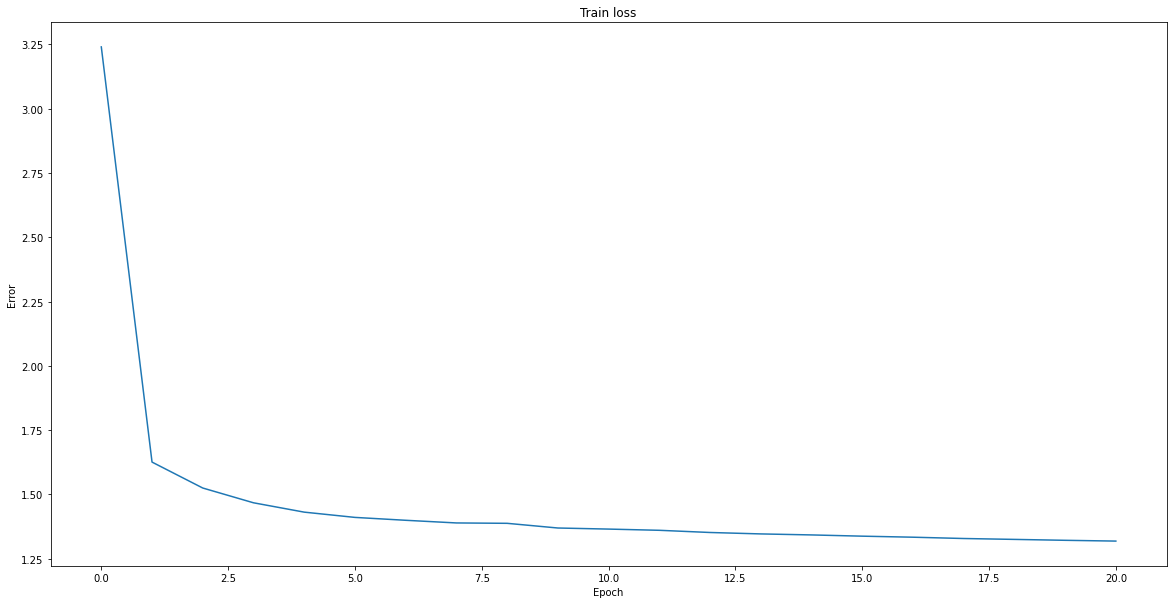

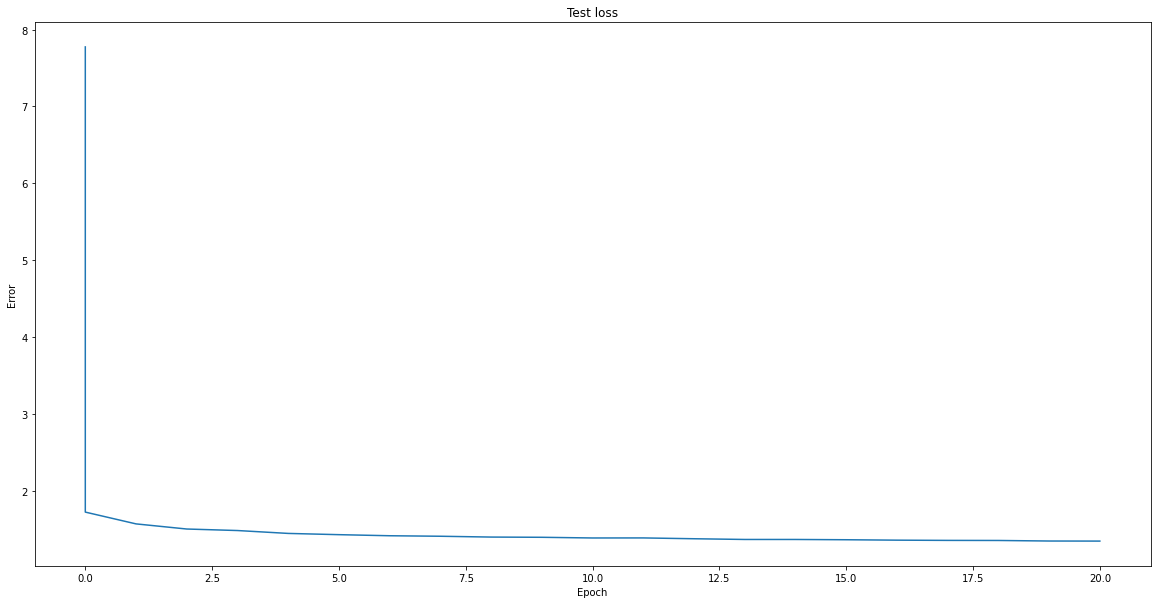

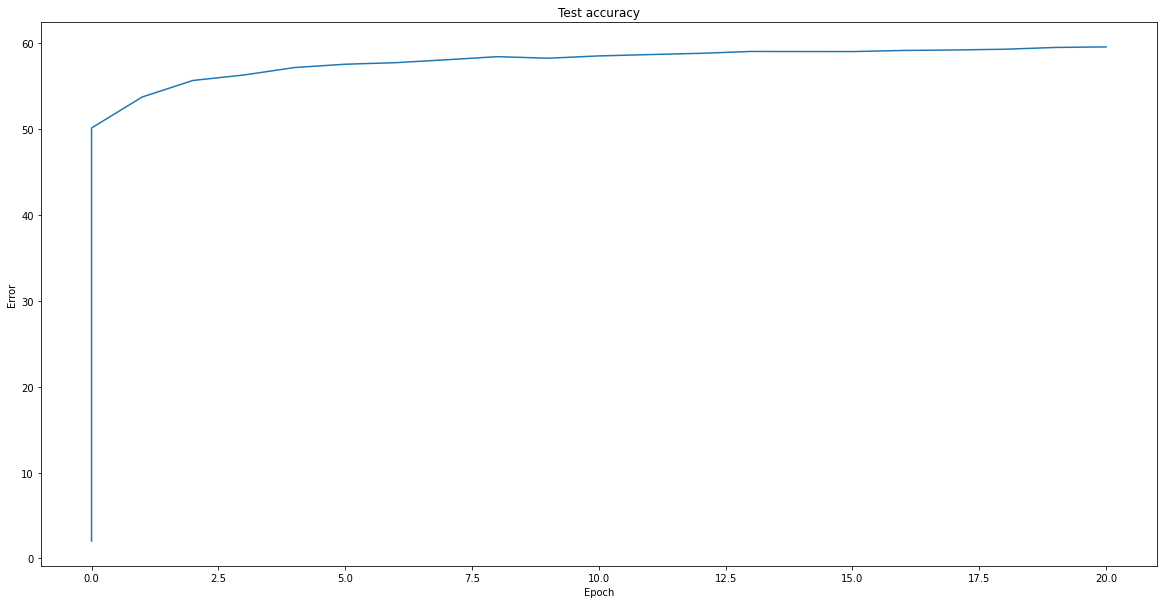

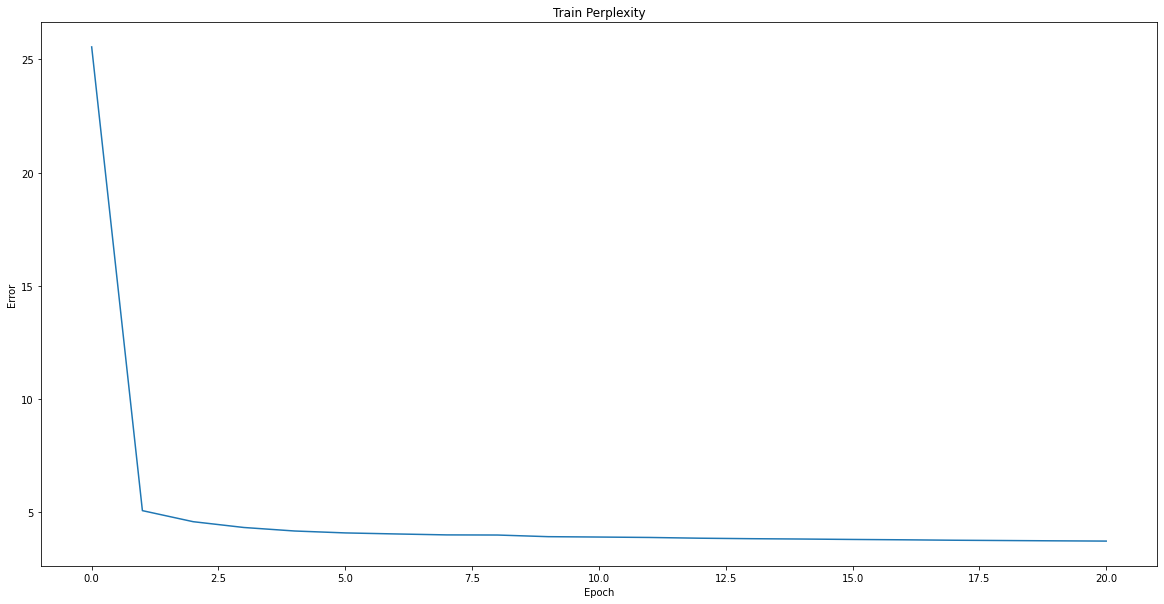

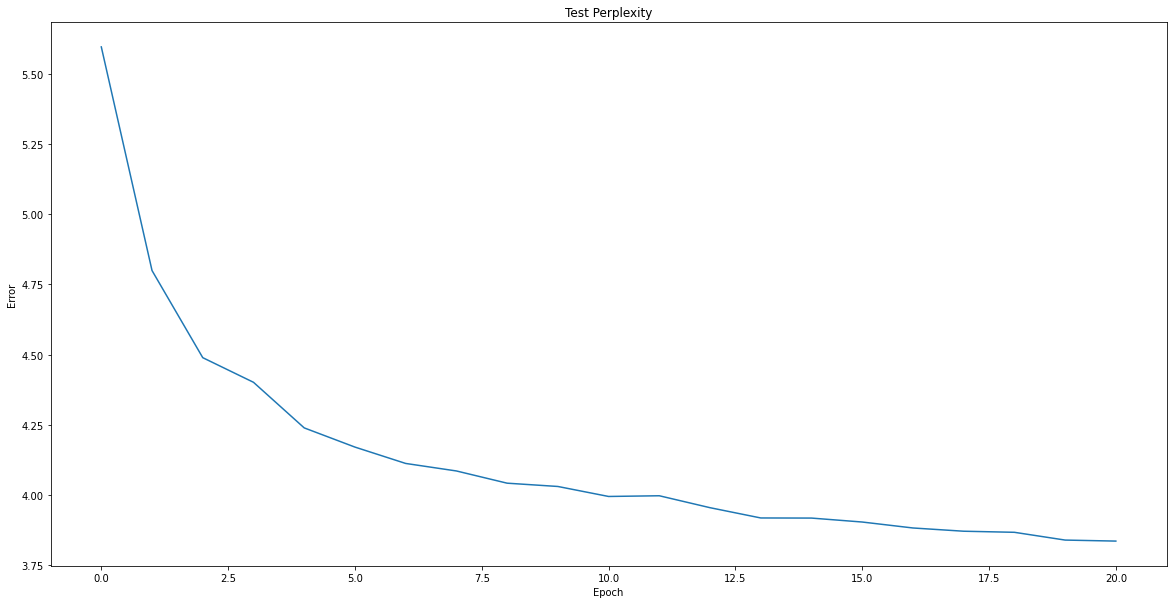

In [10]:
def better_network():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/better_log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    global device
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = BetterHarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    # train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    train_losses, test_losses, test_accuracies = [], [], []
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []
    # test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/better_%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/better_%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = better_network()

In [ ]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the one of the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on the door on 
generated with sample	 Harry Potter and them arounded disk; courney into their wandbed. Doing a carder on the Orius. "It was it? I don't repotten he interessered down to -thin! Sirius just one what it! this minvigus you d in support? Gorney. S
generated with sample	 Harry Potter and the only monty wonder. He would eavery fly.  "Ron'' the other work, Horings," he said down any the air and points wither the morning long, pointing too hims of the boak. Fred to and Hermione inchedgently
generated with sample	 Harry Potter and then Dumbledore's eyed desting the Houghat off you thin school fingers turned. "Kurs, do'," said Ron and Hermione a head, but his eye were only light and buttered as it of unzugestic on the fuirings putc
generated with sample	 Harr

## Part 8.6. Train a model on words instead of characters.

In [47]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # DONE Add more preprocessing
    data = re.sub(r"[\n\t\s]", " ", data)
    words = data.split(" ")

    voc2ind = {}
    word_cnt = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    cnt = 0
    voc2ind["<unknown>"] = cnt
    cnt += 1
    voc2ind[" "] = cnt
    cnt += 1

    for word in words:
        if word in voc2ind:
            word_cnt[word] += 1
        else:
            voc2ind[word] = cnt
            cnt += 1
            word_cnt[word] = 1
    
    text = []
    for word in words:
        if word_cnt[word] < 5:
            text.append(voc2ind["<unknown>"])
        else:
            text.append(voc2ind[word])

    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = text[:(int)(len(text) * 0.8)]
    test_text = text[(int)(len(text) * 0.8):]

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_words_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] + " " for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        words = re.sub(r"[\n\t\s]", " ", words)
        words = words.split(" ")
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)





 44%|████▍     | 154/351 [00:30<00:40,  4.87it/s]



 44%|████▍     | 155/351 [00:30<00:40,  4.85it/s]



 44%|████▍     | 156/351 [00:30<00:40,  4.78it/s]



 45%|████▍     | 157/351 [00:30<00:40,  4.83it/s]



 45%|████▌     | 158/351 [00:31<00:39,  4.85it/s]



 45%|████▌     | 159/351 [00:31<00:39,  4.85it/s]



 46%|████▌     | 160/351 [00:31<00:39,  4.82it/s]



 46%|████▌     | 161/351 [00:31<00:40,  4.68it/s]



 46%|████▌     | 162/351 [00:32<00:39,  4.84it/s]

Train Epoch: 13 [40960/89856 (46%)]	Loss: 5.666081	Perplexity: 328.816439






 46%|████▋     | 163/351 [00:32<00:38,  4.85it/s]



 47%|████▋     | 164/351 [00:32<00:38,  4.85it/s]



 47%|████▋     | 165/351 [00:32<00:38,  4.80it/s]



 47%|████▋     | 166/351 [00:32<00:38,  4.80it/s]



 48%|████▊     | 167/351 [00:33<00:38,  4.83it/s]



 48%|████▊     | 168/351 [00:33<00:37,  4.88it/s]



 48%|████▊     | 169/351 [00:33<00:37,  4.85it/s]



 48%|████▊     | 170/351 [00:33<00:37,  4.82it/s]



 49%|████▊     | 171/351 [00:33<00:38,  4.69it/s]



 49%|████▉     | 172/351 [00:34<00:36,  4.84it/s]

Train Epoch: 13 [43520/89856 (48%)]	Loss: 5.791075	Perplexity: 328.630235






 49%|████▉     | 173/351 [00:34<00:36,  4.85it/s]



 50%|████▉     | 174/351 [00:34<00:36,  4.83it/s]



 50%|████▉     | 175/351 [00:34<00:36,  4.80it/s]



 50%|█████     | 176/351 [00:34<00:36,  4.76it/s]



 50%|█████     | 177/351 [00:35<00:36,  4.82it/s]



 51%|█████     | 178/351 [00:35<00:35,  4.85it/s]



 51%|█████     | 179/351 [00:35<00:35,  4.86it/s]



 51%|█████▏    | 180/351 [00:35<00:35,  4.82it/s]



 52%|█████▏    | 181/351 [00:35<00:36,  4.68it/s]



 52%|█████▏    | 182/351 [00:36<00:34,  4.86it/s]

Train Epoch: 13 [46080/89856 (51%)]	Loss: 5.817147	Perplexity: 328.417946






 52%|█████▏    | 183/351 [00:36<00:34,  4.88it/s]



 52%|█████▏    | 184/351 [00:36<00:34,  4.87it/s]



 53%|█████▎    | 185/351 [00:36<00:34,  4.83it/s]



 53%|█████▎    | 186/351 [00:37<00:34,  4.79it/s]



 53%|█████▎    | 187/351 [00:37<00:33,  4.83it/s]



 54%|█████▎    | 188/351 [00:37<00:33,  4.85it/s]



 54%|█████▍    | 189/351 [00:37<00:33,  4.85it/s]



 54%|█████▍    | 190/351 [00:37<00:33,  4.80it/s]



 54%|█████▍    | 191/351 [00:38<00:34,  4.70it/s]



 55%|█████▍    | 192/351 [00:38<00:32,  4.85it/s]

Train Epoch: 13 [48640/89856 (54%)]	Loss: 5.773459	Perplexity: 328.023237






 55%|█████▍    | 193/351 [00:38<00:32,  4.89it/s]



 55%|█████▌    | 194/351 [00:38<00:32,  4.87it/s]

Interrupted
Saving final model
Saved /content/checkpoints/word_013.pt



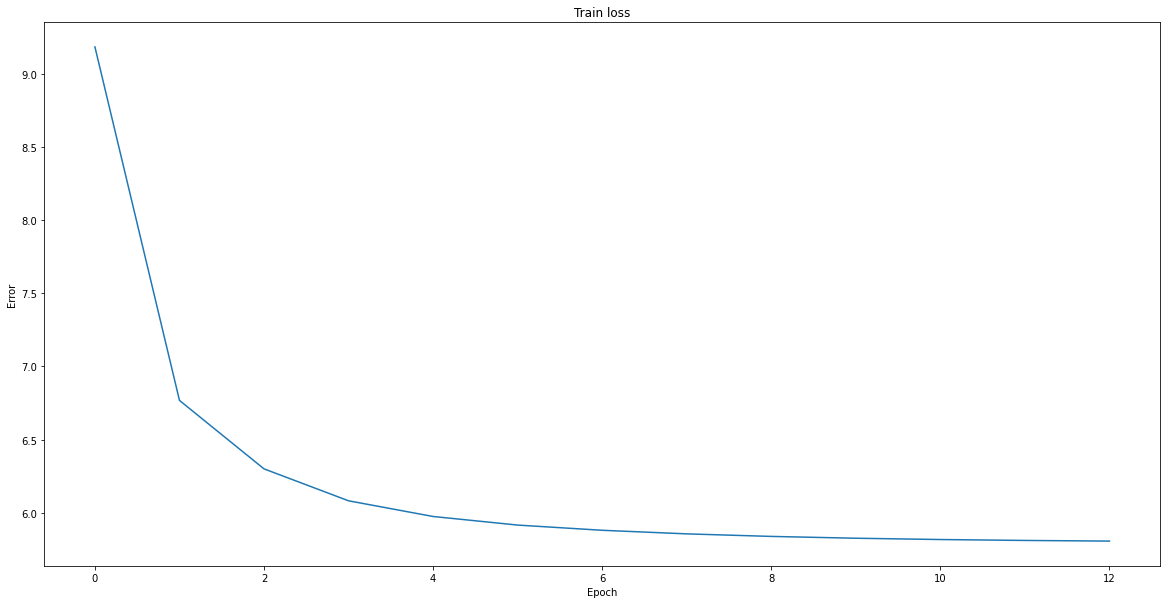

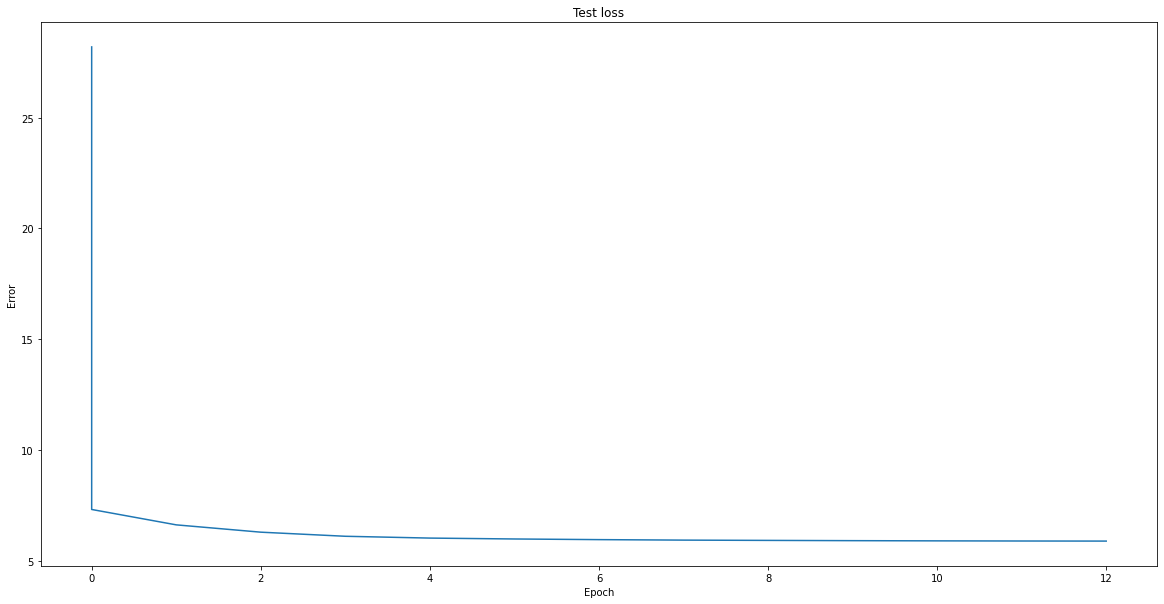

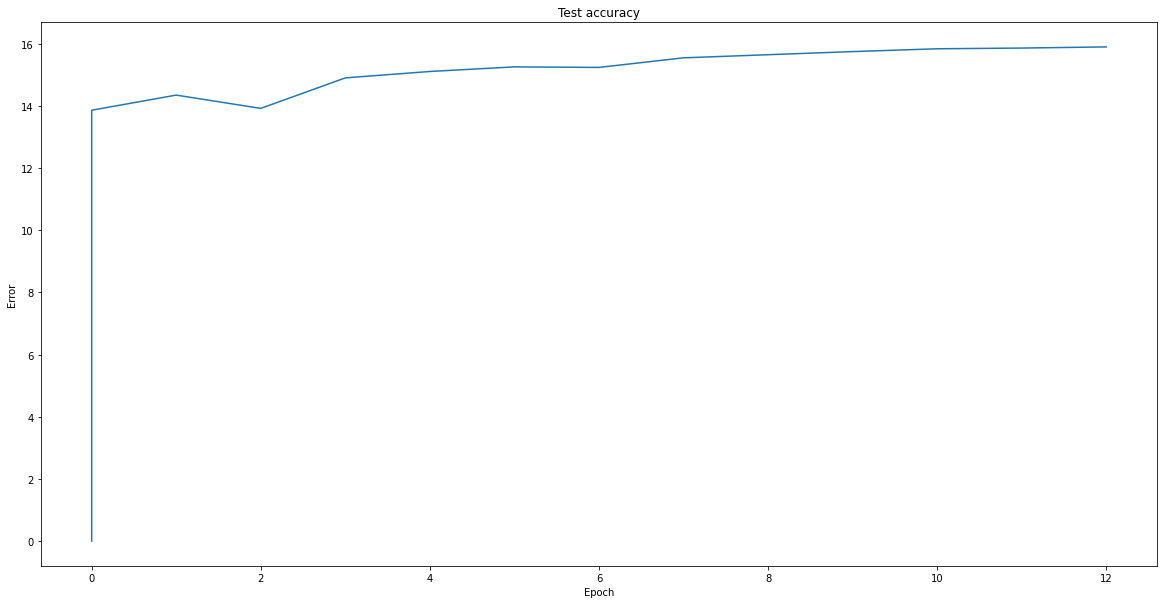

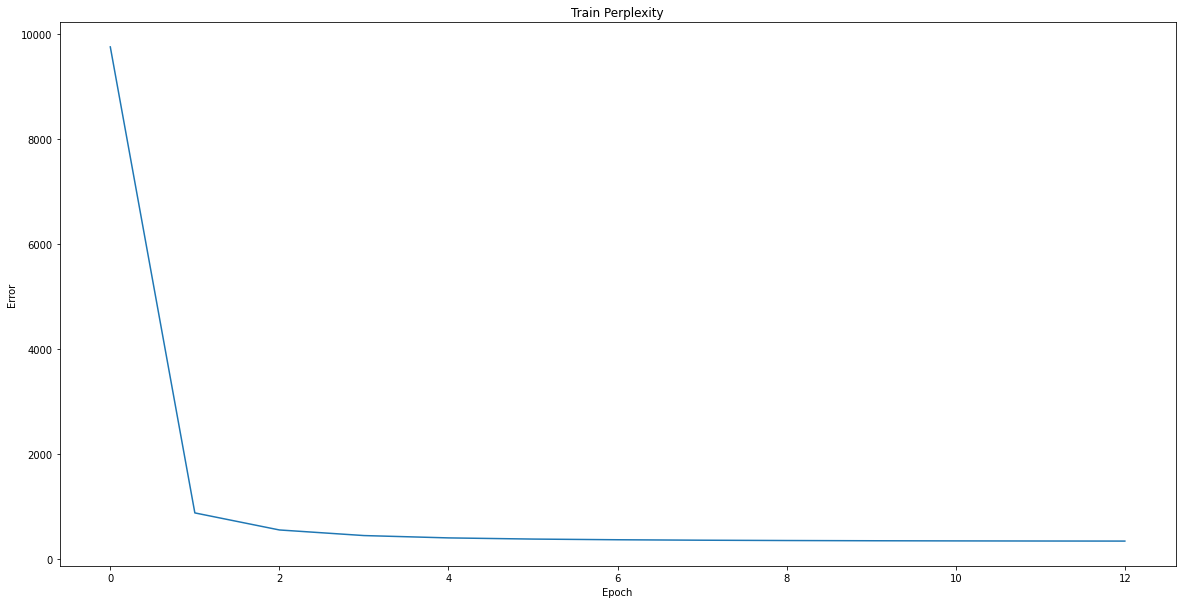

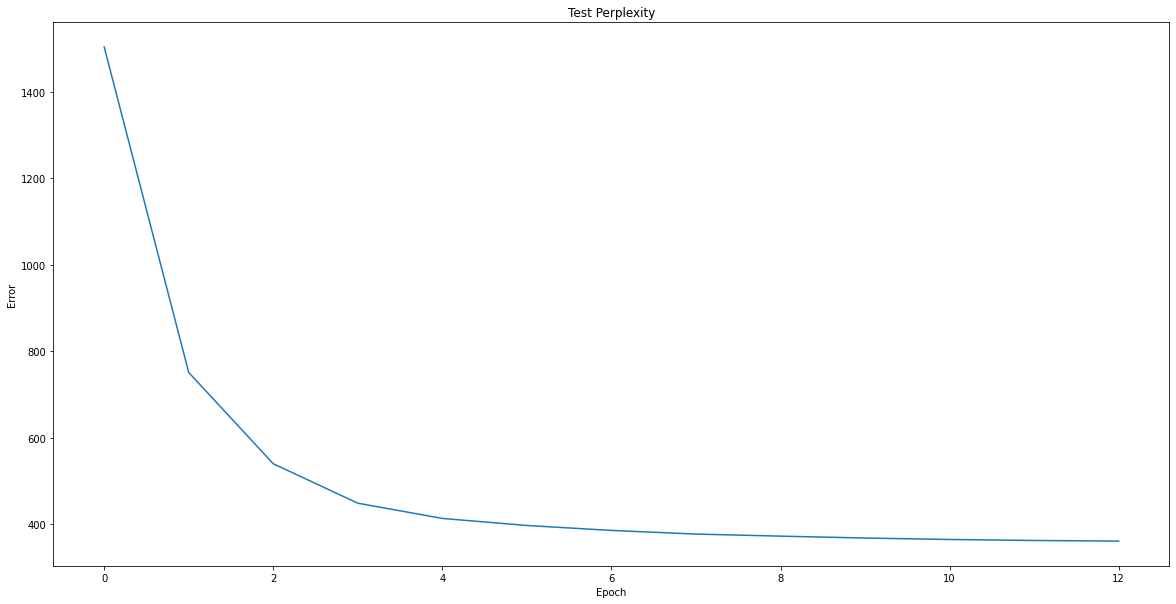

In [48]:
def word_network():
    SEQUENCE_LENGTH = 10
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/word_log.pkl'

    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_words_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_words_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    global device
    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')
    start_epoch = 0

    # train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    train_losses, test_losses, test_accuracies = [], [], []
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexities = []
    test_perplexities = []
    # test_perplexities.append((start_epoch, test_perplexity))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/word_%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/word_%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = word_network()

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.

    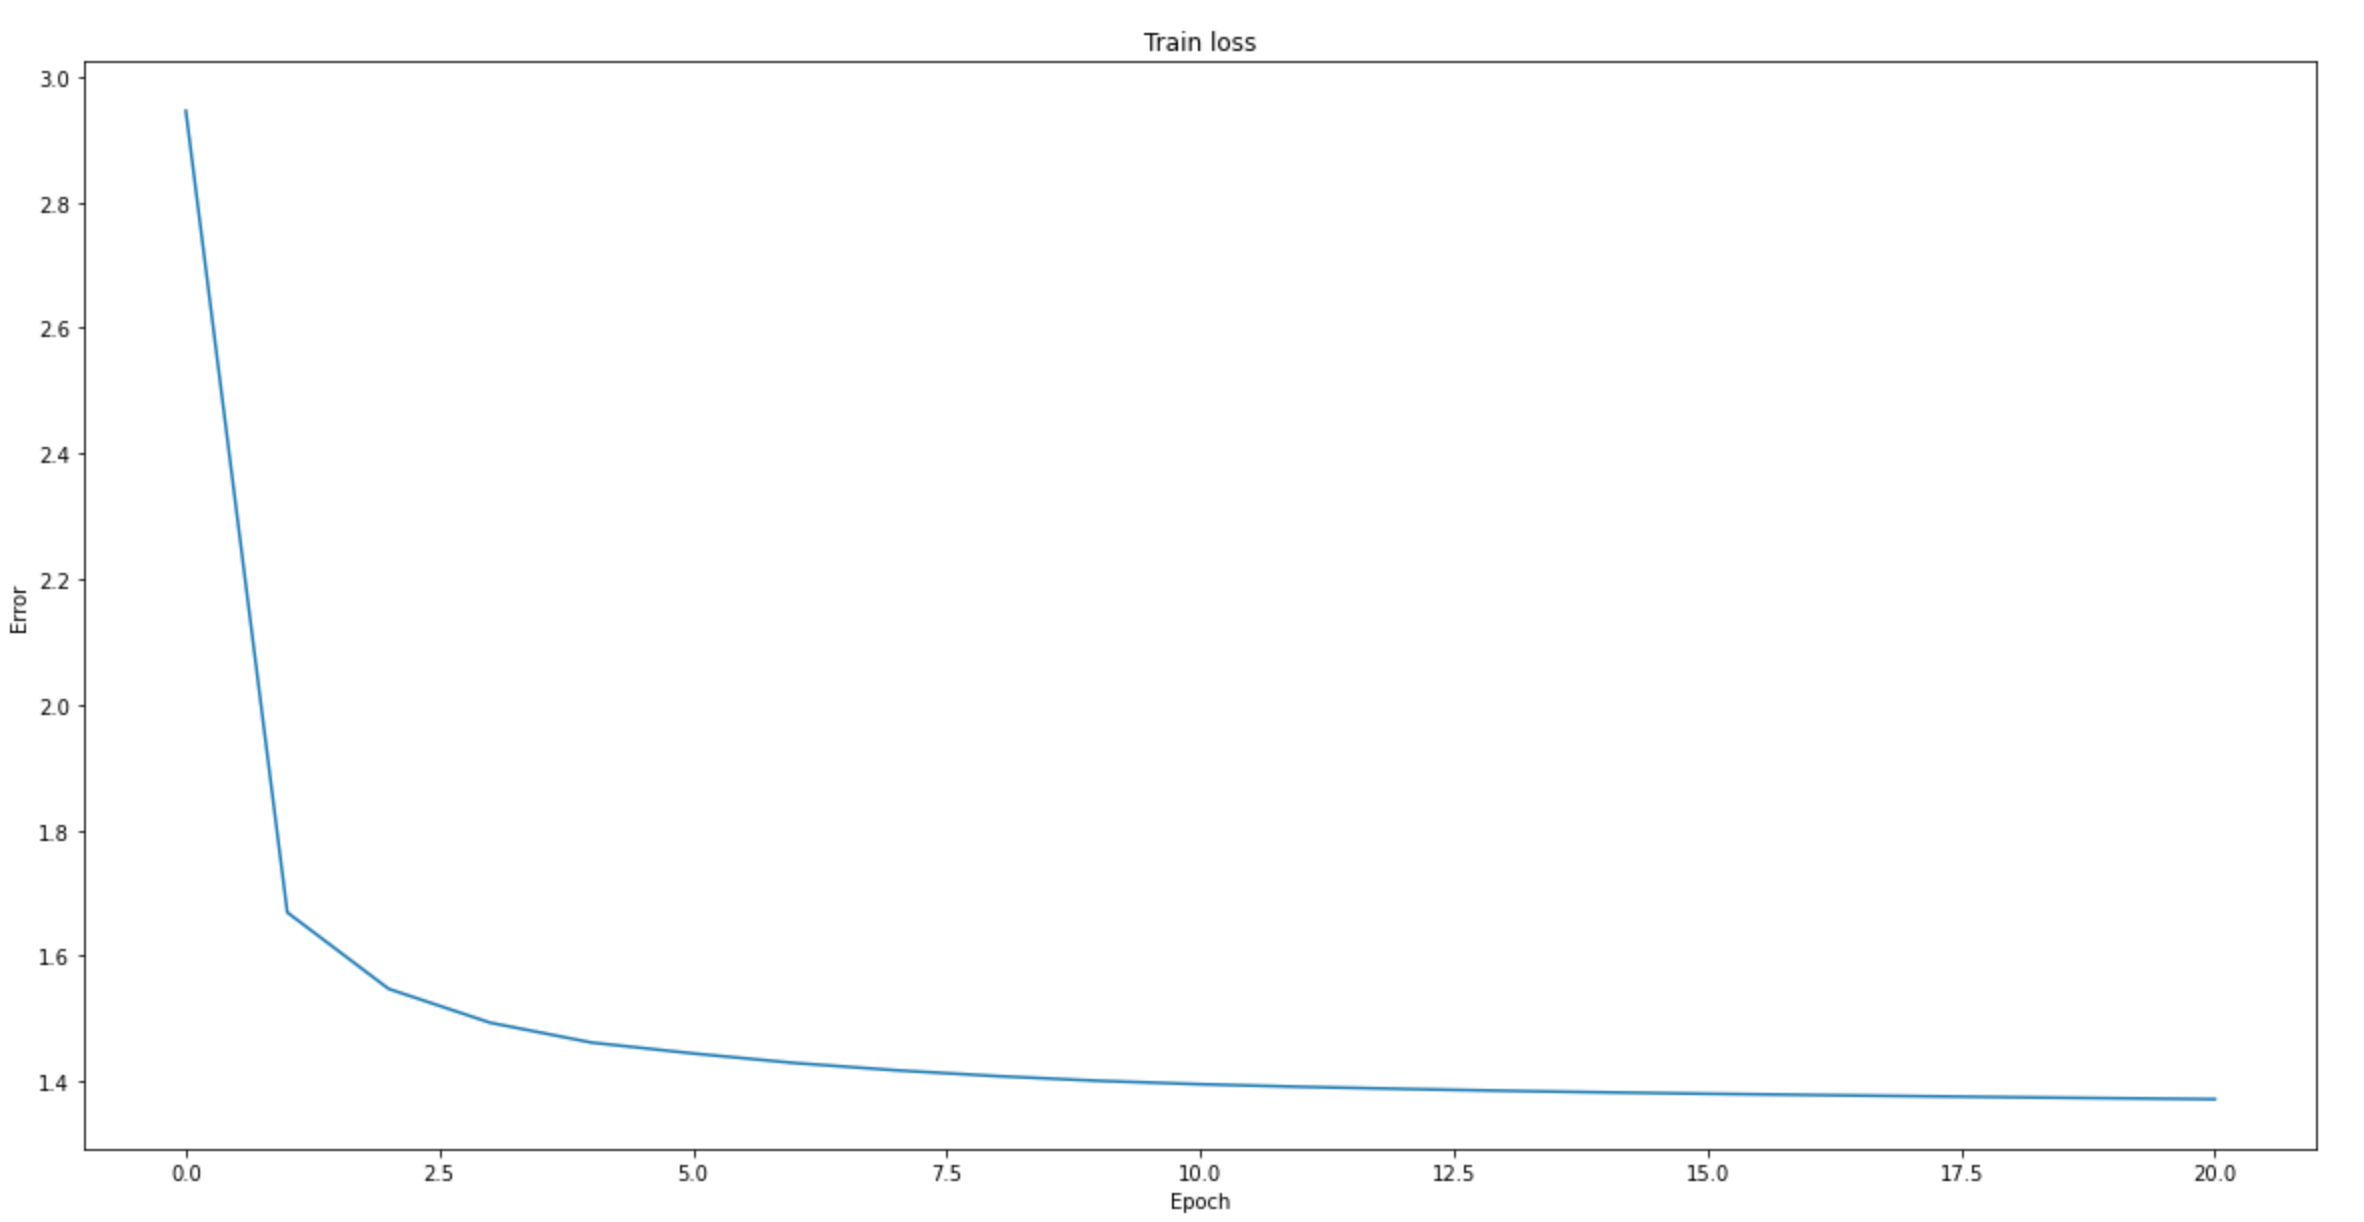
    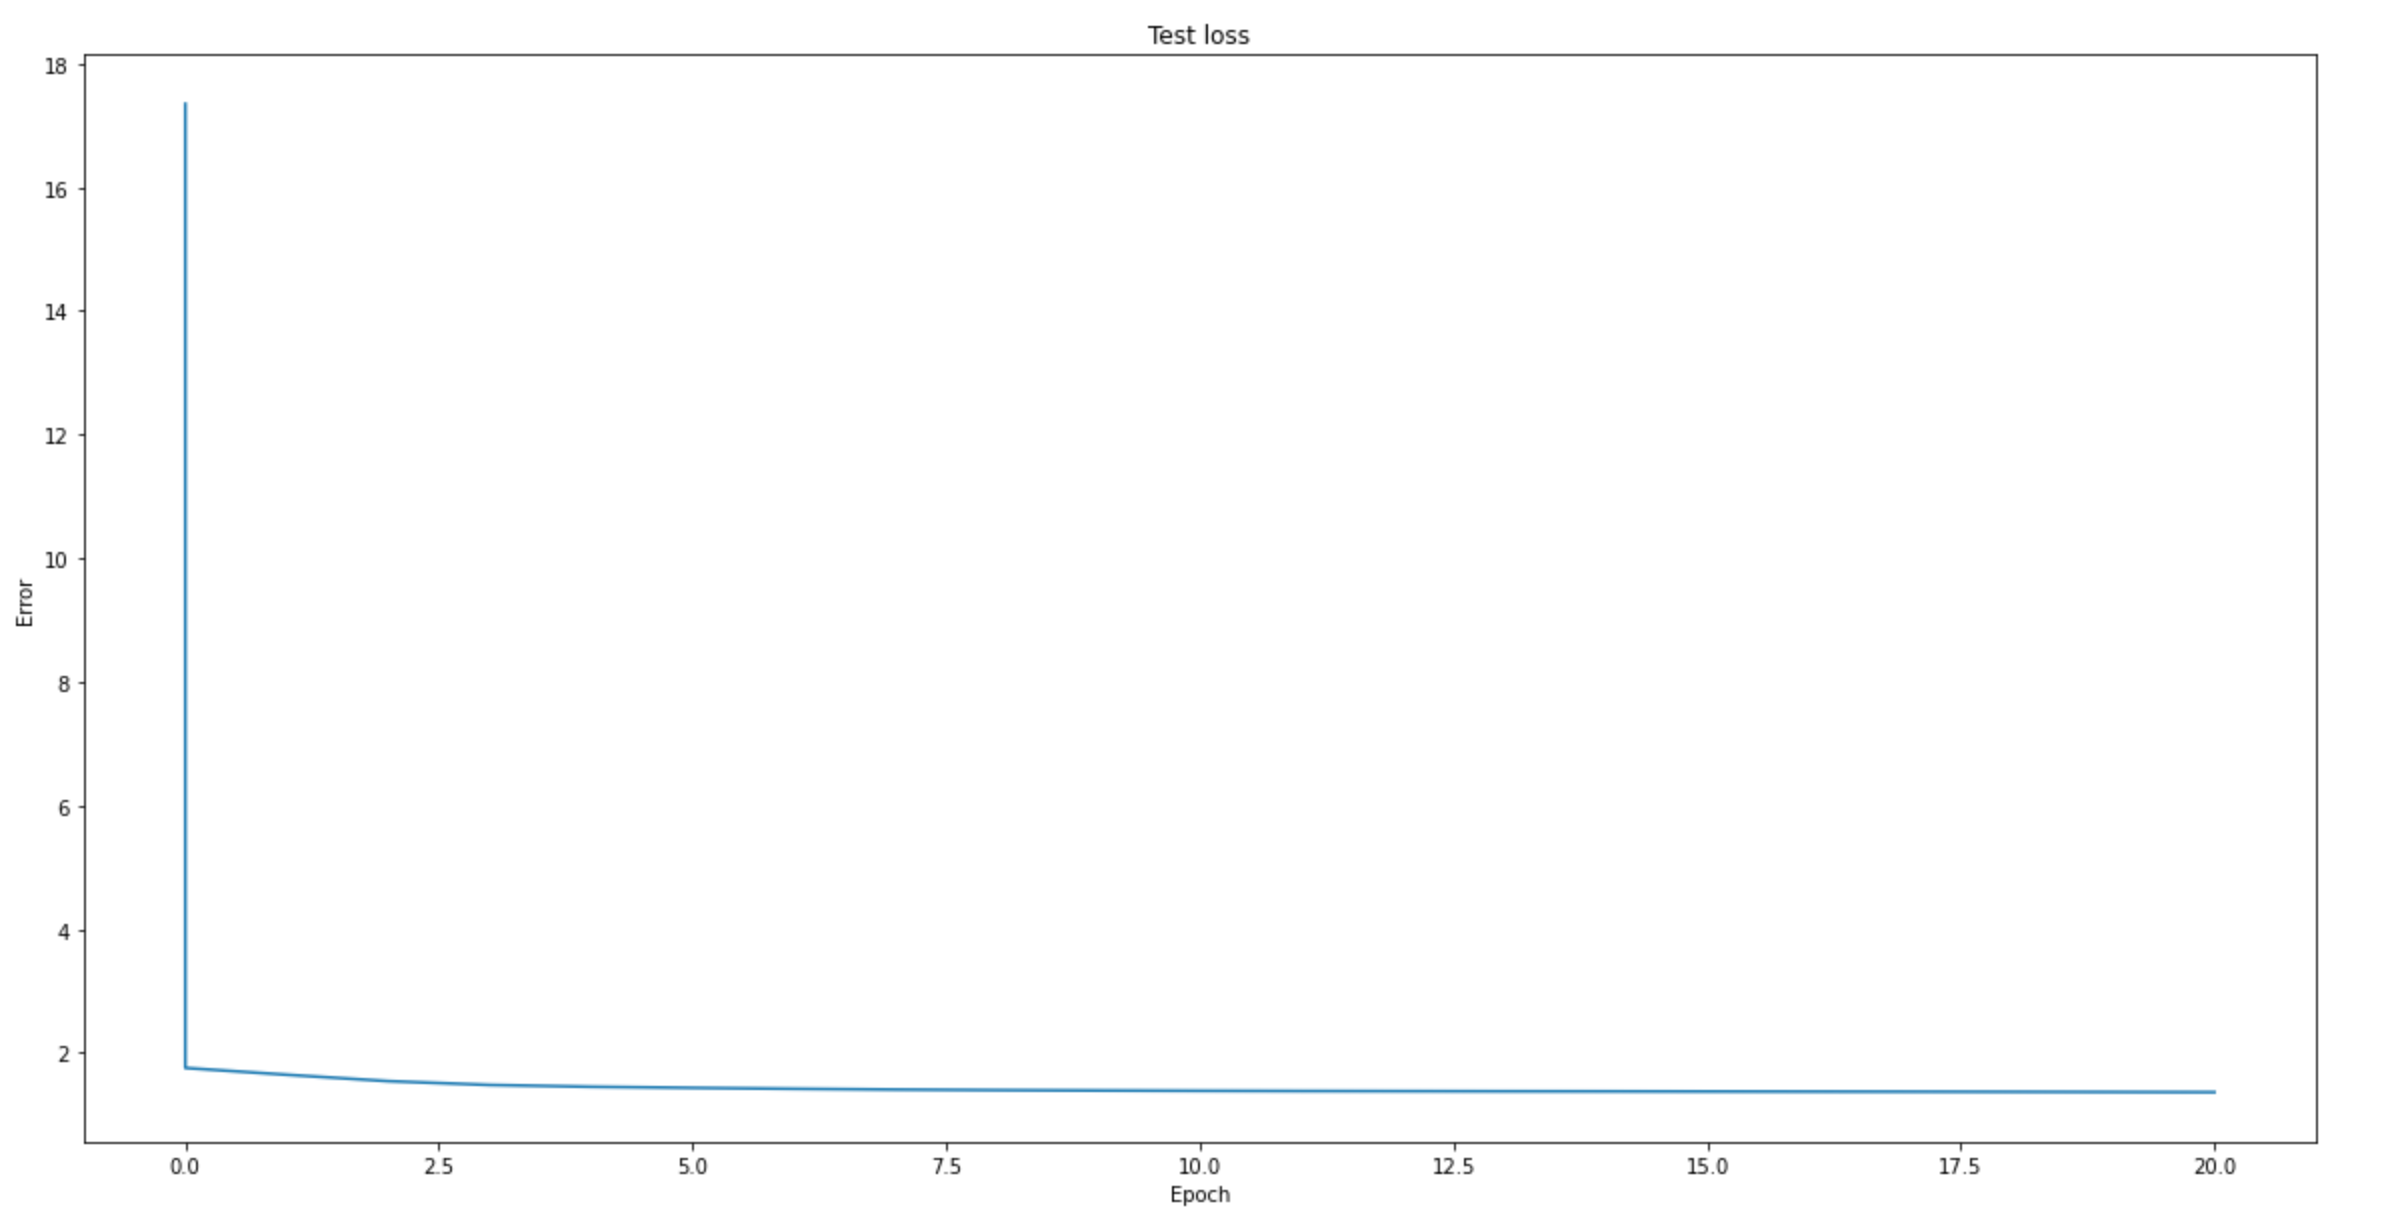
    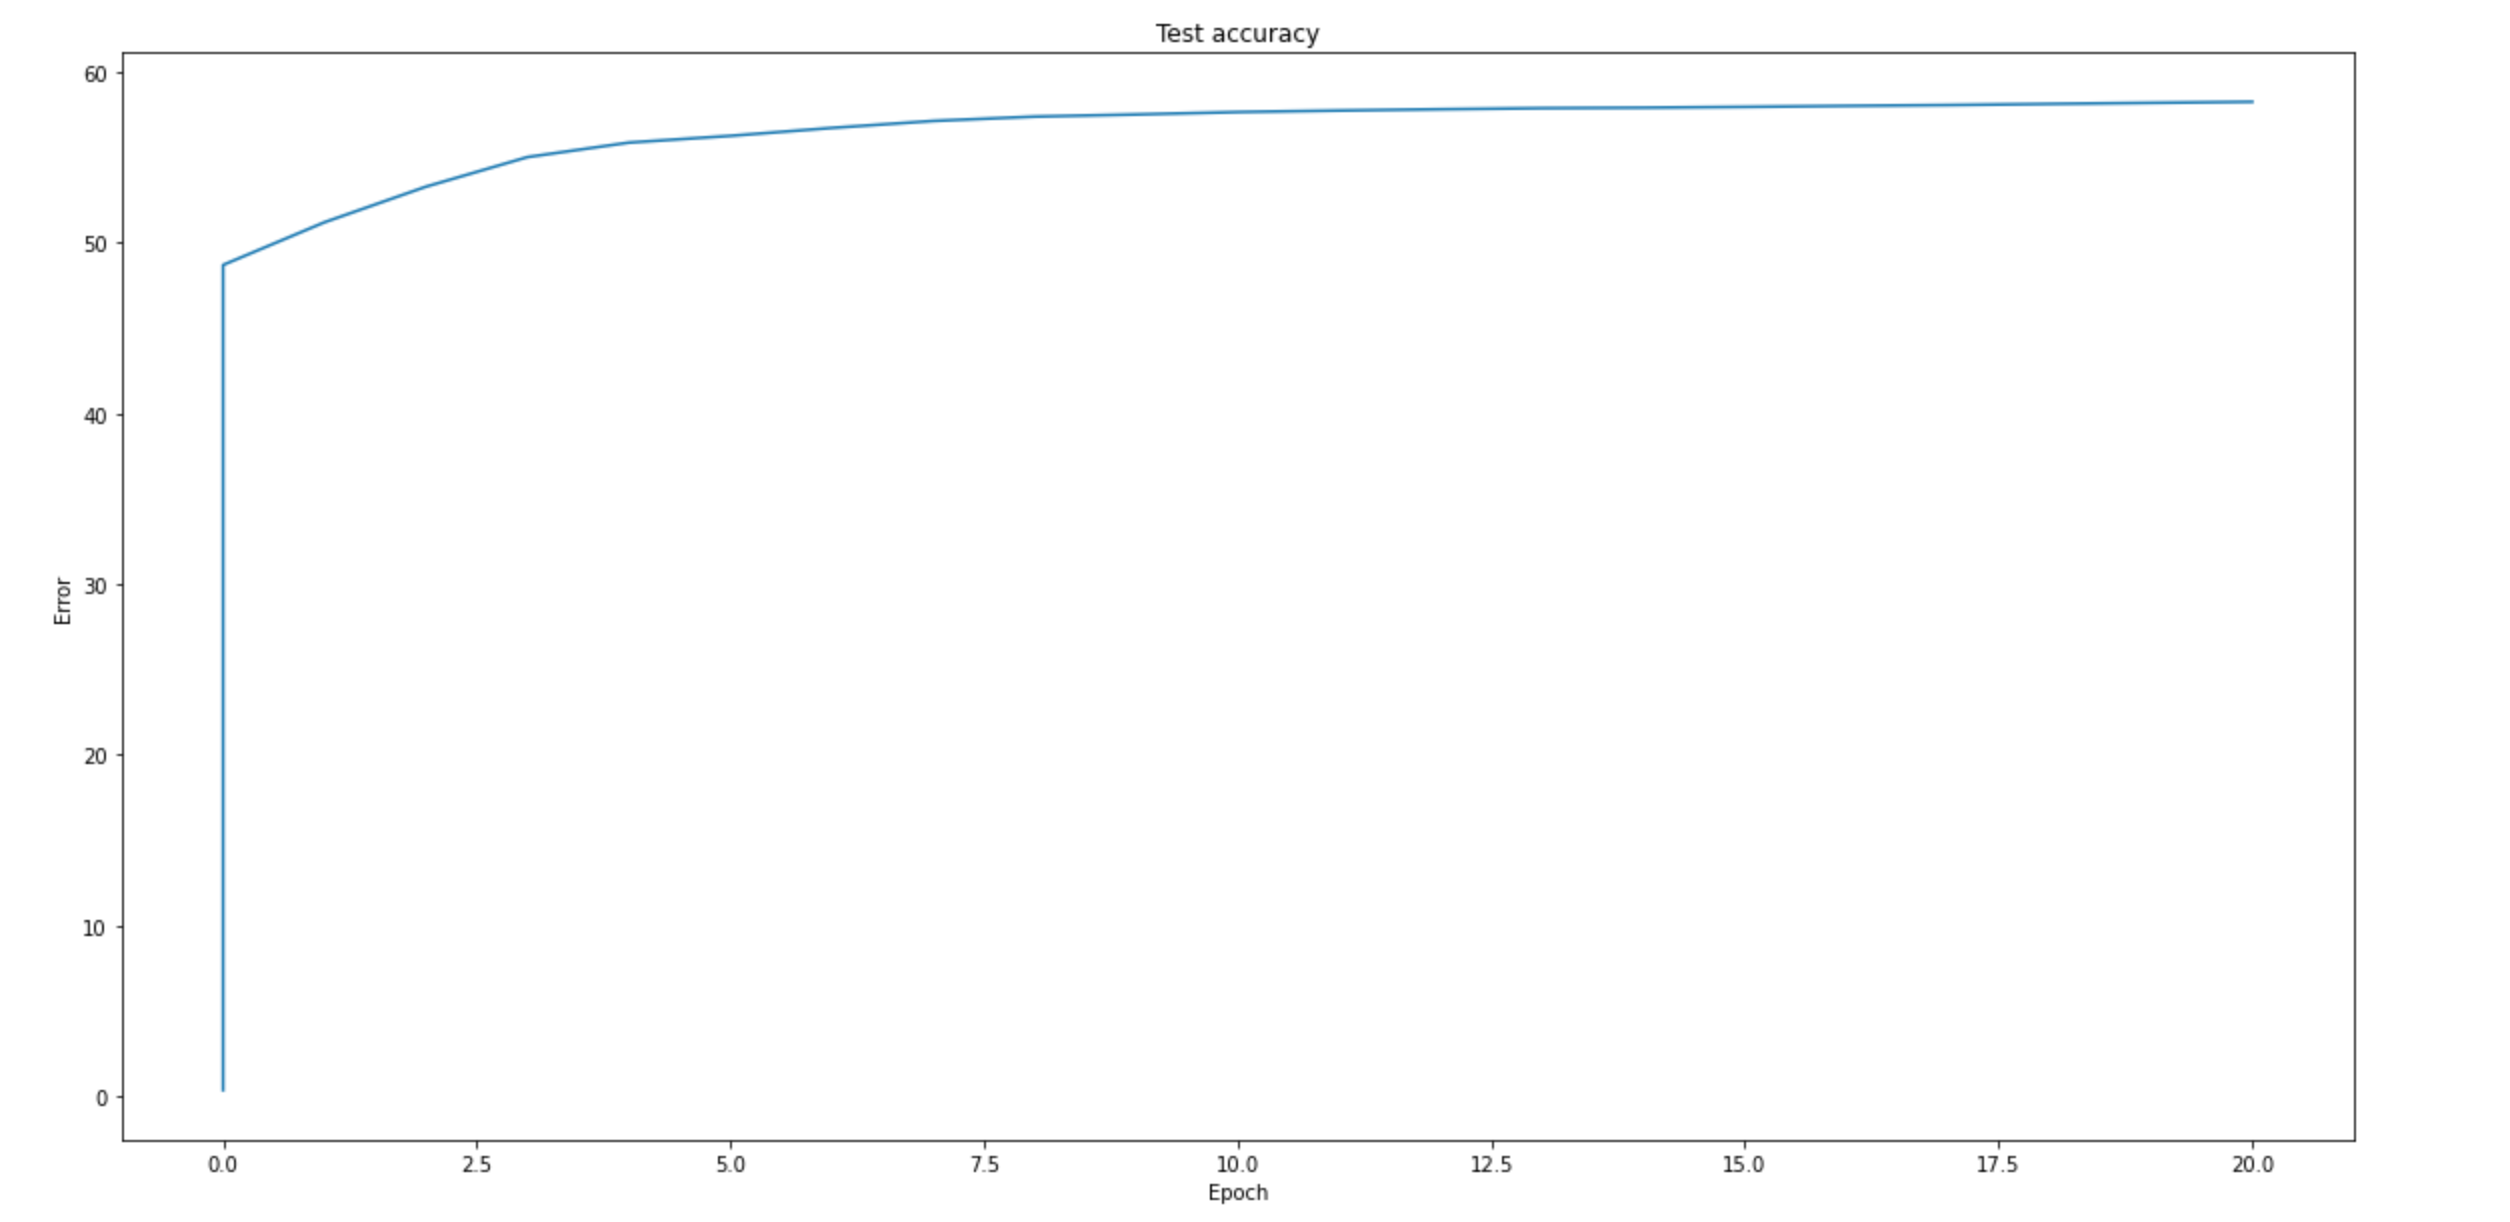
    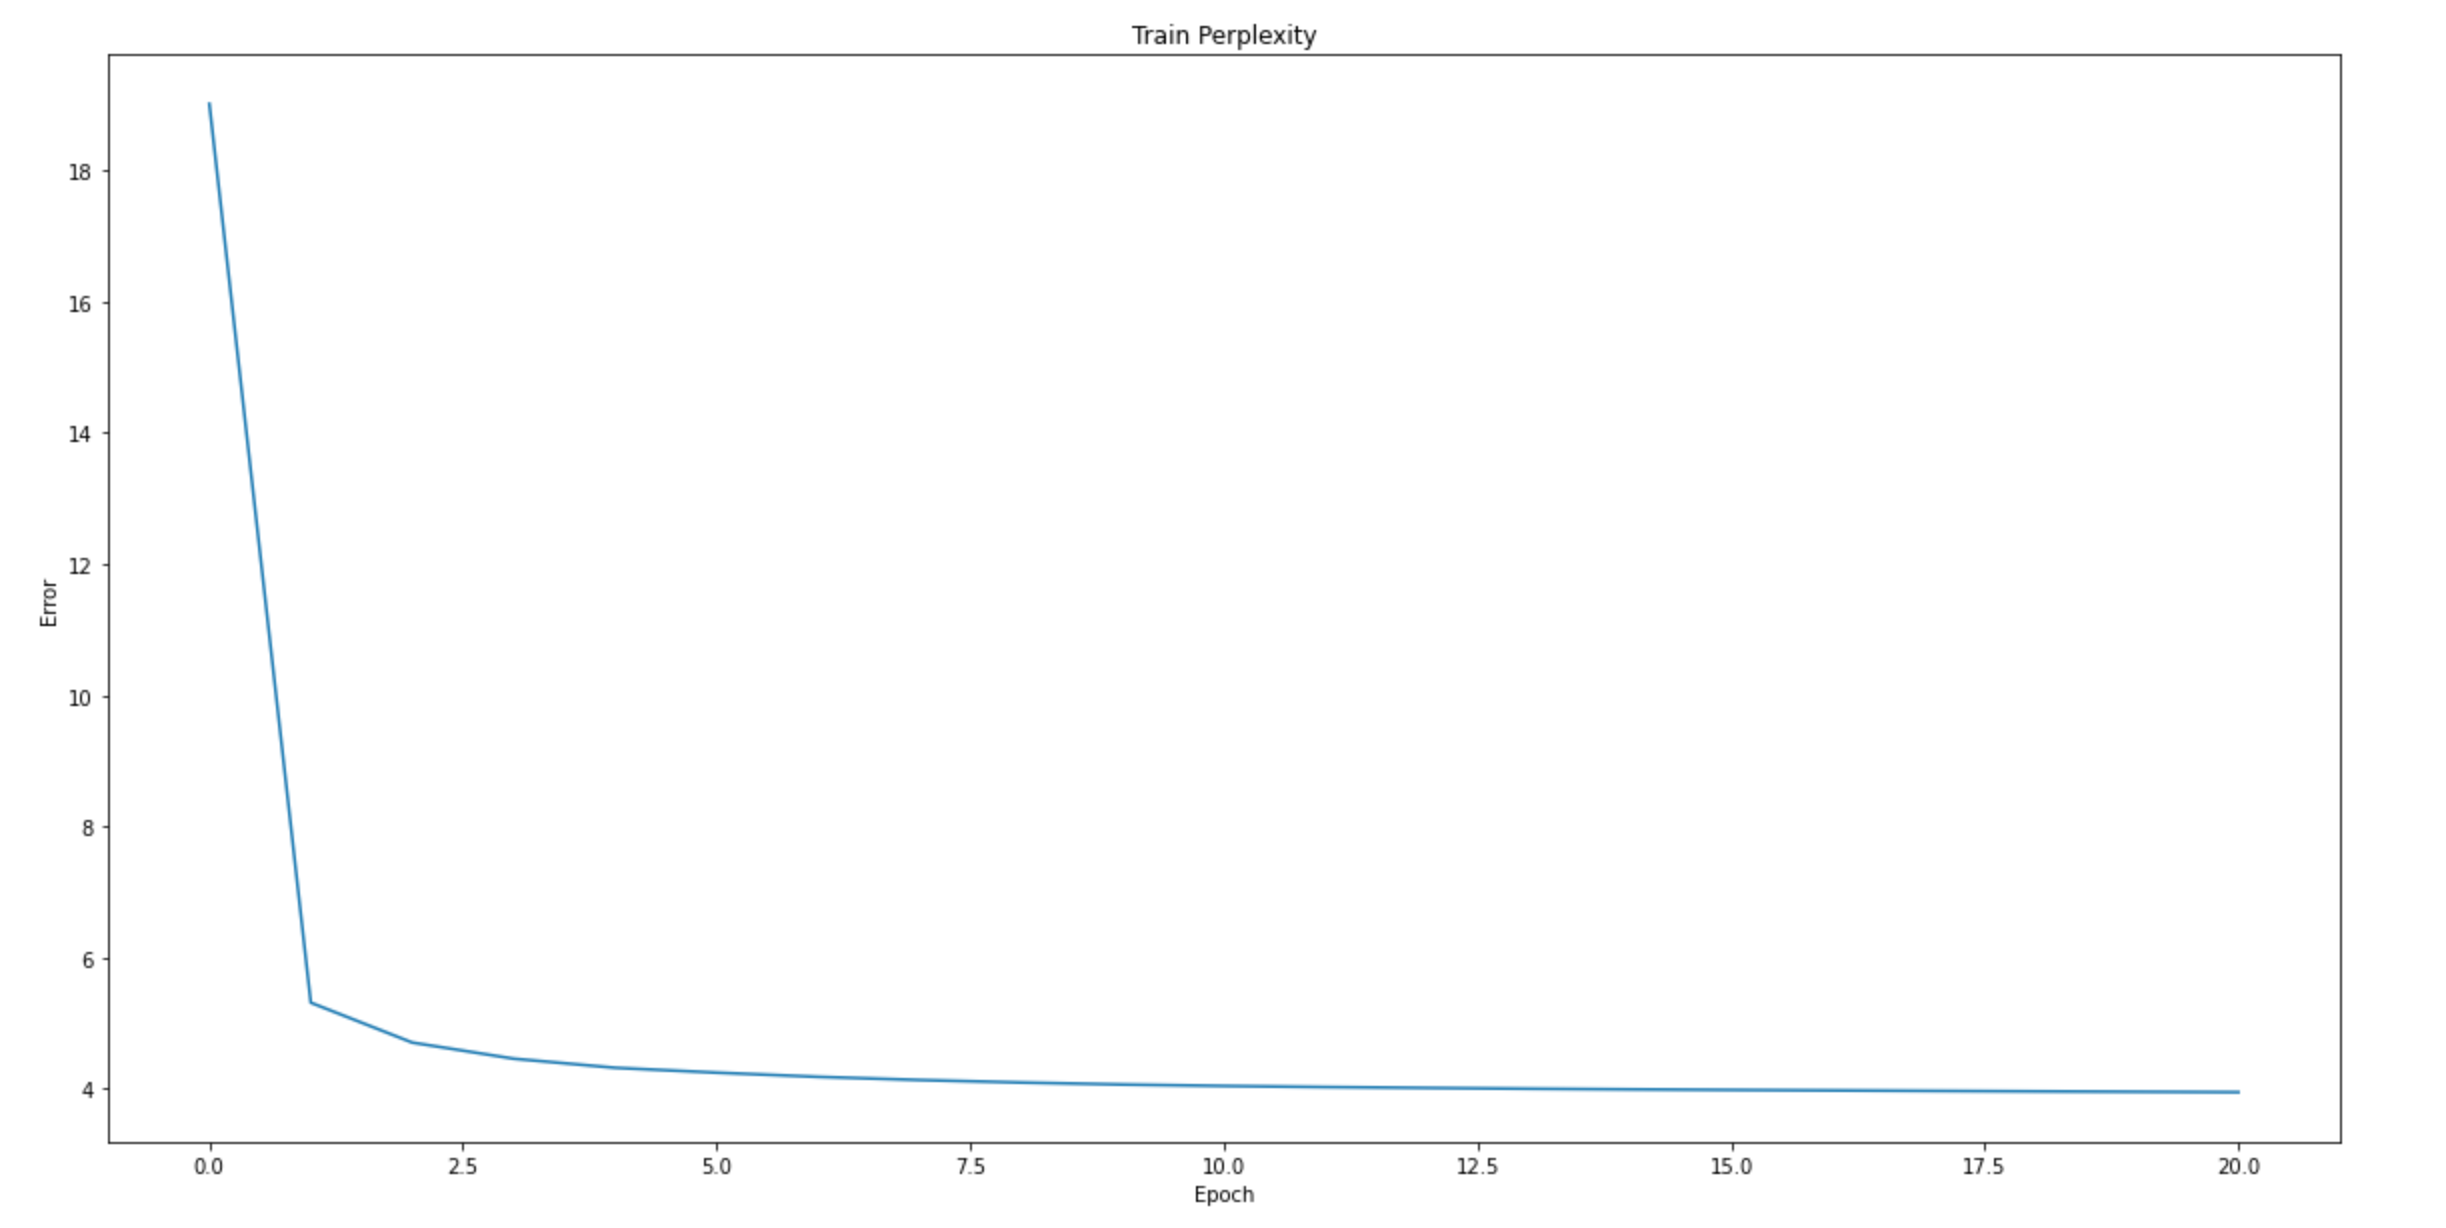
    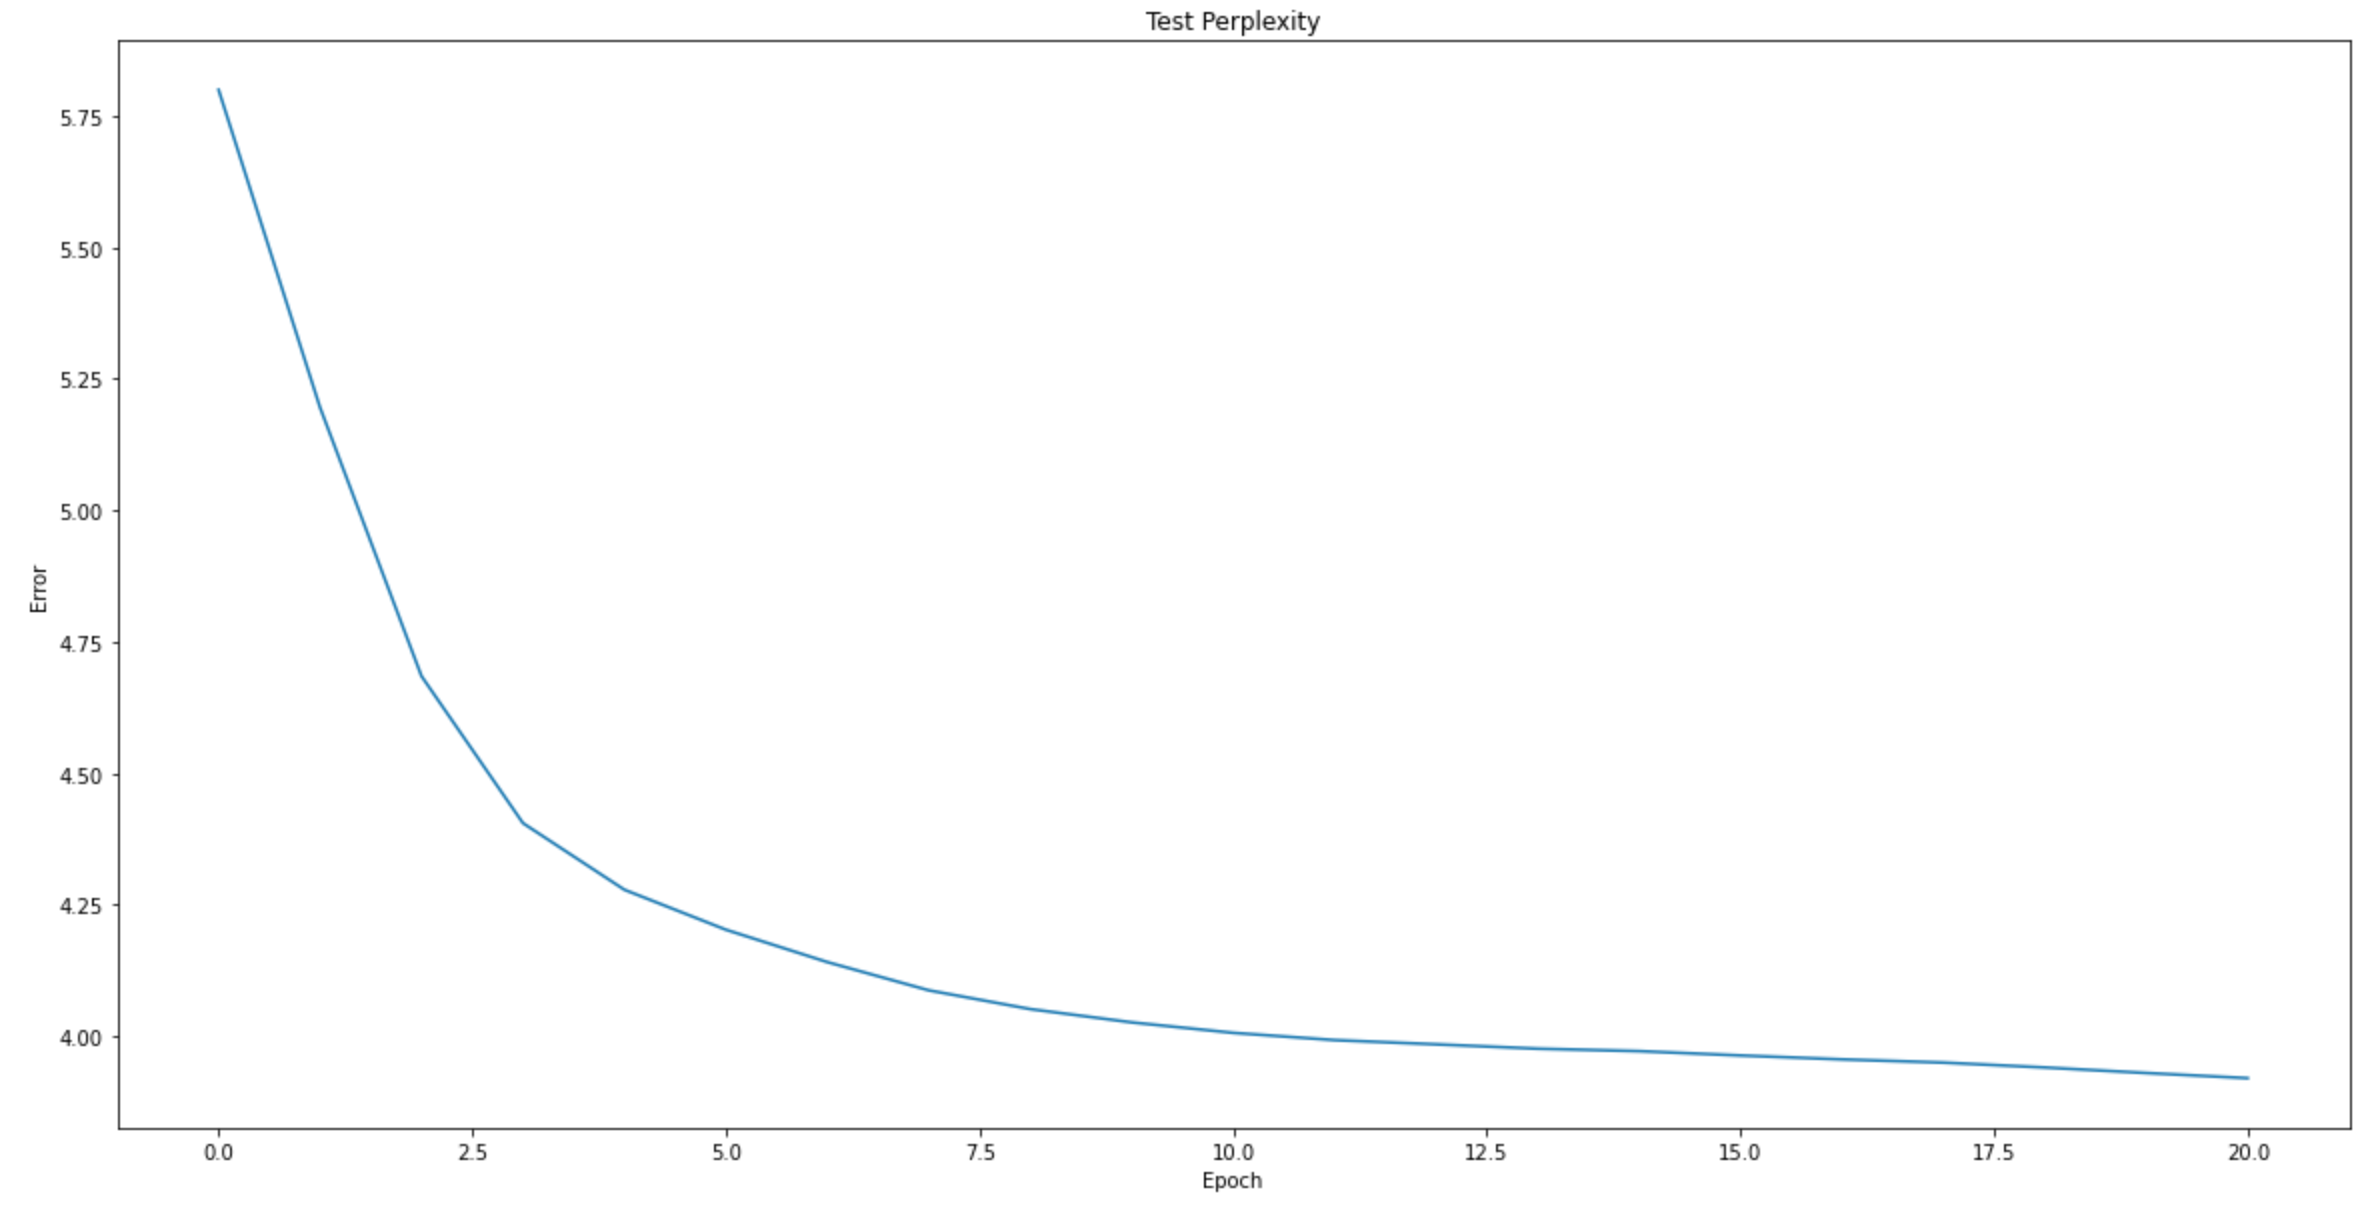
    
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameter.
    
    I changed the batch size to 512, learning rate to .1, but they didn't work better than the original setting.

    
2. What was your final test accuracy? What was your final test perplexity?

    Final test accuracy: 746519/1254400 (60%), perplexity: 3.881708.

3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?

    max: Harry Potter and the train to his for the stairs and the stairs and the stairs and the stairs was still standing at the top of the train and the train to his for the stairs and the stairs and the stairs was still standin

    sample: Harry Potter and the mobble worses were ballowed nock around the floor line door at the caublood by clin and again, go watcring that. Neething that George preded everyone would going to give to this man and Grance laug

    beam: Harry Potter and the only dail, and stared to have foont of the Durgle powed how when he work the three gaspleas seem even not hin. He thout the Snitchen around happys and fire moved he else to the larger. ", jupin had
    
    Prompt: "Harry Potter and the"

4. Which sampling method seemed to generate the best results? Why do you think that is?

    Beam search. It combines the advantages of "max" (keeping the most probable results) and "sample" (introducing randomness in the results).

5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    When temperture is 0.5, I have the best results.
    
    e.g.: Harry Potter and the pull right like through the Sirlur Knape were paning the exeral tanglet as a knew of the air. Harry coked out a floor. Herhaps was no moment that one of the Slays only goblet and shoen-for school. I 

    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
    A temperature of 0 picks the next character with the most probability.
    A 0 < temperature < 1 adds randomness.
    A temperature of 1 doesn't affect the original probability distribution.
    A temperature > 1 decrease confidence, and infinite temperature corresponds to a uniform sampling.
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    
    I used the text of game of thrones. It has 9059718 tokens.
    
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    
    They have different vocabularies and written by different authors, so the wording and styling of language generated was different.
    
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
    Temperature: 0.5.
    
    max: Jon Snow who was not to see him a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song so
    
    sample: Jon Snow was abrout of the Preen, Whree-’ sword pits in /urdenly, she comes, sort that sig2,” Lannisters said his house Lord rakking his eyes. “Mamonsy?”  Yon and many and his own. Jhis possing beside his son
    
    beam: Jon Snow almost and last light, but wheely hated her head. You had must mean to scrept up the dathous good so, and I do four little treason to Aot SingYs, Dadowahed;  Their days a quade threats. Caveleson Theo

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    
    I add one layer of GRU, so it was a 2-layer stacked GRU. The final test accuracy was 0.60.
    
    I tried simly increasing num_features to 1024. It did not work well, the final test accuracy was only 0.57.
    
    2. What was your lowest test perplexity? Provide training and testing plots.
    
    My lowest test perplexity was 3.836612.
    
    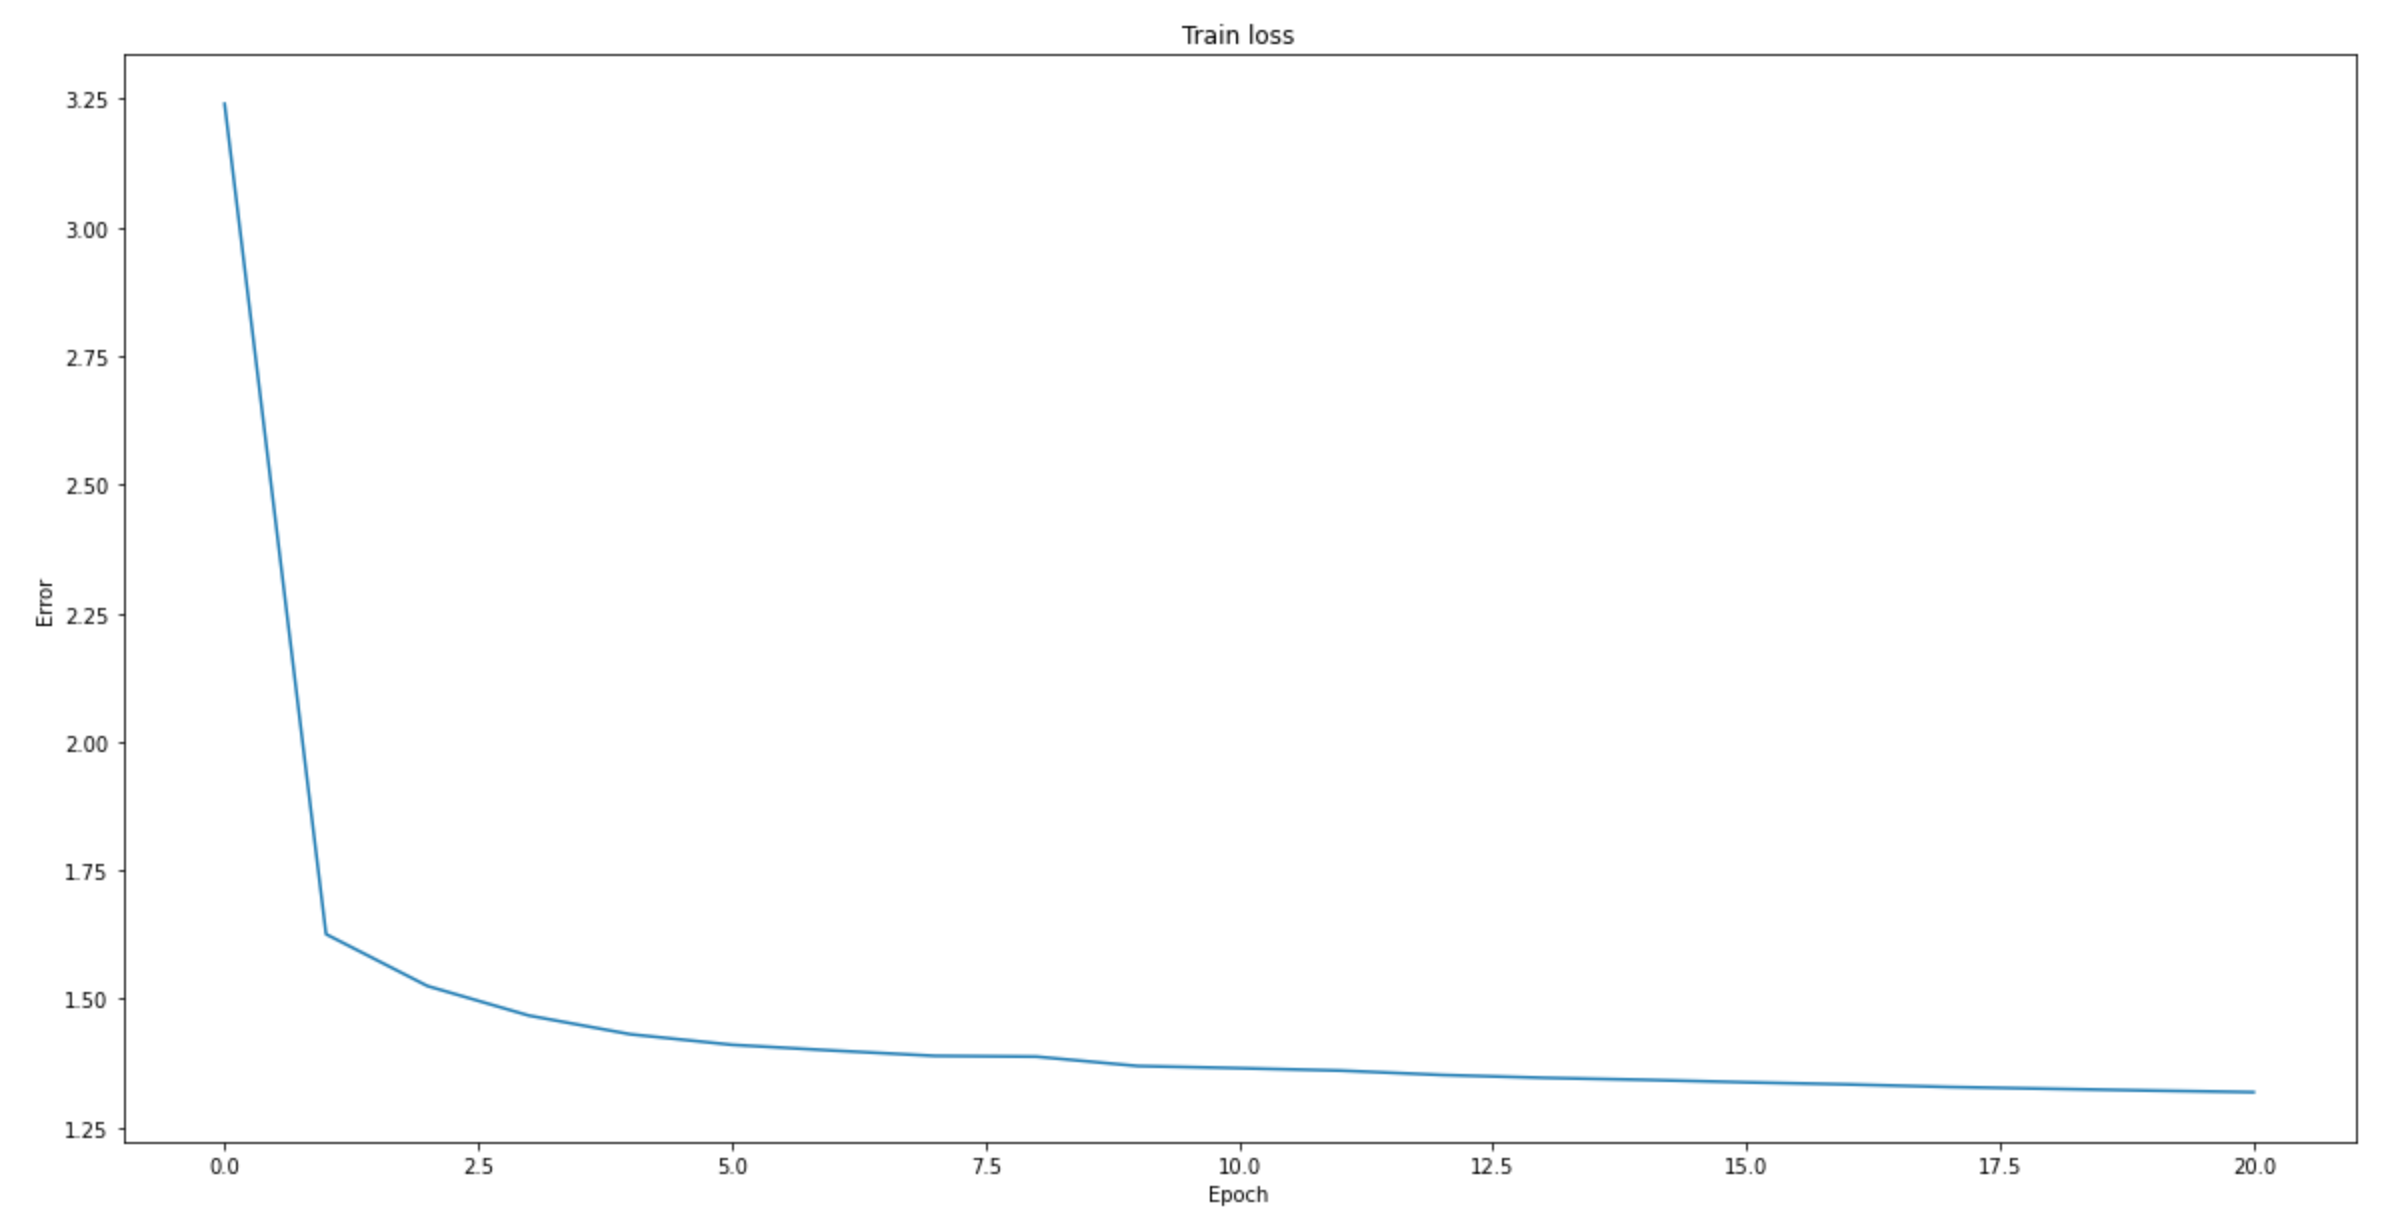
    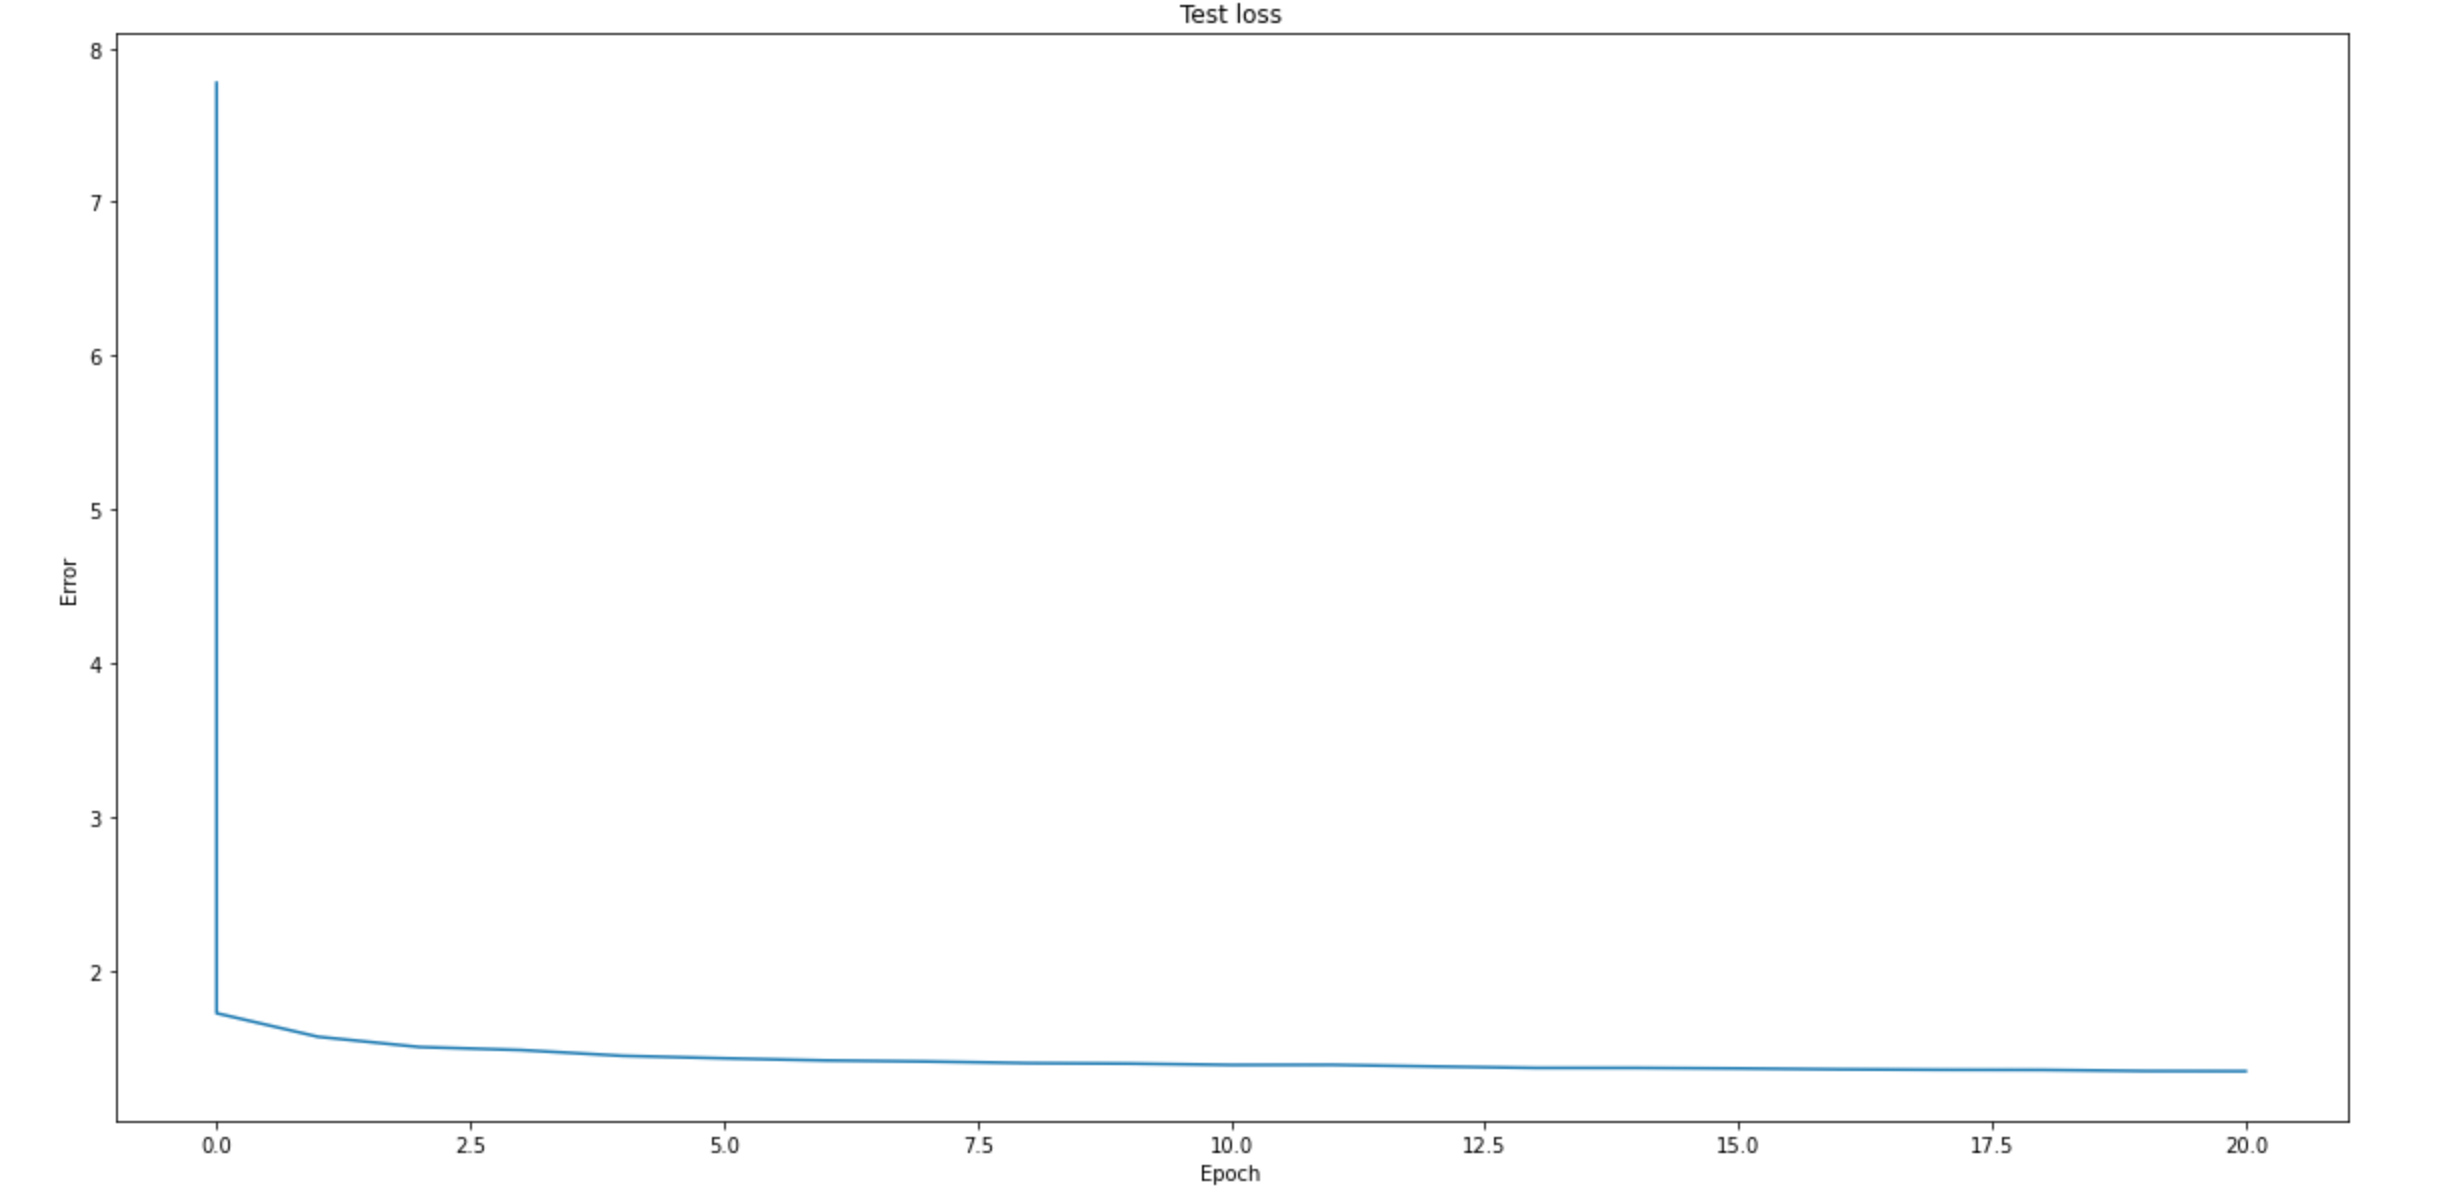
    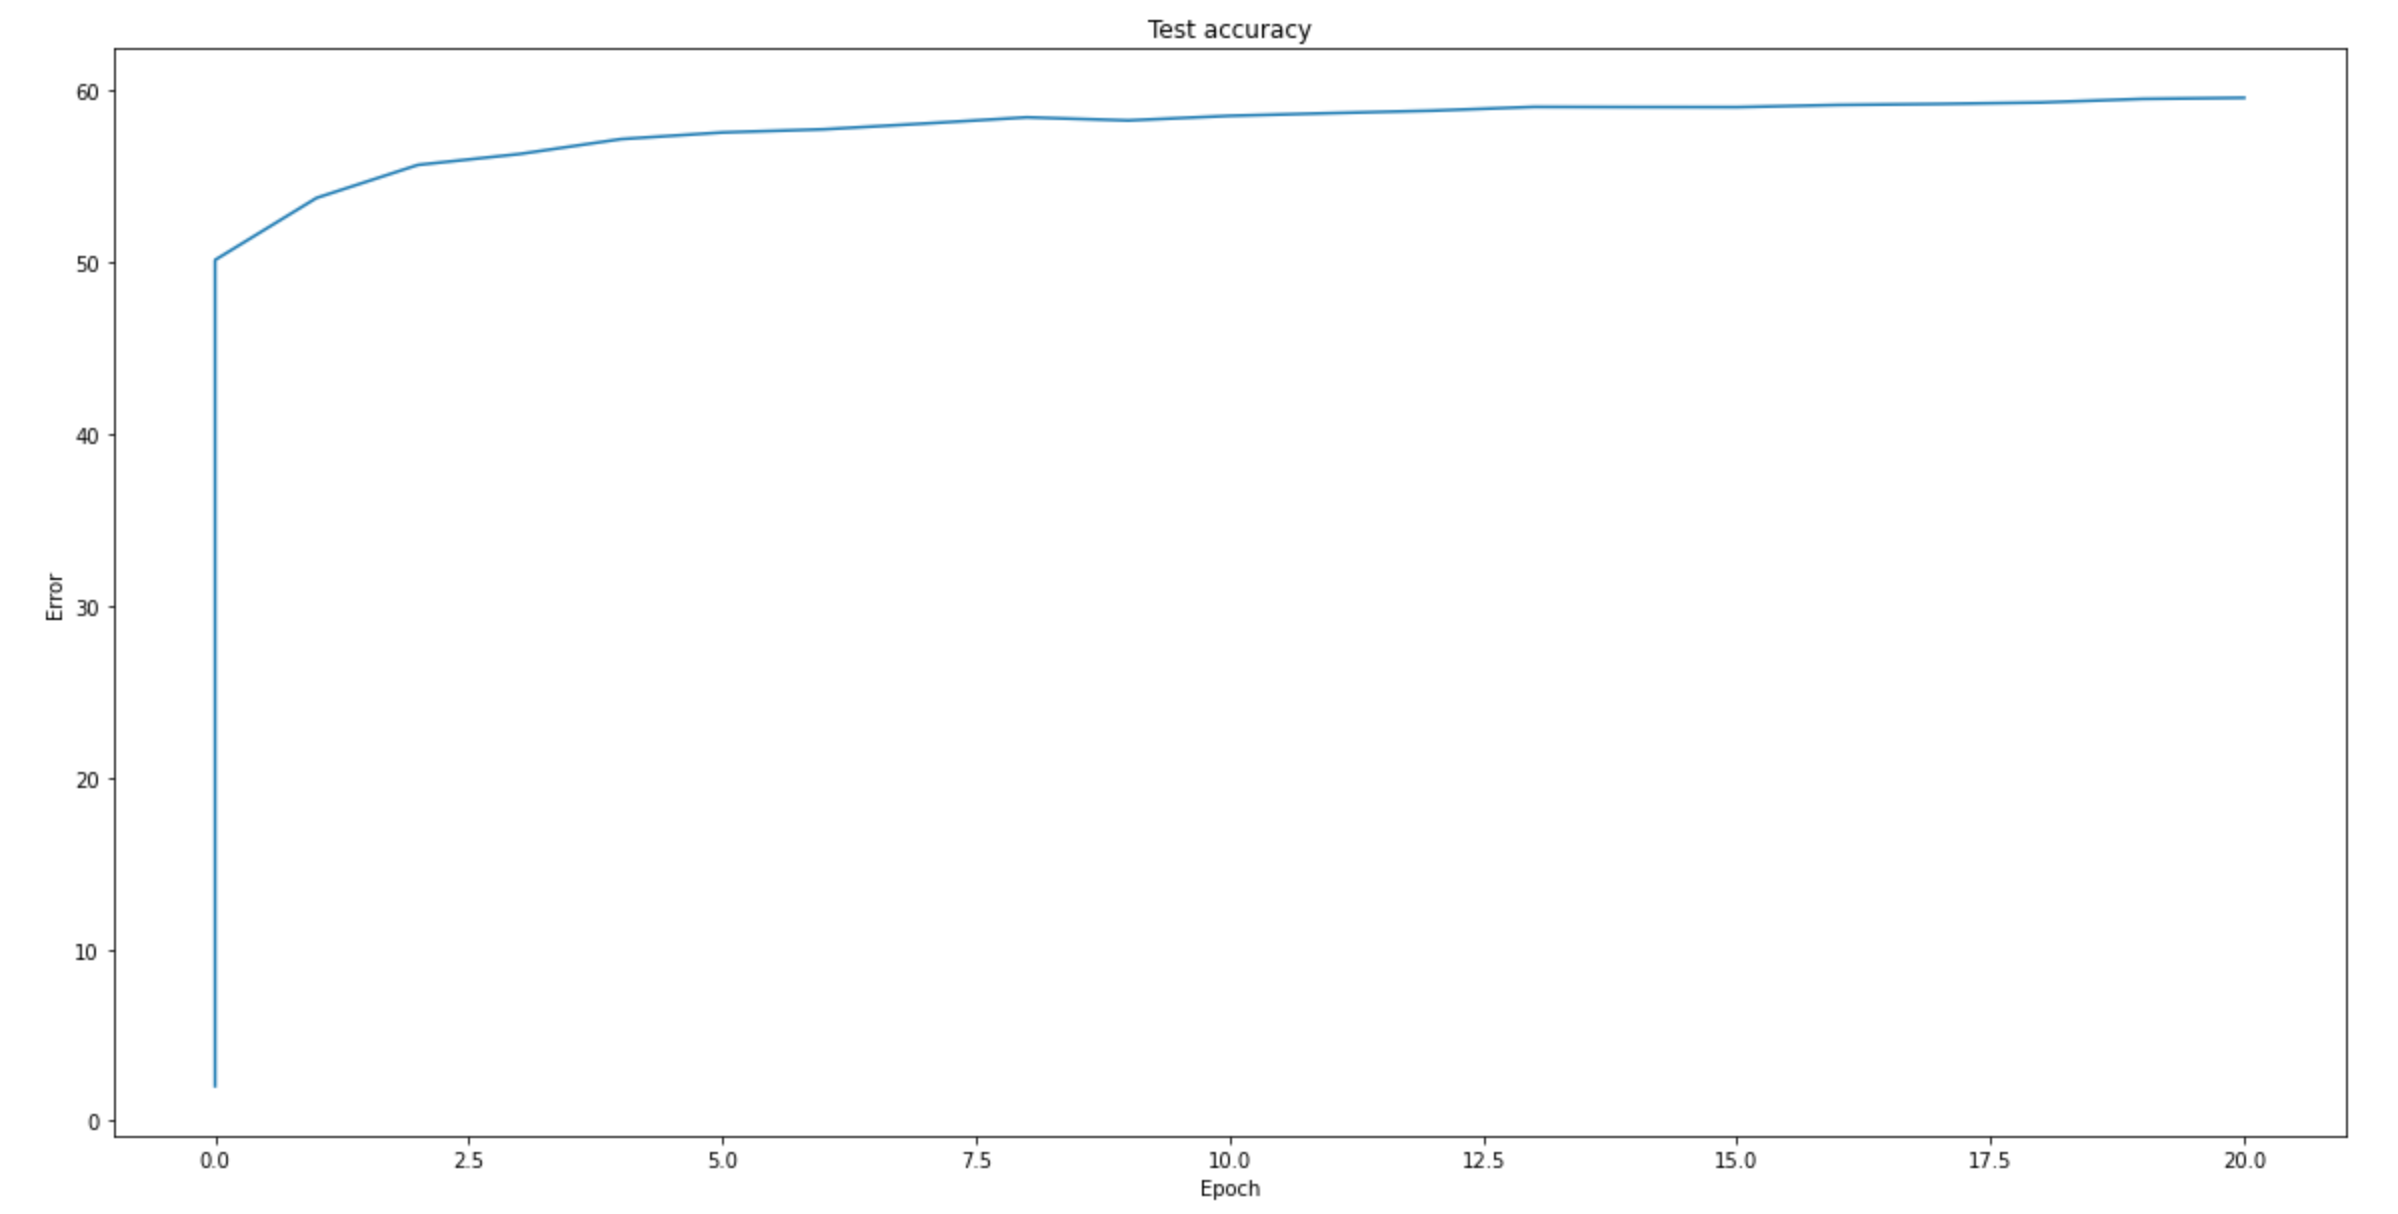
    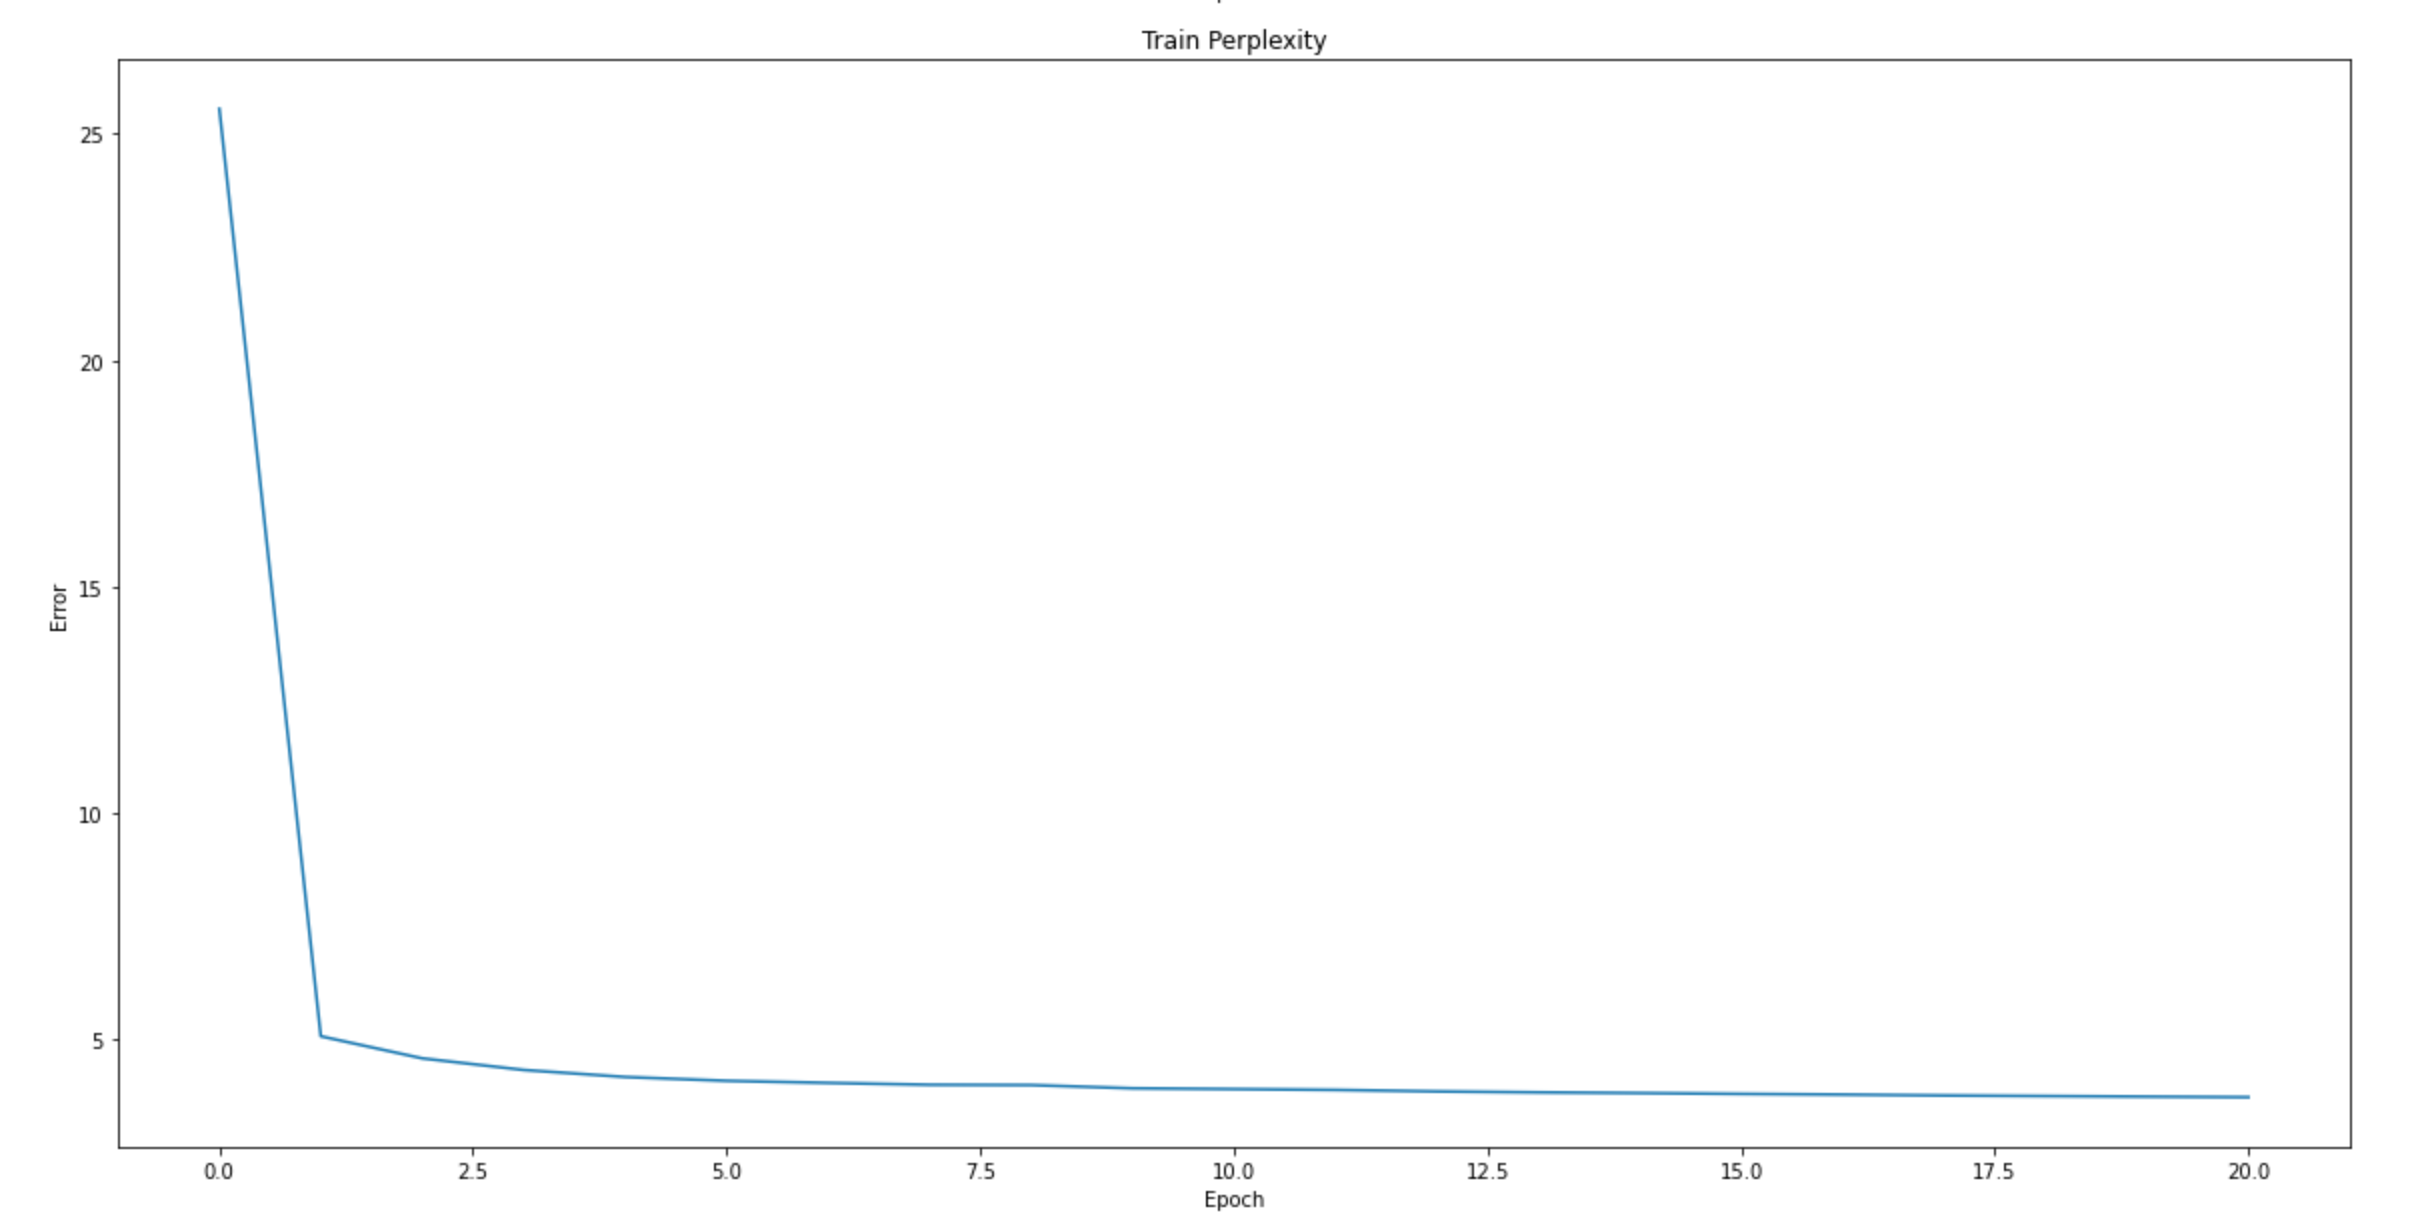
    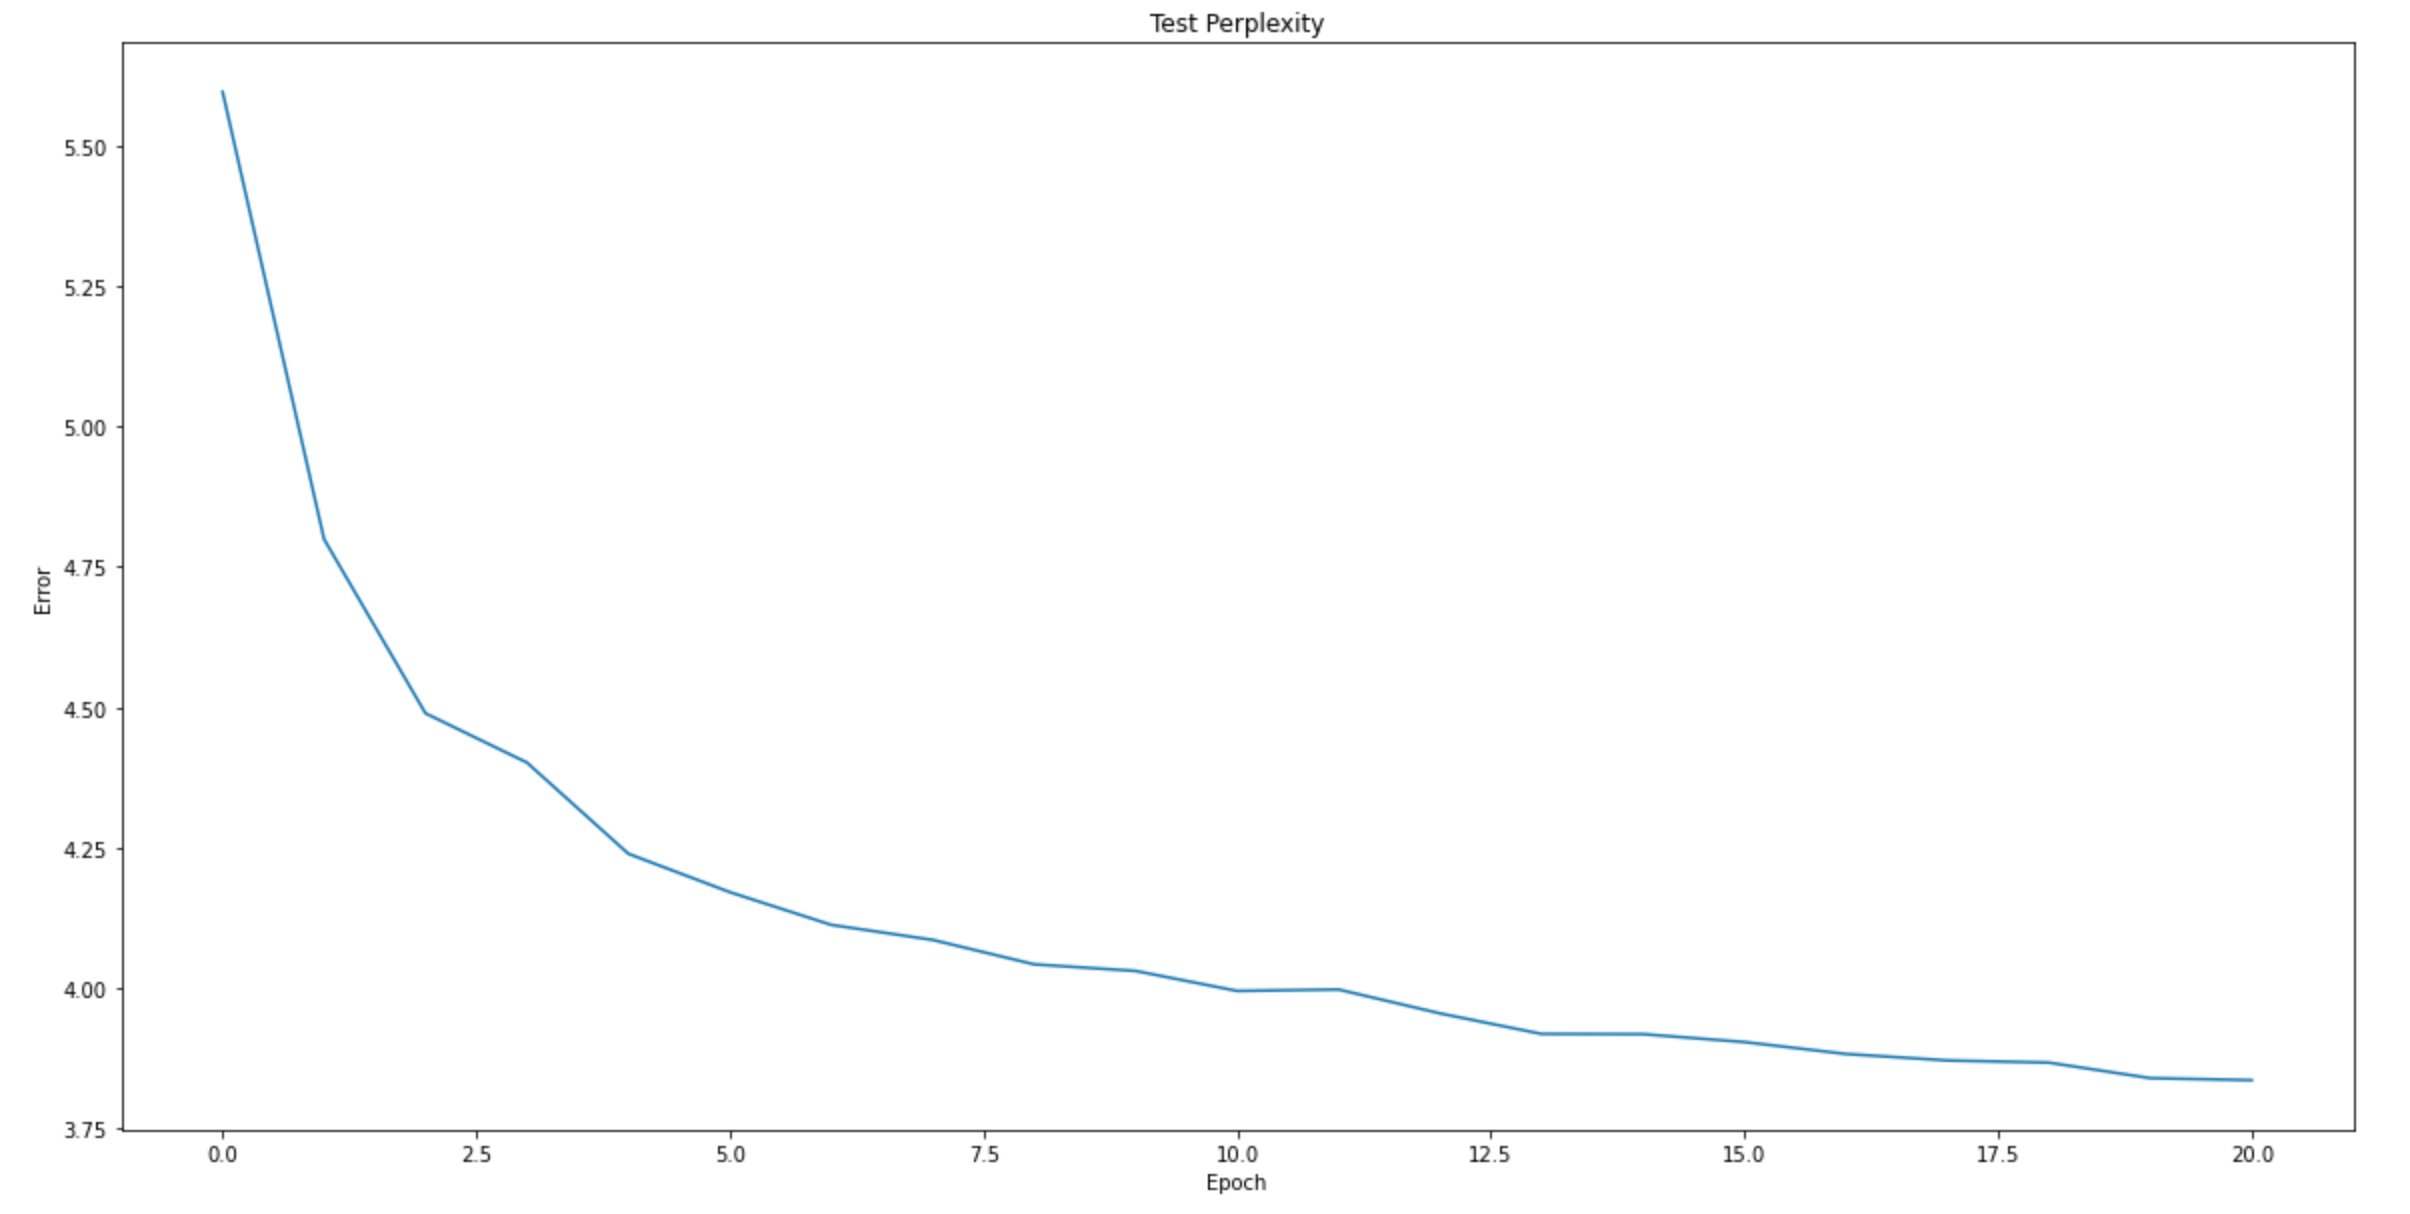
    
    
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
    max: Jon Snow who was not to see him a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song son, she was not a song so
    
    sample: Jon Snow in. You made me alway, howlings. Yut if your sons did not at Rober, worde?” Med me too. “Wind on you kill. YLing him in his vierce.”  “Is you cave nothing. She trall anothere’s nothing serving that I
    
    beam: Jon Snow had somewhere. Ser Jon’s huge of many sounded, and loose told the Martstreake but whowed its off bastArds and hard without white tovanion,  It was more voice. “Hand are got our gare,” Starks had “up.S
    
    
1. Words
    1. What new difficulties did you run into while training?
    
    I had to split the text to words and change the word generation from idx and vice versa.
    
    
    2. How large was your vocabulary?
    
    63390.
    
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

    Yes. I changed batch size to 128, and sequence length to 10. These worked the best for me.

    